In [2]:
import os
import shutil
import random
from pathlib import Path

# Pfade anpassen (hier liegt dein Datensatz)
source_base = Path("PlantVillage")
target_base = Path("dataset")  # Hierhin wird neu aufgeteilt

# Zufall festlegen (damit Split reproduzierbar ist)
random.seed(42)

# Split-Verhältnis
train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

# Alle Klassenordner (z. B. Tomato_healthy, Potato___Late_blight ...)
classes = [d for d in os.listdir(source_base) if (source_base / d).is_dir()]

for cls in classes:
    src_dir = source_base / cls
    imgs = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(imgs)

    n = len(imgs)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)

    splits = {
        "train": imgs[:n_train],
        "val":   imgs[n_train:n_train + n_val],
        "test":  imgs[n_train + n_val:]
    }

    for split_name, files in splits.items():
        dest_dir = target_base / split_name / cls
        dest_dir.mkdir(parents=True, exist_ok=True)
        for fname in files:
            shutil.copy(src_dir / fname, dest_dir / fname)

    print(f"{cls:35s} → train: {len(splits['train'])}, val: {len(splits['val'])}, test: {len(splits['test'])}")

print("\n✅ Split abgeschlossen! Neue Struktur liegt in 'dataset/'")


Tomato_healthy                      → train: 1113, val: 238, test: 240
Potato___Early_blight               → train: 700, val: 150, test: 150
PlantVillage                        → train: 0, val: 0, test: 0
Tomato__Tomato_YellowLeaf__Curl_Virus → train: 2245, val: 481, test: 482
Tomato_Early_blight                 → train: 700, val: 150, test: 150
Tomato__Target_Spot                 → train: 982, val: 210, test: 212
Potato___Late_blight                → train: 700, val: 150, test: 150
Tomato_Leaf_Mold                    → train: 666, val: 142, test: 144
Tomato_Spider_mites_Two_spotted_spider_mite → train: 1173, val: 251, test: 252
Tomato_Septoria_leaf_spot           → train: 1239, val: 265, test: 267
Tomato__Tomato_mosaic_virus         → train: 261, val: 55, test: 57
Pepper__bell___Bacterial_spot       → train: 697, val: 149, test: 151
Tomato_Bacterial_spot               → train: 1488, val: 319, test: 320
Tomato_Late_blight                  → train: 1336, val: 286, test: 287
Pepper__bell

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib

# --- Pfade anpassen ---
train_dir = pathlib.Path("dataset/train")   # ggf. ändern auf dataset_combined/train
val_dir   = pathlib.Path("dataset/val")

# --- Basisparameter ---
img_size = (224, 224)
batch_size = 32

# --- Dataset laden & Label anpassen (healthy = 0, alle anderen = 1) ---
def preprocess_dataset(directory):
    ds = keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
    )

    def relabel(x, y):
        class_names = ds.class_names
        # alle Ordner, die "healthy" heißen, werden Label 0, alle anderen 1
        new_y = tf.where(
            tf.strings.regex_full_match(tf.gather(class_names, y), ".*healthy.*"),
            0,  # healthy
            1   # diseased
        )
        return x, new_y

    return ds.map(relabel)

# --- Trainings- und Validierungsdaten laden ---
train_ds = preprocess_dataset(train_dir)
val_ds   = preprocess_dataset(val_dir)

# --- Prefetching für Performance ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

# --- CNN-Modell ---
def make_model(input_shape=img_size + (3,)):
    inputs = keras.Input(shape=input_shape)

    # 🧠 Data Augmentation
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2)
    ])

    # zuerst augmentieren, dann normalisieren
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # 🧩 Convolutional Layers
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # 🧱 Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    return model

# --- Modell erstellen ---
model = make_model()

# --- Kompilieren ---
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# --- Optional: EarlyStopping ---
early_stopping = keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

# --- Training starten ---
"""""
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping]

)
"""""
# --- Klassen-Gewichtung (Healthy = 0, Diseased = 1) ---
class_weight = {
    0: 5.0,  # Healthy-Bilder stärker gewichten
    1: 1.0   # Diseased-Bilder normal gewichten
}

# --- Training starten ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping],
    class_weight=class_weight   # <--- hier eingefügt
)


# --- Modell speichern ---
model.save("cnn_plant_disease_binary.keras")

print("\n✅ Training abgeschlossen & Modell gespeichert: cnn_plant_disease_binary.keras")


2025-10-31 21:27:27.280754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 14440 files belonging to 16 classes.


2025-10-31 21:27:30.950442: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-10-31 21:27:30.951072: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-31 21:27:30.951100: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-31 21:27:30.951583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-31 21:27:30.952013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 3089 files belonging to 16 classes.
Epoch 1/15


2025-10-31 21:27:31.885768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14440]
	 [[{{node Placeholder/_0}}]]
2025-10-31 21:27:31.886095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_25' with dtype float and shape [2]
	 [[{{node Placeholder/_25}}]]
2025-10-31 21:27:32.593006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-31 21:27:32.711627: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain termina

  1/452 [..............................] - ETA: 58:19 - loss: 1.3326 - accuracy: 0.7500

2025-10-31 21:27:39.796554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:39.796357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/452 [..............................] - ETA: 1:58 - loss: 7.6349 - accuracy: 0.4531 

2025-10-31 21:27:40.015328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:40.016367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/452 [..............................] - ETA: 1:44 - loss: 4.6542 - accuracy: 0.5938

2025-10-31 21:27:40.260044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:40.260689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:40.448721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:40.450492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/452 [..............................] - ETA: 1:35 - loss: 3.6619 - accuracy: 0.6719

2025-10-31 21:27:40.636136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:40.636232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:40.820698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:40.821562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/452 [..............................] - ETA: 1:33 - loss: 3.0127 - accuracy: 0.6992

2025-10-31 21:27:41.048802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:41.050776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:41.231399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:41.233178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/452 [..............................] - ETA: 1:30 - loss: 2.6193 - accuracy: 0.7250

2025-10-31 21:27:41.411983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:41.413370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:41.590795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:41.591059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/452 [..............................] - ETA: 1:29 - loss: 2.3574 - accuracy: 0.7500

2025-10-31 21:27:41.811220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:41.812756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:41.992853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:41.994808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/452 [..............................] - ETA: 1:27 - loss: 2.2287 - accuracy: 0.7522

2025-10-31 21:27:42.175916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:42.176252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:42.349079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:42.350983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/452 [..............................] - ETA: 1:26 - loss: 2.1476 - accuracy: 0.7583

2025-10-31 21:27:42.537307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:42.538051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/452 [>.............................] - ETA: 1:27 - loss: 2.0367 - accuracy: 0.7114

2025-10-31 21:27:42.773376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:42.775491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:42.958744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:42.958949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/452 [>.............................] - ETA: 1:28 - loss: 1.9191 - accuracy: 0.6727

2025-10-31 21:27:43.233126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:43.235115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:43.410843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:43.411068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/452 [>.............................] - ETA: 1:30 - loss: 1.8647 - accuracy: 0.6859

2025-10-31 21:27:43.717008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:43.717582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/452 [>.............................] - ETA: 1:30 - loss: 1.7876 - accuracy: 0.7031

2025-10-31 21:27:44.005796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:44.010257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:44.190142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:44.192421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/452 [>.............................] - ETA: 1:29 - loss: 1.7403 - accuracy: 0.7135

2025-10-31 21:27:44.385020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:44.385195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:44.564555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:44.567921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/452 [>.............................] - ETA: 1:28 - loss: 1.7035 - accuracy: 0.7225

2025-10-31 21:27:44.747581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:44.747721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/452 [>.............................] - ETA: 1:29 - loss: 1.6499 - accuracy: 0.7350

2025-10-31 21:27:45.026969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:45.030358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:45.203186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:45.206583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/452 [>.............................] - ETA: 1:28 - loss: 1.6307 - accuracy: 0.7388

2025-10-31 21:27:45.384871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:45.385492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/452 [>.............................] - ETA: 1:29 - loss: 1.6050 - accuracy: 0.7403

2025-10-31 21:27:45.696127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:45.696841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/452 [=>............................] - ETA: 1:31 - loss: 1.5698 - accuracy: 0.7460

2025-10-31 21:27:46.128697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:46.131664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:46.305656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:46.309909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/452 [=>............................] - ETA: 1:30 - loss: 1.5501 - accuracy: 0.7500

2025-10-31 21:27:46.494111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:46.495087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:46.680125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:46.680265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/452 [=>............................] - ETA: 1:31 - loss: 1.5324 - accuracy: 0.7420

2025-10-31 21:27:47.010819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:47.012813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:47.198246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:47.198405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/452 [=>............................] - ETA: 1:32 - loss: 1.5177 - accuracy: 0.7361

2025-10-31 21:27:47.511347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:47.511609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/452 [=>............................] - ETA: 1:32 - loss: 1.4969 - accuracy: 0.7352

2025-10-31 21:27:47.891235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:47.892065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:48.064977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:48.065131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/452 [=>............................] - ETA: 1:32 - loss: 1.4959 - accuracy: 0.7356

2025-10-31 21:27:48.244604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:48.245761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/452 [=>............................] - ETA: 1:32 - loss: 1.4803 - accuracy: 0.7344

2025-10-31 21:27:48.508963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:48.509183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/452 [=>............................] - ETA: 1:33 - loss: 1.4699 - accuracy: 0.7366

2025-10-31 21:27:48.899439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:48.901589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:49.078971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:49.083417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/452 [=>............................] - ETA: 1:47 - loss: 1.4703 - accuracy: 0.7377

2025-10-31 21:27:50.872474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:50.874343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:51.048642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:51.048765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/452 [==>...........................] - ETA: 1:45 - loss: 1.4549 - accuracy: 0.7376

2025-10-31 21:27:51.294105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:51.295115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:51.491339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/452 [==>...........................] - ETA: 1:45 - loss: 1.4408 - accuracy: 0.7318

2025-10-31 21:27:51.493641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:51.688437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:51.694515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/452 [==>...........................] - ETA: 1:43 - loss: 1.4197 - accuracy: 0.7286

2025-10-31 21:27:51.889335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:51.890011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/452 [==>...........................] - ETA: 1:42 - loss: 1.4167 - accuracy: 0.7272

2025-10-31 21:27:52.094741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:52.095391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:52.285293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:52.285962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/452 [==>...........................] - ETA: 1:41 - loss: 1.3995 - accuracy: 0.7274

2025-10-31 21:27:52.494585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:52.494769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/452 [==>...........................] - ETA: 1:40 - loss: 1.4348 - accuracy: 0.7255

2025-10-31 21:27:52.699855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:52.700051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:52.890082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:52.890590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/452 [==>...........................] - ETA: 1:39 - loss: 1.4170 - accuracy: 0.7166

2025-10-31 21:27:53.076851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:53.077082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:53.253014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:53.253318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/452 [==>...........................] - ETA: 1:37 - loss: 1.4129 - accuracy: 0.7072

2025-10-31 21:27:53.471023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:53.471058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:53.642247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:53.642613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/452 [==>...........................] - ETA: 1:36 - loss: 1.4027 - accuracy: 0.6996

2025-10-31 21:27:53.848945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:53.851282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:54.029922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:54.033549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/452 [===>..........................] - ETA: 1:35 - loss: 1.3878 - accuracy: 0.6924

2025-10-31 21:27:54.207392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:54.207718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:54.407065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:54.407223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/452 [===>..........................] - ETA: 1:34 - loss: 1.3689 - accuracy: 0.6968

2025-10-31 21:27:54.602641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:54.603816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:54.778858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:54.779609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/452 [===>..........................] - ETA: 1:33 - loss: 1.3624 - accuracy: 0.7004

2025-10-31 21:27:54.983838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:54.984997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:55.156669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:55.156917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/452 [===>..........................] - ETA: 1:32 - loss: 1.3500 - accuracy: 0.6972

2025-10-31 21:27:55.358323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:55.359073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/452 [===>..........................] - ETA: 1:31 - loss: 1.3427 - accuracy: 0.6938

2025-10-31 21:27:55.562092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:55.564986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:55.742029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:55.745047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/452 [===>..........................] - ETA: 1:31 - loss: 1.3382 - accuracy: 0.6900

2025-10-31 21:27:55.921559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:55.922048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/452 [===>..........................] - ETA: 1:30 - loss: 1.3275 - accuracy: 0.6851

2025-10-31 21:27:56.127603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:56.131038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:56.314044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:56.314248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/452 [===>..........................] - ETA: 1:29 - loss: 1.3151 - accuracy: 0.6903

2025-10-31 21:27:56.503156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:56.506405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:56.678553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:56.683495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/452 [===>..........................] - ETA: 1:28 - loss: 1.3101 - accuracy: 0.6936

2025-10-31 21:27:56.857264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:56.860389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:57.028395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:57.030036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/452 [====>.........................] - ETA: 1:27 - loss: 1.3051 - accuracy: 0.6914

2025-10-31 21:27:57.204407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:57.205300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:57.401507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:57.402478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/452 [====>.........................] - ETA: 1:26 - loss: 1.3021 - accuracy: 0.6877

2025-10-31 21:27:57.577337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:57.577815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/452 [====>.........................] - ETA: 1:25 - loss: 1.3007 - accuracy: 0.6857

2025-10-31 21:27:57.781109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:57.781205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:57.955045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:57.957318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/452 [====>.........................] - ETA: 1:24 - loss: 1.2952 - accuracy: 0.6831

2025-10-31 21:27:58.126577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:58.126881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/452 [====>.........................] - ETA: 1:24 - loss: 1.2939 - accuracy: 0.6816

2025-10-31 21:27:58.331444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:58.334580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:58.510229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:58.512991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/452 [====>.........................] - ETA: 1:23 - loss: 1.2874 - accuracy: 0.6799

2025-10-31 21:27:58.688832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:58.691446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:58.873475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:58.876053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/452 [====>.........................] - ETA: 1:22 - loss: 1.2811 - accuracy: 0.6761

2025-10-31 21:27:59.056170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:59.056476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/452 [====>.........................] - ETA: 1:22 - loss: 1.2766 - accuracy: 0.6748

2025-10-31 21:27:59.255262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:59.258869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:59.440971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:59.444040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/452 [====>.........................] - ETA: 1:21 - loss: 1.2722 - accuracy: 0.6761

2025-10-31 21:27:59.619564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:59.620584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:59.815103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:59.819114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/452 [=====>........................] - ETA: 1:20 - loss: 1.2631 - accuracy: 0.6747

2025-10-31 21:27:59.993695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:27:59.997657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:00.168092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:00.172226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/452 [=====>........................] - ETA: 1:19 - loss: 1.2605 - accuracy: 0.6689

2025-10-31 21:28:00.345233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:00.346652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:00.516371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:00.517056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/452 [=====>........................] - ETA: 1:19 - loss: 1.2578 - accuracy: 0.6634

2025-10-31 21:28:00.708715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:00.713426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:00.886161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:00.887977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/452 [=====>........................] - ETA: 1:18 - loss: 1.2530 - accuracy: 0.6581

2025-10-31 21:28:01.082778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:01.082774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:01.254375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:01.254934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/452 [=====>........................] - ETA: 1:17 - loss: 1.2484 - accuracy: 0.6568

2025-10-31 21:28:01.455733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:01.456072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:01.643552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:01.643652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/452 [=====>........................] - ETA: 1:17 - loss: 1.2397 - accuracy: 0.6565

2025-10-31 21:28:01.840037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:01.844459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:02.015909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:02.018550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/452 [=====>........................] - ETA: 1:16 - loss: 1.2372 - accuracy: 0.6574

2025-10-31 21:28:02.189670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:02.190028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/452 [=====>........................] - ETA: 1:16 - loss: 1.2325 - accuracy: 0.6595

2025-10-31 21:28:02.433652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:02.433831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/452 [======>.......................] - ETA: 1:16 - loss: 1.2310 - accuracy: 0.6615

2025-10-31 21:28:02.741776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:02.742575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:02.939903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:02.940449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/452 [======>.......................] - ETA: 1:15 - loss: 1.2234 - accuracy: 0.6646

2025-10-31 21:28:03.112599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:03.117957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:03.290313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:03.296727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/452 [======>.......................] - ETA: 1:15 - loss: 1.2205 - accuracy: 0.6653

2025-10-31 21:28:03.469392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:03.474068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:03.663437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:03.667231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/452 [======>.......................] - ETA: 1:14 - loss: 1.2143 - accuracy: 0.6654

2025-10-31 21:28:03.841844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:03.846244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:04.022133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:04.022602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/452 [======>.......................] - ETA: 1:13 - loss: 1.2104 - accuracy: 0.6661

2025-10-31 21:28:04.197194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:04.197588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:04.388902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:04.391662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/452 [======>.......................] - ETA: 1:13 - loss: 1.2011 - accuracy: 0.6673

2025-10-31 21:28:04.565811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:04.570288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:04.741528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:04.741742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/452 [======>.......................] - ETA: 1:12 - loss: 1.1980 - accuracy: 0.6682

2025-10-31 21:28:04.934632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:04.935273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:05.131668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:05.134924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/452 [======>.......................] - ETA: 1:11 - loss: 1.2566 - accuracy: 0.6675

2025-10-31 21:28:05.310736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:05.313928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:05.484393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:05.485265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/452 [=======>......................] - ETA: 1:11 - loss: 1.2501 - accuracy: 0.6655

2025-10-31 21:28:05.675932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:05.678812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:05.854829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:05.857145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/452 [=======>......................] - ETA: 1:10 - loss: 1.2475 - accuracy: 0.6628

2025-10-31 21:28:06.028025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:06.032177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:06.205380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:06.205462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/452 [=======>......................] - ETA: 1:10 - loss: 1.2451 - accuracy: 0.6602

2025-10-31 21:28:06.394464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:06.395132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/452 [=======>......................] - ETA: 1:09 - loss: 1.2415 - accuracy: 0.6564

2025-10-31 21:28:06.609439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:06.609731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:06.798492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:06.798705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/452 [=======>......................] - ETA: 1:09 - loss: 1.2412 - accuracy: 0.6545

2025-10-31 21:28:06.993673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:06.997721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:07.171646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:07.175084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/452 [=======>......................] - ETA: 1:08 - loss: 1.2377 - accuracy: 0.6543

2025-10-31 21:28:07.354158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:07.354713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:07.527187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:07.527924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/452 [=======>......................] - ETA: 1:08 - loss: 1.2361 - accuracy: 0.6545

2025-10-31 21:28:07.729448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:07.734457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:07.906286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:07.907539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/452 [=======>......................] - ETA: 1:07 - loss: 1.2342 - accuracy: 0.6536

2025-10-31 21:28:08.081279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:08.081631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/452 [========>.....................] - ETA: 1:07 - loss: 1.2314 - accuracy: 0.6532

2025-10-31 21:28:08.285361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:08.288372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:08.460254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:08.461054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/452 [========>.....................] - ETA: 1:06 - loss: 1.2273 - accuracy: 0.6507

2025-10-31 21:28:08.666707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:08.668639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:08.840499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:08.841001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/452 [========>.....................] - ETA: 1:06 - loss: 1.2294 - accuracy: 0.6522

2025-10-31 21:28:09.036459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:09.040836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:09.221804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:09.222084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/452 [========>.....................] - ETA: 1:05 - loss: 1.2255 - accuracy: 0.6502

2025-10-31 21:28:09.394519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:09.394854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/452 [========>.....................] - ETA: 1:05 - loss: 1.2247 - accuracy: 0.6476

2025-10-31 21:28:09.597974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:09.602287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:09.776804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:09.782279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/452 [========>.....................] - ETA: 1:04 - loss: 1.2223 - accuracy: 0.6445

2025-10-31 21:28:09.956162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:09.956547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:10.150533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:10.151240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/452 [========>.....................] - ETA: 1:04 - loss: 1.2211 - accuracy: 0.6419

2025-10-31 21:28:10.345354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:10.345871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:10.539262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:10.539616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/452 [========>.....................] - ETA: 1:03 - loss: 1.2206 - accuracy: 0.6381

2025-10-31 21:28:10.733942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:10.735128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:10.911841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:10.913979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/452 [=========>....................] - ETA: 1:03 - loss: 1.2188 - accuracy: 0.6354

2025-10-31 21:28:11.087857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:11.089936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:11.261757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:11.262063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/452 [=========>....................] - ETA: 1:02 - loss: 1.2169 - accuracy: 0.6351

2025-10-31 21:28:11.447621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:11.447861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:11.643263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:11.643473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/452 [=========>....................] - ETA: 1:02 - loss: 1.2141 - accuracy: 0.6354

2025-10-31 21:28:11.828418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:11.828856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/452 [=========>....................] - ETA: 1:01 - loss: 1.2128 - accuracy: 0.6369

2025-10-31 21:28:12.038438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:12.041330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:12.213076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:12.215649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/452 [=========>....................] - ETA: 1:01 - loss: 1.2079 - accuracy: 0.6363

2025-10-31 21:28:12.386700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:12.389789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:12.564427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:12.567689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/452 [=========>....................] - ETA: 1:00 - loss: 1.2046 - accuracy: 0.6352

2025-10-31 21:28:12.743443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:12.745492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:12.917881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:12.922062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/452 [=========>....................] - ETA: 1:00 - loss: 1.2013 - accuracy: 0.6347

2025-10-31 21:28:13.094884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:13.095398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:13.270201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:13.270731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/452 [=========>....................] - ETA: 59s - loss: 1.1987 - accuracy: 0.6363 

2025-10-31 21:28:13.454120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:13.459618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:13.631834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:13.631991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/452 [==========>...................] - ETA: 59s - loss: 1.1943 - accuracy: 0.6379

2025-10-31 21:28:13.807752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:13.808487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:13.980170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:13.985759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/452 [==========>...................] - ETA: 58s - loss: 1.1894 - accuracy: 0.6383

2025-10-31 21:28:14.155991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:14.157065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:14.343200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:14.344109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/452 [==========>...................] - ETA: 58s - loss: 1.1882 - accuracy: 0.6387

2025-10-31 21:28:14.536333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:14.537758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/452 [==========>...................] - ETA: 58s - loss: 1.1872 - accuracy: 0.6384

2025-10-31 21:28:14.739388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:14.742335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:14.918208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:14.918208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/452 [==========>...................] - ETA: 57s - loss: 1.1826 - accuracy: 0.6381

2025-10-31 21:28:15.094641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:15.096706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:15.269312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:15.270180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/452 [==========>...................] - ETA: 57s - loss: 1.1791 - accuracy: 0.6365

2025-10-31 21:28:15.467226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:15.470012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:15.643022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:15.644217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 56s - loss: 1.1728 - accuracy: 0.6378

2025-10-31 21:28:15.820192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:15.824013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:15.995288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:15.997465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/452 [==========>...................] - ETA: 56s - loss: 1.1734 - accuracy: 0.6383

2025-10-31 21:28:16.171459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:16.171689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:16.356155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:16.360620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/452 [===========>..................] - ETA: 55s - loss: 1.1710 - accuracy: 0.6383

2025-10-31 21:28:16.533342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:16.533666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:16.729351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:16.729420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/452 [===========>..................] - ETA: 55s - loss: 1.1733 - accuracy: 0.6373

2025-10-31 21:28:16.901166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:16.901559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:17.097392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:17.097976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/452 [===========>..................] - ETA: 54s - loss: 1.1719 - accuracy: 0.6359

2025-10-31 21:28:17.290485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:17.291118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/452 [===========>..................] - ETA: 54s - loss: 1.1702 - accuracy: 0.6323

2025-10-31 21:28:17.495456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:17.499796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:17.674158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:17.676772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/452 [===========>..................] - ETA: 54s - loss: 1.1682 - accuracy: 0.6297

2025-10-31 21:28:17.855617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:17.855635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:18.030088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:18.034461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/452 [===========>..................] - ETA: 53s - loss: 1.1678 - accuracy: 0.6276

2025-10-31 21:28:18.207571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:18.210357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:18.382045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:18.382379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/452 [===========>..................] - ETA: 53s - loss: 1.1635 - accuracy: 0.6263

2025-10-31 21:28:18.576815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:18.579714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:18.750069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:18.751687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/452 [===========>..................] - ETA: 52s - loss: 1.1598 - accuracy: 0.6274

2025-10-31 21:28:18.924729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:18.925556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:19.114295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:19.115074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/452 [============>.................] - ETA: 52s - loss: 1.1594 - accuracy: 0.6293

2025-10-31 21:28:19.380790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:19.381079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:19.577417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 52s - loss: 1.1568 - accuracy: 0.6299

2025-10-31 21:28:19.580016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:19.753867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:19.754090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/452 [============>.................] - ETA: 51s - loss: 1.1560 - accuracy: 0.6299

2025-10-31 21:28:19.984611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:19.985049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:20.161620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:20.164061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/452 [============>.................] - ETA: 51s - loss: 1.1535 - accuracy: 0.6297

2025-10-31 21:28:20.339148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:20.341900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:20.514922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:20.515229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 50s - loss: 1.1518 - accuracy: 0.6290

2025-10-31 21:28:20.738958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:20.742018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:20.916644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:20.916884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/452 [============>.................] - ETA: 50s - loss: 1.1485 - accuracy: 0.6271

2025-10-31 21:28:21.127215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:21.128551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:21.301780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:21.302430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/452 [============>.................] - ETA: 49s - loss: 1.1450 - accuracy: 0.6273

2025-10-31 21:28:21.537960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:21.540478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:21.713767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:21.714776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/452 [============>.................] - ETA: 49s - loss: 1.1419 - accuracy: 0.6274

2025-10-31 21:28:21.893823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:21.895193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:22.075380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:22.075666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/452 [============>.................] - ETA: 49s - loss: 1.1389 - accuracy: 0.6277

2025-10-31 21:28:22.287058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:22.287383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/452 [=============>................] - ETA: 49s - loss: 1.1380 - accuracy: 0.6287

2025-10-31 21:28:22.515174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:22.515431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/452 [=============>................] - ETA: 48s - loss: 1.1378 - accuracy: 0.6294

2025-10-31 21:28:22.728047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:22.728895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:22.906834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:22.907521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/452 [=============>................] - ETA: 48s - loss: 1.1359 - accuracy: 0.6308

2025-10-31 21:28:23.084415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:23.087233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:23.271021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:23.271303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/452 [=============>................] - ETA: 47s - loss: 1.1328 - accuracy: 0.6319

2025-10-31 21:28:23.459321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:23.459967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:23.650383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:23.650700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/452 [=============>................] - ETA: 47s - loss: 1.1302 - accuracy: 0.6326

2025-10-31 21:28:23.841519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:23.845722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:24.023905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:24.023949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/452 [=============>................] - ETA: 47s - loss: 1.1277 - accuracy: 0.6331

2025-10-31 21:28:24.198800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:24.199377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/452 [=============>................] - ETA: 46s - loss: 1.1238 - accuracy: 0.6335

2025-10-31 21:28:24.407923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:24.408102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:24.583342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:24.584114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/452 [=============>................] - ETA: 46s - loss: 1.1217 - accuracy: 0.6338

2025-10-31 21:28:24.766722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:24.767977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:24.955708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:24.956178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/452 [==============>...............] - ETA: 45s - loss: 1.1208 - accuracy: 0.6349

2025-10-31 21:28:25.129733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:25.130294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:25.307112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:25.308848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/452 [==============>...............] - ETA: 45s - loss: 1.1171 - accuracy: 0.6357

2025-10-31 21:28:25.482742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:25.484793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:25.659364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:25.659617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/452 [==============>...............] - ETA: 44s - loss: 1.1146 - accuracy: 0.6359

2025-10-31 21:28:25.852076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:25.853861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:26.032773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:26.034938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/452 [==============>...............] - ETA: 44s - loss: 1.1126 - accuracy: 0.6373

2025-10-31 21:28:26.209419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:26.211756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:26.393317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:26.395656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/452 [==============>...............] - ETA: 43s - loss: 1.1074 - accuracy: 0.6388

2025-10-31 21:28:26.576711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:26.577137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:26.764458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:26.765335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/452 [==============>...............] - ETA: 43s - loss: 1.1037 - accuracy: 0.6395

2025-10-31 21:28:26.966072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:26.971928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:27.147366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:27.147426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 43s - loss: 1.1034 - accuracy: 0.6401

2025-10-31 21:28:27.321879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:27.322924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:27.508529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:27.508984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 42s - loss: 1.1036 - accuracy: 0.6396

2025-10-31 21:28:27.709945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:27.715471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:27.890724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:27.891185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/452 [===============>..............] - ETA: 42s - loss: 1.0982 - accuracy: 0.6413

2025-10-31 21:28:28.085721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:28.086003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:28.282000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:28.282475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/452 [===============>..............] - ETA: 41s - loss: 1.1011 - accuracy: 0.6416

2025-10-31 21:28:28.455079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:28.457389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:28.634407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:28.635168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/452 [===============>..............] - ETA: 41s - loss: 1.1004 - accuracy: 0.6403

2025-10-31 21:28:28.833126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:28.836345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:29.012071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:29.012343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/452 [===============>..............] - ETA: 40s - loss: 1.0994 - accuracy: 0.6380

2025-10-31 21:28:29.207183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:29.207232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:29.384200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:29.386642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/452 [===============>..............] - ETA: 40s - loss: 1.0976 - accuracy: 0.6354

2025-10-31 21:28:29.562039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:29.566298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:29.743191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:29.746537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/452 [===============>..............] - ETA: 40s - loss: 1.0950 - accuracy: 0.6337

2025-10-31 21:28:29.926299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:29.927016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:30.107440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:30.107756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/452 [===============>..............] - ETA: 39s - loss: 1.0930 - accuracy: 0.6350

2025-10-31 21:28:30.283940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:30.283941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:30.460765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:30.462455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/452 [===============>..............] - ETA: 39s - loss: 1.0941 - accuracy: 0.6366

2025-10-31 21:28:30.649053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:30.652427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:30.834197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:30.834953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/452 [================>.............] - ETA: 39s - loss: 1.0946 - accuracy: 0.6373

2025-10-31 21:28:31.019832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:31.020138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/452 [================>.............] - ETA: 38s - loss: 1.0929 - accuracy: 0.6361

2025-10-31 21:28:31.237992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:31.238092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:31.412235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:31.417593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 38s - loss: 1.0914 - accuracy: 0.6351

2025-10-31 21:28:31.595507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:31.598519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:31.780458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:31.780481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/452 [================>.............] - ETA: 37s - loss: 1.0893 - accuracy: 0.6338

2025-10-31 21:28:31.956063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:31.960533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:32.134158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:32.134916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/452 [================>.............] - ETA: 37s - loss: 1.0879 - accuracy: 0.6338

2025-10-31 21:28:32.334215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:32.338575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:32.514190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:32.514881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/452 [================>.............] - ETA: 36s - loss: 1.0866 - accuracy: 0.6343

2025-10-31 21:28:32.692617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:32.694705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:32.869700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:32.873641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/452 [================>.............] - ETA: 36s - loss: 1.0854 - accuracy: 0.6343

2025-10-31 21:28:33.046679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:33.046844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:33.236318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:33.236657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/452 [================>.............] - ETA: 36s - loss: 1.0834 - accuracy: 0.6337

2025-10-31 21:28:33.457435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:33.457422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:33.641944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:33.643356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/452 [=================>............] - ETA: 35s - loss: 1.0837 - accuracy: 0.6341

2025-10-31 21:28:33.820236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:33.821278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:34.012850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:34.013373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/452 [=================>............] - ETA: 35s - loss: 1.0829 - accuracy: 0.6343

2025-10-31 21:28:34.205434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:34.205573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:34.402442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:34.405794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/452 [=================>............] - ETA: 34s - loss: 1.0806 - accuracy: 0.6351

2025-10-31 21:28:34.580011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:34.584153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:34.755343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:34.757725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/452 [=================>............] - ETA: 34s - loss: 1.0798 - accuracy: 0.6363

2025-10-31 21:28:34.933467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:34.938137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:35.112072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:35.115707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/452 [=================>............] - ETA: 34s - loss: 1.0774 - accuracy: 0.6368

2025-10-31 21:28:35.289138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:35.289855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:35.472685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:35.473246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/452 [=================>............] - ETA: 33s - loss: 1.0757 - accuracy: 0.6366

2025-10-31 21:28:35.676942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:35.681426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:35.855574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:35.856057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/452 [=================>............] - ETA: 33s - loss: 1.0735 - accuracy: 0.6367

2025-10-31 21:28:36.049777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:36.054172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:36.227873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:36.232249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/452 [==================>...........] - ETA: 32s - loss: 1.0741 - accuracy: 0.6353

2025-10-31 21:28:36.405933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:36.405995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:36.585066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:36.585377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/452 [==================>...........] - ETA: 32s - loss: 1.0729 - accuracy: 0.6355

2025-10-31 21:28:36.775919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:36.780914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:36.961314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:36.961343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/452 [==================>...........] - ETA: 31s - loss: 1.0706 - accuracy: 0.6350

2025-10-31 21:28:37.141053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:37.141247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:37.314379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:37.314901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/452 [==================>...........] - ETA: 31s - loss: 1.0685 - accuracy: 0.6345

2025-10-31 21:28:37.505599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:37.506237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:37.681237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:37.681517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/452 [==================>...........] - ETA: 31s - loss: 1.0671 - accuracy: 0.6348

2025-10-31 21:28:37.899023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:37.901663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:38.074138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:38.074950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/452 [==================>...........] - ETA: 30s - loss: 1.0647 - accuracy: 0.6355

2025-10-31 21:28:38.268820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:38.269283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:38.463599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:38.467654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/452 [==================>...........] - ETA: 30s - loss: 1.0634 - accuracy: 0.6361

2025-10-31 21:28:38.648310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:38.648291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:38.825558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:38.828337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/452 [==================>...........] - ETA: 29s - loss: 1.0610 - accuracy: 0.6371

2025-10-31 21:28:39.008968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:39.010151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:39.182845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:39.183201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 29s - loss: 1.0593 - accuracy: 0.6372

2025-10-31 21:28:39.380284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:39.381801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:39.562550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:39.562711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/452 [===================>..........] - ETA: 29s - loss: 1.0588 - accuracy: 0.6373

2025-10-31 21:28:39.743101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:39.744353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:39.921677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:39.922178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/452 [===================>..........] - ETA: 28s - loss: 1.0587 - accuracy: 0.6368

2025-10-31 21:28:40.124695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:40.124950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:40.316091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:40.317415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/452 [===================>..........] - ETA: 28s - loss: 1.0587 - accuracy: 0.6365

2025-10-31 21:28:40.491079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:40.491318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/452 [===================>..........] - ETA: 28s - loss: 1.0575 - accuracy: 0.6360

2025-10-31 21:28:40.721780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:40.721833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:40.897649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:40.902297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/452 [===================>..........] - ETA: 27s - loss: 1.0561 - accuracy: 0.6364

2025-10-31 21:28:41.085275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:41.085545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:41.265948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:41.266039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/452 [===================>..........] - ETA: 27s - loss: 1.0578 - accuracy: 0.6360

2025-10-31 21:28:41.439078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:41.439426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 27s - loss: 1.0670 - accuracy: 0.6362

2025-10-31 21:28:41.668562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:41.669770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:41.845070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:41.847963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/452 [===================>..........] - ETA: 26s - loss: 1.0833 - accuracy: 0.6365

2025-10-31 21:28:42.028851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:42.029204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/452 [====================>.........] - ETA: 26s - loss: 1.1068 - accuracy: 0.6363

2025-10-31 21:28:42.331057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:42.334581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:42.512483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:42.512698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/452 [====================>.........] - ETA: 26s - loss: 1.1073 - accuracy: 0.6366

2025-10-31 21:28:42.688211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:42.690740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:42.872390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:42.877140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/452 [====================>.........] - ETA: 25s - loss: 1.1043 - accuracy: 0.6372

2025-10-31 21:28:43.054045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:43.055014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:43.225322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:43.226001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/452 [====================>.........] - ETA: 25s - loss: 1.1038 - accuracy: 0.6375

2025-10-31 21:28:43.460736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:43.463850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:43.642400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:43.643961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 24s - loss: 1.1010 - accuracy: 0.6376

2025-10-31 21:28:43.821900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:43.824827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:44.001001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:44.001514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/452 [====================>.........] - ETA: 24s - loss: 1.0996 - accuracy: 0.6376

2025-10-31 21:28:44.181631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:44.182270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:44.357760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:44.358373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/452 [====================>.........] - ETA: 24s - loss: 1.0970 - accuracy: 0.6379

2025-10-31 21:28:44.689458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:44.689630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:44.864059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:44.866608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/452 [====================>.........] - ETA: 23s - loss: 1.0965 - accuracy: 0.6378

2025-10-31 21:28:45.044087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:45.044354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/452 [=====================>........] - ETA: 23s - loss: 1.0940 - accuracy: 0.6384

2025-10-31 21:28:45.301006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:45.304930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:45.482413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:45.482832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/452 [=====================>........] - ETA: 23s - loss: 1.0967 - accuracy: 0.6392

2025-10-31 21:28:45.656937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:45.659740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:45.839077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:45.842520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/452 [=====================>........] - ETA: 22s - loss: 1.0947 - accuracy: 0.6394

2025-10-31 21:28:46.029912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:46.034249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:46.212912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:46.217021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/452 [=====================>........] - ETA: 22s - loss: 1.0935 - accuracy: 0.6394

2025-10-31 21:28:46.390351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:46.391236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:46.583526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:46.584241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/452 [=====================>........] - ETA: 21s - loss: 1.0919 - accuracy: 0.6380

2025-10-31 21:28:46.773153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:46.773842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:46.968832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:46.968989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/452 [=====================>........] - ETA: 21s - loss: 1.0915 - accuracy: 0.6377

2025-10-31 21:28:47.147284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:47.147566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:47.339794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:47.339925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/452 [=====================>........] - ETA: 21s - loss: 1.0895 - accuracy: 0.6372

2025-10-31 21:28:47.542126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:47.542611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:47.732319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:47.735687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/452 [======================>.......] - ETA: 20s - loss: 1.0883 - accuracy: 0.6367

2025-10-31 21:28:47.909588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:47.914543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:48.084440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:48.085413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/452 [======================>.......] - ETA: 20s - loss: 1.0867 - accuracy: 0.6366

2025-10-31 21:28:48.293534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:48.293810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:48.488888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/452 [======================>.......] - ETA: 20s - loss: 1.0867 - accuracy: 0.6367

2025-10-31 21:28:48.494070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:48.668291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:48.668522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/452 [======================>.......] - ETA: 19s - loss: 1.0858 - accuracy: 0.6376

2025-10-31 21:28:48.861931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:48.862324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:49.059092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:49.062138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 19s - loss: 1.0845 - accuracy: 0.6386

2025-10-31 21:28:49.239145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:49.241805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:49.421879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:49.422280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/452 [======================>.......] - ETA: 18s - loss: 1.0827 - accuracy: 0.6391

2025-10-31 21:28:49.599954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:49.604088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:49.782010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:49.785588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/452 [======================>.......] - ETA: 18s - loss: 1.0816 - accuracy: 0.6392

2025-10-31 21:28:49.957123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:49.957505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/452 [======================>.......] - ETA: 18s - loss: 1.0803 - accuracy: 0.6394

2025-10-31 21:28:50.166289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:50.166703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/452 [======================>.......] - ETA: 18s - loss: 1.0798 - accuracy: 0.6396

2025-10-31 21:28:50.378124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:50.381366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:50.562650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:50.563776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/452 [=======================>......] - ETA: 17s - loss: 1.0805 - accuracy: 0.6400

2025-10-31 21:28:50.739167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:50.739611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:50.933983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:50.934201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/452 [=======================>......] - ETA: 17s - loss: 1.0799 - accuracy: 0.6391

2025-10-31 21:28:51.121214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:51.122348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:51.311734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:51.314955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/452 [=======================>......] - ETA: 16s - loss: 1.0801 - accuracy: 0.6367

2025-10-31 21:28:51.489347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:51.489764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:51.678017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:51.678453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/452 [=======================>......] - ETA: 16s - loss: 1.0799 - accuracy: 0.6347

2025-10-31 21:28:51.856792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:51.860516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:52.033363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:52.038691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/452 [=======================>......] - ETA: 16s - loss: 1.0801 - accuracy: 0.6335

2025-10-31 21:28:52.219061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:52.219985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:52.411176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:52.411778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/452 [=======================>......] - ETA: 15s - loss: 1.0794 - accuracy: 0.6320

2025-10-31 21:28:52.586917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:52.591274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:52.764232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:52.768561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/452 [=======================>......] - ETA: 15s - loss: 1.0791 - accuracy: 0.6321

2025-10-31 21:28:52.941917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:52.944788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:53.125929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:53.129332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/452 [=======================>......] - ETA: 14s - loss: 1.0772 - accuracy: 0.6323

2025-10-31 21:28:53.308832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:53.309251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:53.496927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:53.498563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/452 [========================>.....] - ETA: 14s - loss: 1.0770 - accuracy: 0.6327

2025-10-31 21:28:53.677752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:53.677967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:53.858228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:53.859863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 14s - loss: 1.0766 - accuracy: 0.6330

2025-10-31 21:28:54.037884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:54.038058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 13s - loss: 1.0758 - accuracy: 0.6333

2025-10-31 21:28:54.247007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:54.252601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:54.431889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:54.433966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/452 [========================>.....] - ETA: 13s - loss: 1.0739 - accuracy: 0.6333

2025-10-31 21:28:54.611007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:54.614284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:54.791470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:54.794469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/452 [========================>.....] - ETA: 13s - loss: 1.0719 - accuracy: 0.6333

2025-10-31 21:28:54.974347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:54.974371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:55.148619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:55.150251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/452 [========================>.....] - ETA: 12s - loss: 1.0693 - accuracy: 0.6337

2025-10-31 21:28:55.324543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:55.325410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:55.513236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:55.513688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/452 [========================>.....] - ETA: 12s - loss: 1.0665 - accuracy: 0.6343

2025-10-31 21:28:55.698544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:55.698849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:55.890504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:55.894303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/452 [========================>.....] - ETA: 11s - loss: 1.0689 - accuracy: 0.6350

2025-10-31 21:28:56.080628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:56.081837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:56.257870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:56.261779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/452 [=========================>....] - ETA: 11s - loss: 1.0699 - accuracy: 0.6355

2025-10-31 21:28:56.433620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:56.439407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:56.618720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:56.618977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 11s - loss: 1.0696 - accuracy: 0.6352

2025-10-31 21:28:56.800032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:56.800956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:56.974725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:56.974917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/452 [=========================>....] - ETA: 10s - loss: 1.0687 - accuracy: 0.6346

2025-10-31 21:28:57.814444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:57.820305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:57.994337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:57.995149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/452 [=========================>....] - ETA: 10s - loss: 1.0676 - accuracy: 0.6346

2025-10-31 21:28:58.185287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:58.190664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:58.365236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:58.369981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/452 [=========================>....] - ETA: 10s - loss: 1.0666 - accuracy: 0.6345

2025-10-31 21:28:58.545058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:58.549086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:58.738777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:58.744164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/452 [=========================>....] - ETA: 9s - loss: 1.0655 - accuracy: 0.6345

2025-10-31 21:28:58.917405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:58.922230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:59.095465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:59.095484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/452 [=========================>....] - ETA: 9s - loss: 1.0643 - accuracy: 0.6353

2025-10-31 21:28:59.294541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:59.295119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:59.473665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:59.474683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/452 [==========================>...] - ETA: 8s - loss: 1.0620 - accuracy: 0.6355

2025-10-31 21:28:59.649468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:59.649971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:59.838222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:28:59.843546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/452 [==========================>...] - ETA: 8s - loss: 1.0613 - accuracy: 0.6363

2025-10-31 21:29:00.022776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:00.022879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:00.196946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:00.197267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/452 [==========================>...] - ETA: 8s - loss: 1.0600 - accuracy: 0.6370

2025-10-31 21:29:00.396034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:00.396056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:00.572846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:00.573134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/452 [==========================>...] - ETA: 7s - loss: 1.0580 - accuracy: 0.6376

2025-10-31 21:29:00.784706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:00.788565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:00.970261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:00.970333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 7s - loss: 1.0564 - accuracy: 0.6384

2025-10-31 21:29:01.142653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:01.143256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:01.336320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:01.336352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 6s - loss: 1.0542 - accuracy: 0.6387

2025-10-31 21:29:01.509250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:01.514836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:01.694787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:01.698848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/452 [==========================>...] - ETA: 6s - loss: 1.0522 - accuracy: 0.6391

2025-10-31 21:29:01.873999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:01.878758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:02.063936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:02.064274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/452 [==========================>...] - ETA: 6s - loss: 1.0533 - accuracy: 0.6402

2025-10-31 21:29:02.259190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:02.262900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:02.451074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:02.451491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/452 [===========================>..] - ETA: 5s - loss: 1.0538 - accuracy: 0.6399

2025-10-31 21:29:02.660093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:02.660737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:02.835294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:02.835932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/452 [===========================>..] - ETA: 5s - loss: 1.0577 - accuracy: 0.6388

2025-10-31 21:29:03.031104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:03.031452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:03.220474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:03.221960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/452 [===========================>..] - ETA: 4s - loss: 1.0611 - accuracy: 0.6374

2025-10-31 21:29:03.413475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:03.418007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:03.597164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:03.598612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/452 [===========================>..] - ETA: 4s - loss: 1.0631 - accuracy: 0.6364

2025-10-31 21:29:03.785633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:03.786973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:03.974611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:03.977225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 4s - loss: 1.0662 - accuracy: 0.6355

2025-10-31 21:29:04.155204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:04.158543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:04.333662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:04.337672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/452 [===========================>..] - ETA: 3s - loss: 1.0716 - accuracy: 0.6361

2025-10-31 21:29:04.516700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:04.517207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:04.712347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:04.714509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/452 [===========================>..] - ETA: 3s - loss: 1.0783 - accuracy: 0.6364

2025-10-31 21:29:04.893142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:04.893777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:05.068984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:05.070378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/452 [===========================>..] - ETA: 3s - loss: 1.0834 - accuracy: 0.6368

2025-10-31 21:29:05.241576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:05.242015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/452 [============================>.] - ETA: 2s - loss: 1.0905 - accuracy: 0.6375

2025-10-31 21:29:05.449336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:05.452243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:05.629970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:05.630230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/452 [============================>.] - ETA: 2s - loss: 1.0918 - accuracy: 0.6387

2025-10-31 21:29:05.899354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:05.903150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:06.075401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:06.075696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/452 [============================>.] - ETA: 1s - loss: 1.0903 - accuracy: 0.6395

2025-10-31 21:29:06.296803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:06.296898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:06.494531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:06.496608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/452 [============================>.] - ETA: 1s - loss: 1.0890 - accuracy: 0.6397

2025-10-31 21:29:06.674702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:06.675179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:06.856661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:06.860291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/452 [============================>.] - ETA: 1s - loss: 1.0879 - accuracy: 0.6395

2025-10-31 21:29:07.038042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:07.038316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:07.213052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:07.213524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/452 [============================>.] - ETA: 0s - loss: 1.0869 - accuracy: 0.6395

2025-10-31 21:29:07.408373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:07.408512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:07.581672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:07.582173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/452 [============================>.] - ETA: 0s - loss: 1.0870 - accuracy: 0.6393

2025-10-31 21:29:07.775198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:07.775420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:07.962164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:07.966583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - ETA: 0s - loss: 1.0860 - accuracy: 0.6393

2025-10-31 21:29:08.143262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:08.143476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:08.476549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3089]
	 [[{{node Placeholder/_4}}]]
2025-10-31 21:29:08.476812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3089]
	 [[{{node

452/452 [==============================] - 100s 204ms/step - loss: 1.0860 - accuracy: 0.6393 - val_loss: 0.6221 - val_accuracy: 0.5973
Epoch 2/15


2025-10-31 21:29:11.857655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:11.857932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/452 [..............................] - ETA: 41:56 - loss: 0.9186 - accuracy: 0.6250

2025-10-31 21:29:17.448137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:17.449357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/452 [..............................] - ETA: 1:35 - loss: 0.8707 - accuracy: 0.6354

2025-10-31 21:29:17.663777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:17.663958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:17.863876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/452 [..............................] - ETA: 1:30 - loss: 0.8702 - accuracy: 0.6719

2025-10-31 21:29:17.865499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:18.043055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:18.044720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/452 [..............................] - ETA: 1:24 - loss: 0.8492 - accuracy: 0.7031

2025-10-31 21:29:18.216744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:18.218506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:18.388108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:18.389866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/452 [..............................] - ETA: 1:22 - loss: 0.8929 - accuracy: 0.7070

2025-10-31 21:29:18.558897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:18.561084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:18.732482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:18.734058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/452 [..............................] - ETA: 1:20 - loss: 0.8592 - accuracy: 0.7281

2025-10-31 21:29:18.905230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:18.906968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:19.084045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:19.085568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/452 [..............................] - ETA: 1:20 - loss: 0.8743 - accuracy: 0.7370

2025-10-31 21:29:19.274534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:19.274574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:19.455595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:19.456759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/452 [..............................] - ETA: 1:20 - loss: 0.8917 - accuracy: 0.7567

2025-10-31 21:29:19.637385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:19.638296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:19.816666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:19.817585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/452 [>.............................] - ETA: 1:20 - loss: 0.8877 - accuracy: 0.7559

2025-10-31 21:29:20.015741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:20.017970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:20.208277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:20.208328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/452 [>.............................] - ETA: 1:20 - loss: 0.8880 - accuracy: 0.7309

2025-10-31 21:29:20.384686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:20.386486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:20.576485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:20.579551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/452 [>.............................] - ETA: 1:19 - loss: 0.8766 - accuracy: 0.7266

2025-10-31 21:29:20.750984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:20.752239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:20.941526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:20.941567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/452 [>.............................] - ETA: 1:18 - loss: 0.8594 - accuracy: 0.7216

2025-10-31 21:29:21.111164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:21.112734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:21.289842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:21.290825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/452 [>.............................] - ETA: 1:18 - loss: 0.8629 - accuracy: 0.7161

2025-10-31 21:29:21.474695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:21.474705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:21.649244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:21.649526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/452 [>.............................] - ETA: 1:17 - loss: 0.8470 - accuracy: 0.7175

2025-10-31 21:29:21.821418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:21.822720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:21.998421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:22.001870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/452 [>.............................] - ETA: 1:17 - loss: 0.8334 - accuracy: 0.7154

2025-10-31 21:29:22.176650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:22.177263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:22.365822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:22.366076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/452 [>.............................] - ETA: 1:16 - loss: 0.8273 - accuracy: 0.7292

2025-10-31 21:29:22.541412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:22.545033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:22.716237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:22.716956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/452 [=>............................] - ETA: 1:16 - loss: 0.8416 - accuracy: 0.7158

2025-10-31 21:29:22.906817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:22.907003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:23.080828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:23.084659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/452 [=>............................] - ETA: 1:15 - loss: 0.8278 - accuracy: 0.7197

2025-10-31 21:29:23.255875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:23.259734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:23.431462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:23.434781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/452 [=>............................] - ETA: 1:15 - loss: 0.8842 - accuracy: 0.7283

2025-10-31 21:29:23.603536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:23.608244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:23.779846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:23.780157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/452 [=>............................] - ETA: 1:15 - loss: 0.8750 - accuracy: 0.7294

2025-10-31 21:29:23.970971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:23.971179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:24.168028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:24.168323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/452 [=>............................] - ETA: 1:14 - loss: 0.8725 - accuracy: 0.7312

2025-10-31 21:29:24.339550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:24.339947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:24.530658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:24.531289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/452 [=>............................] - ETA: 1:14 - loss: 0.8763 - accuracy: 0.7225

2025-10-31 21:29:24.706798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:24.707147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:24.905487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:24.906277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/452 [=>............................] - ETA: 1:14 - loss: 0.8873 - accuracy: 0.7109

2025-10-31 21:29:25.078809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:25.084169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:25.258780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:25.259740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/452 [==>...........................] - ETA: 1:13 - loss: 0.8852 - accuracy: 0.7058

2025-10-31 21:29:25.445619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:25.448304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:25.624157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:25.624653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/452 [==>...........................] - ETA: 1:13 - loss: 0.8828 - accuracy: 0.7057

2025-10-31 21:29:25.825278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:25.825756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:25.995830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:26.000667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/452 [==>...........................] - ETA: 1:13 - loss: 0.9019 - accuracy: 0.7081

2025-10-31 21:29:26.173617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:26.177515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:26.346830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:26.347199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/452 [==>...........................] - ETA: 1:12 - loss: 0.9024 - accuracy: 0.7115

2025-10-31 21:29:26.527661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:26.528781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:26.707481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:26.708436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/452 [==>...........................] - ETA: 1:12 - loss: 0.9026 - accuracy: 0.7101

2025-10-31 21:29:26.889180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:26.894241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:27.070613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:27.070639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/452 [==>...........................] - ETA: 1:12 - loss: 0.9013 - accuracy: 0.7097

2025-10-31 21:29:27.238978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:27.241731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/452 [==>...........................] - ETA: 1:12 - loss: 0.9054 - accuracy: 0.7054

2025-10-31 21:29:27.450189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:27.450943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/452 [==>...........................] - ETA: 1:11 - loss: 0.9047 - accuracy: 0.7015

2025-10-31 21:29:27.662706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:27.664376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:27.854160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:27.858357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/452 [==>...........................] - ETA: 1:11 - loss: 0.9031 - accuracy: 0.6958

2025-10-31 21:29:28.047721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:28.051324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:28.243331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:28.243484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/452 [===>..........................] - ETA: 1:11 - loss: 0.9004 - accuracy: 0.6930

2025-10-31 21:29:28.433854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:28.436269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:28.624895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:28.625483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/452 [===>..........................] - ETA: 1:11 - loss: 0.9038 - accuracy: 0.6929

2025-10-31 21:29:28.817724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:28.819646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:29.008123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:29.008853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/452 [===>..........................] - ETA: 1:10 - loss: 0.9105 - accuracy: 0.6937

2025-10-31 21:29:29.207907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:29.207997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:29.394652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:29.394977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/452 [===>..........................] - ETA: 1:10 - loss: 0.9053 - accuracy: 0.6926

2025-10-31 21:29:29.579287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:29.584516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:29.778364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:29.778891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/452 [===>..........................] - ETA: 1:10 - loss: 0.9085 - accuracy: 0.6911

2025-10-31 21:29:29.989170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:29.994184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:30.181376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:30.182359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/452 [===>..........................] - ETA: 1:10 - loss: 0.9026 - accuracy: 0.6940

2025-10-31 21:29:30.380531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:30.381170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:30.576586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:30.580533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/452 [===>..........................] - ETA: 1:10 - loss: 0.8964 - accuracy: 0.6955

2025-10-31 21:29:30.781227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:30.781271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:30.981412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:30.981412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/452 [====>.........................] - ETA: 1:09 - loss: 0.8902 - accuracy: 0.6974

2025-10-31 21:29:31.169569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:31.173263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/452 [====>.........................] - ETA: 1:09 - loss: 0.8857 - accuracy: 0.6985

2025-10-31 21:29:31.375633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:31.377435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/452 [====>.........................] - ETA: 1:09 - loss: 0.8831 - accuracy: 0.6979

2025-10-31 21:29:31.576784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:31.579926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:31.775587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:31.776068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/452 [====>.........................] - ETA: 1:09 - loss: 0.8805 - accuracy: 0.7023

2025-10-31 21:29:31.964632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:31.967806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:32.157649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:32.159174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/452 [====>.........................] - ETA: 1:09 - loss: 0.8775 - accuracy: 0.7035

2025-10-31 21:29:32.351373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:32.352312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:32.546400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:32.546997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/452 [====>.........................] - ETA: 1:08 - loss: 0.8721 - accuracy: 0.7042

2025-10-31 21:29:32.734543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:32.735748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/452 [====>.........................] - ETA: 1:08 - loss: 0.8669 - accuracy: 0.7063

2025-10-31 21:29:32.936099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:32.936745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:33.129161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:33.130857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/452 [====>.........................] - ETA: 1:08 - loss: 0.8698 - accuracy: 0.7065

2025-10-31 21:29:33.323705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:33.326394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:33.517000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:33.518022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/452 [====>.........................] - ETA: 1:07 - loss: 0.8632 - accuracy: 0.7086

2025-10-31 21:29:33.725371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:33.725668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:33.926134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:33.926428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/452 [=====>........................] - ETA: 1:07 - loss: 0.8663 - accuracy: 0.7109

2025-10-31 21:29:34.113420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:34.113970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:34.312888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/452 [=====>........................] - ETA: 1:07 - loss: 0.8734 - accuracy: 0.7106

2025-10-31 21:29:34.313961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:34.510798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:34.511940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/452 [=====>........................] - ETA: 1:07 - loss: 0.8689 - accuracy: 0.7108

2025-10-31 21:29:34.721052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:34.724707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:34.918212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:34.918466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/452 [=====>........................] - ETA: 1:06 - loss: 0.8704 - accuracy: 0.7080

2025-10-31 21:29:35.112276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:35.112684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:35.308538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:35.311299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/452 [=====>........................] - ETA: 1:06 - loss: 0.8737 - accuracy: 0.7031

2025-10-31 21:29:35.497881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:35.499318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:35.682416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:35.682662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/452 [=====>........................] - ETA: 1:06 - loss: 0.8726 - accuracy: 0.7009

2025-10-31 21:29:35.885550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:35.888594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:36.084280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:36.085569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/452 [=====>........................] - ETA: 1:05 - loss: 0.8725 - accuracy: 0.6979

2025-10-31 21:29:36.270833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:36.272540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:36.453772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:36.455167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/452 [=====>........................] - ETA: 1:05 - loss: 0.8737 - accuracy: 0.6965

2025-10-31 21:29:36.635869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:36.636169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:36.816325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:36.816807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/452 [======>.......................] - ETA: 1:05 - loss: 0.8690 - accuracy: 0.6987

2025-10-31 21:29:37.026855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:37.028231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:37.203642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:37.206802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/452 [======>.......................] - ETA: 1:04 - loss: 0.8760 - accuracy: 0.7017

2025-10-31 21:29:37.383689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:37.387727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:37.560855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:37.563106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/452 [======>.......................] - ETA: 1:04 - loss: 0.8712 - accuracy: 0.7043

2025-10-31 21:29:37.743387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:37.743480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:37.928982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:37.933113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/452 [======>.......................] - ETA: 1:03 - loss: 0.8709 - accuracy: 0.7068

2025-10-31 21:29:38.120407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:38.121137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:38.298052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:38.299112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/452 [======>.......................] - ETA: 1:03 - loss: 0.8691 - accuracy: 0.7075

2025-10-31 21:29:38.472574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:38.473404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:38.667808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:38.668105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/452 [======>.......................] - ETA: 1:03 - loss: 0.8694 - accuracy: 0.7050

2025-10-31 21:29:38.844356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:38.844861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:39.044955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:39.045412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/452 [======>.......................] - ETA: 1:02 - loss: 0.8689 - accuracy: 0.7031

2025-10-31 21:29:39.219772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:39.221251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:39.393551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:39.393925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/452 [======>.......................] - ETA: 1:02 - loss: 0.8674 - accuracy: 0.7018

2025-10-31 21:29:39.575443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:39.575637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:39.771652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:39.771961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/452 [=======>......................] - ETA: 1:01 - loss: 0.8654 - accuracy: 0.7013

2025-10-31 21:29:39.955967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:39.957563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:40.144306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:40.146173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/452 [=======>......................] - ETA: 1:01 - loss: 0.8636 - accuracy: 0.7024

2025-10-31 21:29:40.331743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:40.336290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:40.525245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:40.527054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/452 [=======>......................] - ETA: 1:01 - loss: 0.8573 - accuracy: 0.7056

2025-10-31 21:29:40.701957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:40.702810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:40.883688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:40.885500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/452 [=======>......................] - ETA: 1:00 - loss: 0.8584 - accuracy: 0.7068

2025-10-31 21:29:41.066322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:41.069977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:41.244219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:41.244585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/452 [=======>......................] - ETA: 1:00 - loss: 0.8594 - accuracy: 0.7082

2025-10-31 21:29:41.440332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:41.444549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:41.618081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:41.618715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/452 [=======>......................] - ETA: 1:00 - loss: 0.8589 - accuracy: 0.7079

2025-10-31 21:29:41.822079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:41.822480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:42.003664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:42.004253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/452 [=======>......................] - ETA: 59s - loss: 0.8578 - accuracy: 0.7059

2025-10-31 21:29:42.201718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:42.202176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:42.375175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:42.375465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/452 [========>.....................] - ETA: 59s - loss: 0.8578 - accuracy: 0.7052

2025-10-31 21:29:42.571814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:42.571817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:42.761817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:42.761832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/452 [========>.....................] - ETA: 58s - loss: 0.8533 - accuracy: 0.7061

2025-10-31 21:29:42.953124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:42.953940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:43.146668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:43.147784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/452 [========>.....................] - ETA: 58s - loss: 0.8601 - accuracy: 0.7074

2025-10-31 21:29:43.329261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:43.333557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:43.510819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:43.511119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/452 [========>.....................] - ETA: 58s - loss: 0.8567 - accuracy: 0.7071

2025-10-31 21:29:43.690587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:43.691967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:43.871089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:43.871482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/452 [========>.....................] - ETA: 57s - loss: 0.8548 - accuracy: 0.7064

2025-10-31 21:29:44.063584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:44.066585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:44.242709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:44.244070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/452 [========>.....................] - ETA: 57s - loss: 0.8506 - accuracy: 0.7072

2025-10-31 21:29:44.414642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:44.415535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:44.605615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:44.607157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/452 [========>.....................] - ETA: 56s - loss: 0.8523 - accuracy: 0.7095

2025-10-31 21:29:44.790344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:44.790625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:44.976797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:44.977646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/452 [========>.....................] - ETA: 56s - loss: 0.8510 - accuracy: 0.7104

2025-10-31 21:29:45.165925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:45.166124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:45.347075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:45.348581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/452 [=========>....................] - ETA: 56s - loss: 0.8513 - accuracy: 0.7089

2025-10-31 21:29:45.524861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:45.526451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:45.717299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:45.718249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/452 [=========>....................] - ETA: 55s - loss: 0.8522 - accuracy: 0.7064

2025-10-31 21:29:45.909416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:45.909603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:46.101256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:46.101256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/452 [=========>....................] - ETA: 55s - loss: 0.8483 - accuracy: 0.7077

2025-10-31 21:29:46.349512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:46.350296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/452 [=========>....................] - ETA: 55s - loss: 0.8459 - accuracy: 0.7092

2025-10-31 21:29:46.555870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:46.557215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:46.747765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:46.748131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/452 [=========>....................] - ETA: 55s - loss: 0.8461 - accuracy: 0.7109

2025-10-31 21:29:46.943985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:46.944355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/452 [=========>....................] - ETA: 54s - loss: 0.8444 - accuracy: 0.7121

2025-10-31 21:29:47.146159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:47.147217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:47.327140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:47.328041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/452 [=========>....................] - ETA: 54s - loss: 0.8476 - accuracy: 0.7116

2025-10-31 21:29:47.533268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:47.534365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:47.721117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:47.724258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/452 [=========>....................] - ETA: 54s - loss: 0.8475 - accuracy: 0.7125

2025-10-31 21:29:47.907195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:47.908681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:48.079789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:48.080518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/452 [==========>...................] - ETA: 53s - loss: 0.8484 - accuracy: 0.7112

2025-10-31 21:29:48.259721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:48.260081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:48.457449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:48.458598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/452 [==========>...................] - ETA: 53s - loss: 0.8503 - accuracy: 0.7091

2025-10-31 21:29:48.646531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:48.650126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:48.825241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:48.826188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/452 [==========>...................] - ETA: 52s - loss: 0.8786 - accuracy: 0.7108

2025-10-31 21:29:49.011810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:49.013641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:49.194401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:49.195558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/452 [==========>...................] - ETA: 52s - loss: 0.8944 - accuracy: 0.7071

2025-10-31 21:29:49.376937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:49.378030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:49.576526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/452 [==========>...................] - ETA: 52s - loss: 0.9048 - accuracy: 0.7043

2025-10-31 21:29:49.580554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:49.759298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:49.762108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/452 [==========>...................] - ETA: 52s - loss: 0.9203 - accuracy: 0.7011

2025-10-31 21:29:49.942390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:49.944399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:50.118623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:50.118902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 51s - loss: 0.9335 - accuracy: 0.6972

2025-10-31 21:29:50.297530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:50.297993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:50.483003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:50.484589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/452 [==========>...................] - ETA: 51s - loss: 0.9454 - accuracy: 0.6943

2025-10-31 21:29:50.661787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:50.662554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:50.854907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:50.856257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/452 [===========>..................] - ETA: 50s - loss: 0.9728 - accuracy: 0.6916

2025-10-31 21:29:51.041840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:51.043934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:51.222007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:51.223054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/452 [===========>..................] - ETA: 50s - loss: 1.0146 - accuracy: 0.6921

2025-10-31 21:29:51.404459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:51.406731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:51.590669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:51.593363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/452 [===========>..................] - ETA: 50s - loss: 1.1782 - accuracy: 0.6926

2025-10-31 21:29:51.763781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:51.764507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:51.944864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:51.947515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/452 [===========>..................] - ETA: 49s - loss: 1.2378 - accuracy: 0.6932

2025-10-31 21:29:52.123586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:52.125166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:52.305357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:52.307972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/452 [===========>..................] - ETA: 49s - loss: 1.2663 - accuracy: 0.6948

2025-10-31 21:29:52.480512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:52.481203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:52.673605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:52.675729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/452 [===========>..................] - ETA: 48s - loss: 1.2647 - accuracy: 0.6965

2025-10-31 21:29:52.860997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:52.861704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:53.042875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:53.043969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/452 [===========>..................] - ETA: 48s - loss: 1.2606 - accuracy: 0.6980

2025-10-31 21:29:53.222908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:53.223774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:53.397236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:53.399355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/452 [===========>..................] - ETA: 48s - loss: 1.2590 - accuracy: 0.6963

2025-10-31 21:29:53.580641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:53.581626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:53.778676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:53.778708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 47s - loss: 1.2629 - accuracy: 0.6924

2025-10-31 21:29:53.955669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:53.958690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:54.131538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:54.133100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/452 [============>.................] - ETA: 47s - loss: 1.2657 - accuracy: 0.6889

2025-10-31 21:29:54.315584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:54.319506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:54.492687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:54.495576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/452 [============>.................] - ETA: 46s - loss: 1.4172 - accuracy: 0.6864

2025-10-31 21:29:54.676499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:54.676499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:54.850980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:54.855991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 46s - loss: 1.4292 - accuracy: 0.6815

2025-10-31 21:29:55.033666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:55.034891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:55.212238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:55.213244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/452 [============>.................] - ETA: 46s - loss: 1.4436 - accuracy: 0.6779

2025-10-31 21:29:55.390357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:55.390368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:55.579357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:55.582354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/452 [============>.................] - ETA: 45s - loss: 1.4587 - accuracy: 0.6763

2025-10-31 21:29:55.757062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:55.757169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:55.939883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:55.940964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/452 [============>.................] - ETA: 45s - loss: 1.4969 - accuracy: 0.6760

2025-10-31 21:29:56.132853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:56.133334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:56.309332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:56.313140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/452 [=============>................] - ETA: 45s - loss: 1.5212 - accuracy: 0.6737

2025-10-31 21:29:56.486127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:56.486598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:56.668278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:56.672875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/452 [=============>................] - ETA: 44s - loss: 1.5374 - accuracy: 0.6719

2025-10-31 21:29:56.846174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:56.846564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/452 [=============>................] - ETA: 44s - loss: 1.5548 - accuracy: 0.6691

2025-10-31 21:29:57.065497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:57.066052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:57.258148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:57.258153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/452 [=============>................] - ETA: 44s - loss: 1.5811 - accuracy: 0.6672

2025-10-31 21:29:57.437419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:57.438951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:57.620506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:57.620666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/452 [=============>................] - ETA: 43s - loss: 1.6259 - accuracy: 0.6667

2025-10-31 21:29:57.797010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:57.797646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:57.992822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:57.993990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/452 [=============>................] - ETA: 43s - loss: 1.6630 - accuracy: 0.6660

2025-10-31 21:29:58.180324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:58.180567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:58.356007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:58.361319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/452 [=============>................] - ETA: 42s - loss: 1.6749 - accuracy: 0.6645

2025-10-31 21:29:58.532679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:58.533617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:58.705573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:58.706730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/452 [=============>................] - ETA: 42s - loss: 1.6915 - accuracy: 0.6629

2025-10-31 21:29:58.889805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:58.892327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:59.068895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:59.071611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/452 [==============>...............] - ETA: 42s - loss: 1.7251 - accuracy: 0.6616

2025-10-31 21:29:59.249979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:59.254817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:59.428286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:59.430130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/452 [==============>...............] - ETA: 41s - loss: 1.7546 - accuracy: 0.6601

2025-10-31 21:29:59.611150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:59.614787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:59.790877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:59.795548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/452 [==============>...............] - ETA: 41s - loss: 1.8277 - accuracy: 0.6600

2025-10-31 21:29:59.967381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:29:59.967769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:00.152778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:00.152783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/452 [==============>...............] - ETA: 41s - loss: 1.8498 - accuracy: 0.6600

2025-10-31 21:30:00.342281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:00.344553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:00.521846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:00.523280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/452 [==============>...............] - ETA: 40s - loss: 1.8796 - accuracy: 0.6600

2025-10-31 21:30:00.712726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:00.713462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:00.905836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:00.906080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/452 [==============>...............] - ETA: 40s - loss: 1.8910 - accuracy: 0.6583

2025-10-31 21:30:01.086892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:01.089804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:01.263457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:01.264065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 39s - loss: 1.9020 - accuracy: 0.6554

2025-10-31 21:30:01.465856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:01.467842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:01.651424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:01.652203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 39s - loss: 1.9112 - accuracy: 0.6528

2025-10-31 21:30:01.828044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:01.831193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:02.004018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:02.005960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/452 [===============>..............] - ETA: 39s - loss: 1.9220 - accuracy: 0.6513

2025-10-31 21:30:02.187143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:02.188062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:02.386650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/452 [===============>..............] - ETA: 38s - loss: 1.9258 - accuracy: 0.6513

2025-10-31 21:30:02.390611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:02.575509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:02.576359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/452 [===============>..............] - ETA: 38s - loss: 1.9242 - accuracy: 0.6521

2025-10-31 21:30:02.772519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:02.772946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:02.950542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:02.951300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/452 [===============>..............] - ETA: 38s - loss: 1.9291 - accuracy: 0.6514

2025-10-31 21:30:03.130941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:03.131270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:03.308631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:03.310467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/452 [===============>..............] - ETA: 37s - loss: 1.9356 - accuracy: 0.6502

2025-10-31 21:30:03.485371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:03.486783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:03.666662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:03.667912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/452 [===============>..............] - ETA: 37s - loss: 1.9350 - accuracy: 0.6490

2025-10-31 21:30:03.854018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:03.858346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:04.032262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:04.032914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/452 [===============>..............] - ETA: 37s - loss: 1.9334 - accuracy: 0.6469

2025-10-31 21:30:04.226054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:04.226518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:04.422857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:04.425663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/452 [===============>..............] - ETA: 36s - loss: 1.9369 - accuracy: 0.6474

2025-10-31 21:30:04.600068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:04.600719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:04.778160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:04.779244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/452 [================>.............] - ETA: 36s - loss: 1.9528 - accuracy: 0.6480

2025-10-31 21:30:04.955088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:04.958225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:05.136214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:05.139593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/452 [================>.............] - ETA: 35s - loss: 1.9497 - accuracy: 0.6470

2025-10-31 21:30:05.314050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:05.314577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:05.500967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:05.501264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 35s - loss: 1.9483 - accuracy: 0.6437

2025-10-31 21:30:05.678761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:05.681683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:05.856147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:05.859514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/452 [================>.............] - ETA: 35s - loss: 1.9475 - accuracy: 0.6417

2025-10-31 21:30:06.041953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:06.041984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:06.222269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:06.226758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/452 [================>.............] - ETA: 34s - loss: 1.9454 - accuracy: 0.6410

2025-10-31 21:30:06.400603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:06.402898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:06.579475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:06.580284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/452 [================>.............] - ETA: 34s - loss: 1.9409 - accuracy: 0.6419

2025-10-31 21:30:06.771830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:06.772626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/452 [================>.............] - ETA: 34s - loss: 1.9396 - accuracy: 0.6423

2025-10-31 21:30:06.973469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:06.974661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:07.148334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:07.153674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/452 [================>.............] - ETA: 33s - loss: 1.9348 - accuracy: 0.6435

2025-10-31 21:30:07.335338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:07.336093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:07.523237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:07.523265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/452 [=================>............] - ETA: 33s - loss: 1.9459 - accuracy: 0.6442

2025-10-31 21:30:07.697748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:07.698378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:07.889604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:07.890624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/452 [=================>............] - ETA: 33s - loss: 1.9408 - accuracy: 0.6426

2025-10-31 21:30:08.064784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:08.065008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/452 [=================>............] - ETA: 32s - loss: 1.9379 - accuracy: 0.6416

2025-10-31 21:30:08.266725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:08.267011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:08.443959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:08.447445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/452 [=================>............] - ETA: 32s - loss: 1.9345 - accuracy: 0.6405

2025-10-31 21:30:08.626150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:08.629254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:08.800950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:08.801323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/452 [=================>............] - ETA: 32s - loss: 1.9327 - accuracy: 0.6404

2025-10-31 21:30:09.041473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:09.041602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/452 [=================>............] - ETA: 32s - loss: 1.9259 - accuracy: 0.6408

2025-10-31 21:30:09.258945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:09.265049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:09.442765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:09.444931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/452 [=================>............] - ETA: 31s - loss: 1.9227 - accuracy: 0.6414

2025-10-31 21:30:09.625449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:09.627306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:09.802719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:09.802763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/452 [=================>............] - ETA: 31s - loss: 1.9173 - accuracy: 0.6421

2025-10-31 21:30:09.992354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:09.993845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:10.178307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:10.178909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/452 [=================>............] - ETA: 30s - loss: 1.9152 - accuracy: 0.6418

2025-10-31 21:30:10.356642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:10.357010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:10.543175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:10.543509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/452 [==================>...........] - ETA: 30s - loss: 1.9126 - accuracy: 0.6402

2025-10-31 21:30:10.733554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:10.734600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:10.914806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:10.917564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/452 [==================>...........] - ETA: 30s - loss: 1.9094 - accuracy: 0.6389

2025-10-31 21:30:11.090984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:11.095101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:11.275173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:11.276508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/452 [==================>...........] - ETA: 29s - loss: 1.9074 - accuracy: 0.6369

2025-10-31 21:30:11.447889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:11.451686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:11.627431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:11.629184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/452 [==================>...........] - ETA: 29s - loss: 1.9033 - accuracy: 0.6373

2025-10-31 21:30:11.809182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:11.814076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:12.009992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/452 [==================>...........] - ETA: 29s - loss: 1.9013 - accuracy: 0.6380

2025-10-31 21:30:12.012805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:12.192989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:12.193762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/452 [==================>...........] - ETA: 28s - loss: 1.8975 - accuracy: 0.6385

2025-10-31 21:30:12.390578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:12.391980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:12.573227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:12.574790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/452 [==================>...........] - ETA: 28s - loss: 1.8920 - accuracy: 0.6397

2025-10-31 21:30:12.752548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:12.755604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:12.943342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:12.944090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/452 [==================>...........] - ETA: 28s - loss: 1.8908 - accuracy: 0.6400

2025-10-31 21:30:13.129110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:13.130568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:13.315990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:13.318983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 27s - loss: 1.8873 - accuracy: 0.6394

2025-10-31 21:30:13.501563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:13.503439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:13.699888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:13.700040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/452 [===================>..........] - ETA: 27s - loss: 1.8843 - accuracy: 0.6377

2025-10-31 21:30:13.895760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:13.897194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:14.079743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:14.083101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/452 [===================>..........] - ETA: 27s - loss: 1.8785 - accuracy: 0.6363

2025-10-31 21:30:14.258662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:14.260728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:14.445024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:14.448680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/452 [===================>..........] - ETA: 26s - loss: 1.8753 - accuracy: 0.6354

2025-10-31 21:30:14.627353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:14.628258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:14.806408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:14.806482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/452 [===================>..........] - ETA: 26s - loss: 1.8954 - accuracy: 0.6357

2025-10-31 21:30:14.992978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:14.994737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:15.166670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:15.166992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/452 [===================>..........] - ETA: 25s - loss: 1.9121 - accuracy: 0.6359

2025-10-31 21:30:15.436810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:15.436941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:15.611799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:15.616330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 25s - loss: 1.9126 - accuracy: 0.6348

2025-10-31 21:30:15.795744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:15.795766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:15.974337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:15.975674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/452 [====================>.........] - ETA: 25s - loss: 1.9132 - accuracy: 0.6329

2025-10-31 21:30:16.156975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:16.163433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:16.341815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:16.342599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/452 [====================>.........] - ETA: 24s - loss: 1.9106 - accuracy: 0.6326

2025-10-31 21:30:16.527794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:16.529105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:16.714520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:16.719421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/452 [====================>.........] - ETA: 24s - loss: 1.9057 - accuracy: 0.6328

2025-10-31 21:30:16.892593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:16.897818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:17.076836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:17.076937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/452 [====================>.........] - ETA: 24s - loss: 1.9001 - accuracy: 0.6331

2025-10-31 21:30:17.268695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:17.270698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:17.443590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:17.444075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/452 [====================>.........] - ETA: 23s - loss: 1.9000 - accuracy: 0.6340

2025-10-31 21:30:17.656209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:17.657584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:17.856036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 23s - loss: 1.8986 - accuracy: 0.6337

2025-10-31 21:30:17.857228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:18.050061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:18.050246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/452 [====================>.........] - ETA: 23s - loss: 1.9012 - accuracy: 0.6335

2025-10-31 21:30:18.244073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:18.246159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:18.433578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:18.437797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/452 [====================>.........] - ETA: 22s - loss: 1.9020 - accuracy: 0.6327

2025-10-31 21:30:18.630869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:18.630970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:18.811858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:18.813377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/452 [=====================>........] - ETA: 22s - loss: 1.9018 - accuracy: 0.6337

2025-10-31 21:30:18.996004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:18.996045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:19.170827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:19.171100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/452 [=====================>........] - ETA: 22s - loss: 1.9012 - accuracy: 0.6339

2025-10-31 21:30:19.357983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:19.362747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:19.553105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:19.556401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/452 [=====================>........] - ETA: 21s - loss: 1.8946 - accuracy: 0.6341

2025-10-31 21:30:19.736268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:19.738162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:19.911641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:19.912133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/452 [=====================>........] - ETA: 21s - loss: 1.8926 - accuracy: 0.6336

2025-10-31 21:30:20.094551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:20.096964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:20.271550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:20.272964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/452 [=====================>........] - ETA: 20s - loss: 1.8879 - accuracy: 0.6340

2025-10-31 21:30:20.453440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:20.459846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:20.636383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:20.636807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/452 [=====================>........] - ETA: 20s - loss: 1.8847 - accuracy: 0.6339

2025-10-31 21:30:20.829906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:20.831565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:21.013818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:21.015796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/452 [=====================>........] - ETA: 20s - loss: 1.8807 - accuracy: 0.6341

2025-10-31 21:30:21.195765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:21.199573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:21.377987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:21.380530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/452 [=====================>........] - ETA: 19s - loss: 1.8764 - accuracy: 0.6338

2025-10-31 21:30:21.559743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:21.560233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:21.735388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:21.736298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/452 [======================>.......] - ETA: 19s - loss: 1.8690 - accuracy: 0.6344

2025-10-31 21:30:21.917244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:21.920773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:22.094912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:22.098999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/452 [======================>.......] - ETA: 19s - loss: 1.8652 - accuracy: 0.6355

2025-10-31 21:30:22.275866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:22.277562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:22.454928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:22.455516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/452 [======================>.......] - ETA: 18s - loss: 1.8649 - accuracy: 0.6366

2025-10-31 21:30:22.634831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:22.639601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:22.814858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:22.814964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 18s - loss: 1.8592 - accuracy: 0.6369

2025-10-31 21:30:22.995227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:22.998430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:23.178631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:23.180058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/452 [======================>.......] - ETA: 17s - loss: 1.8533 - accuracy: 0.6371

2025-10-31 21:30:23.367393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:23.368077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:23.542267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:23.543221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/452 [======================>.......] - ETA: 17s - loss: 1.8490 - accuracy: 0.6372

2025-10-31 21:30:23.735037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:23.738079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:23.920928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:23.922923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/452 [======================>.......] - ETA: 17s - loss: 1.8437 - accuracy: 0.6375

2025-10-31 21:30:24.108050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:24.108454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:24.289626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:24.289928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/452 [=======================>......] - ETA: 16s - loss: 1.8436 - accuracy: 0.6380

2025-10-31 21:30:24.468870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:24.471146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:24.657918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:24.658271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/452 [=======================>......] - ETA: 16s - loss: 1.8382 - accuracy: 0.6380

2025-10-31 21:30:24.831865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:24.832605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/452 [=======================>......] - ETA: 16s - loss: 1.8361 - accuracy: 0.6380

2025-10-31 21:30:25.033800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:25.034522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:25.216758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:25.221286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/452 [=======================>......] - ETA: 15s - loss: 1.8294 - accuracy: 0.6386

2025-10-31 21:30:25.421954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:25.422207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:25.593266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:25.597239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/452 [=======================>......] - ETA: 15s - loss: 1.8278 - accuracy: 0.6390

2025-10-31 21:30:25.773199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:25.778230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:25.954813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:25.955823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/452 [=======================>......] - ETA: 15s - loss: 1.8243 - accuracy: 0.6388

2025-10-31 21:30:26.139494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:26.141272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:26.325456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:26.326017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/452 [=======================>......] - ETA: 14s - loss: 1.8229 - accuracy: 0.6378

2025-10-31 21:30:26.498168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:26.498244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:26.677046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:26.680922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/452 [=======================>......] - ETA: 14s - loss: 1.8186 - accuracy: 0.6370

2025-10-31 21:30:26.857325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:26.862807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:27.046170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:27.046471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/452 [========================>.....] - ETA: 13s - loss: 1.8139 - accuracy: 0.6365

2025-10-31 21:30:27.245045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:27.246651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:27.424623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:27.425080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 13s - loss: 1.8135 - accuracy: 0.6364

2025-10-31 21:30:27.621049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:27.621476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:27.799877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:27.801138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 13s - loss: 1.8088 - accuracy: 0.6363

2025-10-31 21:30:27.986149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:27.986705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:28.158540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:28.159093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/452 [========================>.....] - ETA: 12s - loss: 1.8045 - accuracy: 0.6362

2025-10-31 21:30:28.344655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:28.345040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:28.521692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:28.525520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/452 [========================>.....] - ETA: 12s - loss: 1.8003 - accuracy: 0.6358

2025-10-31 21:30:28.701643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:28.704596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:28.882371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:28.882998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/452 [========================>.....] - ETA: 12s - loss: 1.7946 - accuracy: 0.6358

2025-10-31 21:30:29.066367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:29.067941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:29.251058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:29.255099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/452 [========================>.....] - ETA: 11s - loss: 1.7910 - accuracy: 0.6355

2025-10-31 21:30:29.438926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:29.440234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:29.624008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:29.624342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/452 [========================>.....] - ETA: 11s - loss: 1.7889 - accuracy: 0.6356

2025-10-31 21:30:29.803798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:29.805968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:29.982401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:29.986716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/452 [=========================>....] - ETA: 10s - loss: 1.7833 - accuracy: 0.6363

2025-10-31 21:30:30.162366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:30.166650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:30.346835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:30.347230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 10s - loss: 1.7791 - accuracy: 0.6367

2025-10-31 21:30:30.523221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:30.528050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:30.703795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:30.706119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/452 [=========================>....] - ETA: 10s - loss: 1.7749 - accuracy: 0.6368

2025-10-31 21:30:30.888800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:30.893508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:31.083317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:31.084435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/452 [=========================>....] - ETA: 9s - loss: 1.7711 - accuracy: 0.6367 

2025-10-31 21:30:31.269057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:31.269552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:31.460216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:31.462974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/452 [=========================>....] - ETA: 9s - loss: 1.7676 - accuracy: 0.6366

2025-10-31 21:30:31.638382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:31.641631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:31.823588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:31.823831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/452 [=========================>....] - ETA: 9s - loss: 1.7616 - accuracy: 0.6372

2025-10-31 21:30:31.995767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:31.996912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:32.175859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:32.177268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/452 [=========================>....] - ETA: 8s - loss: 1.7558 - accuracy: 0.6385

2025-10-31 21:30:32.353093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:32.354929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:32.539414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:32.541989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/452 [==========================>...] - ETA: 8s - loss: 1.7512 - accuracy: 0.6396

2025-10-31 21:30:32.722036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:32.722603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:32.895508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:32.895957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/452 [==========================>...] - ETA: 7s - loss: 1.7461 - accuracy: 0.6406

2025-10-31 21:30:33.111937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:33.112205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:33.290340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:33.295636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/452 [==========================>...] - ETA: 7s - loss: 1.7429 - accuracy: 0.6404

2025-10-31 21:30:33.474670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:33.474759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:33.649644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:33.651936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/452 [==========================>...] - ETA: 7s - loss: 1.7374 - accuracy: 0.6409

2025-10-31 21:30:33.828108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:33.828334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:34.009048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:34.009937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 6s - loss: 1.7356 - accuracy: 0.6419

2025-10-31 21:30:34.193289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:34.194552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:34.374244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:34.376443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 6s - loss: 1.7325 - accuracy: 0.6421

2025-10-31 21:30:34.557752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:34.558259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:34.738651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:34.741660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/452 [==========================>...] - ETA: 6s - loss: 1.7285 - accuracy: 0.6420

2025-10-31 21:30:34.917359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:34.921056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:35.099056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:35.099605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/452 [==========================>...] - ETA: 5s - loss: 1.7248 - accuracy: 0.6411

2025-10-31 21:30:35.278123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:35.279681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:35.458797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:35.463029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/452 [===========================>..] - ETA: 5s - loss: 1.7194 - accuracy: 0.6414

2025-10-31 21:30:35.638922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:35.642624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:35.817488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:35.822688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/452 [===========================>..] - ETA: 5s - loss: 1.7150 - accuracy: 0.6422

2025-10-31 21:30:35.998110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:35.998662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:36.183356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:36.185002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/452 [===========================>..] - ETA: 4s - loss: 1.7112 - accuracy: 0.6429

2025-10-31 21:30:36.380741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:36.383540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:36.564607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:36.566696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/452 [===========================>..] - ETA: 4s - loss: 1.7092 - accuracy: 0.6437

2025-10-31 21:30:36.740478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:36.745632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:36.922502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:36.923643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 3s - loss: 1.7043 - accuracy: 0.6445

2025-10-31 21:30:37.098941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:37.101627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:37.279369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:37.281640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/452 [===========================>..] - ETA: 3s - loss: 1.7003 - accuracy: 0.6445

2025-10-31 21:30:37.464419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:37.465695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:37.638652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:37.640429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/452 [===========================>..] - ETA: 3s - loss: 1.6963 - accuracy: 0.6440

2025-10-31 21:30:37.817281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:37.821343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:37.999940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:38.001411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


437/452 [============================>.] - ETA: 2s - loss: 1.6946 - accuracy: 0.6437

2025-10-31 21:30:38.190558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:38.190722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:38.366793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:38.370107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/452 [============================>.] - ETA: 2s - loss: 1.6905 - accuracy: 0.6435

2025-10-31 21:30:38.545566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:38.545832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:38.727091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:38.727448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/452 [============================>.] - ETA: 2s - loss: 1.6866 - accuracy: 0.6435

2025-10-31 21:30:38.901887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:38.908236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:39.089557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:39.089733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/452 [============================>.] - ETA: 1s - loss: 1.6829 - accuracy: 0.6437

2025-10-31 21:30:39.271110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:39.271180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:39.449543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:39.449628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/452 [============================>.] - ETA: 1s - loss: 1.6784 - accuracy: 0.6440

2025-10-31 21:30:39.634182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:39.637480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:39.816595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:39.818626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/452 [============================>.] - ETA: 0s - loss: 1.6739 - accuracy: 0.6443

2025-10-31 21:30:39.997801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:40.002514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:40.181028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:40.185299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/452 [============================>.] - ETA: 0s - loss: 1.6711 - accuracy: 0.6450

2025-10-31 21:30:40.363569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:40.366798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:40.541585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:40.544830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/452 [============================>.] - ETA: 0s - loss: 1.6687 - accuracy: 0.6457

2025-10-31 21:30:40.727185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:40.727791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:40.905745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:40.906485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - 92s 192ms/step - loss: 1.6677 - accuracy: 0.6454 - val_loss: 0.6624 - val_accuracy: 0.5837
Epoch 3/15


2025-10-31 21:30:43.936679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:43.937225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/452 [..............................] - ETA: 1:34 - loss: 0.8286 - accuracy: 0.6719 

2025-10-31 21:30:50.254967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:50.255491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:50.454020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/452 [..............................] - ETA: 1:31 - loss: 0.7767 - accuracy: 0.6354

2025-10-31 21:30:50.459551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:50.652812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:50.653204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/452 [..............................] - ETA: 1:28 - loss: 0.8120 - accuracy: 0.6500

2025-10-31 21:30:50.843346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:50.843519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:51.033193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:51.036765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/452 [..............................] - ETA: 1:26 - loss: 0.8596 - accuracy: 0.5982

2025-10-31 21:30:51.227864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:51.231798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:51.411618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:51.414549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/452 [..............................] - ETA: 1:25 - loss: 0.8360 - accuracy: 0.6133

2025-10-31 21:30:51.594041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:51.594955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/452 [..............................] - ETA: 1:25 - loss: 0.7773 - accuracy: 0.6344

2025-10-31 21:30:51.801813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:51.803922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:51.976185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:51.980160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/452 [..............................] - ETA: 1:23 - loss: 0.7703 - accuracy: 0.6771

2025-10-31 21:30:52.155525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:52.158330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:52.335668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:52.335926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/452 [..............................] - ETA: 1:22 - loss: 0.7764 - accuracy: 0.7054

2025-10-31 21:30:52.518123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:52.518213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:52.699046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:52.700588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/452 [>.............................] - ETA: 1:21 - loss: 0.7910 - accuracy: 0.7227

2025-10-31 21:30:52.879213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:52.879940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:53.059216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:53.059507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/452 [>.............................] - ETA: 1:20 - loss: 0.7888 - accuracy: 0.7205

2025-10-31 21:30:53.233614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:53.240042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:53.410889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:53.412394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/452 [>.............................] - ETA: 1:20 - loss: 0.8050 - accuracy: 0.7078

2025-10-31 21:30:53.601283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:53.603056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:53.782265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:53.786645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/452 [>.............................] - ETA: 1:20 - loss: 0.8193 - accuracy: 0.6903

2025-10-31 21:30:53.967150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:53.967711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:54.154960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:54.155001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/452 [>.............................] - ETA: 1:19 - loss: 0.8305 - accuracy: 0.6810

2025-10-31 21:30:54.330161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:54.334395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:54.507169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:54.507714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/452 [>.............................] - ETA: 1:18 - loss: 0.8260 - accuracy: 0.6851

2025-10-31 21:30:54.684540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:54.686758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:54.863828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:54.865220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/452 [>.............................] - ETA: 1:18 - loss: 0.8068 - accuracy: 0.6942

2025-10-31 21:30:55.048198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:55.048858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:55.222351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:55.222791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/452 [>.............................] - ETA: 1:17 - loss: 0.7990 - accuracy: 0.7073

2025-10-31 21:30:55.410211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:55.412977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:55.591247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:55.592335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/452 [=>............................] - ETA: 1:17 - loss: 0.8074 - accuracy: 0.7168

2025-10-31 21:30:55.778223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:55.781870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:55.959939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:55.960319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/452 [=>............................] - ETA: 1:17 - loss: 0.8225 - accuracy: 0.7243

2025-10-31 21:30:56.137771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:56.137979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:56.324291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:56.326210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/452 [=>............................] - ETA: 1:16 - loss: 0.8218 - accuracy: 0.7205

2025-10-31 21:30:56.498065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:56.504756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:56.677277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:56.678153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/452 [=>............................] - ETA: 1:16 - loss: 0.8304 - accuracy: 0.7188

2025-10-31 21:30:56.849418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:56.849920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:57.039223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:57.041240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/452 [=>............................] - ETA: 1:15 - loss: 0.8397 - accuracy: 0.7117

2025-10-31 21:30:57.216226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:57.219491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:57.390651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:57.391676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/452 [=>............................] - ETA: 1:15 - loss: 0.8491 - accuracy: 0.7076

2025-10-31 21:30:57.575091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:57.576833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:57.765295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:57.769409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/452 [=>............................] - ETA: 1:14 - loss: 0.8446 - accuracy: 0.7045

2025-10-31 21:30:57.947221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:57.948751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:58.121076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:58.121496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/452 [==>...........................] - ETA: 1:14 - loss: 0.8305 - accuracy: 0.7079

2025-10-31 21:30:58.307914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:58.310670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:58.487944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:58.491846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/452 [==>...........................] - ETA: 1:13 - loss: 0.8243 - accuracy: 0.7135

2025-10-31 21:30:58.660912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:58.662725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:58.834855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:58.836083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/452 [==>...........................] - ETA: 1:13 - loss: 0.8503 - accuracy: 0.7138

2025-10-31 21:30:59.022013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:59.022238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:59.204970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:59.206761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/452 [==>...........................] - ETA: 1:13 - loss: 0.8418 - accuracy: 0.7175

2025-10-31 21:30:59.382654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:59.386705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:59.560711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:59.564490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/452 [==>...........................] - ETA: 1:12 - loss: 0.8338 - accuracy: 0.7176

2025-10-31 21:30:59.742020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:59.742543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:59.916693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:30:59.918142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/452 [==>...........................] - ETA: 1:12 - loss: 0.8297 - accuracy: 0.7148

2025-10-31 21:31:00.102428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:00.102892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:00.303514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:00.304030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/452 [==>...........................] - ETA: 1:12 - loss: 0.8240 - accuracy: 0.7160

2025-10-31 21:31:00.514201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:00.515058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/452 [==>...........................] - ETA: 1:12 - loss: 0.8201 - accuracy: 0.7140

2025-10-31 21:31:00.744310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:00.746149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:00.919889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:00.920349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/452 [===>..........................] - ETA: 1:11 - loss: 0.8151 - accuracy: 0.7157

2025-10-31 21:31:01.102500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:01.106300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:01.279657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:01.279658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/452 [===>..........................] - ETA: 1:11 - loss: 0.8129 - accuracy: 0.7188

2025-10-31 21:31:01.475831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:01.476188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/452 [===>..........................] - ETA: 1:11 - loss: 0.8042 - accuracy: 0.7227

2025-10-31 21:31:01.691220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:01.693380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:01.893417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/452 [===>..........................] - ETA: 1:11 - loss: 0.7996 - accuracy: 0.7255

2025-10-31 21:31:01.896541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:02.090914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:02.091452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/452 [===>..........................] - ETA: 1:11 - loss: 0.7996 - accuracy: 0.7285

2025-10-31 21:31:02.378467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:02.380733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:02.577881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:02.578219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/452 [===>..........................] - ETA: 1:11 - loss: 0.7963 - accuracy: 0.7283

2025-10-31 21:31:02.765799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:02.768752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:02.943940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:02.948796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/452 [===>..........................] - ETA: 1:11 - loss: 0.8043 - accuracy: 0.7267

2025-10-31 21:31:03.130195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:03.131369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:03.318541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:03.319272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/452 [===>..........................] - ETA: 1:10 - loss: 0.8002 - accuracy: 0.7269

2025-10-31 21:31:03.520549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:03.522106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:03.695257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:03.696253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/452 [===>..........................] - ETA: 1:10 - loss: 0.7941 - accuracy: 0.7279

2025-10-31 21:31:03.881373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:03.882306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:04.068811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:04.070529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/452 [====>.........................] - ETA: 1:10 - loss: 0.7945 - accuracy: 0.7297

2025-10-31 21:31:04.251963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:04.253384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:04.450869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/452 [====>.........................] - ETA: 1:09 - loss: 0.7935 - accuracy: 0.7296

2025-10-31 21:31:04.455540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:04.634935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:04.635629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/452 [====>.........................] - ETA: 1:09 - loss: 0.7925 - accuracy: 0.7273

2025-10-31 21:31:04.811516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:04.816236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:04.994612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:04.994877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/452 [====>.........................] - ETA: 1:08 - loss: 0.7867 - accuracy: 0.7283

2025-10-31 21:31:05.176308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:05.176815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:05.349090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:05.350979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/452 [====>.........................] - ETA: 1:08 - loss: 0.7830 - accuracy: 0.7281

2025-10-31 21:31:05.525637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:05.526458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:05.698827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:05.699450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/452 [====>.........................] - ETA: 1:08 - loss: 0.7840 - accuracy: 0.7322

2025-10-31 21:31:05.878762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:05.879198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:06.052408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:06.054660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/452 [====>.........................] - ETA: 1:07 - loss: 0.7824 - accuracy: 0.7358

2025-10-31 21:31:06.237096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:06.237442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:06.423699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:06.425244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/452 [====>.........................] - ETA: 1:07 - loss: 0.7789 - accuracy: 0.7368

2025-10-31 21:31:06.603023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:06.604383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:06.780892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:06.781211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/452 [=====>........................] - ETA: 1:07 - loss: 0.7766 - accuracy: 0.7376

2025-10-31 21:31:06.959748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:06.960155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/452 [=====>........................] - ETA: 1:06 - loss: 0.7748 - accuracy: 0.7359

2025-10-31 21:31:07.171668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:07.171974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:07.352364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:07.353122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/452 [=====>........................] - ETA: 1:06 - loss: 0.7733 - accuracy: 0.7345

2025-10-31 21:31:07.533760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:07.537075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:07.709807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:07.713183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/452 [=====>........................] - ETA: 1:05 - loss: 0.7684 - accuracy: 0.7365

2025-10-31 21:31:07.888400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:07.889775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:08.065901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:08.071836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/452 [=====>........................] - ETA: 1:05 - loss: 0.7637 - accuracy: 0.7396

2025-10-31 21:31:08.244109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:08.245073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:08.431619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:08.431751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/452 [=====>........................] - ETA: 1:05 - loss: 0.7620 - accuracy: 0.7395

2025-10-31 21:31:08.609900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:08.614884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:08.791903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:08.793045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/452 [=====>........................] - ETA: 1:04 - loss: 0.7635 - accuracy: 0.7373

2025-10-31 21:31:08.978935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:08.983666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:09.159115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:09.159730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/452 [=====>........................] - ETA: 1:04 - loss: 0.7627 - accuracy: 0.7363

2025-10-31 21:31:09.332500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:09.333379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:09.507653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:09.509053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/452 [======>.......................] - ETA: 1:03 - loss: 0.7594 - accuracy: 0.7357

2025-10-31 21:31:09.708195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:09.709961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:09.889255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:09.890820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/452 [======>.......................] - ETA: 1:03 - loss: 0.7585 - accuracy: 0.7365

2025-10-31 21:31:10.073755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:10.075829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:10.255201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:10.255471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/452 [======>.......................] - ETA: 1:03 - loss: 0.7741 - accuracy: 0.7373

2025-10-31 21:31:10.429195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:10.435161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:10.609688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:10.609807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/452 [======>.......................] - ETA: 1:02 - loss: 0.7756 - accuracy: 0.7345

2025-10-31 21:31:10.788134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:10.791508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:10.974328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:10.975470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/452 [======>.......................] - ETA: 1:02 - loss: 0.7800 - accuracy: 0.7299

2025-10-31 21:31:11.157400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:11.159924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:11.337462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:11.341570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/452 [======>.......................] - ETA: 1:01 - loss: 0.7854 - accuracy: 0.7252

2025-10-31 21:31:11.522694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:11.527338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:11.707592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:11.707681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/452 [======>.......................] - ETA: 1:01 - loss: 0.7865 - accuracy: 0.7232

2025-10-31 21:31:11.880564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:11.881375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:12.049480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:12.053221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/452 [=======>......................] - ETA: 1:01 - loss: 0.7831 - accuracy: 0.7265

2025-10-31 21:31:12.231435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:12.231623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:12.407872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:12.409167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/452 [=======>......................] - ETA: 1:00 - loss: 0.7823 - accuracy: 0.7289

2025-10-31 21:31:12.591483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:12.594645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:12.769377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:12.769476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/452 [=======>......................] - ETA: 1:00 - loss: 0.7817 - accuracy: 0.7315

2025-10-31 21:31:12.947845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:12.947837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:13.127764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:13.130540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/452 [=======>......................] - ETA: 59s - loss: 0.7847 - accuracy: 0.7335 

2025-10-31 21:31:13.306724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:13.311812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:13.490216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:13.494694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/452 [=======>......................] - ETA: 59s - loss: 0.7847 - accuracy: 0.7345

2025-10-31 21:31:13.676392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:13.680480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:13.854310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:13.856515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/452 [=======>......................] - ETA: 59s - loss: 0.7904 - accuracy: 0.7338

2025-10-31 21:31:14.041994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:14.043030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:14.220495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:14.221404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/452 [=======>......................] - ETA: 58s - loss: 0.7930 - accuracy: 0.7314

2025-10-31 21:31:14.403700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:14.403833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:14.593416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:14.595830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/452 [=======>......................] - ETA: 58s - loss: 0.7964 - accuracy: 0.7278

2025-10-31 21:31:14.775183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:14.775354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:14.971075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:14.972587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/452 [========>.....................] - ETA: 58s - loss: 0.7964 - accuracy: 0.7249

2025-10-31 21:31:15.150268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:15.151106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:15.331145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:15.335891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/452 [========>.....................] - ETA: 57s - loss: 0.7973 - accuracy: 0.7232

2025-10-31 21:31:15.515965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:15.516652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:15.700694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:15.701126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/452 [========>.....................] - ETA: 57s - loss: 0.7961 - accuracy: 0.7230

2025-10-31 21:31:15.878269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:15.879555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:16.049082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:16.054161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/452 [========>.....................] - ETA: 56s - loss: 0.7913 - accuracy: 0.7240

2025-10-31 21:31:16.230095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:16.231352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:16.408255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:16.408967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/452 [========>.....................] - ETA: 56s - loss: 0.7976 - accuracy: 0.7252

2025-10-31 21:31:16.581569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:16.583726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:16.766503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:16.767317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/452 [========>.....................] - ETA: 56s - loss: 0.7980 - accuracy: 0.7260

2025-10-31 21:31:16.951203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:16.951283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:17.140548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:17.141312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/452 [========>.....................] - ETA: 55s - loss: 0.7966 - accuracy: 0.7250

2025-10-31 21:31:17.335390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:17.335774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:17.532945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:17.532971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/452 [=========>....................] - ETA: 55s - loss: 0.7959 - accuracy: 0.7248

2025-10-31 21:31:17.713087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:17.713288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:17.902119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:17.904399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/452 [=========>....................] - ETA: 55s - loss: 0.7958 - accuracy: 0.7232

2025-10-31 21:31:18.081471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:18.082240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:18.262390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:18.265589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/452 [=========>....................] - ETA: 54s - loss: 0.7948 - accuracy: 0.7224

2025-10-31 21:31:18.446728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:18.450891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:18.625895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:18.626291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/452 [=========>....................] - ETA: 54s - loss: 0.7934 - accuracy: 0.7221

2025-10-31 21:31:18.809044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:18.813116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:18.988335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:18.990969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/452 [=========>....................] - ETA: 53s - loss: 0.7887 - accuracy: 0.7235

2025-10-31 21:31:19.172283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:19.174031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:19.354005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:19.354244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/452 [=========>....................] - ETA: 53s - loss: 0.7851 - accuracy: 0.7252

2025-10-31 21:31:19.543058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:19.544611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:19.724312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:19.724595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/452 [=========>....................] - ETA: 53s - loss: 0.7817 - accuracy: 0.7272

2025-10-31 21:31:19.924505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:19.927526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:20.104961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:20.105521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/452 [=========>....................] - ETA: 52s - loss: 0.7809 - accuracy: 0.7294

2025-10-31 21:31:20.299869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:20.300255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:20.483022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:20.483393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/452 [==========>...................] - ETA: 52s - loss: 0.7791 - accuracy: 0.7305

2025-10-31 21:31:20.658610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:20.660093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:20.846759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:20.849586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/452 [==========>...................] - ETA: 52s - loss: 0.7753 - accuracy: 0.7321

2025-10-31 21:31:21.029977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:21.033328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:21.210142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:21.211662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/452 [==========>...................] - ETA: 51s - loss: 0.7778 - accuracy: 0.7301

2025-10-31 21:31:21.408443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:21.411413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:21.598003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:21.599165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/452 [==========>...................] - ETA: 51s - loss: 0.7794 - accuracy: 0.7281

2025-10-31 21:31:21.777551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:21.778736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:21.959881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:21.963727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/452 [==========>...................] - ETA: 51s - loss: 0.7790 - accuracy: 0.7282

2025-10-31 21:31:22.142508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:22.143443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:22.328339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:22.332690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 50s - loss: 0.7827 - accuracy: 0.7278

2025-10-31 21:31:22.509247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:22.510185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:22.701819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:22.703811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/452 [==========>...................] - ETA: 50s - loss: 0.7803 - accuracy: 0.7282

2025-10-31 21:31:22.893085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:22.893221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:23.079534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:23.079826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/452 [===========>..................] - ETA: 50s - loss: 0.7788 - accuracy: 0.7285

2025-10-31 21:31:23.416865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:23.418692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:23.614819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:23.615463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/452 [===========>..................] - ETA: 49s - loss: 0.7782 - accuracy: 0.7275

2025-10-31 21:31:23.804949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:23.805595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:23.986947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:23.992526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/452 [===========>..................] - ETA: 49s - loss: 0.7742 - accuracy: 0.7291

2025-10-31 21:31:24.172704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:24.176466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:24.360791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:24.361527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/452 [===========>..................] - ETA: 49s - loss: 0.7738 - accuracy: 0.7302

2025-10-31 21:31:24.581056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:24.582377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:24.772710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:24.772756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/452 [===========>..................] - ETA: 48s - loss: 0.7718 - accuracy: 0.7316

2025-10-31 21:31:24.959246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:24.961750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:25.148235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:25.153142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/452 [===========>..................] - ETA: 48s - loss: 0.7716 - accuracy: 0.7328

2025-10-31 21:31:25.338093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:25.339873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:25.522442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:25.523766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/452 [===========>..................] - ETA: 48s - loss: 0.7673 - accuracy: 0.7342

2025-10-31 21:31:25.715736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:25.717889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:25.904595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:25.905356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/452 [===========>..................] - ETA: 47s - loss: 0.7655 - accuracy: 0.7341

2025-10-31 21:31:26.095883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:26.096420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:26.279722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:26.281843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 47s - loss: 0.7647 - accuracy: 0.7347

2025-10-31 21:31:26.462545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:26.463067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:26.654993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:26.656736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/452 [============>.................] - ETA: 46s - loss: 0.7643 - accuracy: 0.7352

2025-10-31 21:31:26.834943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:26.836291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:27.020937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:27.022522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/452 [============>.................] - ETA: 46s - loss: 0.7614 - accuracy: 0.7360

2025-10-31 21:31:27.203832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:27.204521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:27.399628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:27.400352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/452 [============>.................] - ETA: 46s - loss: 0.7619 - accuracy: 0.7356

2025-10-31 21:31:27.592088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:27.592391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 46s - loss: 0.8190 - accuracy: 0.7353

2025-10-31 21:31:27.815023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:27.816342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/452 [============>.................] - ETA: 46s - loss: 0.8168 - accuracy: 0.7350

2025-10-31 21:31:28.099959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:28.100079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:28.281953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:28.283449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/452 [============>.................] - ETA: 45s - loss: 0.8144 - accuracy: 0.7352

2025-10-31 21:31:28.480189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:28.482314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:28.664482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:28.664989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/452 [============>.................] - ETA: 45s - loss: 0.8144 - accuracy: 0.7344

2025-10-31 21:31:28.863036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:28.863219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:29.050979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:29.051281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/452 [============>.................] - ETA: 45s - loss: 0.8129 - accuracy: 0.7348

2025-10-31 21:31:29.286370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:29.286928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/452 [=============>................] - ETA: 45s - loss: 0.8130 - accuracy: 0.7345

2025-10-31 21:31:29.543245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:29.543567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/452 [=============>................] - ETA: 44s - loss: 0.8114 - accuracy: 0.7337

2025-10-31 21:31:29.777926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:29.779977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:29.960949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:29.965463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/452 [=============>................] - ETA: 44s - loss: 0.8099 - accuracy: 0.7337

2025-10-31 21:31:30.151308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:30.151829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/452 [=============>................] - ETA: 44s - loss: 0.8089 - accuracy: 0.7342

2025-10-31 21:31:30.391880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:30.392160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/452 [=============>................] - ETA: 44s - loss: 0.8061 - accuracy: 0.7358

2025-10-31 21:31:30.694924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:30.696519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:30.879842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:30.885103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/452 [=============>................] - ETA: 43s - loss: 0.8069 - accuracy: 0.7367

2025-10-31 21:31:31.064965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:31.068009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:31.250262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:31.251705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/452 [=============>................] - ETA: 43s - loss: 0.8053 - accuracy: 0.7369

2025-10-31 21:31:31.492788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:31.493634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/452 [=============>................] - ETA: 43s - loss: 0.8049 - accuracy: 0.7364

2025-10-31 21:31:31.723378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:31.725050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:31.924418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:31.924861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/452 [=============>................] - ETA: 43s - loss: 0.8035 - accuracy: 0.7361

2025-10-31 21:31:32.157109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:32.161074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:32.341663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:32.343095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/452 [==============>...............] - ETA: 42s - loss: 0.8024 - accuracy: 0.7358

2025-10-31 21:31:32.533824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:32.534425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:32.736546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:32.736788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/452 [==============>...............] - ETA: 42s - loss: 0.8012 - accuracy: 0.7356

2025-10-31 21:31:32.954201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:32.954675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/452 [==============>...............] - ETA: 42s - loss: 0.8001 - accuracy: 0.7359

2025-10-31 21:31:33.156230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:33.156442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:33.338900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:33.341298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/452 [==============>...............] - ETA: 41s - loss: 0.7985 - accuracy: 0.7368

2025-10-31 21:31:33.532775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:33.533291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:33.722445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:33.723272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/452 [==============>...............] - ETA: 41s - loss: 0.7986 - accuracy: 0.7372

2025-10-31 21:31:33.911362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:33.913772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:34.101080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:34.105971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/452 [==============>...............] - ETA: 41s - loss: 0.7980 - accuracy: 0.7373

2025-10-31 21:31:34.299137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:34.299912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:34.495316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:34.497240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/452 [==============>...............] - ETA: 40s - loss: 0.7971 - accuracy: 0.7368

2025-10-31 21:31:34.692553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:34.693525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 40s - loss: 0.7965 - accuracy: 0.7363

2025-10-31 21:31:34.891913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:34.894245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:35.083469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:35.085396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 40s - loss: 0.8015 - accuracy: 0.7352

2025-10-31 21:31:35.274869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:35.274997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:35.464156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:35.464317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/452 [===============>..............] - ETA: 39s - loss: 0.8531 - accuracy: 0.7328

2025-10-31 21:31:35.668739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:35.671526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:35.862737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:35.863118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/452 [===============>..............] - ETA: 39s - loss: 0.8605 - accuracy: 0.7289

2025-10-31 21:31:36.064525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:36.064964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:36.265608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:36.267668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/452 [===============>..............] - ETA: 39s - loss: 0.8655 - accuracy: 0.7259

2025-10-31 21:31:36.476499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:36.481786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:36.675959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:36.676090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/452 [===============>..............] - ETA: 38s - loss: 0.8643 - accuracy: 0.7256

2025-10-31 21:31:36.864762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:36.865494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:37.070245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:37.070850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/452 [===============>..............] - ETA: 38s - loss: 0.8637 - accuracy: 0.7266

2025-10-31 21:31:37.286266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:37.288336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:37.479781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:37.480405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/452 [===============>..............] - ETA: 37s - loss: 0.8718 - accuracy: 0.7275

2025-10-31 21:31:37.683169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:37.684119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/452 [===============>..............] - ETA: 37s - loss: 0.8698 - accuracy: 0.7283

2025-10-31 21:31:37.890312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:37.892845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:38.080152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:38.080847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/452 [===============>..............] - ETA: 37s - loss: 0.8686 - accuracy: 0.7294

2025-10-31 21:31:38.285824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:38.287115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:38.483316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:38.484758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/452 [================>.............] - ETA: 37s - loss: 0.8679 - accuracy: 0.7294

2025-10-31 21:31:38.708293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:38.712711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:38.902795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:38.903858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/452 [================>.............] - ETA: 36s - loss: 0.8684 - accuracy: 0.7291

2025-10-31 21:31:39.111236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:39.114120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:39.307103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:39.307441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 36s - loss: 0.8660 - accuracy: 0.7298

2025-10-31 21:31:39.513906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:39.514198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:39.706091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:39.707285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/452 [================>.............] - ETA: 35s - loss: 0.8654 - accuracy: 0.7302

2025-10-31 21:31:39.929529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:39.929892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:40.129520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:40.130326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/452 [================>.............] - ETA: 35s - loss: 0.8656 - accuracy: 0.7307

2025-10-31 21:31:40.359597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:40.365455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:40.564943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:40.568527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/452 [================>.............] - ETA: 35s - loss: 0.8650 - accuracy: 0.7310

2025-10-31 21:31:40.778185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:40.778556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/452 [================>.............] - ETA: 35s - loss: 0.8640 - accuracy: 0.7318

2025-10-31 21:31:40.998914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:40.998936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:41.190103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:41.191006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/452 [================>.............] - ETA: 34s - loss: 0.8621 - accuracy: 0.7319

2025-10-31 21:31:41.397065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:41.397627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/452 [================>.............] - ETA: 34s - loss: 0.8606 - accuracy: 0.7320

2025-10-31 21:31:41.603205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:41.603538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/452 [=================>............] - ETA: 34s - loss: 0.8585 - accuracy: 0.7323

2025-10-31 21:31:41.817351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:41.822925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:42.014336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:42.018491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/452 [=================>............] - ETA: 34s - loss: 0.8578 - accuracy: 0.7336

2025-10-31 21:31:42.202692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:42.205872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:42.397056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:42.400916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/452 [=================>............] - ETA: 33s - loss: 0.8561 - accuracy: 0.7343

2025-10-31 21:31:42.592769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:42.594145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:42.788161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:42.788953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/452 [=================>............] - ETA: 33s - loss: 0.8552 - accuracy: 0.7346

2025-10-31 21:31:43.001772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:43.003812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/452 [=================>............] - ETA: 33s - loss: 0.8537 - accuracy: 0.7350

2025-10-31 21:31:43.226840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:43.228958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/452 [=================>............] - ETA: 32s - loss: 0.8529 - accuracy: 0.7351

2025-10-31 21:31:43.473837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:43.474539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:43.679705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:43.682550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/452 [=================>............] - ETA: 32s - loss: 0.8522 - accuracy: 0.7348

2025-10-31 21:31:43.899197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:43.900236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/452 [=================>............] - ETA: 32s - loss: 0.8531 - accuracy: 0.7348

2025-10-31 21:31:44.125139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:44.125282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/452 [=================>............] - ETA: 32s - loss: 0.8514 - accuracy: 0.7353

2025-10-31 21:31:44.331719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:44.331911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:44.533544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:44.537790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/452 [=================>............] - ETA: 32s - loss: 0.8507 - accuracy: 0.7356

2025-10-31 21:31:44.743443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:44.745257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/452 [==================>...........] - ETA: 31s - loss: 0.8490 - accuracy: 0.7357

2025-10-31 21:31:44.958183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:44.961855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:45.157857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:45.159455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/452 [==================>...........] - ETA: 31s - loss: 0.8481 - accuracy: 0.7360

2025-10-31 21:31:45.380339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:45.380723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/452 [==================>...........] - ETA: 31s - loss: 0.8478 - accuracy: 0.7356

2025-10-31 21:31:45.583374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:45.587992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:45.781375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:45.785844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/452 [==================>...........] - ETA: 30s - loss: 0.8464 - accuracy: 0.7353

2025-10-31 21:31:45.975081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:45.977316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:46.174721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/452 [==================>...........] - ETA: 30s - loss: 0.8451 - accuracy: 0.7361

2025-10-31 21:31:46.179826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:46.370298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:46.373182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/452 [==================>...........] - ETA: 30s - loss: 0.8432 - accuracy: 0.7368

2025-10-31 21:31:46.577902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:46.580198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/452 [==================>...........] - ETA: 30s - loss: 0.8445 - accuracy: 0.7373

2025-10-31 21:31:46.788511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:46.789514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:46.991948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:46.993381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/452 [==================>...........] - ETA: 29s - loss: 0.8434 - accuracy: 0.7376

2025-10-31 21:31:47.200200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:47.201136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/452 [==================>...........] - ETA: 29s - loss: 0.8427 - accuracy: 0.7377

2025-10-31 21:31:47.420886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:47.421337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/452 [==================>...........] - ETA: 29s - loss: 0.8411 - accuracy: 0.7379

2025-10-31 21:31:47.652556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:47.652557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:47.846181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:47.847423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/452 [===================>..........] - ETA: 28s - loss: 0.8394 - accuracy: 0.7384

2025-10-31 21:31:48.044406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:48.045056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 28s - loss: 0.8392 - accuracy: 0.7383

2025-10-31 21:31:48.245693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:48.246478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:48.436187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:48.437884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/452 [===================>..........] - ETA: 28s - loss: 0.8375 - accuracy: 0.7386

2025-10-31 21:31:48.628997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:48.629022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:48.819334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:48.821514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/452 [===================>..........] - ETA: 27s - loss: 0.8351 - accuracy: 0.7397

2025-10-31 21:31:49.013261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:49.018578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:49.208356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:49.210233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/452 [===================>..........] - ETA: 27s - loss: 0.8367 - accuracy: 0.7404

2025-10-31 21:31:49.399226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:49.399648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:49.595776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:49.597122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/452 [===================>..........] - ETA: 27s - loss: 0.8360 - accuracy: 0.7408

2025-10-31 21:31:49.797714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:49.802673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/452 [===================>..........] - ETA: 26s - loss: 0.8343 - accuracy: 0.7415

2025-10-31 21:31:50.013413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:50.016939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:50.225073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:50.225429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/452 [===================>..........] - ETA: 26s - loss: 0.8329 - accuracy: 0.7415

2025-10-31 21:31:50.441621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:50.442167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 26s - loss: 0.8311 - accuracy: 0.7417

2025-10-31 21:31:50.656462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:50.656795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:50.860001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:50.862240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/452 [===================>..........] - ETA: 26s - loss: 0.8311 - accuracy: 0.7417

2025-10-31 21:31:51.076235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:51.076280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/452 [====================>.........] - ETA: 26s - loss: 0.8299 - accuracy: 0.7418

2025-10-31 21:31:51.288914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:51.290108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/452 [====================>.........] - ETA: 25s - loss: 0.8269 - accuracy: 0.7425

2025-10-31 21:31:51.509359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:51.509475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/452 [====================>.........] - ETA: 25s - loss: 0.8260 - accuracy: 0.7432

2025-10-31 21:31:51.710486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:51.712941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/452 [====================>.........] - ETA: 25s - loss: 0.8251 - accuracy: 0.7437

2025-10-31 21:31:51.921728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:51.922392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/452 [====================>.........] - ETA: 25s - loss: 0.8252 - accuracy: 0.7437

2025-10-31 21:31:52.129118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:52.132651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/452 [====================>.........] - ETA: 24s - loss: 0.8244 - accuracy: 0.7432

2025-10-31 21:31:52.338410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:52.339190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/452 [====================>.........] - ETA: 24s - loss: 0.8248 - accuracy: 0.7429

2025-10-31 21:31:52.543281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:52.545606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:52.747902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:52.749419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 24s - loss: 0.8237 - accuracy: 0.7423

2025-10-31 21:31:52.966796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:52.967702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:53.169999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:53.172871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/452 [====================>.........] - ETA: 24s - loss: 0.8224 - accuracy: 0.7424

2025-10-31 21:31:53.376762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:53.377543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/452 [====================>.........] - ETA: 23s - loss: 0.8208 - accuracy: 0.7425

2025-10-31 21:31:53.621261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:53.621603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:53.825448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:53.825794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/452 [====================>.........] - ETA: 23s - loss: 0.8202 - accuracy: 0.7429

2025-10-31 21:31:54.044931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:54.050368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:54.246670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:54.247736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/452 [=====================>........] - ETA: 23s - loss: 0.8199 - accuracy: 0.7435

2025-10-31 21:31:54.476425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:54.476708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:54.673958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:54.674716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/452 [=====================>........] - ETA: 22s - loss: 0.8195 - accuracy: 0.7439

2025-10-31 21:31:54.893466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:54.894224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/452 [=====================>........] - ETA: 22s - loss: 0.8185 - accuracy: 0.7439

2025-10-31 21:31:55.108546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:55.109124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/452 [=====================>........] - ETA: 22s - loss: 0.8174 - accuracy: 0.7443

2025-10-31 21:31:55.318549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:55.319842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/452 [=====================>........] - ETA: 22s - loss: 0.8170 - accuracy: 0.7446

2025-10-31 21:31:55.533989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:55.537343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/452 [=====================>........] - ETA: 21s - loss: 0.8149 - accuracy: 0.7451

2025-10-31 21:31:55.749995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:55.754822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:55.946470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:55.947595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/452 [=====================>........] - ETA: 21s - loss: 0.8139 - accuracy: 0.7455

2025-10-31 21:31:56.163583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:56.165307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/452 [=====================>........] - ETA: 21s - loss: 0.8133 - accuracy: 0.7460

2025-10-31 21:31:56.381595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:56.383299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/452 [=====================>........] - ETA: 21s - loss: 0.8128 - accuracy: 0.7461

2025-10-31 21:31:56.595317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:56.599465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:56.796789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:56.797960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/452 [=====================>........] - ETA: 21s - loss: 0.8120 - accuracy: 0.7464

2025-10-31 21:31:57.011690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:57.012776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/452 [=====================>........] - ETA: 20s - loss: 0.8115 - accuracy: 0.7469

2025-10-31 21:31:57.266634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:57.270666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:57.468685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:57.469785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/452 [======================>.......] - ETA: 20s - loss: 0.8113 - accuracy: 0.7467

2025-10-31 21:31:57.693951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:57.697496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/452 [======================>.......] - ETA: 20s - loss: 0.8114 - accuracy: 0.7469

2025-10-31 21:31:57.921540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:57.925339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:58.131388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:58.133070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/452 [======================>.......] - ETA: 19s - loss: 0.8096 - accuracy: 0.7474

2025-10-31 21:31:58.385396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:58.385536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:58.589689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:58.590182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/452 [======================>.......] - ETA: 19s - loss: 0.8086 - accuracy: 0.7480

2025-10-31 21:31:58.807305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:58.809077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 19s - loss: 0.8063 - accuracy: 0.7487

2025-10-31 21:31:59.017235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:59.018506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


355/452 [======================>.......] - ETA: 18s - loss: 0.8053 - accuracy: 0.7489

2025-10-31 21:31:59.220279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:59.223701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:59.416786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:59.422709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/452 [======================>.......] - ETA: 18s - loss: 0.8041 - accuracy: 0.7493

2025-10-31 21:31:59.630172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:59.630820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/452 [======================>.......] - ETA: 18s - loss: 0.8037 - accuracy: 0.7498

2025-10-31 21:31:59.838477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:31:59.842987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:00.037719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:00.038670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/452 [======================>.......] - ETA: 18s - loss: 0.8027 - accuracy: 0.7498

2025-10-31 21:32:00.244011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:00.246388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/452 [======================>.......] - ETA: 17s - loss: 0.8017 - accuracy: 0.7495

2025-10-31 21:32:00.484493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:00.485143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:00.693438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:00.694571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/452 [=======================>......] - ETA: 17s - loss: 0.8020 - accuracy: 0.7489

2025-10-31 21:32:00.902579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:00.902864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/452 [=======================>......] - ETA: 17s - loss: 0.8017 - accuracy: 0.7487

2025-10-31 21:32:01.135789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:01.135794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/452 [=======================>......] - ETA: 17s - loss: 0.8013 - accuracy: 0.7482

2025-10-31 21:32:01.354918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:01.360474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:01.564991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:01.565478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/452 [=======================>......] - ETA: 16s - loss: 0.8007 - accuracy: 0.7486

2025-10-31 21:32:01.771126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:01.773538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/452 [=======================>......] - ETA: 16s - loss: 0.7999 - accuracy: 0.7491

2025-10-31 21:32:01.990380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:01.992982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/452 [=======================>......] - ETA: 16s - loss: 0.8009 - accuracy: 0.7494

2025-10-31 21:32:02.230224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:02.232534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/452 [=======================>......] - ETA: 16s - loss: 0.7992 - accuracy: 0.7501

2025-10-31 21:32:02.441971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:02.444207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/452 [=======================>......] - ETA: 16s - loss: 0.7982 - accuracy: 0.7503

2025-10-31 21:32:02.660837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:02.664477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/452 [=======================>......] - ETA: 15s - loss: 0.7962 - accuracy: 0.7512

2025-10-31 21:32:02.876899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:02.878206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:03.078188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:03.079781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/452 [=======================>......] - ETA: 15s - loss: 0.7962 - accuracy: 0.7513

2025-10-31 21:32:03.284150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:03.284854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/452 [=======================>......] - ETA: 15s - loss: 0.7954 - accuracy: 0.7515

2025-10-31 21:32:03.503026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:03.514806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/452 [=======================>......] - ETA: 15s - loss: 0.7953 - accuracy: 0.7516

2025-10-31 21:32:03.731149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:03.731351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/452 [=======================>......] - ETA: 14s - loss: 0.7948 - accuracy: 0.7517

2025-10-31 21:32:03.979383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:03.983094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/452 [========================>.....] - ETA: 14s - loss: 0.7947 - accuracy: 0.7512

2025-10-31 21:32:04.193947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:04.194585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/452 [========================>.....] - ETA: 14s - loss: 0.7941 - accuracy: 0.7510

2025-10-31 21:32:04.422414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:04.423491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 14s - loss: 0.7938 - accuracy: 0.7508

2025-10-31 21:32:04.659924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:04.660477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


380/452 [========================>.....] - ETA: 14s - loss: 0.7934 - accuracy: 0.7503

2025-10-31 21:32:04.900218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:04.901298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 13s - loss: 0.7936 - accuracy: 0.7500

2025-10-31 21:32:05.123964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:05.124729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/452 [========================>.....] - ETA: 13s - loss: 0.7928 - accuracy: 0.7498

2025-10-31 21:32:05.364482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:05.365711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/452 [========================>.....] - ETA: 13s - loss: 0.7921 - accuracy: 0.7503

2025-10-31 21:32:05.616991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:05.621053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/452 [========================>.....] - ETA: 13s - loss: 0.7907 - accuracy: 0.7507

2025-10-31 21:32:05.853446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:05.853787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/452 [========================>.....] - ETA: 13s - loss: 0.7919 - accuracy: 0.7508

2025-10-31 21:32:06.073530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:06.073832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/452 [========================>.....] - ETA: 13s - loss: 0.7908 - accuracy: 0.7512

2025-10-31 21:32:06.295351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:06.299861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/452 [========================>.....] - ETA: 12s - loss: 0.7910 - accuracy: 0.7514

2025-10-31 21:32:06.541778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:06.543292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/452 [========================>.....] - ETA: 12s - loss: 0.7896 - accuracy: 0.7519

2025-10-31 21:32:06.780925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:06.782146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/452 [========================>.....] - ETA: 12s - loss: 0.7885 - accuracy: 0.7520

2025-10-31 21:32:07.001634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:07.007941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


390/452 [========================>.....] - ETA: 12s - loss: 0.7880 - accuracy: 0.7519

2025-10-31 21:32:07.239196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:07.240808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/452 [========================>.....] - ETA: 12s - loss: 0.7867 - accuracy: 0.7522

2025-10-31 21:32:07.529427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:07.531585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


392/452 [=========================>....] - ETA: 11s - loss: 0.7867 - accuracy: 0.7524

2025-10-31 21:32:07.773078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:07.777822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/452 [=========================>....] - ETA: 11s - loss: 0.7862 - accuracy: 0.7526

2025-10-31 21:32:08.006136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:08.007996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


394/452 [=========================>....] - ETA: 11s - loss: 0.7860 - accuracy: 0.7529

2025-10-31 21:32:08.251523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:08.254365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 11s - loss: 0.7850 - accuracy: 0.7532

2025-10-31 21:32:08.518113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:08.523483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/452 [=========================>....] - ETA: 11s - loss: 0.7843 - accuracy: 0.7533

2025-10-31 21:32:08.755487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:08.757767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/452 [=========================>....] - ETA: 10s - loss: 0.7839 - accuracy: 0.7532

2025-10-31 21:32:09.004259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:09.007211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/452 [=========================>....] - ETA: 10s - loss: 0.7831 - accuracy: 0.7531

2025-10-31 21:32:09.249621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:09.251352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/452 [=========================>....] - ETA: 10s - loss: 0.7822 - accuracy: 0.7531

2025-10-31 21:32:09.504357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:09.508580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/452 [=========================>....] - ETA: 10s - loss: 0.7809 - accuracy: 0.7537

2025-10-31 21:32:09.736772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:09.737572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/452 [=========================>....] - ETA: 10s - loss: 0.7796 - accuracy: 0.7541

2025-10-31 21:32:09.951938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:09.955111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


402/452 [=========================>....] - ETA: 9s - loss: 0.7789 - accuracy: 0.7546 

2025-10-31 21:32:10.178136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:10.178170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/452 [=========================>....] - ETA: 9s - loss: 0.7768 - accuracy: 0.7553

2025-10-31 21:32:10.409509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:10.411431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:10.613177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:10.614095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/452 [=========================>....] - ETA: 9s - loss: 0.7778 - accuracy: 0.7557

2025-10-31 21:32:10.821255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:10.823374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:11.027340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:11.028357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


408/452 [==========================>...] - ETA: 8s - loss: 0.7765 - accuracy: 0.7555

2025-10-31 21:32:11.241341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:11.241585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/452 [==========================>...] - ETA: 8s - loss: 0.7777 - accuracy: 0.7549

2025-10-31 21:32:11.446415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:11.451546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/452 [==========================>...] - ETA: 8s - loss: 0.7772 - accuracy: 0.7547

2025-10-31 21:32:11.659596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:11.659625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:11.861967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:11.863568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/452 [==========================>...] - ETA: 8s - loss: 0.7762 - accuracy: 0.7550

2025-10-31 21:32:12.078325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:12.083977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


412/452 [==========================>...] - ETA: 7s - loss: 0.7753 - accuracy: 0.7554

2025-10-31 21:32:12.290666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:12.290690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/452 [==========================>...] - ETA: 7s - loss: 0.7772 - accuracy: 0.7561

2025-10-31 21:32:12.499263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:12.500147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 7s - loss: 0.7766 - accuracy: 0.7563

2025-10-31 21:32:12.708863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:12.709182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


416/452 [==========================>...] - ETA: 7s - loss: 0.7761 - accuracy: 0.7562

2025-10-31 21:32:12.916503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:12.917753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 6s - loss: 0.7756 - accuracy: 0.7562

2025-10-31 21:32:13.120716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:13.121442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:13.320877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:13.322188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/452 [==========================>...] - ETA: 6s - loss: 0.7766 - accuracy: 0.7550

2025-10-31 21:32:13.538294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:13.541351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/452 [==========================>...] - ETA: 6s - loss: 0.7771 - accuracy: 0.7546

2025-10-31 21:32:13.744344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:13.749114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/452 [==========================>...] - ETA: 6s - loss: 0.7764 - accuracy: 0.7546

2025-10-31 21:32:13.947294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:13.947828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/452 [===========================>..] - ETA: 5s - loss: 0.7767 - accuracy: 0.7541

2025-10-31 21:32:14.154682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:14.154969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:14.349121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:14.350718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/452 [===========================>..] - ETA: 5s - loss: 0.7766 - accuracy: 0.7539

2025-10-31 21:32:14.556222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:14.557168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/452 [===========================>..] - ETA: 5s - loss: 0.7764 - accuracy: 0.7544

2025-10-31 21:32:14.773083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:14.773227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/452 [===========================>..] - ETA: 5s - loss: 0.7755 - accuracy: 0.7546

2025-10-31 21:32:14.993812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:14.995611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/452 [===========================>..] - ETA: 5s - loss: 0.7760 - accuracy: 0.7549

2025-10-31 21:32:15.201187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:15.202681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/452 [===========================>..] - ETA: 4s - loss: 0.7750 - accuracy: 0.7554

2025-10-31 21:32:15.412449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:15.418436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/452 [===========================>..] - ETA: 4s - loss: 0.7738 - accuracy: 0.7559

2025-10-31 21:32:15.628709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:15.628970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/452 [===========================>..] - ETA: 4s - loss: 0.7726 - accuracy: 0.7562

2025-10-31 21:32:15.841068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:15.846112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/452 [===========================>..] - ETA: 4s - loss: 0.7732 - accuracy: 0.7566

2025-10-31 21:32:16.057706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:16.060824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 4s - loss: 0.7746 - accuracy: 0.7568

2025-10-31 21:32:16.282520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:16.288180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/452 [===========================>..] - ETA: 3s - loss: 0.7734 - accuracy: 0.7569

2025-10-31 21:32:16.496016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:16.502399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:16.701855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:16.703327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/452 [===========================>..] - ETA: 3s - loss: 0.7728 - accuracy: 0.7569

2025-10-31 21:32:16.912892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:16.913254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/452 [===========================>..] - ETA: 3s - loss: 0.7716 - accuracy: 0.7570

2025-10-31 21:32:17.120243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:17.121199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:17.329571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:17.329692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


437/452 [============================>.] - ETA: 3s - loss: 0.7709 - accuracy: 0.7570

2025-10-31 21:32:17.548499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:17.556376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/452 [============================>.] - ETA: 2s - loss: 0.7709 - accuracy: 0.7570

2025-10-31 21:32:17.769567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:17.772888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/452 [============================>.] - ETA: 2s - loss: 0.7703 - accuracy: 0.7571

2025-10-31 21:32:17.985172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:17.988049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/452 [============================>.] - ETA: 2s - loss: 0.7695 - accuracy: 0.7576

2025-10-31 21:32:18.200354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:18.204090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:18.406214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:18.406497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/452 [============================>.] - ETA: 2s - loss: 0.7706 - accuracy: 0.7578

2025-10-31 21:32:18.623403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:18.625658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/452 [============================>.] - ETA: 1s - loss: 0.7703 - accuracy: 0.7578

2025-10-31 21:32:18.843476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:18.845474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/452 [============================>.] - ETA: 1s - loss: 0.7693 - accuracy: 0.7579

2025-10-31 21:32:19.080066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:19.080450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:19.285589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:19.288686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/452 [============================>.] - ETA: 1s - loss: 0.7685 - accuracy: 0.7579

2025-10-31 21:32:19.497116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:19.499394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/452 [============================>.] - ETA: 1s - loss: 0.7681 - accuracy: 0.7579

2025-10-31 21:32:19.703323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:19.704379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/452 [============================>.] - ETA: 0s - loss: 0.7678 - accuracy: 0.7579

2025-10-31 21:32:19.934219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:19.934254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/452 [============================>.] - ETA: 0s - loss: 0.7677 - accuracy: 0.7579

2025-10-31 21:32:20.159818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:20.160429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/452 [============================>.] - ETA: 0s - loss: 0.7669 - accuracy: 0.7583

2025-10-31 21:32:20.366716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:20.368799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:20.568094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:20.569907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - 100s 209ms/step - loss: 0.7668 - accuracy: 0.7583 - val_loss: nan - val_accuracy: 0.7627
Epoch 4/15


2025-10-31 21:32:24.372249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:24.372501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/452 [..............................] - ETA: 56:56 - loss: 0.5778 - accuracy: 0.8750

2025-10-31 21:32:31.954895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:31.955095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/452 [..............................] - ETA: 1:32 - loss: 0.5655 - accuracy: 0.8854

2025-10-31 21:32:32.167593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:32.171173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:32.360781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:32.363060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/452 [..............................] - ETA: 1:29 - loss: 0.5097 - accuracy: 0.8500

2025-10-31 21:32:32.556209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:32.558138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:32.746088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:32.748185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/452 [..............................] - ETA: 1:25 - loss: 0.5238 - accuracy: 0.8348

2025-10-31 21:32:32.920695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:32.921080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:33.095669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:33.099058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/452 [..............................] - ETA: 1:23 - loss: 0.5478 - accuracy: 0.7986

2025-10-31 21:32:33.274404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:33.277737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:33.454845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:33.455474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/452 [..............................] - ETA: 1:21 - loss: 0.5389 - accuracy: 0.8097

2025-10-31 21:32:33.630482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:33.632227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:33.806595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:33.807548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/452 [..............................] - ETA: 1:21 - loss: 0.9500 - accuracy: 0.8173

2025-10-31 21:32:33.982169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:33.982766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:34.167747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:34.167970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/452 [..............................] - ETA: 1:20 - loss: 0.8972 - accuracy: 0.8188

2025-10-31 21:32:34.346639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:34.351708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:34.525479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:34.529812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/452 [>.............................] - ETA: 1:19 - loss: 0.8747 - accuracy: 0.8143

2025-10-31 21:32:34.710718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:34.711691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:34.890822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:34.893492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/452 [>.............................] - ETA: 1:19 - loss: 0.8401 - accuracy: 0.8076

2025-10-31 21:32:35.070342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:35.071981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:35.249915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:35.251330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/452 [>.............................] - ETA: 1:18 - loss: 0.8315 - accuracy: 0.7961

2025-10-31 21:32:35.433091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:35.437185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:35.609926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:35.612177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/452 [>.............................] - ETA: 1:18 - loss: 0.8132 - accuracy: 0.7908

2025-10-31 21:32:35.792514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:35.796223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:35.989880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:35.990782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/452 [>.............................] - ETA: 1:18 - loss: 0.8117 - accuracy: 0.7812

2025-10-31 21:32:36.182334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:36.183360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:36.373769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:36.373846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/452 [>.............................] - ETA: 1:18 - loss: 0.7914 - accuracy: 0.7870

2025-10-31 21:32:36.550719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:36.553485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:36.734060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:36.735095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/452 [>.............................] - ETA: 1:18 - loss: 0.7885 - accuracy: 0.7899

2025-10-31 21:32:36.942255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:36.944978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:37.134445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:37.134797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/452 [=>............................] - ETA: 1:18 - loss: 0.7835 - accuracy: 0.7933

2025-10-31 21:32:37.327832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:37.328210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:37.516558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:37.516554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/452 [=>............................] - ETA: 1:18 - loss: 0.7668 - accuracy: 0.7888

2025-10-31 21:32:37.719208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:37.720848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:37.908886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:37.910929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/452 [=>............................] - ETA: 1:18 - loss: 0.7592 - accuracy: 0.7886

2025-10-31 21:32:38.121457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:38.123479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/452 [=>............................] - ETA: 1:18 - loss: 0.7517 - accuracy: 0.7875

2025-10-31 21:32:38.342513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:38.342922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/452 [=>............................] - ETA: 1:18 - loss: 0.7449 - accuracy: 0.7804

2025-10-31 21:32:38.574055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:38.577416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:38.776972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/452 [=>............................] - ETA: 1:18 - loss: 0.7379 - accuracy: 0.7812

2025-10-31 21:32:38.782806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:38.978862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:38.979346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/452 [=>............................] - ETA: 1:18 - loss: 0.7209 - accuracy: 0.7844

2025-10-31 21:32:39.181352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:39.181834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/452 [=>............................] - ETA: 1:18 - loss: 0.7162 - accuracy: 0.7851

2025-10-31 21:32:39.386419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:39.386626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:39.580257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:39.581723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/452 [=>............................] - ETA: 1:18 - loss: 0.7229 - accuracy: 0.7885

2025-10-31 21:32:39.789836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:39.790904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:39.986754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:39.987917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/452 [=>............................] - ETA: 1:18 - loss: 0.6987 - accuracy: 0.7965

2025-10-31 21:32:40.180722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:40.181098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/452 [==>...........................] - ETA: 1:17 - loss: 0.6914 - accuracy: 0.7976

2025-10-31 21:32:40.381910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:40.382614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:40.585100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:40.585396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/452 [==>...........................] - ETA: 1:17 - loss: 0.6885 - accuracy: 0.7999

2025-10-31 21:32:40.796098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:40.796365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/452 [==>...........................] - ETA: 1:17 - loss: 0.6980 - accuracy: 0.8001

2025-10-31 21:32:41.017337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:41.024808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/452 [==>...........................] - ETA: 1:17 - loss: 0.6931 - accuracy: 0.8010

2025-10-31 21:32:41.231320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:41.232567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/452 [==>...........................] - ETA: 1:18 - loss: 0.6847 - accuracy: 0.8031

2025-10-31 21:32:41.465479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:41.467075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/452 [==>...........................] - ETA: 1:18 - loss: 0.6808 - accuracy: 0.8045

2025-10-31 21:32:41.682403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:41.684959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/452 [==>...........................] - ETA: 1:17 - loss: 0.6779 - accuracy: 0.8059

2025-10-31 21:32:41.891386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:41.892152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/452 [==>...........................] - ETA: 1:17 - loss: 0.6720 - accuracy: 0.8050

2025-10-31 21:32:42.098862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:42.102275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/452 [==>...........................] - ETA: 1:17 - loss: 0.6685 - accuracy: 0.8068

2025-10-31 21:32:42.308174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:42.308218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:42.507651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:42.508759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/452 [==>...........................] - ETA: 1:17 - loss: 0.6692 - accuracy: 0.8058

2025-10-31 21:32:42.719413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:42.720774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/452 [==>...........................] - ETA: 1:17 - loss: 0.6598 - accuracy: 0.8077

2025-10-31 21:32:42.951401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:42.952584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:43.151901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/452 [==>...........................] - ETA: 1:17 - loss: 0.6533 - accuracy: 0.8093

2025-10-31 21:32:43.156425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:43.354484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:43.356858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/452 [===>..........................] - ETA: 1:16 - loss: 0.6478 - accuracy: 0.8115

2025-10-31 21:32:43.549702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:43.553539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:43.748595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:43.748970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/452 [===>..........................] - ETA: 1:16 - loss: 0.6806 - accuracy: 0.8100

2025-10-31 21:32:43.954141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:43.956512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:44.150200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:44.152267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/452 [===>..........................] - ETA: 1:16 - loss: 0.6843 - accuracy: 0.8047

2025-10-31 21:32:44.343360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:44.343400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/452 [===>..........................] - ETA: 1:16 - loss: 0.6924 - accuracy: 0.7995

2025-10-31 21:32:44.552077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:44.552570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/452 [===>..........................] - ETA: 1:16 - loss: 0.6967 - accuracy: 0.7955

2025-10-31 21:32:44.791756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:44.792704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/452 [===>..........................] - ETA: 1:16 - loss: 0.6973 - accuracy: 0.7915

2025-10-31 21:32:45.015358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:45.016366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/452 [===>..........................] - ETA: 1:16 - loss: 0.6992 - accuracy: 0.7895

2025-10-31 21:32:45.226338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:45.227762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/452 [===>..........................] - ETA: 1:15 - loss: 0.7063 - accuracy: 0.7844

2025-10-31 21:32:45.437872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:45.443209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/452 [===>..........................] - ETA: 1:15 - loss: 0.7043 - accuracy: 0.7844

2025-10-31 21:32:45.650385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:45.652030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/452 [===>..........................] - ETA: 1:15 - loss: 0.7071 - accuracy: 0.7835

2025-10-31 21:32:45.906674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:45.907770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/452 [===>..........................] - ETA: 1:16 - loss: 0.7044 - accuracy: 0.7847

2025-10-31 21:32:46.186169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:46.187830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/452 [===>..........................] - ETA: 1:15 - loss: 0.6988 - accuracy: 0.7859

2025-10-31 21:32:46.397408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:46.399395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/452 [===>..........................] - ETA: 1:15 - loss: 0.6981 - accuracy: 0.7879

2025-10-31 21:32:46.604156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:46.604919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:46.800339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:46.802157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/452 [====>.........................] - ETA: 1:15 - loss: 0.6983 - accuracy: 0.7914

2025-10-31 21:32:47.008914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:47.009973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/452 [====>.........................] - ETA: 1:15 - loss: 0.6989 - accuracy: 0.7913

2025-10-31 21:32:47.212909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:47.215756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:47.410422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:47.413768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/452 [====>.........................] - ETA: 1:14 - loss: 0.6980 - accuracy: 0.7922

2025-10-31 21:32:47.608972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:47.610453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:47.808690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/452 [====>.........................] - ETA: 1:14 - loss: 0.6977 - accuracy: 0.7905

2025-10-31 21:32:47.811353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:48.003487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:48.003503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/452 [====>.........................] - ETA: 1:14 - loss: 0.6922 - accuracy: 0.7903

2025-10-31 21:32:48.212568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:48.212688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:48.408368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:48.408444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/452 [====>.........................] - ETA: 1:13 - loss: 0.6901 - accuracy: 0.7897

2025-10-31 21:32:48.604525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:48.605938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/452 [====>.........................] - ETA: 1:13 - loss: 0.6902 - accuracy: 0.7892

2025-10-31 21:32:48.811584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:48.813104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/452 [====>.........................] - ETA: 1:13 - loss: 0.6906 - accuracy: 0.7888

2025-10-31 21:32:49.017561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:49.022349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:49.221815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:49.222015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/452 [====>.........................] - ETA: 1:13 - loss: 0.6885 - accuracy: 0.7898

2025-10-31 21:32:49.442957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:49.443641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/452 [====>.........................] - ETA: 1:12 - loss: 0.6933 - accuracy: 0.7885

2025-10-31 21:32:49.659112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:49.662289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:49.858763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/452 [=====>........................] - ETA: 1:12 - loss: 0.6901 - accuracy: 0.7895

2025-10-31 21:32:49.859595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/452 [=====>........................] - ETA: 1:12 - loss: 0.6885 - accuracy: 0.7908

2025-10-31 21:32:50.064178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:50.069288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:50.263473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/452 [=====>........................] - ETA: 1:12 - loss: 0.6915 - accuracy: 0.7910

2025-10-31 21:32:50.266692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:50.461910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:50.462173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/452 [=====>........................] - ETA: 1:11 - loss: 0.6921 - accuracy: 0.7908

2025-10-31 21:32:50.705040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:50.705889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:50.900091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:50.901252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/452 [=====>........................] - ETA: 1:11 - loss: 0.6877 - accuracy: 0.7916

2025-10-31 21:32:51.143962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:51.145808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:51.339318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:51.339830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/452 [=====>........................] - ETA: 1:11 - loss: 0.6860 - accuracy: 0.7917

2025-10-31 21:32:51.539996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:51.544873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:51.736684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:51.739253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/452 [=====>........................] - ETA: 1:10 - loss: 0.6826 - accuracy: 0.7921

2025-10-31 21:32:51.954737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:51.958787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/452 [=====>........................] - ETA: 1:10 - loss: 0.6814 - accuracy: 0.7932

2025-10-31 21:32:52.166239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:52.166935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:52.366543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/452 [=====>........................] - ETA: 1:10 - loss: 0.6793 - accuracy: 0.7949

2025-10-31 21:32:52.367757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/452 [=====>........................] - ETA: 1:10 - loss: 0.6775 - accuracy: 0.7957

2025-10-31 21:32:52.578332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:52.578840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/452 [=====>........................] - ETA: 1:10 - loss: 0.6765 - accuracy: 0.7964

2025-10-31 21:32:52.788550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:52.788569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:52.992868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:52.993584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/452 [======>.......................] - ETA: 1:10 - loss: 0.6726 - accuracy: 0.7975

2025-10-31 21:32:53.217230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:53.218415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/452 [======>.......................] - ETA: 1:09 - loss: 0.6708 - accuracy: 0.7976

2025-10-31 21:32:53.437067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:53.437689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/452 [======>.......................] - ETA: 1:09 - loss: 0.6691 - accuracy: 0.7980

2025-10-31 21:32:53.645991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:53.646626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/452 [======>.......................] - ETA: 1:09 - loss: 0.6637 - accuracy: 0.7994

2025-10-31 21:32:53.863975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:53.865412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:54.063538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:54.064737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/452 [======>.......................] - ETA: 1:09 - loss: 0.6594 - accuracy: 0.8005

2025-10-31 21:32:54.293516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:54.297787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/452 [======>.......................] - ETA: 1:08 - loss: 0.6588 - accuracy: 0.8006

2025-10-31 21:32:54.503025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:54.503658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:54.704358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:54.704925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/452 [======>.......................] - ETA: 1:08 - loss: 0.6555 - accuracy: 0.8016

2025-10-31 21:32:54.916305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:54.919027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:55.119009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/452 [======>.......................] - ETA: 1:08 - loss: 0.6582 - accuracy: 0.8015

2025-10-31 21:32:55.121268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:55.328598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:55.328616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/452 [======>.......................] - ETA: 1:07 - loss: 0.6531 - accuracy: 0.8032

2025-10-31 21:32:55.548071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:55.551906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:55.750045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:55.755850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/452 [======>.......................] - ETA: 1:07 - loss: 0.6534 - accuracy: 0.8030

2025-10-31 21:32:55.961500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:55.961931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/452 [======>.......................] - ETA: 1:07 - loss: 0.6528 - accuracy: 0.8034

2025-10-31 21:32:56.205780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:56.207529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/452 [=======>......................] - ETA: 1:07 - loss: 0.6533 - accuracy: 0.8024

2025-10-31 21:32:56.414831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:56.415831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/452 [=======>......................] - ETA: 1:07 - loss: 0.6530 - accuracy: 0.8017

2025-10-31 21:32:56.620044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:56.623135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/452 [=======>......................] - ETA: 1:06 - loss: 0.6528 - accuracy: 0.7999

2025-10-31 21:32:56.836919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:56.839896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:57.038762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/452 [=======>......................] - ETA: 1:06 - loss: 0.6536 - accuracy: 0.7990

2025-10-31 21:32:57.040671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:57.243503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/452 [=======>......................] - ETA: 1:06 - loss: 0.6518 - accuracy: 0.7994

2025-10-31 21:32:57.246915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:57.448338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/452 [=======>......................] - ETA: 1:06 - loss: 0.6535 - accuracy: 0.8000

2025-10-31 21:32:57.450533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:57.656883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:57.659666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/452 [=======>......................] - ETA: 1:05 - loss: 0.6592 - accuracy: 0.7999

2025-10-31 21:32:57.881927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:57.883249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:58.080751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:58.081396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/452 [=======>......................] - ETA: 1:05 - loss: 0.6564 - accuracy: 0.8004

2025-10-31 21:32:58.285657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:58.286111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:58.483589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:58.484557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/452 [=======>......................] - ETA: 1:05 - loss: 0.6544 - accuracy: 0.8010

2025-10-31 21:32:58.681781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:58.684133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:58.877605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:58.877991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/452 [=======>......................] - ETA: 1:04 - loss: 0.6519 - accuracy: 0.8007

2025-10-31 21:32:59.127910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:59.129016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/452 [========>.....................] - ETA: 1:04 - loss: 0.6513 - accuracy: 0.8008

2025-10-31 21:32:59.341432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:59.345340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/452 [========>.....................] - ETA: 1:04 - loss: 0.6504 - accuracy: 0.8000

2025-10-31 21:32:59.548292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:59.548488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:59.750143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:59.753053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/452 [========>.....................] - ETA: 1:04 - loss: 0.6487 - accuracy: 0.8003

2025-10-31 21:32:59.963832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:32:59.965648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/452 [========>.....................] - ETA: 1:04 - loss: 0.6494 - accuracy: 0.8002

2025-10-31 21:33:00.185775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:00.191289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/452 [========>.....................] - ETA: 1:03 - loss: 0.6488 - accuracy: 0.8015

2025-10-31 21:33:00.406940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:00.407926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/452 [========>.....................] - ETA: 1:03 - loss: 0.6474 - accuracy: 0.8018

2025-10-31 21:33:00.611545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:00.612996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:00.816533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:00.817154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/452 [========>.....................] - ETA: 1:03 - loss: 0.6693 - accuracy: 0.8019

2025-10-31 21:33:01.034827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:01.035795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/452 [========>.....................] - ETA: 1:02 - loss: 0.6702 - accuracy: 0.8013

2025-10-31 21:33:01.233173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:01.237934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:01.438950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/452 [========>.....................] - ETA: 1:02 - loss: 0.6695 - accuracy: 0.8010

2025-10-31 21:33:01.439881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/452 [========>.....................] - ETA: 1:02 - loss: 0.6681 - accuracy: 0.8009

2025-10-31 21:33:01.641620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:01.643208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:01.837530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:01.838273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/452 [========>.....................] - ETA: 1:02 - loss: 0.6663 - accuracy: 0.8007

2025-10-31 21:33:02.060332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:02.061959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/452 [========>.....................] - ETA: 1:02 - loss: 0.6663 - accuracy: 0.8000

2025-10-31 21:33:02.292911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:02.292941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/452 [=========>....................] - ETA: 1:01 - loss: 0.6690 - accuracy: 0.7980

2025-10-31 21:33:02.517570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:02.517707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:02.718403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:02.722757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/452 [=========>....................] - ETA: 1:01 - loss: 0.6703 - accuracy: 0.7954

2025-10-31 21:33:02.929855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:02.930862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:03.127033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:03.127625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/452 [=========>....................] - ETA: 1:00 - loss: 0.6702 - accuracy: 0.7944

2025-10-31 21:33:03.325392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:03.325887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:03.519479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:03.520788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/452 [=========>....................] - ETA: 1:00 - loss: 0.6701 - accuracy: 0.7954

2025-10-31 21:33:03.717192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:03.719807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:03.910236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:03.912773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/452 [=========>....................] - ETA: 1:00 - loss: 0.6682 - accuracy: 0.7964

2025-10-31 21:33:04.137401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:04.138766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:04.336495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:04.340216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/452 [=========>....................] - ETA: 59s - loss: 0.6673 - accuracy: 0.7975 

2025-10-31 21:33:04.559391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:04.559702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/452 [=========>....................] - ETA: 59s - loss: 0.6689 - accuracy: 0.7982

2025-10-31 21:33:04.771015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:04.772151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/452 [=========>....................] - ETA: 59s - loss: 0.6686 - accuracy: 0.7988

2025-10-31 21:33:04.982198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:04.983179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/452 [=========>....................] - ETA: 59s - loss: 0.6670 - accuracy: 0.7991

2025-10-31 21:33:05.204441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:05.211232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/452 [=========>....................] - ETA: 59s - loss: 0.6667 - accuracy: 0.7994

2025-10-31 21:33:05.415606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:05.416358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/452 [==========>...................] - ETA: 58s - loss: 0.6700 - accuracy: 0.7973

2025-10-31 21:33:05.633973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:05.634116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:05.834241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:05.835304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/452 [==========>...................] - ETA: 58s - loss: 0.6697 - accuracy: 0.7972

2025-10-31 21:33:06.041726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:06.042134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/452 [==========>...................] - ETA: 58s - loss: 0.6714 - accuracy: 0.7965

2025-10-31 21:33:06.262996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:06.264070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/452 [==========>...................] - ETA: 57s - loss: 0.6728 - accuracy: 0.7954

2025-10-31 21:33:06.475332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:06.482012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:06.677411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:06.679029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/452 [==========>...................] - ETA: 57s - loss: 0.6736 - accuracy: 0.7945

2025-10-31 21:33:06.877654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:06.877597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:07.077347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:07.079812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/452 [==========>...................] - ETA: 57s - loss: 0.6757 - accuracy: 0.7933

2025-10-31 21:33:07.292953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:07.294884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:07.485889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:07.487711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/452 [==========>...................] - ETA: 56s - loss: 0.6733 - accuracy: 0.7939

2025-10-31 21:33:07.690788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:07.693725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:07.888008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:07.888546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 56s - loss: 0.6716 - accuracy: 0.7941

2025-10-31 21:33:08.092992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:08.093644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/452 [==========>...................] - ETA: 56s - loss: 0.6713 - accuracy: 0.7946

2025-10-31 21:33:08.325212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:08.326582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/452 [==========>...................] - ETA: 55s - loss: 0.6710 - accuracy: 0.7953

2025-10-31 21:33:08.546559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:08.546559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:08.748069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:08.748733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/452 [===========>..................] - ETA: 55s - loss: 0.6710 - accuracy: 0.7957

2025-10-31 21:33:08.968744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:08.970462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:09.169035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/452 [===========>..................] - ETA: 55s - loss: 0.6697 - accuracy: 0.7960

2025-10-31 21:33:09.170740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/452 [===========>..................] - ETA: 55s - loss: 0.6670 - accuracy: 0.7967

2025-10-31 21:33:09.374339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:09.374552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:09.569073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:09.570626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/452 [===========>..................] - ETA: 54s - loss: 0.6662 - accuracy: 0.7969

2025-10-31 21:33:09.773914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:09.773956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/452 [===========>..................] - ETA: 54s - loss: 0.6652 - accuracy: 0.7971

2025-10-31 21:33:09.976575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:09.978742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/452 [===========>..................] - ETA: 54s - loss: 0.6648 - accuracy: 0.7974

2025-10-31 21:33:10.183094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:10.183645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/452 [===========>..................] - ETA: 54s - loss: 0.6635 - accuracy: 0.7978

2025-10-31 21:33:10.388595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:10.390668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:10.588331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/452 [===========>..................] - ETA: 53s - loss: 0.6634 - accuracy: 0.7977

2025-10-31 21:33:10.590220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:10.778414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:10.778914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/452 [===========>..................] - ETA: 53s - loss: 0.6617 - accuracy: 0.7975

2025-10-31 21:33:10.999148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:11.003234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:11.194636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:11.199816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/452 [===========>..................] - ETA: 53s - loss: 0.6592 - accuracy: 0.7977

2025-10-31 21:33:11.403012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:11.403903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/452 [===========>..................] - ETA: 52s - loss: 0.6588 - accuracy: 0.7971

2025-10-31 21:33:11.605853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:11.605860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:11.805069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:11.807252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/452 [============>.................] - ETA: 52s - loss: 0.6565 - accuracy: 0.7979

2025-10-31 21:33:12.024392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:12.027596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 52s - loss: 0.6544 - accuracy: 0.7987

2025-10-31 21:33:12.243235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:12.244216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/452 [============>.................] - ETA: 52s - loss: 0.6567 - accuracy: 0.7991

2025-10-31 21:33:12.466627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:12.466955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/452 [============>.................] - ETA: 51s - loss: 0.6548 - accuracy: 0.8002

2025-10-31 21:33:12.689479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:12.689996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:12.899937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:12.902568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/452 [============>.................] - ETA: 51s - loss: 0.6532 - accuracy: 0.7998

2025-10-31 21:33:13.132796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:13.140147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 51s - loss: 0.6540 - accuracy: 0.7996

2025-10-31 21:33:13.339199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:13.343311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:13.542931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:13.543018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/452 [============>.................] - ETA: 51s - loss: 0.6534 - accuracy: 0.7994

2025-10-31 21:33:13.743401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:13.744996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/452 [============>.................] - ETA: 50s - loss: 0.6528 - accuracy: 0.7993

2025-10-31 21:33:13.951491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:13.955103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:14.141616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:14.142087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/452 [============>.................] - ETA: 50s - loss: 0.6504 - accuracy: 0.7999

2025-10-31 21:33:14.342417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:14.343949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/452 [============>.................] - ETA: 50s - loss: 0.6500 - accuracy: 0.8004

2025-10-31 21:33:14.554625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:14.559191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:14.757419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/452 [============>.................] - ETA: 49s - loss: 0.6497 - accuracy: 0.8009

2025-10-31 21:33:14.759509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:14.954729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:14.958222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/452 [=============>................] - ETA: 49s - loss: 0.6473 - accuracy: 0.8019

2025-10-31 21:33:15.154718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:15.158859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:15.353798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:15.356152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/452 [=============>................] - ETA: 49s - loss: 0.6467 - accuracy: 0.8018

2025-10-31 21:33:15.556876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:15.556890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/452 [=============>................] - ETA: 48s - loss: 0.6446 - accuracy: 0.8025

2025-10-31 21:33:15.767439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:15.768303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:15.973321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:15.974026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/452 [=============>................] - ETA: 48s - loss: 0.6452 - accuracy: 0.8028

2025-10-31 21:33:16.185070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:16.185449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/452 [=============>................] - ETA: 48s - loss: 0.6462 - accuracy: 0.8029

2025-10-31 21:33:16.398223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:16.399325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/452 [=============>................] - ETA: 48s - loss: 0.6453 - accuracy: 0.8032

2025-10-31 21:33:16.606260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:16.606873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/452 [=============>................] - ETA: 47s - loss: 0.6452 - accuracy: 0.8033

2025-10-31 21:33:16.827592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:16.828543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/452 [=============>................] - ETA: 47s - loss: 0.6449 - accuracy: 0.8026

2025-10-31 21:33:17.041463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:17.046240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:17.237637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:17.238061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/452 [=============>................] - ETA: 47s - loss: 0.6432 - accuracy: 0.8027

2025-10-31 21:33:17.442172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:17.442499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:17.637810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:17.640203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/452 [=============>................] - ETA: 46s - loss: 0.6422 - accuracy: 0.8030

2025-10-31 21:33:17.850218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:17.854703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:18.045750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:18.046727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/452 [==============>...............] - ETA: 46s - loss: 0.6409 - accuracy: 0.8033

2025-10-31 21:33:18.246153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:18.247163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:18.437302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:18.442075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/452 [==============>...............] - ETA: 45s - loss: 0.6391 - accuracy: 0.8039

2025-10-31 21:33:18.632011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:18.635145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:18.829619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:18.830406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/452 [==============>...............] - ETA: 45s - loss: 0.6386 - accuracy: 0.8050

2025-10-31 21:33:19.039268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:19.044096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:19.247944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:19.248901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/452 [==============>...............] - ETA: 45s - loss: 0.6378 - accuracy: 0.8051

2025-10-31 21:33:19.484759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:19.488902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/452 [==============>...............] - ETA: 44s - loss: 0.6369 - accuracy: 0.8055

2025-10-31 21:33:19.697834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:19.700609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/452 [==============>...............] - ETA: 44s - loss: 0.6357 - accuracy: 0.8056

2025-10-31 21:33:19.905953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:19.908093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:20.115391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:20.116996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/452 [==============>...............] - ETA: 44s - loss: 0.6334 - accuracy: 0.8061

2025-10-31 21:33:20.324872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:20.326063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 44s - loss: 0.6327 - accuracy: 0.8061

2025-10-31 21:33:20.529661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:20.532462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:20.734635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:20.735966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/452 [==============>...............] - ETA: 43s - loss: 0.6325 - accuracy: 0.8061

2025-10-31 21:33:20.955302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:20.957892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 43s - loss: 0.6323 - accuracy: 0.8060

2025-10-31 21:33:21.168921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:21.169933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/452 [==============>...............] - ETA: 43s - loss: 0.6317 - accuracy: 0.8065

2025-10-31 21:33:21.415706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:21.416225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/452 [===============>..............] - ETA: 43s - loss: 0.6331 - accuracy: 0.8068

2025-10-31 21:33:21.685710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:21.688557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:21.877492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:21.877665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/452 [===============>..............] - ETA: 42s - loss: 0.6339 - accuracy: 0.8063

2025-10-31 21:33:22.108668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:22.111850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:22.304305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:22.304537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/452 [===============>..............] - ETA: 42s - loss: 0.6352 - accuracy: 0.8060

2025-10-31 21:33:22.541571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:22.543730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:22.741054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:22.742462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/452 [===============>..............] - ETA: 41s - loss: 0.6344 - accuracy: 0.8054

2025-10-31 21:33:22.945938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:22.951629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:23.147069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:23.147287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/452 [===============>..............] - ETA: 41s - loss: 0.6368 - accuracy: 0.8061

2025-10-31 21:33:23.350868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:23.352853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/452 [===============>..............] - ETA: 41s - loss: 0.6382 - accuracy: 0.8065

2025-10-31 21:33:23.557277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:23.558192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:23.755010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:23.759024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/452 [===============>..............] - ETA: 40s - loss: 0.6375 - accuracy: 0.8070

2025-10-31 21:33:23.968912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:23.970603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:24.164970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:24.165189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/452 [===============>..............] - ETA: 40s - loss: 0.6384 - accuracy: 0.8058

2025-10-31 21:33:24.389093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:24.389189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:24.583685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:24.584548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/452 [================>.............] - ETA: 40s - loss: 0.6394 - accuracy: 0.8050

2025-10-31 21:33:24.784768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:24.786503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:24.985591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:24.987405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/452 [================>.............] - ETA: 39s - loss: 0.6395 - accuracy: 0.8048

2025-10-31 21:33:25.194254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:25.194727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 39s - loss: 0.6395 - accuracy: 0.8045

2025-10-31 21:33:25.397735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:25.398002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/452 [================>.............] - ETA: 39s - loss: 0.6377 - accuracy: 0.8050

2025-10-31 21:33:25.600232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:25.601100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:25.798443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:25.802474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/452 [================>.............] - ETA: 38s - loss: 0.6372 - accuracy: 0.8053

2025-10-31 21:33:26.003431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:26.009296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:26.210567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:26.210620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/452 [================>.............] - ETA: 38s - loss: 0.6385 - accuracy: 0.8057

2025-10-31 21:33:26.426729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:26.426743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/452 [================>.............] - ETA: 38s - loss: 0.6383 - accuracy: 0.8057

2025-10-31 21:33:26.654843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:26.656743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/452 [================>.............] - ETA: 38s - loss: 0.6377 - accuracy: 0.8058

2025-10-31 21:33:26.881526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:26.884527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/452 [================>.............] - ETA: 38s - loss: 0.6368 - accuracy: 0.8059

2025-10-31 21:33:27.109508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:27.111845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/452 [================>.............] - ETA: 37s - loss: 0.6354 - accuracy: 0.8060

2025-10-31 21:33:27.359835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:27.359868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/452 [================>.............] - ETA: 37s - loss: 0.6346 - accuracy: 0.8061

2025-10-31 21:33:27.602892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:27.603890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/452 [================>.............] - ETA: 37s - loss: 0.6344 - accuracy: 0.8061

2025-10-31 21:33:27.857608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:27.862859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/452 [=================>............] - ETA: 37s - loss: 0.6333 - accuracy: 0.8063

2025-10-31 21:33:28.182878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:28.188246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/452 [=================>............] - ETA: 37s - loss: 0.6328 - accuracy: 0.8067

2025-10-31 21:33:28.408745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:28.409919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/452 [=================>............] - ETA: 36s - loss: 0.6359 - accuracy: 0.8067

2025-10-31 21:33:28.637112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:28.641077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/452 [=================>............] - ETA: 36s - loss: 0.6353 - accuracy: 0.8071

2025-10-31 21:33:28.852532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:28.854075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/452 [=================>............] - ETA: 36s - loss: 0.6335 - accuracy: 0.8079

2025-10-31 21:33:29.094024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:29.095754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/452 [=================>............] - ETA: 36s - loss: 0.6325 - accuracy: 0.8080

2025-10-31 21:33:29.297515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:29.302870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/452 [=================>............] - ETA: 35s - loss: 0.6351 - accuracy: 0.8085

2025-10-31 21:33:29.502137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:29.503560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:29.704155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/452 [=================>............] - ETA: 35s - loss: 0.6344 - accuracy: 0.8088

2025-10-31 21:33:29.706071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:29.905214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:29.907343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/452 [=================>............] - ETA: 35s - loss: 0.6352 - accuracy: 0.8077

2025-10-31 21:33:30.122384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:30.123898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/452 [=================>............] - ETA: 35s - loss: 0.6363 - accuracy: 0.8070

2025-10-31 21:33:30.328859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:30.331610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:30.532323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/452 [=================>............] - ETA: 34s - loss: 0.6373 - accuracy: 0.8067

2025-10-31 21:33:30.536648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/452 [=================>............] - ETA: 34s - loss: 0.6371 - accuracy: 0.8067

2025-10-31 21:33:30.738771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:30.738953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/452 [=================>............] - ETA: 34s - loss: 0.6373 - accuracy: 0.8069

2025-10-31 21:33:30.941139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:30.943740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:31.140381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:31.141669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/452 [==================>...........] - ETA: 34s - loss: 0.6360 - accuracy: 0.8073

2025-10-31 21:33:31.358618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:31.360364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/452 [==================>...........] - ETA: 34s - loss: 0.6346 - accuracy: 0.8077

2025-10-31 21:33:31.583243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:31.584198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/452 [==================>...........] - ETA: 33s - loss: 0.6352 - accuracy: 0.8080

2025-10-31 21:33:31.793585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:31.797691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:31.995682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/452 [==================>...........] - ETA: 33s - loss: 0.6341 - accuracy: 0.8085

2025-10-31 21:33:31.999922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:32.190603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:32.194538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/452 [==================>...........] - ETA: 33s - loss: 0.6358 - accuracy: 0.8088

2025-10-31 21:33:32.395209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:32.397284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/452 [==================>...........] - ETA: 32s - loss: 0.6353 - accuracy: 0.8096

2025-10-31 21:33:32.608912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:32.609085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:32.804091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:32.805862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/452 [==================>...........] - ETA: 32s - loss: 0.6342 - accuracy: 0.8097

2025-10-31 21:33:33.004002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:33.008908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/452 [==================>...........] - ETA: 32s - loss: 0.6346 - accuracy: 0.8095

2025-10-31 21:33:33.207238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:33.207465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:33.403156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:33.405141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/452 [==================>...........] - ETA: 31s - loss: 0.6342 - accuracy: 0.8093

2025-10-31 21:33:33.612664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:33.615087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/452 [==================>...........] - ETA: 31s - loss: 0.6350 - accuracy: 0.8085

2025-10-31 21:33:33.849324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:33.852646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/452 [==================>...........] - ETA: 31s - loss: 0.6339 - accuracy: 0.8088

2025-10-31 21:33:34.058040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:34.058099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/452 [===================>..........] - ETA: 31s - loss: 0.6333 - accuracy: 0.8087

2025-10-31 21:33:34.260207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:34.261441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 30s - loss: 0.6334 - accuracy: 0.8084

2025-10-31 21:33:34.466805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:34.468127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:34.669796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:34.670819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/452 [===================>..........] - ETA: 30s - loss: 0.6333 - accuracy: 0.8086

2025-10-31 21:33:34.912275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:34.915534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:35.106195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:35.110429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/452 [===================>..........] - ETA: 30s - loss: 0.6349 - accuracy: 0.8088

2025-10-31 21:33:35.304065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:35.307243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:35.500461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:35.502208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/452 [===================>..........] - ETA: 29s - loss: 0.6349 - accuracy: 0.8094

2025-10-31 21:33:35.695909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:35.697712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:35.896974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:35.900142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/452 [===================>..........] - ETA: 29s - loss: 0.6340 - accuracy: 0.8097

2025-10-31 21:33:36.113763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:36.114253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:36.312379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:36.312471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/452 [===================>..........] - ETA: 28s - loss: 0.6333 - accuracy: 0.8103

2025-10-31 21:33:36.507586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:36.508430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:36.705620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:36.706684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 28s - loss: 0.6322 - accuracy: 0.8105

2025-10-31 21:33:36.905103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:36.905102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:37.108014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:37.108991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/452 [===================>..........] - ETA: 28s - loss: 0.6327 - accuracy: 0.8103

2025-10-31 21:33:37.350952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:37.351365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/452 [====================>.........] - ETA: 28s - loss: 0.6314 - accuracy: 0.8105

2025-10-31 21:33:37.567136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:37.573719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/452 [====================>.........] - ETA: 27s - loss: 0.6307 - accuracy: 0.8105

2025-10-31 21:33:37.777496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:37.781588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/452 [====================>.........] - ETA: 27s - loss: 0.6292 - accuracy: 0.8103

2025-10-31 21:33:37.989969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:37.990133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:38.186069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:38.191406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/452 [====================>.........] - ETA: 26s - loss: 0.6274 - accuracy: 0.8108

2025-10-31 21:33:38.395304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:38.396597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:38.595876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:38.598593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/452 [====================>.........] - ETA: 26s - loss: 0.6262 - accuracy: 0.8112

2025-10-31 21:33:38.806531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:38.807341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/452 [====================>.........] - ETA: 26s - loss: 0.6253 - accuracy: 0.8115

2025-10-31 21:33:39.028753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:39.029321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 26s - loss: 0.6242 - accuracy: 0.8118

2025-10-31 21:33:39.233166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:39.238325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:39.433478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:39.440349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/452 [====================>.........] - ETA: 25s - loss: 0.6241 - accuracy: 0.8126

2025-10-31 21:33:39.657644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:39.657862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:39.846431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:39.846917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/452 [====================>.........] - ETA: 25s - loss: 0.6224 - accuracy: 0.8136

2025-10-31 21:33:40.053535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:40.055466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:40.255322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/452 [====================>.........] - ETA: 25s - loss: 0.6240 - accuracy: 0.8136

2025-10-31 21:33:40.256031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/452 [=====================>........] - ETA: 24s - loss: 0.6236 - accuracy: 0.8134

2025-10-31 21:33:40.463703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:40.466053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:40.665393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:40.665425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/452 [=====================>........] - ETA: 24s - loss: 0.6241 - accuracy: 0.8130

2025-10-31 21:33:40.892365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:40.896580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:41.093223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/452 [=====================>........] - ETA: 24s - loss: 0.6231 - accuracy: 0.8134

2025-10-31 21:33:41.098087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:41.296890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:41.297723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/452 [=====================>........] - ETA: 23s - loss: 0.6216 - accuracy: 0.8135

2025-10-31 21:33:41.506942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:41.507756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:41.703866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:41.705654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/452 [=====================>........] - ETA: 23s - loss: 0.6197 - accuracy: 0.8140

2025-10-31 21:33:41.918816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:41.919352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/452 [=====================>........] - ETA: 23s - loss: 0.6214 - accuracy: 0.8138

2025-10-31 21:33:42.124475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:42.125614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:42.323581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/452 [=====================>........] - ETA: 23s - loss: 0.6206 - accuracy: 0.8139

2025-10-31 21:33:42.327923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:42.522096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:42.523369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/452 [=====================>........] - ETA: 22s - loss: 0.6204 - accuracy: 0.8138

2025-10-31 21:33:42.723374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:42.726943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:42.918674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:42.920629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/452 [=====================>........] - ETA: 22s - loss: 0.6207 - accuracy: 0.8136

2025-10-31 21:33:43.137780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:43.140869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:43.336873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:43.339468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/452 [=====================>........] - ETA: 21s - loss: 0.6198 - accuracy: 0.8137

2025-10-31 21:33:43.531881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:43.533475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/452 [======================>.......] - ETA: 21s - loss: 0.6226 - accuracy: 0.8142

2025-10-31 21:33:43.738025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:43.739802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/452 [======================>.......] - ETA: 21s - loss: 0.6219 - accuracy: 0.8143

2025-10-31 21:33:43.942725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:43.944415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:44.152053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:44.152251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/452 [======================>.......] - ETA: 21s - loss: 0.6211 - accuracy: 0.8143

2025-10-31 21:33:44.376492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:44.376796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/452 [======================>.......] - ETA: 20s - loss: 0.6216 - accuracy: 0.8141

2025-10-31 21:33:44.584828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:44.589767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:44.785243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:44.786477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/452 [======================>.......] - ETA: 20s - loss: 0.6222 - accuracy: 0.8138

2025-10-31 21:33:44.986875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:44.988319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 20s - loss: 0.6224 - accuracy: 0.8141

2025-10-31 21:33:45.194837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:45.196815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/452 [======================>.......] - ETA: 19s - loss: 0.6215 - accuracy: 0.8141

2025-10-31 21:33:45.412498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:45.417349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:45.613332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/452 [======================>.......] - ETA: 19s - loss: 0.6217 - accuracy: 0.8142

2025-10-31 21:33:45.618127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:45.810162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:45.811044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/452 [======================>.......] - ETA: 19s - loss: 0.6229 - accuracy: 0.8146

2025-10-31 21:33:46.020638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:46.022358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:46.217310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:46.217818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/452 [======================>.......] - ETA: 18s - loss: 0.6245 - accuracy: 0.8151

2025-10-31 21:33:46.441308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:46.444918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:46.633567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:46.634124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/452 [=======================>......] - ETA: 18s - loss: 0.6268 - accuracy: 0.8154

2025-10-31 21:33:46.845337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:46.849856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:47.042575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:47.043992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/452 [=======================>......] - ETA: 18s - loss: 0.6275 - accuracy: 0.8153

2025-10-31 21:33:47.254233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:47.257465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/452 [=======================>......] - ETA: 17s - loss: 0.6266 - accuracy: 0.8153

2025-10-31 21:33:47.470326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:47.475794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:47.669441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:47.669835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/452 [=======================>......] - ETA: 17s - loss: 0.6261 - accuracy: 0.8152

2025-10-31 21:33:47.873465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:47.875374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/452 [=======================>......] - ETA: 17s - loss: 0.6265 - accuracy: 0.8142

2025-10-31 21:33:48.088923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:48.090174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:48.291046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/452 [=======================>......] - ETA: 17s - loss: 0.6253 - accuracy: 0.8144

2025-10-31 21:33:48.293592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:48.492759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:48.498672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/452 [=======================>......] - ETA: 16s - loss: 0.6238 - accuracy: 0.8149

2025-10-31 21:33:48.718005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:48.720422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:48.917407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:48.918347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/452 [=======================>......] - ETA: 16s - loss: 0.6251 - accuracy: 0.8152

2025-10-31 21:33:49.117353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:49.118273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:49.310104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:49.311313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/452 [=======================>......] - ETA: 15s - loss: 0.6238 - accuracy: 0.8157

2025-10-31 21:33:49.505792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:49.507034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:49.701478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:49.701810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/452 [========================>.....] - ETA: 15s - loss: 0.6260 - accuracy: 0.8160

2025-10-31 21:33:49.916833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:49.923272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:50.116925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 15s - loss: 0.6256 - accuracy: 0.8159

2025-10-31 21:33:50.122959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:50.315696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:50.317176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 14s - loss: 0.6245 - accuracy: 0.8162

2025-10-31 21:33:50.531888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:50.533336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:50.737459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:50.738932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/452 [========================>.....] - ETA: 14s - loss: 0.6244 - accuracy: 0.8159

2025-10-31 21:33:50.951575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:50.951821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/452 [========================>.....] - ETA: 14s - loss: 0.6238 - accuracy: 0.8159

2025-10-31 21:33:51.157452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:51.157840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:51.353758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:51.356749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/452 [========================>.....] - ETA: 13s - loss: 0.6233 - accuracy: 0.8159

2025-10-31 21:33:51.557296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:51.557390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:51.759111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:51.759782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/452 [========================>.....] - ETA: 13s - loss: 0.6219 - accuracy: 0.8167

2025-10-31 21:33:51.970974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:51.972273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/452 [========================>.....] - ETA: 13s - loss: 0.6215 - accuracy: 0.8166

2025-10-31 21:33:52.176354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:52.181291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:52.368259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:52.370321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/452 [========================>.....] - ETA: 12s - loss: 0.6216 - accuracy: 0.8168

2025-10-31 21:33:52.575846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:52.577891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


392/452 [=========================>....] - ETA: 12s - loss: 0.6211 - accuracy: 0.8170

2025-10-31 21:33:52.785953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:52.786081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:52.982922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/452 [=========================>....] - ETA: 12s - loss: 0.6201 - accuracy: 0.8172

2025-10-31 21:33:52.988770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:53.183112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:53.186865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 11s - loss: 0.6193 - accuracy: 0.8176

2025-10-31 21:33:53.380946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:53.385030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/452 [=========================>....] - ETA: 11s - loss: 0.6186 - accuracy: 0.8178

2025-10-31 21:33:53.593923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:53.597713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/452 [=========================>....] - ETA: 11s - loss: 0.6181 - accuracy: 0.8177

2025-10-31 21:33:53.803172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:53.806482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:53.998275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:53.999238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/452 [=========================>....] - ETA: 11s - loss: 0.6193 - accuracy: 0.8178

2025-10-31 21:33:54.209993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:54.211410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/452 [=========================>....] - ETA: 10s - loss: 0.6191 - accuracy: 0.8180

2025-10-31 21:33:54.418275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:54.418665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/452 [=========================>....] - ETA: 10s - loss: 0.6181 - accuracy: 0.8182

2025-10-31 21:33:54.655056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:54.658364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/452 [=========================>....] - ETA: 10s - loss: 0.6189 - accuracy: 0.8178

2025-10-31 21:33:54.863376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:54.864810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/452 [=========================>....] - ETA: 10s - loss: 0.6176 - accuracy: 0.8181

2025-10-31 21:33:55.074851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:55.079401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:55.271570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:55.273242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/452 [=========================>....] - ETA: 9s - loss: 0.6167 - accuracy: 0.8184 

2025-10-31 21:33:55.475955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:55.478939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/452 [=========================>....] - ETA: 9s - loss: 0.6152 - accuracy: 0.8188

2025-10-31 21:33:55.696642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:55.697322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:55.891144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:55.892282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


408/452 [==========================>...] - ETA: 9s - loss: 0.6149 - accuracy: 0.8192

2025-10-31 21:33:56.091307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:56.092753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/452 [==========================>...] - ETA: 8s - loss: 0.6156 - accuracy: 0.8189

2025-10-31 21:33:56.295150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:56.295803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:56.495313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:56.496156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/452 [==========================>...] - ETA: 8s - loss: 0.6163 - accuracy: 0.8185

2025-10-31 21:33:56.716988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:56.717489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:56.915267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:56.917809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


412/452 [==========================>...] - ETA: 8s - loss: 0.6169 - accuracy: 0.8182

2025-10-31 21:33:57.125805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:57.126239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/452 [==========================>...] - ETA: 7s - loss: 0.6165 - accuracy: 0.8182

2025-10-31 21:33:57.330582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:57.331256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 7s - loss: 0.6162 - accuracy: 0.8183

2025-10-31 21:33:57.532781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:57.537037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:57.731170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:57.736014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 7s - loss: 0.6166 - accuracy: 0.8190

2025-10-31 21:33:57.956627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:57.957242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


418/452 [==========================>...] - ETA: 7s - loss: 0.6167 - accuracy: 0.8191

2025-10-31 21:33:58.161726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:58.163412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:58.355512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:58.356577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/452 [==========================>...] - ETA: 6s - loss: 0.6157 - accuracy: 0.8192

2025-10-31 21:33:58.563227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:58.563716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:58.752933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:58.753892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/452 [===========================>..] - ETA: 6s - loss: 0.6166 - accuracy: 0.8192

2025-10-31 21:33:58.971402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:58.976270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:59.170219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:59.173641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/452 [===========================>..] - ETA: 5s - loss: 0.6183 - accuracy: 0.8196

2025-10-31 21:33:59.365396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:59.367693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:59.562737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:59.563678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/452 [===========================>..] - ETA: 5s - loss: 0.6165 - accuracy: 0.8202

2025-10-31 21:33:59.763469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:59.764671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:59.961381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:33:59.963520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/452 [===========================>..] - ETA: 4s - loss: 0.6152 - accuracy: 0.8206

2025-10-31 21:34:00.190686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:00.193153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:00.392478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:00.393436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/452 [===========================>..] - ETA: 4s - loss: 0.6138 - accuracy: 0.8209

2025-10-31 21:34:00.604712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:00.604956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:00.805846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 4s - loss: 0.6151 - accuracy: 0.8211

2025-10-31 21:34:00.805889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:01.003255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:01.003734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/452 [===========================>..] - ETA: 3s - loss: 0.6155 - accuracy: 0.8211

2025-10-31 21:34:01.232189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:01.233432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:01.433138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/452 [===========================>..] - ETA: 3s - loss: 0.6153 - accuracy: 0.8212

2025-10-31 21:34:01.436042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:01.629877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:01.630276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/452 [===========================>..] - ETA: 3s - loss: 0.6148 - accuracy: 0.8214

2025-10-31 21:34:01.831718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:01.833251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:02.025419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:02.026911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/452 [============================>.] - ETA: 2s - loss: 0.6145 - accuracy: 0.8208

2025-10-31 21:34:02.245365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:02.246413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:02.441646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:02.444172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/452 [============================>.] - ETA: 2s - loss: 0.6139 - accuracy: 0.8207

2025-10-31 21:34:02.633286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:02.633696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:02.828805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:02.831259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/452 [============================>.] - ETA: 2s - loss: 0.6130 - accuracy: 0.8210

2025-10-31 21:34:03.016573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:03.021729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:03.224006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:03.224410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/452 [============================>.] - ETA: 1s - loss: 0.6133 - accuracy: 0.8212

2025-10-31 21:34:03.445665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:03.447979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:03.645321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/452 [============================>.] - ETA: 1s - loss: 0.6145 - accuracy: 0.8212

2025-10-31 21:34:03.646890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/452 [============================>.] - ETA: 1s - loss: 0.6156 - accuracy: 0.8212

2025-10-31 21:34:03.848725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:03.850399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:04.040866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:04.043001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/452 [============================>.] - ETA: 1s - loss: 0.6150 - accuracy: 0.8211

2025-10-31 21:34:04.240485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:04.240964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/452 [============================>.] - ETA: 0s - loss: 0.6145 - accuracy: 0.8208

2025-10-31 21:34:04.477019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:04.477958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:04.666771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:04.667669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/452 [============================>.] - ETA: 0s - loss: 0.6136 - accuracy: 0.8207

2025-10-31 21:34:04.874542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:04.877619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:05.071596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:05.073274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - 104s 214ms/step - loss: 0.6135 - accuracy: 0.8205 - val_loss: 0.5517 - val_accuracy: 0.7472
Epoch 5/15


2025-10-31 21:34:08.675121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:08.675534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/452 [..............................] - ETA: 1:00:47 - loss: 0.6412 - accuracy: 0.7812

2025-10-31 21:34:16.772724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:16.773179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/452 [..............................] - ETA: 1:33 - loss: 0.5000 - accuracy: 0.8229 

2025-10-31 21:34:16.990059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:16.990052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:17.180314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:17.180648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/452 [..............................] - ETA: 1:28 - loss: 0.4232 - accuracy: 0.8438

2025-10-31 21:34:17.374920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:17.376707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:17.557521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:17.558738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/452 [..............................] - ETA: 1:29 - loss: 0.5418 - accuracy: 0.8393

2025-10-31 21:34:17.797103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:17.797879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:17.981876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:17.982744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/452 [..............................] - ETA: 1:27 - loss: 0.4878 - accuracy: 0.8472

2025-10-31 21:34:18.161556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:18.166130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:18.342864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:18.344151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/452 [..............................] - ETA: 1:24 - loss: 0.5179 - accuracy: 0.8523

2025-10-31 21:34:18.517060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:18.517283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:18.689841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:18.690704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/452 [..............................] - ETA: 1:23 - loss: 0.5165 - accuracy: 0.8534

2025-10-31 21:34:18.875380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:18.876031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:19.057460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:19.058776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/452 [..............................] - ETA: 1:22 - loss: 0.5091 - accuracy: 0.8438

2025-10-31 21:34:19.240582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:19.244394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:19.416423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:19.421549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/452 [>.............................] - ETA: 1:21 - loss: 0.4875 - accuracy: 0.8474

2025-10-31 21:34:19.592118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:19.595773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:19.770765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:19.773144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/452 [>.............................] - ETA: 1:21 - loss: 0.4768 - accuracy: 0.8524

2025-10-31 21:34:19.946082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:19.946222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/452 [>.............................] - ETA: 1:21 - loss: 0.4500 - accuracy: 0.8609

2025-10-31 21:34:20.171649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:20.174904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:20.346578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:20.348662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/452 [>.............................] - ETA: 1:21 - loss: 0.4584 - accuracy: 0.8651

2025-10-31 21:34:20.573353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:20.575903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:20.755439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:20.759448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/452 [>.............................] - ETA: 1:21 - loss: 0.4529 - accuracy: 0.8682

2025-10-31 21:34:20.932556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:20.933073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/452 [>.............................] - ETA: 1:21 - loss: 0.5299 - accuracy: 0.8650

2025-10-31 21:34:21.173569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:21.177443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:21.371920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:21.373141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/452 [>.............................] - ETA: 1:21 - loss: 0.5118 - accuracy: 0.8715

2025-10-31 21:34:21.552008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:21.552063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:21.730855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:21.735489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/452 [>.............................] - ETA: 1:20 - loss: 0.5071 - accuracy: 0.8675

2025-10-31 21:34:21.915404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:21.915685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:22.092323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:22.093527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/452 [=>............................] - ETA: 1:19 - loss: 0.5060 - accuracy: 0.8619

2025-10-31 21:34:22.269285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:22.270396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:22.462217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:22.464476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/452 [=>............................] - ETA: 1:19 - loss: 0.5024 - accuracy: 0.8570

2025-10-31 21:34:22.647540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:22.650111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:22.846309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:22.849683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/452 [=>............................] - ETA: 1:19 - loss: 0.5015 - accuracy: 0.8566

2025-10-31 21:34:23.033016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:23.033414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/452 [=>............................] - ETA: 1:19 - loss: 0.4894 - accuracy: 0.8607

2025-10-31 21:34:23.238951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:23.240802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/452 [=>............................] - ETA: 1:19 - loss: 0.4838 - accuracy: 0.8628

2025-10-31 21:34:23.458384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:23.459206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/452 [=>............................] - ETA: 1:19 - loss: 0.4869 - accuracy: 0.8640

2025-10-31 21:34:23.670403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:23.670994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/452 [=>............................] - ETA: 1:19 - loss: 0.4830 - accuracy: 0.8662

2025-10-31 21:34:23.895564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:23.896230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:24.082399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:24.083219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/452 [=>............................] - ETA: 1:19 - loss: 0.4816 - accuracy: 0.8672

2025-10-31 21:34:24.317718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:24.318418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/452 [=>............................] - ETA: 1:19 - loss: 0.4835 - accuracy: 0.8698

2025-10-31 21:34:24.546726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:24.548990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:24.733110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:24.733517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/452 [=>............................] - ETA: 1:19 - loss: 0.4822 - accuracy: 0.8699

2025-10-31 21:34:24.952419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:24.953225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/452 [=>............................] - ETA: 1:19 - loss: 0.4798 - accuracy: 0.8700

2025-10-31 21:34:25.174110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:25.175117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/452 [=>............................] - ETA: 1:19 - loss: 0.4826 - accuracy: 0.8646

2025-10-31 21:34:25.391129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:25.392232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/452 [==>...........................] - ETA: 1:19 - loss: 0.4810 - accuracy: 0.8641

2025-10-31 21:34:25.607521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:25.607935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/452 [==>...........................] - ETA: 1:20 - loss: 0.4768 - accuracy: 0.8664

2025-10-31 21:34:25.891540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:25.891942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/452 [==>...........................] - ETA: 1:20 - loss: 0.4795 - accuracy: 0.8633

2025-10-31 21:34:26.123783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:26.124009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/452 [==>...........................] - ETA: 1:20 - loss: 0.4820 - accuracy: 0.8622

2025-10-31 21:34:26.402188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:26.402952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/452 [==>...........................] - ETA: 1:21 - loss: 0.4806 - accuracy: 0.8612

2025-10-31 21:34:26.651579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:26.651879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/452 [==>...........................] - ETA: 1:21 - loss: 0.4782 - accuracy: 0.8640

2025-10-31 21:34:26.895203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:26.895670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/452 [==>...........................] - ETA: 1:21 - loss: 0.4755 - accuracy: 0.8636

2025-10-31 21:34:27.129296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:27.130149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/452 [==>...........................] - ETA: 1:20 - loss: 0.4750 - accuracy: 0.8634

2025-10-31 21:34:27.359528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:27.363984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:27.544987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:27.546091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/452 [==>...........................] - ETA: 1:20 - loss: 0.4737 - accuracy: 0.8638

2025-10-31 21:34:27.791622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:27.793932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:27.982081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:27.987389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/452 [==>...........................] - ETA: 1:20 - loss: 0.4640 - accuracy: 0.8664

2025-10-31 21:34:28.176923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:28.178115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:28.364732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:28.368996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/452 [==>...........................] - ETA: 1:19 - loss: 0.4644 - accuracy: 0.8644

2025-10-31 21:34:28.561384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:28.561824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/452 [===>..........................] - ETA: 1:19 - loss: 0.4609 - accuracy: 0.8653

2025-10-31 21:34:28.805702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:28.805955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:29.004402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:29.006922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/452 [===>..........................] - ETA: 1:19 - loss: 0.4666 - accuracy: 0.8669

2025-10-31 21:34:29.201276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:29.201695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/452 [===>..........................] - ETA: 1:19 - loss: 0.4660 - accuracy: 0.8682

2025-10-31 21:34:29.456478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:29.459979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:29.649255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:29.653550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/452 [===>..........................] - ETA: 1:19 - loss: 0.4675 - accuracy: 0.8668

2025-10-31 21:34:29.838733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:29.839001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/452 [===>..........................] - ETA: 1:18 - loss: 0.4706 - accuracy: 0.8657

2025-10-31 21:34:30.048633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:30.049540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:30.240408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:30.242424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/452 [===>..........................] - ETA: 1:18 - loss: 0.4644 - accuracy: 0.8655

2025-10-31 21:34:30.428332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:30.432913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:30.622675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:30.622814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/452 [===>..........................] - ETA: 1:17 - loss: 0.4641 - accuracy: 0.8658

2025-10-31 21:34:30.822326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:30.822649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:31.012396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:31.012678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/452 [===>..........................] - ETA: 1:17 - loss: 0.4665 - accuracy: 0.8673

2025-10-31 21:34:31.229991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:31.232388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:31.420337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:31.424574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/452 [===>..........................] - ETA: 1:16 - loss: 0.4753 - accuracy: 0.8671

2025-10-31 21:34:31.618807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:31.619223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:31.814337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:31.814675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/452 [====>.........................] - ETA: 1:16 - loss: 0.4698 - accuracy: 0.8681

2025-10-31 21:34:32.018003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:32.020853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:32.216227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:32.217882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/452 [====>.........................] - ETA: 1:16 - loss: 0.4709 - accuracy: 0.8674

2025-10-31 21:34:32.412382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:32.413486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/452 [====>.........................] - ETA: 1:15 - loss: 0.4738 - accuracy: 0.8659

2025-10-31 21:34:32.619122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:32.620126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/452 [====>.........................] - ETA: 1:15 - loss: 0.4734 - accuracy: 0.8661

2025-10-31 21:34:32.826444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:32.827773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:33.023687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:33.026195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/452 [====>.........................] - ETA: 1:15 - loss: 0.4738 - accuracy: 0.8655

2025-10-31 21:34:33.218357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:33.218673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/452 [====>.........................] - ETA: 1:14 - loss: 0.4791 - accuracy: 0.8657

2025-10-31 21:34:33.426868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:33.428641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/452 [====>.........................] - ETA: 1:14 - loss: 0.4811 - accuracy: 0.8651

2025-10-31 21:34:33.634789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:33.637710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:33.828284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:33.832740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/452 [====>.........................] - ETA: 1:14 - loss: 0.4950 - accuracy: 0.8631

2025-10-31 21:34:34.026640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:34.027038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:34.225276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/452 [====>.........................] - ETA: 1:13 - loss: 0.4923 - accuracy: 0.8636

2025-10-31 21:34:34.227892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:34.413645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:34.416370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/452 [====>.........................] - ETA: 1:13 - loss: 0.4995 - accuracy: 0.8628

2025-10-31 21:34:34.626638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:34.628361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:34.816801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:34.818249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/452 [=====>........................] - ETA: 1:12 - loss: 0.4956 - accuracy: 0.8635

2025-10-31 21:34:35.006285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:35.008386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:35.201767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:35.203388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/452 [=====>........................] - ETA: 1:12 - loss: 0.4972 - accuracy: 0.8642

2025-10-31 21:34:35.398318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:35.398893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/452 [=====>........................] - ETA: 1:12 - loss: 0.4995 - accuracy: 0.8650

2025-10-31 21:34:35.612203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:35.615275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/452 [=====>........................] - ETA: 1:12 - loss: 0.4988 - accuracy: 0.8649

2025-10-31 21:34:35.833549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:35.836410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:36.030967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:36.034848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/452 [=====>........................] - ETA: 1:11 - loss: 0.5019 - accuracy: 0.8638

2025-10-31 21:34:36.240366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:36.244297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:36.438420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:36.438680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/452 [=====>........................] - ETA: 1:11 - loss: 0.5074 - accuracy: 0.8617

2025-10-31 21:34:36.645197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:36.647836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/452 [=====>........................] - ETA: 1:11 - loss: 0.5058 - accuracy: 0.8616

2025-10-31 21:34:36.875402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:36.882964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/452 [=====>........................] - ETA: 1:11 - loss: 0.5029 - accuracy: 0.8626

2025-10-31 21:34:37.106847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:37.107657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/452 [=====>........................] - ETA: 1:11 - loss: 0.5094 - accuracy: 0.8627

2025-10-31 21:34:37.329226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:37.329429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/452 [=====>........................] - ETA: 1:11 - loss: 0.5048 - accuracy: 0.8638

2025-10-31 21:34:37.557404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:37.558775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/452 [=====>........................] - ETA: 1:11 - loss: 0.5247 - accuracy: 0.8630

2025-10-31 21:34:37.862820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:37.864608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/452 [=====>........................] - ETA: 1:11 - loss: 0.5289 - accuracy: 0.8622

2025-10-31 21:34:38.167313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:38.168167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/452 [======>.......................] - ETA: 1:11 - loss: 0.5347 - accuracy: 0.8601

2025-10-31 21:34:38.387841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:38.389126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:38.594194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:38.595884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/452 [======>.......................] - ETA: 1:10 - loss: 0.5408 - accuracy: 0.8582

2025-10-31 21:34:38.805881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:38.807873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/452 [======>.......................] - ETA: 1:10 - loss: 0.5464 - accuracy: 0.8552

2025-10-31 21:34:39.045848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:39.050205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/452 [======>.......................] - ETA: 1:10 - loss: 0.5520 - accuracy: 0.8534

2025-10-31 21:34:39.256335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:39.257376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/452 [======>.......................] - ETA: 1:10 - loss: 0.5511 - accuracy: 0.8539

2025-10-31 21:34:39.465747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:39.466349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/452 [======>.......................] - ETA: 1:10 - loss: 0.5493 - accuracy: 0.8546

2025-10-31 21:34:39.691027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:39.696295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/452 [======>.......................] - ETA: 1:09 - loss: 0.5501 - accuracy: 0.8564

2025-10-31 21:34:39.917002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:39.917002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:40.116710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/452 [======>.......................] - ETA: 1:09 - loss: 0.5510 - accuracy: 0.8568

2025-10-31 21:34:40.120929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:40.321451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/452 [======>.......................] - ETA: 1:09 - loss: 0.5473 - accuracy: 0.8580

2025-10-31 21:34:40.322454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:40.517819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:40.518487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/452 [======>.......................] - ETA: 1:09 - loss: 0.5471 - accuracy: 0.8587

2025-10-31 21:34:40.719201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:40.720829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/452 [======>.......................] - ETA: 1:09 - loss: 0.5640 - accuracy: 0.8581

2025-10-31 21:34:40.955161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:40.955566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/452 [======>.......................] - ETA: 1:08 - loss: 0.5658 - accuracy: 0.8562

2025-10-31 21:34:41.164269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:41.167518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:41.360669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:41.361756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/452 [=======>......................] - ETA: 1:08 - loss: 0.5669 - accuracy: 0.8543

2025-10-31 21:34:41.562273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:41.567052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:41.761106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:41.761892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/452 [=======>......................] - ETA: 1:07 - loss: 0.5697 - accuracy: 0.8521

2025-10-31 21:34:41.977935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:41.977947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:42.165066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:42.166451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/452 [=======>......................] - ETA: 1:07 - loss: 0.5681 - accuracy: 0.8507

2025-10-31 21:34:42.357379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:42.357961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:42.543935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:42.544944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/452 [=======>......................] - ETA: 1:06 - loss: 0.5666 - accuracy: 0.8511

2025-10-31 21:34:42.736946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:42.736971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:42.925279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:42.926681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/452 [=======>......................] - ETA: 1:06 - loss: 0.5668 - accuracy: 0.8508

2025-10-31 21:34:43.135649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:43.135896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/452 [=======>......................] - ETA: 1:06 - loss: 0.5646 - accuracy: 0.8512

2025-10-31 21:34:43.345781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:43.346611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/452 [=======>......................] - ETA: 1:06 - loss: 0.5652 - accuracy: 0.8516

2025-10-31 21:34:43.552640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:43.554064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/452 [=======>......................] - ETA: 1:05 - loss: 0.5639 - accuracy: 0.8525

2025-10-31 21:34:43.762913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:43.765579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/452 [=======>......................] - ETA: 1:05 - loss: 0.5897 - accuracy: 0.8515

2025-10-31 21:34:43.982503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:43.985112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/452 [=======>......................] - ETA: 1:05 - loss: 0.5879 - accuracy: 0.8512

2025-10-31 21:34:44.206612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:44.207619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:44.404716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:44.405107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/452 [========>.....................] - ETA: 1:04 - loss: 0.5913 - accuracy: 0.8483

2025-10-31 21:34:44.605441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:44.605624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/452 [========>.....................] - ETA: 1:04 - loss: 0.5931 - accuracy: 0.8467

2025-10-31 21:34:44.808100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:44.808247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/452 [========>.....................] - ETA: 1:04 - loss: 0.5972 - accuracy: 0.8453

2025-10-31 21:34:45.008927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:45.010360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/452 [========>.....................] - ETA: 1:04 - loss: 0.5996 - accuracy: 0.8435

2025-10-31 21:34:45.213048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:45.214906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:45.413069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/452 [========>.....................] - ETA: 1:04 - loss: 0.5999 - accuracy: 0.8422

2025-10-31 21:34:45.416338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:45.610654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:45.610931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/452 [========>.....................] - ETA: 1:03 - loss: 0.5980 - accuracy: 0.8422

2025-10-31 21:34:45.819972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:45.823987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/452 [========>.....................] - ETA: 1:03 - loss: 0.5981 - accuracy: 0.8427

2025-10-31 21:34:46.026968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:46.031088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:46.227035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/452 [========>.....................] - ETA: 1:03 - loss: 0.5968 - accuracy: 0.8433

2025-10-31 21:34:46.228759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:46.418800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:46.419164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/452 [========>.....................] - ETA: 1:02 - loss: 0.5983 - accuracy: 0.8444

2025-10-31 21:34:46.649914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:46.651024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:46.853640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:46.853964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/452 [========>.....................] - ETA: 1:02 - loss: 0.5957 - accuracy: 0.8450

2025-10-31 21:34:47.065876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:47.066991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:47.265320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/452 [========>.....................] - ETA: 1:02 - loss: 0.5945 - accuracy: 0.8456

2025-10-31 21:34:47.268858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:47.464567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:47.464934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/452 [=========>....................] - ETA: 1:01 - loss: 0.5953 - accuracy: 0.8442

2025-10-31 21:34:47.693966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:47.695297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/452 [=========>....................] - ETA: 1:01 - loss: 0.5940 - accuracy: 0.8448

2025-10-31 21:34:47.898864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:47.899054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/452 [=========>....................] - ETA: 1:01 - loss: 0.5925 - accuracy: 0.8450

2025-10-31 21:34:48.102600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:48.104111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:48.297313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:48.298203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/452 [=========>....................] - ETA: 1:01 - loss: 0.5915 - accuracy: 0.8446

2025-10-31 21:34:48.512943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:48.515811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/452 [=========>....................] - ETA: 1:00 - loss: 0.5971 - accuracy: 0.8447

2025-10-31 21:34:48.726581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:48.727889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/452 [=========>....................] - ETA: 1:00 - loss: 0.5952 - accuracy: 0.8449

2025-10-31 21:34:48.934622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:48.934628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:49.130711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:49.132399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/452 [=========>....................] - ETA: 1:00 - loss: 0.5932 - accuracy: 0.8451

2025-10-31 21:34:49.329829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:49.330560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:49.526907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:49.527568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/452 [=========>....................] - ETA: 59s - loss: 0.5902 - accuracy: 0.8459

2025-10-31 21:34:49.737186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:49.738351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:49.928978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:49.929320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/452 [=========>....................] - ETA: 59s - loss: 0.5908 - accuracy: 0.8459

2025-10-31 21:34:50.134971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:50.135544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/452 [=========>....................] - ETA: 59s - loss: 0.5900 - accuracy: 0.8457

2025-10-31 21:34:50.351906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:50.352812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/452 [=========>....................] - ETA: 59s - loss: 0.5883 - accuracy: 0.8456

2025-10-31 21:34:50.572368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:50.572623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/452 [==========>...................] - ETA: 58s - loss: 0.5912 - accuracy: 0.8458

2025-10-31 21:34:50.807391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:50.807955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:51.009268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:51.009609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/452 [==========>...................] - ETA: 58s - loss: 0.5910 - accuracy: 0.8456

2025-10-31 21:34:51.225134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:51.226279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/452 [==========>...................] - ETA: 58s - loss: 0.5900 - accuracy: 0.8456

2025-10-31 21:34:51.438469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:51.439231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/452 [==========>...................] - ETA: 57s - loss: 0.5886 - accuracy: 0.8452

2025-10-31 21:34:51.651242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:51.653425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:51.851383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:51.852098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/452 [==========>...................] - ETA: 57s - loss: 0.5890 - accuracy: 0.8450

2025-10-31 21:34:52.065790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:52.066312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:52.268016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:52.268403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/452 [==========>...................] - ETA: 57s - loss: 0.5864 - accuracy: 0.8454

2025-10-31 21:34:52.489019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:52.490027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:52.675272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:52.675902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 56s - loss: 0.5831 - accuracy: 0.8459

2025-10-31 21:34:52.887153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:52.889851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/452 [==========>...................] - ETA: 56s - loss: 0.5817 - accuracy: 0.8464

2025-10-31 21:34:53.088390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:53.088683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/452 [==========>...................] - ETA: 56s - loss: 0.5790 - accuracy: 0.8472

2025-10-31 21:34:53.291177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:53.291385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:53.484817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:53.485306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/452 [===========>..................] - ETA: 55s - loss: 0.5758 - accuracy: 0.8479

2025-10-31 21:34:53.683538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:53.683555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:53.875606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:53.875999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/452 [===========>..................] - ETA: 55s - loss: 0.5717 - accuracy: 0.8492

2025-10-31 21:34:54.117307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:54.117792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:54.316629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:54.317415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/452 [===========>..................] - ETA: 55s - loss: 0.5747 - accuracy: 0.8505

2025-10-31 21:34:54.520781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:54.521319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/452 [===========>..................] - ETA: 54s - loss: 0.5741 - accuracy: 0.8510

2025-10-31 21:34:54.729261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:54.729274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:54.924676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:54.925703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/452 [===========>..................] - ETA: 54s - loss: 0.5726 - accuracy: 0.8513

2025-10-31 21:34:55.137870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:55.139822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/452 [===========>..................] - ETA: 54s - loss: 0.5722 - accuracy: 0.8517

2025-10-31 21:34:55.371143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:55.372388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/452 [===========>..................] - ETA: 54s - loss: 0.5732 - accuracy: 0.8505

2025-10-31 21:34:55.581040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:55.582757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:55.775098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:55.775828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/452 [===========>..................] - ETA: 53s - loss: 0.5732 - accuracy: 0.8498

2025-10-31 21:34:55.973772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:55.974075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/452 [===========>..................] - ETA: 53s - loss: 0.5732 - accuracy: 0.8498

2025-10-31 21:34:56.187857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:56.191568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/452 [===========>..................] - ETA: 53s - loss: 0.5725 - accuracy: 0.8497

2025-10-31 21:34:56.401604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:56.405901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:56.596409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:56.598142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/452 [============>.................] - ETA: 52s - loss: 0.5896 - accuracy: 0.8493

2025-10-31 21:34:56.795543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:56.800172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:56.993713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 52s - loss: 0.5885 - accuracy: 0.8496

2025-10-31 21:34:56.998981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/452 [============>.................] - ETA: 52s - loss: 0.5875 - accuracy: 0.8494

2025-10-31 21:34:57.201040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:57.203258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:57.399871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:57.400080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/452 [============>.................] - ETA: 51s - loss: 0.5862 - accuracy: 0.8491

2025-10-31 21:34:57.629479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:57.632861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:57.827280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:57.828341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/452 [============>.................] - ETA: 51s - loss: 0.5899 - accuracy: 0.8490

2025-10-31 21:34:58.045493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:58.046783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:58.246311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:58.246945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 51s - loss: 0.5910 - accuracy: 0.8491

2025-10-31 21:34:58.445860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:58.449113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/452 [============>.................] - ETA: 50s - loss: 0.5959 - accuracy: 0.8485

2025-10-31 21:34:58.678798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:58.678811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:58.878648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:58.879671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/452 [============>.................] - ETA: 50s - loss: 0.6076 - accuracy: 0.8480

2025-10-31 21:34:59.092818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:59.093342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:59.293271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/452 [============>.................] - ETA: 50s - loss: 0.6081 - accuracy: 0.8480

2025-10-31 21:34:59.294321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:59.492286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:59.494029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/452 [============>.................] - ETA: 49s - loss: 0.6141 - accuracy: 0.8467

2025-10-31 21:34:59.714748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:59.718427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/452 [=============>................] - ETA: 49s - loss: 0.6155 - accuracy: 0.8470

2025-10-31 21:34:59.921403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:34:59.923961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:00.121825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:00.124274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/452 [=============>................] - ETA: 49s - loss: 0.6169 - accuracy: 0.8473

2025-10-31 21:35:00.333311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:00.334137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/452 [=============>................] - ETA: 49s - loss: 0.6177 - accuracy: 0.8476

2025-10-31 21:35:00.550996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:00.552251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/452 [=============>................] - ETA: 48s - loss: 0.6158 - accuracy: 0.8480

2025-10-31 21:35:00.791660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:00.796257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:00.997179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:01.002579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/452 [=============>................] - ETA: 48s - loss: 0.6153 - accuracy: 0.8479

2025-10-31 21:35:01.210412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:01.210451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:01.411405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:01.412758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/452 [=============>................] - ETA: 48s - loss: 0.6121 - accuracy: 0.8485

2025-10-31 21:35:01.641468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:01.642586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/452 [=============>................] - ETA: 47s - loss: 0.6119 - accuracy: 0.8480

2025-10-31 21:35:01.844370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:01.847741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/452 [=============>................] - ETA: 47s - loss: 0.6118 - accuracy: 0.8477

2025-10-31 21:35:02.053801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:02.053881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/452 [=============>................] - ETA: 47s - loss: 0.6139 - accuracy: 0.8470

2025-10-31 21:35:02.258059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:02.261525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/452 [=============>................] - ETA: 47s - loss: 0.6126 - accuracy: 0.8473

2025-10-31 21:35:02.462289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:02.462271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:02.667803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:02.670045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/452 [=============>................] - ETA: 47s - loss: 0.6122 - accuracy: 0.8472

2025-10-31 21:35:02.938592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:02.938593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/452 [=============>................] - ETA: 47s - loss: 0.6115 - accuracy: 0.8474

2025-10-31 21:35:03.237863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:03.240049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/452 [==============>...............] - ETA: 46s - loss: 0.6131 - accuracy: 0.8472

2025-10-31 21:35:03.460827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:03.463207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/452 [==============>...............] - ETA: 46s - loss: 0.6118 - accuracy: 0.8473

2025-10-31 21:35:03.715779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:03.719776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/452 [==============>...............] - ETA: 46s - loss: 0.6113 - accuracy: 0.8479

2025-10-31 21:35:03.938403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:03.941614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/452 [==============>...............] - ETA: 46s - loss: 0.6125 - accuracy: 0.8480

2025-10-31 21:35:04.164086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:04.166565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/452 [==============>...............] - ETA: 46s - loss: 0.6110 - accuracy: 0.8482

2025-10-31 21:35:04.382846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:04.389886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/452 [==============>...............] - ETA: 45s - loss: 0.6109 - accuracy: 0.8486

2025-10-31 21:35:04.613164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:04.613170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:04.813304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:04.813351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/452 [==============>...............] - ETA: 45s - loss: 0.6108 - accuracy: 0.8484

2025-10-31 21:35:05.012361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:05.013963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/452 [==============>...............] - ETA: 45s - loss: 0.6100 - accuracy: 0.8483

2025-10-31 21:35:05.231740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:05.232095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/452 [==============>...............] - ETA: 44s - loss: 0.6086 - accuracy: 0.8487

2025-10-31 21:35:05.436989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:05.438064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:05.635015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:05.636325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/452 [==============>...............] - ETA: 44s - loss: 0.6067 - accuracy: 0.8491

2025-10-31 21:35:05.853169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:05.853634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 44s - loss: 0.6073 - accuracy: 0.8488

2025-10-31 21:35:06.062918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:06.063603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 44s - loss: 0.6052 - accuracy: 0.8487

2025-10-31 21:35:06.277610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:06.277858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:06.473286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:06.475995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/452 [==============>...............] - ETA: 43s - loss: 0.6041 - accuracy: 0.8490

2025-10-31 21:35:06.685054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:06.687275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/452 [===============>..............] - ETA: 43s - loss: 0.6011 - accuracy: 0.8498

2025-10-31 21:35:06.900697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:06.904170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:07.099491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:07.099881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/452 [===============>..............] - ETA: 43s - loss: 0.6028 - accuracy: 0.8498

2025-10-31 21:35:07.321075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:07.321732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:07.518711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/452 [===============>..............] - ETA: 42s - loss: 0.6014 - accuracy: 0.8498

2025-10-31 21:35:07.522985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:07.717507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:07.719838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/452 [===============>..............] - ETA: 42s - loss: 0.6002 - accuracy: 0.8501

2025-10-31 21:35:07.916271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:07.916977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/452 [===============>..............] - ETA: 42s - loss: 0.6011 - accuracy: 0.8504

2025-10-31 21:35:08.129770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:08.130657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/452 [===============>..............] - ETA: 42s - loss: 0.6003 - accuracy: 0.8501

2025-10-31 21:35:08.370809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:08.371752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/452 [===============>..............] - ETA: 42s - loss: 0.6008 - accuracy: 0.8495

2025-10-31 21:35:08.583181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:08.584054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/452 [===============>..............] - ETA: 41s - loss: 0.6007 - accuracy: 0.8485

2025-10-31 21:35:08.796182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:08.800386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:09.005599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:09.005834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/452 [===============>..............] - ETA: 41s - loss: 0.5995 - accuracy: 0.8486

2025-10-31 21:35:09.212956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:09.213287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/452 [===============>..............] - ETA: 41s - loss: 0.5983 - accuracy: 0.8491

2025-10-31 21:35:09.450543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:09.454860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/452 [===============>..............] - ETA: 41s - loss: 0.5966 - accuracy: 0.8496

2025-10-31 21:35:09.663542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:09.664357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/452 [===============>..............] - ETA: 40s - loss: 0.5949 - accuracy: 0.8500

2025-10-31 21:35:09.888543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:09.890029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/452 [================>.............] - ETA: 40s - loss: 0.5937 - accuracy: 0.8505

2025-10-31 21:35:10.101062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:10.101882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/452 [================>.............] - ETA: 40s - loss: 0.5928 - accuracy: 0.8507

2025-10-31 21:35:10.339283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:10.339823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/452 [================>.............] - ETA: 40s - loss: 0.5924 - accuracy: 0.8509

2025-10-31 21:35:10.549618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:10.551088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/452 [================>.............] - ETA: 40s - loss: 0.5917 - accuracy: 0.8513

2025-10-31 21:35:10.766675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:10.768561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 39s - loss: 0.5905 - accuracy: 0.8516

2025-10-31 21:35:10.979181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:10.980981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/452 [================>.............] - ETA: 39s - loss: 0.5892 - accuracy: 0.8513

2025-10-31 21:35:11.188963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:11.189810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:11.390307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:11.391248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/452 [================>.............] - ETA: 38s - loss: 0.5869 - accuracy: 0.8517

2025-10-31 21:35:11.609478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:11.610207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:11.808743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:11.809099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/452 [================>.............] - ETA: 38s - loss: 0.5875 - accuracy: 0.8519

2025-10-31 21:35:12.022737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:12.025444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/452 [================>.............] - ETA: 38s - loss: 0.5864 - accuracy: 0.8523

2025-10-31 21:35:12.235396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:12.237397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/452 [================>.............] - ETA: 38s - loss: 0.5852 - accuracy: 0.8527

2025-10-31 21:35:12.485581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:12.486815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/452 [================>.............] - ETA: 38s - loss: 0.5861 - accuracy: 0.8526

2025-10-31 21:35:12.697723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:12.698883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/452 [================>.............] - ETA: 37s - loss: 0.5860 - accuracy: 0.8525

2025-10-31 21:35:12.916503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:12.920305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/452 [=================>............] - ETA: 37s - loss: 0.5856 - accuracy: 0.8522

2025-10-31 21:35:13.129920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:13.132559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:13.340219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:13.340464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/452 [=================>............] - ETA: 37s - loss: 0.5854 - accuracy: 0.8522

2025-10-31 21:35:13.552947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:13.555120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/452 [=================>............] - ETA: 36s - loss: 0.5873 - accuracy: 0.8512

2025-10-31 21:35:13.768377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:13.770605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:13.972752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:13.973226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/452 [=================>............] - ETA: 36s - loss: 0.5882 - accuracy: 0.8507

2025-10-31 21:35:14.185158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:14.185962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/452 [=================>............] - ETA: 36s - loss: 0.5874 - accuracy: 0.8510

2025-10-31 21:35:14.403417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:14.404611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/452 [=================>............] - ETA: 36s - loss: 0.5870 - accuracy: 0.8511

2025-10-31 21:35:14.615513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:14.616480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/452 [=================>............] - ETA: 35s - loss: 0.5857 - accuracy: 0.8509

2025-10-31 21:35:14.828720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:14.829070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:15.029072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/452 [=================>............] - ETA: 35s - loss: 0.5844 - accuracy: 0.8512

2025-10-31 21:35:15.033547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:15.237519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:15.237750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/452 [=================>............] - ETA: 35s - loss: 0.5850 - accuracy: 0.8512

2025-10-31 21:35:15.447415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:15.452349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/452 [=================>............] - ETA: 35s - loss: 0.5842 - accuracy: 0.8514

2025-10-31 21:35:15.679926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:15.680179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/452 [=================>............] - ETA: 35s - loss: 0.5826 - accuracy: 0.8519

2025-10-31 21:35:15.902925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:15.905082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/452 [=================>............] - ETA: 34s - loss: 0.5804 - accuracy: 0.8524

2025-10-31 21:35:16.117788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:16.121578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:16.320883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:16.321144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/452 [==================>...........] - ETA: 34s - loss: 0.5796 - accuracy: 0.8525

2025-10-31 21:35:16.540334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:16.540948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/452 [==================>...........] - ETA: 34s - loss: 0.5794 - accuracy: 0.8527

2025-10-31 21:35:16.755537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:16.756589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/452 [==================>...........] - ETA: 34s - loss: 0.5797 - accuracy: 0.8527

2025-10-31 21:35:16.988965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:16.989576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/452 [==================>...........] - ETA: 33s - loss: 0.5787 - accuracy: 0.8531

2025-10-31 21:35:17.196955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:17.197403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/452 [==================>...........] - ETA: 33s - loss: 0.5781 - accuracy: 0.8530

2025-10-31 21:35:17.441721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:17.444745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/452 [==================>...........] - ETA: 33s - loss: 0.5777 - accuracy: 0.8529

2025-10-31 21:35:17.653204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:17.654501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/452 [==================>...........] - ETA: 33s - loss: 0.5771 - accuracy: 0.8527

2025-10-31 21:35:17.863905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:17.865735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/452 [==================>...........] - ETA: 33s - loss: 0.5756 - accuracy: 0.8528

2025-10-31 21:35:18.084326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:18.085421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/452 [==================>...........] - ETA: 32s - loss: 0.5755 - accuracy: 0.8530

2025-10-31 21:35:18.317147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:18.318054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/452 [==================>...........] - ETA: 32s - loss: 0.5738 - accuracy: 0.8535

2025-10-31 21:35:18.547846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:18.550024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/452 [==================>...........] - ETA: 32s - loss: 0.5729 - accuracy: 0.8534

2025-10-31 21:35:18.758390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:18.759005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:18.961859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:18.962285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/452 [==================>...........] - ETA: 32s - loss: 0.5719 - accuracy: 0.8535

2025-10-31 21:35:19.203165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:19.206226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/452 [==================>...........] - ETA: 31s - loss: 0.5717 - accuracy: 0.8534

2025-10-31 21:35:19.412313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:19.412737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/452 [==================>...........] - ETA: 31s - loss: 0.5708 - accuracy: 0.8535

2025-10-31 21:35:19.628097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:19.631397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/452 [===================>..........] - ETA: 31s - loss: 0.5695 - accuracy: 0.8537

2025-10-31 21:35:19.837940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:19.838892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 31s - loss: 0.5693 - accuracy: 0.8539

2025-10-31 21:35:20.044729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:20.050519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/452 [===================>..........] - ETA: 31s - loss: 0.5687 - accuracy: 0.8541

2025-10-31 21:35:20.275628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:20.276970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/452 [===================>..........] - ETA: 30s - loss: 0.5681 - accuracy: 0.8544

2025-10-31 21:35:20.518724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:20.519792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/452 [===================>..........] - ETA: 30s - loss: 0.5671 - accuracy: 0.8546

2025-10-31 21:35:20.733898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:20.734338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/452 [===================>..........] - ETA: 30s - loss: 0.5661 - accuracy: 0.8547

2025-10-31 21:35:20.964494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:20.970723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/452 [===================>..........] - ETA: 30s - loss: 0.5661 - accuracy: 0.8546

2025-10-31 21:35:21.211487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:21.212770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/452 [===================>..........] - ETA: 29s - loss: 0.5637 - accuracy: 0.8550

2025-10-31 21:35:21.422877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:21.424161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/452 [===================>..........] - ETA: 29s - loss: 0.5630 - accuracy: 0.8554

2025-10-31 21:35:21.630809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:21.631368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:21.826056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:21.826473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/452 [===================>..........] - ETA: 29s - loss: 0.5622 - accuracy: 0.8556

2025-10-31 21:35:22.048078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:22.048682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/452 [===================>..........] - ETA: 28s - loss: 0.5603 - accuracy: 0.8560

2025-10-31 21:35:22.278336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:22.278353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:22.481617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:22.482964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 28s - loss: 0.5595 - accuracy: 0.8561

2025-10-31 21:35:22.690685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:22.690895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/452 [===================>..........] - ETA: 28s - loss: 0.5583 - accuracy: 0.8564

2025-10-31 21:35:22.906417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:22.906644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/452 [====================>.........] - ETA: 28s - loss: 0.5581 - accuracy: 0.8564

2025-10-31 21:35:23.126733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:23.128822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/452 [====================>.........] - ETA: 28s - loss: 0.5580 - accuracy: 0.8565

2025-10-31 21:35:23.370798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:23.372265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/452 [====================>.........] - ETA: 27s - loss: 0.5585 - accuracy: 0.8560

2025-10-31 21:35:23.581241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:23.581482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/452 [====================>.........] - ETA: 27s - loss: 0.5582 - accuracy: 0.8561

2025-10-31 21:35:23.815852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:23.816779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/452 [====================>.........] - ETA: 27s - loss: 0.5574 - accuracy: 0.8565

2025-10-31 21:35:24.060392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:24.061218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/452 [====================>.........] - ETA: 27s - loss: 0.5565 - accuracy: 0.8564

2025-10-31 21:35:24.311307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:24.312273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/452 [====================>.........] - ETA: 27s - loss: 0.5568 - accuracy: 0.8561

2025-10-31 21:35:24.533489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:24.540845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/452 [====================>.........] - ETA: 26s - loss: 0.5549 - accuracy: 0.8565

2025-10-31 21:35:24.777911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:24.778141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 26s - loss: 0.5540 - accuracy: 0.8567

2025-10-31 21:35:24.983185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:24.983834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:25.180164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:25.182160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/452 [====================>.........] - ETA: 26s - loss: 0.5532 - accuracy: 0.8570

2025-10-31 21:35:25.386967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:25.388431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/452 [====================>.........] - ETA: 26s - loss: 0.5517 - accuracy: 0.8574

2025-10-31 21:35:25.594382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:25.596843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/452 [====================>.........] - ETA: 25s - loss: 0.5508 - accuracy: 0.8580

2025-10-31 21:35:25.814109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:25.819906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/452 [====================>.........] - ETA: 25s - loss: 0.5495 - accuracy: 0.8584

2025-10-31 21:35:26.017768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:26.022303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:26.218225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/452 [=====================>........] - ETA: 25s - loss: 0.5481 - accuracy: 0.8589

2025-10-31 21:35:26.223959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:26.420345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:26.422246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/452 [=====================>........] - ETA: 25s - loss: 0.5466 - accuracy: 0.8592

2025-10-31 21:35:26.631303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:26.632053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/452 [=====================>........] - ETA: 24s - loss: 0.5447 - accuracy: 0.8597

2025-10-31 21:35:26.886032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:26.886670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:27.089579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:27.091364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/452 [=====================>........] - ETA: 24s - loss: 0.5444 - accuracy: 0.8599

2025-10-31 21:35:27.322680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:27.327058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/452 [=====================>........] - ETA: 24s - loss: 0.5436 - accuracy: 0.8600

2025-10-31 21:35:27.535404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:27.536183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/452 [=====================>........] - ETA: 24s - loss: 0.5439 - accuracy: 0.8599

2025-10-31 21:35:27.783215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:27.788073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/452 [=====================>........] - ETA: 23s - loss: 0.5421 - accuracy: 0.8600

2025-10-31 21:35:28.000378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:28.000663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/452 [=====================>........] - ETA: 23s - loss: 0.5420 - accuracy: 0.8597

2025-10-31 21:35:28.205107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:28.205954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/452 [=====================>........] - ETA: 23s - loss: 0.5408 - accuracy: 0.8599

2025-10-31 21:35:28.412842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:28.415186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:28.617304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:28.617780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/452 [=====================>........] - ETA: 22s - loss: 0.5420 - accuracy: 0.8598

2025-10-31 21:35:28.864611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:28.865215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/452 [=====================>........] - ETA: 22s - loss: 0.5404 - accuracy: 0.8603

2025-10-31 21:35:29.084483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:29.084755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/452 [=====================>........] - ETA: 22s - loss: 0.5401 - accuracy: 0.8605

2025-10-31 21:35:29.288574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:29.288738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/452 [======================>.......] - ETA: 22s - loss: 0.5436 - accuracy: 0.8607

2025-10-31 21:35:29.490712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:29.491345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:29.689808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:29.691240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/452 [======================>.......] - ETA: 21s - loss: 0.5426 - accuracy: 0.8609

2025-10-31 21:35:29.899121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:29.899783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/452 [======================>.......] - ETA: 21s - loss: 0.5417 - accuracy: 0.8611

2025-10-31 21:35:30.155335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:30.156002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/452 [======================>.......] - ETA: 21s - loss: 0.5412 - accuracy: 0.8612

2025-10-31 21:35:30.370233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:30.373726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/452 [======================>.......] - ETA: 21s - loss: 0.5405 - accuracy: 0.8611

2025-10-31 21:35:30.583436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:30.586100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/452 [======================>.......] - ETA: 21s - loss: 0.5394 - accuracy: 0.8614

2025-10-31 21:35:30.828612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:30.830078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/452 [======================>.......] - ETA: 20s - loss: 0.5381 - accuracy: 0.8618

2025-10-31 21:35:31.051549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:31.056188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 20s - loss: 0.5374 - accuracy: 0.8619

2025-10-31 21:35:31.280298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:31.282907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


355/452 [======================>.......] - ETA: 20s - loss: 0.5376 - accuracy: 0.8616

2025-10-31 21:35:31.492440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:31.493893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/452 [======================>.......] - ETA: 20s - loss: 0.5375 - accuracy: 0.8616

2025-10-31 21:35:31.700944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:31.706365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/452 [======================>.......] - ETA: 20s - loss: 0.5377 - accuracy: 0.8614

2025-10-31 21:35:31.909571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:31.916898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/452 [======================>.......] - ETA: 19s - loss: 0.5378 - accuracy: 0.8614

2025-10-31 21:35:32.121175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:32.123016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/452 [======================>.......] - ETA: 19s - loss: 0.5383 - accuracy: 0.8614

2025-10-31 21:35:32.360574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:32.360572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/452 [======================>.......] - ETA: 19s - loss: 0.5380 - accuracy: 0.8613

2025-10-31 21:35:32.572876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:32.577913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:32.778009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:32.780159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/452 [=======================>......] - ETA: 18s - loss: 0.5378 - accuracy: 0.8611

2025-10-31 21:35:32.986158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:32.987296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:33.193965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:33.194927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/452 [=======================>......] - ETA: 18s - loss: 0.5363 - accuracy: 0.8618

2025-10-31 21:35:33.408202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:33.408220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:33.614774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:33.615720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/452 [=======================>......] - ETA: 17s - loss: 0.5347 - accuracy: 0.8624

2025-10-31 21:35:33.827558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:33.833663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/452 [=======================>......] - ETA: 17s - loss: 0.5343 - accuracy: 0.8626

2025-10-31 21:35:34.038894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:34.042454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:34.243056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:34.244917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/452 [=======================>......] - ETA: 17s - loss: 0.5370 - accuracy: 0.8627

2025-10-31 21:35:34.458336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:34.460624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/452 [=======================>......] - ETA: 17s - loss: 0.5369 - accuracy: 0.8626

2025-10-31 21:35:34.673813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:34.673995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/452 [=======================>......] - ETA: 17s - loss: 0.5385 - accuracy: 0.8623

2025-10-31 21:35:34.893169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:34.893901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/452 [=======================>......] - ETA: 16s - loss: 0.5391 - accuracy: 0.8620

2025-10-31 21:35:35.124500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:35.125476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/452 [=======================>......] - ETA: 16s - loss: 0.5415 - accuracy: 0.8615

2025-10-31 21:35:35.344052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:35.344813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/452 [=======================>......] - ETA: 16s - loss: 0.5439 - accuracy: 0.8609

2025-10-31 21:35:35.564520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:35.565169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/452 [=======================>......] - ETA: 16s - loss: 0.5444 - accuracy: 0.8605

2025-10-31 21:35:35.790390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:35.790533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/452 [=======================>......] - ETA: 16s - loss: 0.5442 - accuracy: 0.8605

2025-10-31 21:35:36.027414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:36.028392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/452 [========================>.....] - ETA: 15s - loss: 0.5438 - accuracy: 0.8605

2025-10-31 21:35:36.244956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:36.248171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/452 [========================>.....] - ETA: 15s - loss: 0.5443 - accuracy: 0.8606

2025-10-31 21:35:36.474889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:36.476307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 15s - loss: 0.5433 - accuracy: 0.8609

2025-10-31 21:35:36.720718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:36.723209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


380/452 [========================>.....] - ETA: 15s - loss: 0.5433 - accuracy: 0.8609

2025-10-31 21:35:36.940100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:36.941747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 15s - loss: 0.5438 - accuracy: 0.8611

2025-10-31 21:35:37.147411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:37.148035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/452 [========================>.....] - ETA: 14s - loss: 0.5463 - accuracy: 0.8611

2025-10-31 21:35:37.360962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:37.361331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/452 [========================>.....] - ETA: 14s - loss: 0.5455 - accuracy: 0.8613

2025-10-31 21:35:37.591858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:37.591955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/452 [========================>.....] - ETA: 14s - loss: 0.5451 - accuracy: 0.8614

2025-10-31 21:35:37.818190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:37.823179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/452 [========================>.....] - ETA: 14s - loss: 0.5448 - accuracy: 0.8612

2025-10-31 21:35:38.040689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:38.044454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/452 [========================>.....] - ETA: 13s - loss: 0.5448 - accuracy: 0.8611

2025-10-31 21:35:38.282646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:38.287286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/452 [========================>.....] - ETA: 13s - loss: 0.5458 - accuracy: 0.8605

2025-10-31 21:35:38.490997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:38.492111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/452 [========================>.....] - ETA: 13s - loss: 0.5456 - accuracy: 0.8604

2025-10-31 21:35:38.695216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:38.695579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


390/452 [========================>.....] - ETA: 13s - loss: 0.5455 - accuracy: 0.8601

2025-10-31 21:35:38.900664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:38.905806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:39.105217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:39.108298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


392/452 [=========================>....] - ETA: 12s - loss: 0.5436 - accuracy: 0.8605

2025-10-31 21:35:39.326241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:39.326725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:39.532553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:39.532922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


394/452 [=========================>....] - ETA: 12s - loss: 0.5458 - accuracy: 0.8609

2025-10-31 21:35:39.750242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:39.750787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:39.945426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:39.947096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 12s - loss: 0.5446 - accuracy: 0.8611

2025-10-31 21:35:40.151961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:40.152772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/452 [=========================>....] - ETA: 11s - loss: 0.5439 - accuracy: 0.8614

2025-10-31 21:35:40.359379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:40.362104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/452 [=========================>....] - ETA: 11s - loss: 0.5427 - accuracy: 0.8615

2025-10-31 21:35:40.589079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:40.590010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/452 [=========================>....] - ETA: 11s - loss: 0.5421 - accuracy: 0.8617

2025-10-31 21:35:40.794935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:40.798052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/452 [=========================>....] - ETA: 11s - loss: 0.5425 - accuracy: 0.8615

2025-10-31 21:35:41.000682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:41.004774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:41.210400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:41.212323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/452 [=========================>....] - ETA: 10s - loss: 0.5420 - accuracy: 0.8618

2025-10-31 21:35:41.424619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:41.428642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


402/452 [=========================>....] - ETA: 10s - loss: 0.5419 - accuracy: 0.8616

2025-10-31 21:35:41.714481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:41.716631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/452 [=========================>....] - ETA: 10s - loss: 0.5421 - accuracy: 0.8616

2025-10-31 21:35:41.959160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:41.960989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/452 [=========================>....] - ETA: 10s - loss: 0.5420 - accuracy: 0.8617

2025-10-31 21:35:42.173705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:42.175337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/452 [=========================>....] - ETA: 9s - loss: 0.5420 - accuracy: 0.8619 

2025-10-31 21:35:42.383310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:42.384700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/452 [=========================>....] - ETA: 9s - loss: 0.5416 - accuracy: 0.8620

2025-10-31 21:35:42.632618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:42.633573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/452 [==========================>...] - ETA: 9s - loss: 0.5413 - accuracy: 0.8621

2025-10-31 21:35:42.842610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:42.844420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/452 [==========================>...] - ETA: 9s - loss: 0.5399 - accuracy: 0.8622

2025-10-31 21:35:43.049634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:43.053004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/452 [==========================>...] - ETA: 8s - loss: 0.5392 - accuracy: 0.8622

2025-10-31 21:35:43.256220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:43.259654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:43.456897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:43.457100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


412/452 [==========================>...] - ETA: 8s - loss: 0.5377 - accuracy: 0.8625

2025-10-31 21:35:43.684580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:43.689454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:43.888541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/452 [==========================>...] - ETA: 8s - loss: 0.5366 - accuracy: 0.8628

2025-10-31 21:35:43.890143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:44.082437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:44.083337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 7s - loss: 0.5350 - accuracy: 0.8632

2025-10-31 21:35:44.286359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:44.286678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:44.488045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:44.488054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 7s - loss: 0.5352 - accuracy: 0.8635

2025-10-31 21:35:44.719468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:44.722444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:44.918206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:44.918979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


418/452 [==========================>...] - ETA: 7s - loss: 0.5344 - accuracy: 0.8635

2025-10-31 21:35:45.142887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:45.144453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/452 [==========================>...] - ETA: 6s - loss: 0.5339 - accuracy: 0.8636

2025-10-31 21:35:45.351921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:45.354259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/452 [==========================>...] - ETA: 6s - loss: 0.5333 - accuracy: 0.8635

2025-10-31 21:35:45.598929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:45.600453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/452 [===========================>..] - ETA: 6s - loss: 0.5334 - accuracy: 0.8635

2025-10-31 21:35:45.814035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:45.817151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:46.017716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:46.019164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/452 [===========================>..] - ETA: 6s - loss: 0.5335 - accuracy: 0.8635

2025-10-31 21:35:46.262677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:46.263100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/452 [===========================>..] - ETA: 5s - loss: 0.5323 - accuracy: 0.8635

2025-10-31 21:35:46.487162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:46.490671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/452 [===========================>..] - ETA: 5s - loss: 0.5320 - accuracy: 0.8636

2025-10-31 21:35:46.690799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:46.692537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:46.891489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:46.892329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/452 [===========================>..] - ETA: 5s - loss: 0.5318 - accuracy: 0.8636

2025-10-31 21:35:47.097793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:47.101164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/452 [===========================>..] - ETA: 5s - loss: 0.5337 - accuracy: 0.8638

2025-10-31 21:35:47.318689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:47.319797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/452 [===========================>..] - ETA: 4s - loss: 0.5329 - accuracy: 0.8640

2025-10-31 21:35:47.530770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:47.531084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:47.732336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:47.733214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 4s - loss: 0.5328 - accuracy: 0.8639

2025-10-31 21:35:47.961011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:47.961027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/452 [===========================>..] - ETA: 4s - loss: 0.5328 - accuracy: 0.8637

2025-10-31 21:35:48.167324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:48.171706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:48.376725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:48.380803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/452 [===========================>..] - ETA: 3s - loss: 0.5326 - accuracy: 0.8638

2025-10-31 21:35:48.589112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:48.591580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/452 [===========================>..] - ETA: 3s - loss: 0.5339 - accuracy: 0.8635

2025-10-31 21:35:48.797510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:48.798243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/452 [===========================>..] - ETA: 3s - loss: 0.5335 - accuracy: 0.8635

2025-10-31 21:35:49.024677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:49.026347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/452 [============================>.] - ETA: 2s - loss: 0.5328 - accuracy: 0.8635

2025-10-31 21:35:49.233320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:49.236734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:49.439233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:49.440948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/452 [============================>.] - ETA: 2s - loss: 0.5321 - accuracy: 0.8638

2025-10-31 21:35:49.662426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:49.665127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/452 [============================>.] - ETA: 2s - loss: 0.5315 - accuracy: 0.8639

2025-10-31 21:35:49.873392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:49.873389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:50.069478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:50.069835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/452 [============================>.] - ETA: 1s - loss: 0.5320 - accuracy: 0.8641

2025-10-31 21:35:50.284637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:50.285018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:50.478028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:50.478707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/452 [============================>.] - ETA: 1s - loss: 0.5313 - accuracy: 0.8644

2025-10-31 21:35:50.720231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:50.722297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/452 [============================>.] - ETA: 1s - loss: 0.5310 - accuracy: 0.8646

2025-10-31 21:35:50.925855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:50.926648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/452 [============================>.] - ETA: 1s - loss: 0.5298 - accuracy: 0.8649

2025-10-31 21:35:51.131814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:51.137240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/452 [============================>.] - ETA: 0s - loss: 0.5290 - accuracy: 0.8651

2025-10-31 21:35:51.337389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:51.339711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:51.541619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:51.542472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/452 [============================>.] - ETA: 0s - loss: 0.5283 - accuracy: 0.8652

2025-10-31 21:35:51.747794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:51.748686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/452 [============================>.] - ETA: 0s - loss: 0.5276 - accuracy: 0.8652

2025-10-31 21:35:51.989494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:51.991520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/452 [============================>.] - ETA: 0s - loss: 0.5276 - accuracy: 0.8651

2025-10-31 21:35:52.200035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:52.204373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - 107s 220ms/step - loss: 0.5270 - accuracy: 0.8652 - val_loss: 0.4351 - val_accuracy: 0.8226
Epoch 6/15


2025-10-31 21:35:55.916534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:35:55.916735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/452 [..............................] - ETA: 55:48 - loss: 0.2998 - accuracy: 0.9062

2025-10-31 21:36:03.344898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:03.346218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/452 [..............................] - ETA: 2:18 - loss: 0.3272 - accuracy: 0.8958

2025-10-31 21:36:03.766778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:03.768687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:03.958666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:03.960222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/452 [..............................] - ETA: 2:01 - loss: 0.3573 - accuracy: 0.8828

2025-10-31 21:36:04.162593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:04.164106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/452 [..............................] - ETA: 1:49 - loss: 0.2750 - accuracy: 0.9010

2025-10-31 21:36:04.379124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:04.380811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:04.573571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:04.574623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/452 [..............................] - ETA: 1:43 - loss: 0.2831 - accuracy: 0.9023

2025-10-31 21:36:04.780529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:04.784088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:04.973183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:04.973643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/452 [..............................] - ETA: 1:38 - loss: 0.2637 - accuracy: 0.9062

2025-10-31 21:36:05.150836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:05.151826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:05.351546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/452 [..............................] - ETA: 1:36 - loss: 0.2458 - accuracy: 0.9148

2025-10-31 21:36:05.357866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:05.541637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:05.544862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/452 [..............................] - ETA: 1:33 - loss: 0.2509 - accuracy: 0.9255

2025-10-31 21:36:05.729568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:05.730494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:05.910809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:05.911707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/452 [..............................] - ETA: 1:31 - loss: 0.2321 - accuracy: 0.9333

2025-10-31 21:36:06.089325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:06.089561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:06.288354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/452 [>.............................] - ETA: 1:31 - loss: 0.2215 - accuracy: 0.9355

2025-10-31 21:36:06.290139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:06.481450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:06.481836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/452 [>.............................] - ETA: 1:29 - loss: 0.2364 - accuracy: 0.9306

2025-10-31 21:36:06.665175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:06.665262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:06.863161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:06.864947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/452 [>.............................] - ETA: 1:28 - loss: 0.2528 - accuracy: 0.9266

2025-10-31 21:36:07.066897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:07.068244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:07.255134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:07.255396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/452 [>.............................] - ETA: 1:28 - loss: 0.2539 - accuracy: 0.9271

2025-10-31 21:36:07.464822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:07.465681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/452 [>.............................] - ETA: 1:28 - loss: 0.2634 - accuracy: 0.9253

2025-10-31 21:36:07.670339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:07.674793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:07.865274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:07.865604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/452 [>.............................] - ETA: 1:27 - loss: 0.2782 - accuracy: 0.9162

2025-10-31 21:36:08.050209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:08.051911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/452 [>.............................] - ETA: 1:26 - loss: 0.2917 - accuracy: 0.9135

2025-10-31 21:36:08.254329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:08.254718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:08.447236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:08.448014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/452 [>.............................] - ETA: 1:27 - loss: 0.2933 - accuracy: 0.9120

2025-10-31 21:36:08.677362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:08.677890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/452 [>.............................] - ETA: 1:26 - loss: 0.3055 - accuracy: 0.9096

2025-10-31 21:36:08.881419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:08.882055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/452 [>.............................] - ETA: 1:26 - loss: 0.3260 - accuracy: 0.9031

2025-10-31 21:36:09.090961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:09.093034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:09.287691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:09.287978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/452 [=>............................] - ETA: 1:26 - loss: 0.3267 - accuracy: 0.9043

2025-10-31 21:36:09.492000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:09.493428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/452 [=>............................] - ETA: 1:25 - loss: 0.3237 - accuracy: 0.9034

2025-10-31 21:36:09.693837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:09.697331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:09.893493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:09.897772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/452 [=>............................] - ETA: 1:25 - loss: 0.3321 - accuracy: 0.9018

2025-10-31 21:36:10.103137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:10.103553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:10.299347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:10.304519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/452 [=>............................] - ETA: 1:25 - loss: 0.3295 - accuracy: 0.9028

2025-10-31 21:36:10.521548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:10.521783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/452 [=>............................] - ETA: 1:25 - loss: 0.3235 - accuracy: 0.9046

2025-10-31 21:36:10.745088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:10.747341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/452 [=>............................] - ETA: 1:25 - loss: 0.3260 - accuracy: 0.9038

2025-10-31 21:36:10.966670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:10.968013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/452 [=>............................] - ETA: 1:25 - loss: 0.3348 - accuracy: 0.9046

2025-10-31 21:36:11.190047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:11.190047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/452 [=>............................] - ETA: 1:25 - loss: 0.3291 - accuracy: 0.9070

2025-10-31 21:36:11.420221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:11.422139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/452 [=>............................] - ETA: 1:25 - loss: 0.3256 - accuracy: 0.9085

2025-10-31 21:36:11.632267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:11.632409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/452 [=>............................] - ETA: 1:24 - loss: 0.3204 - accuracy: 0.9099

2025-10-31 21:36:11.845980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:11.847274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:12.043786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:12.044364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/452 [=>............................] - ETA: 1:24 - loss: 0.3176 - accuracy: 0.9098

2025-10-31 21:36:12.281701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:12.282247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/452 [==>...........................] - ETA: 1:24 - loss: 0.3226 - accuracy: 0.9083

2025-10-31 21:36:12.492252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:12.495277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/452 [==>...........................] - ETA: 1:24 - loss: 0.3202 - accuracy: 0.9082

2025-10-31 21:36:12.693343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:12.695933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/452 [==>...........................] - ETA: 1:23 - loss: 0.3189 - accuracy: 0.9089

2025-10-31 21:36:12.899043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:12.899893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/452 [==>...........................] - ETA: 1:23 - loss: 0.3187 - accuracy: 0.9088

2025-10-31 21:36:13.107477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:13.107760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:13.308859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:13.310634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/452 [==>...........................] - ETA: 1:23 - loss: 0.3151 - accuracy: 0.9099

2025-10-31 21:36:13.549630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:13.549956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:13.753780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:13.754227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/452 [==>...........................] - ETA: 1:23 - loss: 0.3131 - accuracy: 0.9105

2025-10-31 21:36:13.969676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:13.969955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/452 [==>...........................] - ETA: 1:23 - loss: 0.3155 - accuracy: 0.9104

2025-10-31 21:36:14.202418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:14.203567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/452 [==>...........................] - ETA: 1:23 - loss: 0.3101 - accuracy: 0.9108

2025-10-31 21:36:14.456716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:14.456918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:14.668494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:14.668725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/452 [==>...........................] - ETA: 1:23 - loss: 0.3066 - accuracy: 0.9107

2025-10-31 21:36:14.875718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:14.875989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/452 [==>...........................] - ETA: 1:23 - loss: 0.3066 - accuracy: 0.9106

2025-10-31 21:36:15.121648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:15.121987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/452 [==>...........................] - ETA: 1:23 - loss: 0.3312 - accuracy: 0.9095

2025-10-31 21:36:15.373515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:15.373613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/452 [==>...........................] - ETA: 1:23 - loss: 0.3286 - accuracy: 0.9094

2025-10-31 21:36:15.601785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:15.602972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/452 [==>...........................] - ETA: 1:22 - loss: 0.3543 - accuracy: 0.9083

2025-10-31 21:36:15.836113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:15.838075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/452 [===>..........................] - ETA: 1:23 - loss: 0.3534 - accuracy: 0.9083

2025-10-31 21:36:16.106256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:16.106404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/452 [===>..........................] - ETA: 1:23 - loss: 0.3543 - accuracy: 0.9073

2025-10-31 21:36:16.339076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:16.344516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/452 [===>..........................] - ETA: 1:22 - loss: 0.3540 - accuracy: 0.9058

2025-10-31 21:36:16.569433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:16.570699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/452 [===>..........................] - ETA: 1:23 - loss: 0.3489 - accuracy: 0.9072

2025-10-31 21:36:16.840767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:16.841046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/452 [===>..........................] - ETA: 1:22 - loss: 0.3468 - accuracy: 0.9082

2025-10-31 21:36:17.066576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:17.068712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/452 [===>..........................] - ETA: 1:22 - loss: 0.3455 - accuracy: 0.9091

2025-10-31 21:36:17.301970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:17.302052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/452 [===>..........................] - ETA: 1:22 - loss: 0.3553 - accuracy: 0.9095

2025-10-31 21:36:17.544197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:17.544235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/452 [===>..........................] - ETA: 1:22 - loss: 0.3512 - accuracy: 0.9099

2025-10-31 21:36:17.775338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:17.775355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/452 [===>..........................] - ETA: 1:22 - loss: 0.3520 - accuracy: 0.9081

2025-10-31 21:36:17.995206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:17.995258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/452 [===>..........................] - ETA: 1:22 - loss: 0.3506 - accuracy: 0.9085

2025-10-31 21:36:18.213490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:18.215942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/452 [===>..........................] - ETA: 1:22 - loss: 0.3498 - accuracy: 0.9089

2025-10-31 21:36:18.429745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:18.430213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/452 [===>..........................] - ETA: 1:21 - loss: 0.3484 - accuracy: 0.9089

2025-10-31 21:36:18.666173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:18.666353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/452 [===>..........................] - ETA: 1:21 - loss: 0.3503 - accuracy: 0.9084

2025-10-31 21:36:18.902833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:18.902886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/452 [===>..........................] - ETA: 1:21 - loss: 0.3467 - accuracy: 0.9092

2025-10-31 21:36:19.108325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:19.109058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/452 [===>..........................] - ETA: 1:21 - loss: 0.3510 - accuracy: 0.9096

2025-10-31 21:36:19.350863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:19.353006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/452 [====>.........................] - ETA: 1:21 - loss: 0.3474 - accuracy: 0.9104

2025-10-31 21:36:19.562021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:19.563022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/452 [====>.........................] - ETA: 1:21 - loss: 0.3469 - accuracy: 0.9103

2025-10-31 21:36:19.793513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:19.794436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/452 [====>.........................] - ETA: 1:20 - loss: 0.3462 - accuracy: 0.9107

2025-10-31 21:36:20.008554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:20.009635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/452 [====>.........................] - ETA: 1:20 - loss: 0.3450 - accuracy: 0.9114

2025-10-31 21:36:20.248329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:20.248466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/452 [====>.........................] - ETA: 1:20 - loss: 0.3445 - accuracy: 0.9117

2025-10-31 21:36:20.463181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:20.464607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:20.668011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:20.668688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/452 [====>.........................] - ETA: 1:19 - loss: 0.3428 - accuracy: 0.9115

2025-10-31 21:36:20.890205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:20.890303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:21.088707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:21.090528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/452 [====>.........................] - ETA: 1:19 - loss: 0.3416 - accuracy: 0.9107

2025-10-31 21:36:21.326176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:21.326506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/452 [====>.........................] - ETA: 1:19 - loss: 0.3419 - accuracy: 0.9103

2025-10-31 21:36:21.531578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:21.532090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/452 [====>.........................] - ETA: 1:19 - loss: 0.3430 - accuracy: 0.9095

2025-10-31 21:36:21.738394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:21.738609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/452 [====>.........................] - ETA: 1:18 - loss: 0.3438 - accuracy: 0.9077

2025-10-31 21:36:21.950450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:21.953299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/452 [====>.........................] - ETA: 1:18 - loss: 0.3456 - accuracy: 0.9066

2025-10-31 21:36:22.157144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:22.159153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:22.357579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/452 [====>.........................] - ETA: 1:18 - loss: 0.3445 - accuracy: 0.9059

2025-10-31 21:36:22.363584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:22.556968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:22.558681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/452 [=====>........................] - ETA: 1:17 - loss: 0.3448 - accuracy: 0.9076

2025-10-31 21:36:22.759924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:22.764037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:22.959075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:22.962872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/452 [=====>........................] - ETA: 1:17 - loss: 0.3399 - accuracy: 0.9092

2025-10-31 21:36:23.202254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:23.202919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:23.400183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:23.401089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/452 [=====>........................] - ETA: 1:16 - loss: 0.3406 - accuracy: 0.9099

2025-10-31 21:36:23.598139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:23.598502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/452 [=====>........................] - ETA: 1:16 - loss: 0.3414 - accuracy: 0.9102

2025-10-31 21:36:23.810827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:23.810965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/452 [=====>........................] - ETA: 1:16 - loss: 0.3434 - accuracy: 0.9098

2025-10-31 21:36:24.021657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:24.022300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/452 [=====>........................] - ETA: 1:16 - loss: 0.3455 - accuracy: 0.9088

2025-10-31 21:36:24.228903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:24.230809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/452 [=====>........................] - ETA: 1:16 - loss: 0.3489 - accuracy: 0.9085

2025-10-31 21:36:24.455452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:24.457021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/452 [=====>........................] - ETA: 1:15 - loss: 0.3534 - accuracy: 0.9075

2025-10-31 21:36:24.662966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:24.663517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/452 [=====>........................] - ETA: 1:15 - loss: 0.3541 - accuracy: 0.9069

2025-10-31 21:36:24.895082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:24.895748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/452 [=====>........................] - ETA: 1:15 - loss: 0.3538 - accuracy: 0.9069

2025-10-31 21:36:25.144233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:25.144707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/452 [=====>........................] - ETA: 1:15 - loss: 0.3518 - accuracy: 0.9078

2025-10-31 21:36:25.353739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:25.353760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/452 [=====>........................] - ETA: 1:14 - loss: 0.3570 - accuracy: 0.9077

2025-10-31 21:36:25.560433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:25.562683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:25.765556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:25.768803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/452 [======>.......................] - ETA: 1:14 - loss: 0.3615 - accuracy: 0.9077

2025-10-31 21:36:26.005143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:26.005157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:26.200182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:26.201896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/452 [======>.......................] - ETA: 1:13 - loss: 0.3637 - accuracy: 0.9057

2025-10-31 21:36:26.406949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:26.408664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/452 [======>.......................] - ETA: 1:13 - loss: 0.3651 - accuracy: 0.9051

2025-10-31 21:36:26.611191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:26.611918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/452 [======>.......................] - ETA: 1:13 - loss: 0.3684 - accuracy: 0.9037

2025-10-31 21:36:26.814657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:26.819111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:27.018063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:27.018594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/452 [======>.......................] - ETA: 1:12 - loss: 0.3676 - accuracy: 0.9032

2025-10-31 21:36:27.240780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:27.240793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:27.441468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:27.441569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/452 [======>.......................] - ETA: 1:12 - loss: 0.3649 - accuracy: 0.9038

2025-10-31 21:36:27.644998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:27.647310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:27.839875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:27.840060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/452 [======>.......................] - ETA: 1:12 - loss: 0.3654 - accuracy: 0.9041

2025-10-31 21:36:28.067125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:28.068565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/452 [======>.......................] - ETA: 1:12 - loss: 0.3690 - accuracy: 0.9038

2025-10-31 21:36:28.304848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:28.311820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/452 [======>.......................] - ETA: 1:11 - loss: 0.3681 - accuracy: 0.9044

2025-10-31 21:36:28.519038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:28.519989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/452 [======>.......................] - ETA: 1:11 - loss: 0.3670 - accuracy: 0.9049

2025-10-31 21:36:28.724133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:28.725696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/452 [======>.......................] - ETA: 1:11 - loss: 0.3657 - accuracy: 0.9055

2025-10-31 21:36:28.950024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:28.956343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/452 [=======>......................] - ETA: 1:11 - loss: 0.3643 - accuracy: 0.9057

2025-10-31 21:36:29.166972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:29.167006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/452 [=======>......................] - ETA: 1:10 - loss: 0.3648 - accuracy: 0.9057

2025-10-31 21:36:29.372906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:29.374403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/452 [=======>......................] - ETA: 1:10 - loss: 0.3656 - accuracy: 0.9045

2025-10-31 21:36:29.608879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:29.611923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/452 [=======>......................] - ETA: 1:10 - loss: 0.3698 - accuracy: 0.9025

2025-10-31 21:36:29.825479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:29.825776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:30.027790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:30.032219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/452 [=======>......................] - ETA: 1:10 - loss: 0.3725 - accuracy: 0.9018

2025-10-31 21:36:30.255093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:30.256876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/452 [=======>......................] - ETA: 1:09 - loss: 0.3707 - accuracy: 0.9021

2025-10-31 21:36:30.479266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:30.484967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:30.683549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:30.686429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/452 [=======>......................] - ETA: 1:09 - loss: 0.3698 - accuracy: 0.9019

2025-10-31 21:36:30.891237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:30.896743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/452 [=======>......................] - ETA: 1:09 - loss: 0.3686 - accuracy: 0.9019

2025-10-31 21:36:31.106571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:31.106920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/452 [=======>......................] - ETA: 1:09 - loss: 0.3699 - accuracy: 0.9022

2025-10-31 21:36:31.329031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:31.330045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/452 [=======>......................] - ETA: 1:08 - loss: 0.3736 - accuracy: 0.9020

2025-10-31 21:36:31.560084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:31.562682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/452 [=======>......................] - ETA: 1:08 - loss: 0.3723 - accuracy: 0.9025

2025-10-31 21:36:31.806633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:31.807096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/452 [=======>......................] - ETA: 1:08 - loss: 0.3730 - accuracy: 0.9030

2025-10-31 21:36:32.016373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:32.017771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/452 [=======>......................] - ETA: 1:08 - loss: 0.3732 - accuracy: 0.9023

2025-10-31 21:36:32.232640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:32.235168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/452 [========>.....................] - ETA: 1:08 - loss: 0.3731 - accuracy: 0.9026

2025-10-31 21:36:32.443982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:32.446531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/452 [========>.....................] - ETA: 1:07 - loss: 0.3737 - accuracy: 0.9024

2025-10-31 21:36:32.674794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:32.674800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/452 [========>.....................] - ETA: 1:07 - loss: 0.3769 - accuracy: 0.9026

2025-10-31 21:36:32.889319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:32.891160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/452 [========>.....................] - ETA: 1:07 - loss: 0.3770 - accuracy: 0.9029

2025-10-31 21:36:33.098645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:33.100118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/452 [========>.....................] - ETA: 1:07 - loss: 0.3782 - accuracy: 0.9022

2025-10-31 21:36:33.338804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:33.342016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/452 [========>.....................] - ETA: 1:06 - loss: 0.3808 - accuracy: 0.9007

2025-10-31 21:36:33.549057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:33.549888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:33.740644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:33.741667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/452 [========>.....................] - ETA: 1:06 - loss: 0.3838 - accuracy: 0.8989

2025-10-31 21:36:33.949614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:33.951863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:34.158503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:34.161862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/452 [========>.....................] - ETA: 1:05 - loss: 0.3908 - accuracy: 0.8947

2025-10-31 21:36:34.385460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:34.385496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:34.587723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:34.589764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/452 [========>.....................] - ETA: 1:05 - loss: 0.3909 - accuracy: 0.8940

2025-10-31 21:36:34.798110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:34.798333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:34.999333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:35.003925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/452 [========>.....................] - ETA: 1:05 - loss: 0.3904 - accuracy: 0.8943

2025-10-31 21:36:35.230453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:35.231128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/452 [========>.....................] - ETA: 1:05 - loss: 0.3899 - accuracy: 0.8944

2025-10-31 21:36:35.455723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:35.456995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/452 [=========>....................] - ETA: 1:04 - loss: 0.3888 - accuracy: 0.8942

2025-10-31 21:36:35.694533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:35.694920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/452 [=========>....................] - ETA: 1:04 - loss: 0.3872 - accuracy: 0.8941

2025-10-31 21:36:35.923821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:35.923904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/452 [=========>....................] - ETA: 1:04 - loss: 0.3849 - accuracy: 0.8949

2025-10-31 21:36:36.136014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:36.139849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:36.339025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:36.342579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/452 [=========>....................] - ETA: 1:03 - loss: 0.3872 - accuracy: 0.8954

2025-10-31 21:36:36.570198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:36.575258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/452 [=========>....................] - ETA: 1:03 - loss: 0.3874 - accuracy: 0.8955

2025-10-31 21:36:36.777960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:36.780063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/452 [=========>....................] - ETA: 1:03 - loss: 0.3961 - accuracy: 0.8952

2025-10-31 21:36:36.981896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:36.984117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/452 [=========>....................] - ETA: 1:03 - loss: 0.4024 - accuracy: 0.8947

2025-10-31 21:36:37.188139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:37.189459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:37.382569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:37.383550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/452 [=========>....................] - ETA: 1:02 - loss: 0.4028 - accuracy: 0.8943

2025-10-31 21:36:37.597645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:37.598790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/452 [=========>....................] - ETA: 1:02 - loss: 0.4119 - accuracy: 0.8906

2025-10-31 21:36:37.816410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:37.820692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:38.012286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:38.015235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/452 [=========>....................] - ETA: 1:01 - loss: 0.4175 - accuracy: 0.8874

2025-10-31 21:36:38.211512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:38.213232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/452 [=========>....................] - ETA: 1:01 - loss: 0.4218 - accuracy: 0.8856

2025-10-31 21:36:38.421551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:38.423656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:38.626264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:38.626391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/452 [==========>...................] - ETA: 1:01 - loss: 0.4247 - accuracy: 0.8838

2025-10-31 21:36:38.865359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:38.866479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:39.069716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:39.069732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/452 [==========>...................] - ETA: 1:01 - loss: 0.4261 - accuracy: 0.8832

2025-10-31 21:36:39.275229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:39.275259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/452 [==========>...................] - ETA: 1:00 - loss: 0.4256 - accuracy: 0.8828

2025-10-31 21:36:39.508169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:39.508269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/452 [==========>...................] - ETA: 1:00 - loss: 0.4251 - accuracy: 0.8831

2025-10-31 21:36:39.737791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:39.742577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/452 [==========>...................] - ETA: 1:00 - loss: 0.4295 - accuracy: 0.8827

2025-10-31 21:36:39.990631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:39.991523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/452 [==========>...................] - ETA: 1:00 - loss: 0.4319 - accuracy: 0.8826

2025-10-31 21:36:40.228986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:40.233995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/452 [==========>...................] - ETA: 1:00 - loss: 0.4318 - accuracy: 0.8831

2025-10-31 21:36:40.443411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:40.445508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/452 [==========>...................] - ETA: 59s - loss: 0.4342 - accuracy: 0.8833 

2025-10-31 21:36:40.654048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:40.654395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/452 [==========>...................] - ETA: 59s - loss: 0.4327 - accuracy: 0.8839

2025-10-31 21:36:40.902716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:40.903965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:41.099764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 59s - loss: 0.4316 - accuracy: 0.8842

2025-10-31 21:36:41.106042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:41.303766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/452 [==========>...................] - ETA: 59s - loss: 0.4310 - accuracy: 0.8841

2025-10-31 21:36:41.308515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:41.507377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:41.509152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/452 [==========>...................] - ETA: 58s - loss: 0.4313 - accuracy: 0.8837

2025-10-31 21:36:41.721524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:41.722546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/452 [===========>..................] - ETA: 58s - loss: 0.4309 - accuracy: 0.8842

2025-10-31 21:36:41.933804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:41.937453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/452 [===========>..................] - ETA: 58s - loss: 0.4305 - accuracy: 0.8843

2025-10-31 21:36:42.140631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:42.143581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:42.344584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:42.349950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/452 [===========>..................] - ETA: 57s - loss: 0.4304 - accuracy: 0.8838

2025-10-31 21:36:42.559170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:42.562343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:42.761680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:42.764442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/452 [===========>..................] - ETA: 57s - loss: 0.4316 - accuracy: 0.8834

2025-10-31 21:36:42.998601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:42.999110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/452 [===========>..................] - ETA: 57s - loss: 0.4325 - accuracy: 0.8829

2025-10-31 21:36:43.206325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:43.207448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/452 [===========>..................] - ETA: 57s - loss: 0.4327 - accuracy: 0.8829

2025-10-31 21:36:43.426822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:43.428425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/452 [===========>..................] - ETA: 56s - loss: 0.4319 - accuracy: 0.8830

2025-10-31 21:36:43.640570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:43.645230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/452 [===========>..................] - ETA: 56s - loss: 0.4308 - accuracy: 0.8831

2025-10-31 21:36:43.857342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:43.861211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/452 [===========>..................] - ETA: 56s - loss: 0.4298 - accuracy: 0.8834

2025-10-31 21:36:44.084407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:44.085001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/452 [===========>..................] - ETA: 56s - loss: 0.4277 - accuracy: 0.8840

2025-10-31 21:36:44.297532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:44.298294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:44.499089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:44.500265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/452 [===========>..................] - ETA: 55s - loss: 0.4275 - accuracy: 0.8840

2025-10-31 21:36:44.713324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:44.718106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:44.918340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:44.918830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/452 [============>.................] - ETA: 55s - loss: 0.4252 - accuracy: 0.8846

2025-10-31 21:36:45.134929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:45.137568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:45.333319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:45.335185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 54s - loss: 0.4253 - accuracy: 0.8845

2025-10-31 21:36:45.546092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:45.546494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/452 [============>.................] - ETA: 54s - loss: 0.4239 - accuracy: 0.8848

2025-10-31 21:36:45.772383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:45.774426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/452 [============>.................] - ETA: 54s - loss: 0.4229 - accuracy: 0.8851

2025-10-31 21:36:46.020111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:46.027082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/452 [============>.................] - ETA: 54s - loss: 0.4214 - accuracy: 0.8855

2025-10-31 21:36:46.226276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:46.226649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/452 [============>.................] - ETA: 54s - loss: 0.4213 - accuracy: 0.8853

2025-10-31 21:36:46.454590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:46.454655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/452 [============>.................] - ETA: 53s - loss: 0.4199 - accuracy: 0.8855

2025-10-31 21:36:46.667405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:46.668904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 53s - loss: 0.4190 - accuracy: 0.8855

2025-10-31 21:36:46.882040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:46.886500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/452 [============>.................] - ETA: 53s - loss: 0.4189 - accuracy: 0.8855

2025-10-31 21:36:47.126641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:47.127396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:47.324364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:47.327675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/452 [============>.................] - ETA: 53s - loss: 0.4184 - accuracy: 0.8858

2025-10-31 21:36:47.530831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:47.532787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/452 [============>.................] - ETA: 52s - loss: 0.4179 - accuracy: 0.8857

2025-10-31 21:36:47.741980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:47.742927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/452 [============>.................] - ETA: 52s - loss: 0.4171 - accuracy: 0.8857

2025-10-31 21:36:47.965551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:47.967329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/452 [============>.................] - ETA: 52s - loss: 0.4162 - accuracy: 0.8856

2025-10-31 21:36:48.176303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:48.178610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/452 [============>.................] - ETA: 52s - loss: 0.4149 - accuracy: 0.8860

2025-10-31 21:36:48.391689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:48.391934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/452 [=============>................] - ETA: 51s - loss: 0.4138 - accuracy: 0.8866

2025-10-31 21:36:48.599818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:48.600788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/452 [=============>................] - ETA: 51s - loss: 0.4118 - accuracy: 0.8869

2025-10-31 21:36:48.816174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:48.820045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/452 [=============>................] - ETA: 51s - loss: 0.4102 - accuracy: 0.8874

2025-10-31 21:36:49.027606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:49.028124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:49.232596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:49.234730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/452 [=============>................] - ETA: 50s - loss: 0.4154 - accuracy: 0.8877

2025-10-31 21:36:49.441674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:49.442183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:49.647350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:49.648779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/452 [=============>................] - ETA: 50s - loss: 0.4128 - accuracy: 0.8886

2025-10-31 21:36:49.872875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:49.878944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:50.082177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:50.085001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/452 [=============>................] - ETA: 50s - loss: 0.4138 - accuracy: 0.8884

2025-10-31 21:36:50.311203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:50.315680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/452 [=============>................] - ETA: 49s - loss: 0.4130 - accuracy: 0.8886

2025-10-31 21:36:50.520949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:50.521381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/452 [=============>................] - ETA: 49s - loss: 0.4129 - accuracy: 0.8882

2025-10-31 21:36:50.741113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:50.742496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/452 [=============>................] - ETA: 49s - loss: 0.4130 - accuracy: 0.8882

2025-10-31 21:36:50.947000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:50.948002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/452 [=============>................] - ETA: 49s - loss: 0.4116 - accuracy: 0.8885

2025-10-31 21:36:51.155011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:51.155731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:51.356728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:51.357894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/452 [=============>................] - ETA: 48s - loss: 0.4103 - accuracy: 0.8889

2025-10-31 21:36:51.608618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:51.610671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/452 [==============>...............] - ETA: 48s - loss: 0.4089 - accuracy: 0.8894

2025-10-31 21:36:51.815623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:51.820716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/452 [==============>...............] - ETA: 48s - loss: 0.4096 - accuracy: 0.8893

2025-10-31 21:36:52.029177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:52.029220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/452 [==============>...............] - ETA: 48s - loss: 0.4092 - accuracy: 0.8897

2025-10-31 21:36:52.237047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:52.240940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/452 [==============>...............] - ETA: 48s - loss: 0.4083 - accuracy: 0.8900

2025-10-31 21:36:52.442116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:52.442835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/452 [==============>...............] - ETA: 47s - loss: 0.4071 - accuracy: 0.8905

2025-10-31 21:36:52.653681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:52.653918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/452 [==============>...............] - ETA: 47s - loss: 0.4069 - accuracy: 0.8906

2025-10-31 21:36:52.874444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:52.880032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/452 [==============>...............] - ETA: 47s - loss: 0.4058 - accuracy: 0.8907

2025-10-31 21:36:53.089312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:53.089407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:53.289136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:53.289684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/452 [==============>...............] - ETA: 46s - loss: 0.4054 - accuracy: 0.8905

2025-10-31 21:36:53.502660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:53.502712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/452 [==============>...............] - ETA: 46s - loss: 0.4044 - accuracy: 0.8910

2025-10-31 21:36:53.709480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:53.713848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/452 [==============>...............] - ETA: 46s - loss: 0.4040 - accuracy: 0.8905

2025-10-31 21:36:53.917572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:53.918638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/452 [==============>...............] - ETA: 46s - loss: 0.4034 - accuracy: 0.8904

2025-10-31 21:36:54.137072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:54.140031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 46s - loss: 0.4030 - accuracy: 0.8902

2025-10-31 21:36:54.352286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:54.353973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/452 [==============>...............] - ETA: 45s - loss: 0.4019 - accuracy: 0.8904

2025-10-31 21:36:54.560288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:54.561361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 45s - loss: 0.4018 - accuracy: 0.8904

2025-10-31 21:36:54.781085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:54.781399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/452 [==============>...............] - ETA: 45s - loss: 0.4012 - accuracy: 0.8907

2025-10-31 21:36:55.036057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:55.036802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/452 [===============>..............] - ETA: 45s - loss: 0.3998 - accuracy: 0.8910

2025-10-31 21:36:55.245400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:55.247003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/452 [===============>..............] - ETA: 45s - loss: 0.3997 - accuracy: 0.8912

2025-10-31 21:36:55.461917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:55.463617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/452 [===============>..............] - ETA: 44s - loss: 0.3987 - accuracy: 0.8915

2025-10-31 21:36:55.702267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:55.707315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:55.902857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:55.904152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/452 [===============>..............] - ETA: 44s - loss: 0.3968 - accuracy: 0.8917

2025-10-31 21:36:56.110899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:56.112369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:56.310619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/452 [===============>..............] - ETA: 43s - loss: 0.3968 - accuracy: 0.8916

2025-10-31 21:36:56.314515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:56.508697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:56.509913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/452 [===============>..............] - ETA: 43s - loss: 0.3966 - accuracy: 0.8917

2025-10-31 21:36:56.739530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:56.740263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:56.933041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:56.933804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/452 [===============>..............] - ETA: 43s - loss: 0.3957 - accuracy: 0.8920

2025-10-31 21:36:57.147586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:57.150413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:57.344899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:57.349041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/452 [===============>..............] - ETA: 42s - loss: 0.3945 - accuracy: 0.8924

2025-10-31 21:36:57.543598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:57.544755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/452 [===============>..............] - ETA: 42s - loss: 0.3925 - accuracy: 0.8930

2025-10-31 21:36:57.753268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:57.755311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:57.962211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:57.962545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/452 [================>.............] - ETA: 41s - loss: 0.3912 - accuracy: 0.8934

2025-10-31 21:36:58.183848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:58.187184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:58.386783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:58.390559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/452 [================>.............] - ETA: 41s - loss: 0.3910 - accuracy: 0.8934

2025-10-31 21:36:58.596605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:58.596872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/452 [================>.............] - ETA: 41s - loss: 0.3899 - accuracy: 0.8937

2025-10-31 21:36:58.822878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:58.827354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 41s - loss: 0.3891 - accuracy: 0.8943

2025-10-31 21:36:59.038472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:59.038575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:59.237824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/452 [================>.............] - ETA: 40s - loss: 0.3900 - accuracy: 0.8946

2025-10-31 21:36:59.242056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:59.437301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:59.439414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/452 [================>.............] - ETA: 40s - loss: 0.3898 - accuracy: 0.8947

2025-10-31 21:36:59.641827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:59.643908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/452 [================>.............] - ETA: 40s - loss: 0.3891 - accuracy: 0.8949

2025-10-31 21:36:59.860691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:36:59.860905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/452 [================>.............] - ETA: 39s - loss: 0.3882 - accuracy: 0.8947

2025-10-31 21:37:00.080722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:00.081327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:00.284566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:00.285874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/452 [================>.............] - ETA: 39s - loss: 0.3877 - accuracy: 0.8944

2025-10-31 21:37:00.492899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:00.493078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:00.698632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:00.699250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/452 [================>.............] - ETA: 39s - loss: 0.3872 - accuracy: 0.8944

2025-10-31 21:37:00.919304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:00.920419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/452 [================>.............] - ETA: 39s - loss: 0.3859 - accuracy: 0.8948

2025-10-31 21:37:01.142732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:01.147527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/452 [=================>............] - ETA: 38s - loss: 0.3839 - accuracy: 0.8952

2025-10-31 21:37:01.348640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:01.349095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:01.552040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:01.554109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/452 [=================>............] - ETA: 38s - loss: 0.3829 - accuracy: 0.8955

2025-10-31 21:37:01.763455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:01.764653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/452 [=================>............] - ETA: 38s - loss: 0.3833 - accuracy: 0.8957

2025-10-31 21:37:01.987135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:01.990336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:02.192969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:02.194243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/452 [=================>............] - ETA: 37s - loss: 0.3816 - accuracy: 0.8963

2025-10-31 21:37:02.405368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:02.407278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:02.605162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:02.605451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/452 [=================>............] - ETA: 37s - loss: 0.3843 - accuracy: 0.8965

2025-10-31 21:37:02.825431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:02.827489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/452 [=================>............] - ETA: 37s - loss: 0.3842 - accuracy: 0.8964

2025-10-31 21:37:03.059946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:03.062313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/452 [=================>............] - ETA: 36s - loss: 0.3832 - accuracy: 0.8967

2025-10-31 21:37:03.276255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:03.278589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/452 [=================>............] - ETA: 36s - loss: 0.3830 - accuracy: 0.8962

2025-10-31 21:37:03.481883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:03.487093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:03.691747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:03.692677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/452 [=================>............] - ETA: 36s - loss: 0.3827 - accuracy: 0.8959

2025-10-31 21:37:03.913698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:03.915127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/452 [=================>............] - ETA: 35s - loss: 0.3819 - accuracy: 0.8961

2025-10-31 21:37:04.127493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:04.127478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:04.323002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:04.327732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/452 [==================>...........] - ETA: 35s - loss: 0.3808 - accuracy: 0.8963

2025-10-31 21:37:04.530899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:04.535525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/452 [==================>...........] - ETA: 35s - loss: 0.3796 - accuracy: 0.8967

2025-10-31 21:37:04.737886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:04.738521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:04.947334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:04.948083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/452 [==================>...........] - ETA: 34s - loss: 0.3786 - accuracy: 0.8970

2025-10-31 21:37:05.181700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:05.183115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/452 [==================>...........] - ETA: 34s - loss: 0.3848 - accuracy: 0.8972

2025-10-31 21:37:05.409751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:05.411203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/452 [==================>...........] - ETA: 34s - loss: 0.3836 - accuracy: 0.8976

2025-10-31 21:37:05.631685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:05.634654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/452 [==================>...........] - ETA: 34s - loss: 0.3838 - accuracy: 0.8978

2025-10-31 21:37:05.855779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:05.856041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/452 [==================>...........] - ETA: 34s - loss: 0.3838 - accuracy: 0.8980

2025-10-31 21:37:06.120666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:06.123506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/452 [==================>...........] - ETA: 33s - loss: 0.3830 - accuracy: 0.8983

2025-10-31 21:37:06.352753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:06.352797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/452 [==================>...........] - ETA: 33s - loss: 0.3826 - accuracy: 0.8983

2025-10-31 21:37:06.606685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:06.608513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/452 [==================>...........] - ETA: 33s - loss: 0.3819 - accuracy: 0.8983

2025-10-31 21:37:06.841598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:06.841747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/452 [==================>...........] - ETA: 33s - loss: 0.3818 - accuracy: 0.8985

2025-10-31 21:37:07.078305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:07.079308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/452 [==================>...........] - ETA: 33s - loss: 0.3813 - accuracy: 0.8986

2025-10-31 21:37:07.300444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:07.302615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/452 [==================>...........] - ETA: 32s - loss: 0.3817 - accuracy: 0.8986

2025-10-31 21:37:07.523963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:07.524984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/452 [==================>...........] - ETA: 32s - loss: 0.3812 - accuracy: 0.8985

2025-10-31 21:37:07.742573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:07.748845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/452 [==================>...........] - ETA: 32s - loss: 0.3809 - accuracy: 0.8986

2025-10-31 21:37:07.957649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:07.958747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/452 [===================>..........] - ETA: 32s - loss: 0.3803 - accuracy: 0.8986

2025-10-31 21:37:08.179358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:08.184751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 32s - loss: 0.3797 - accuracy: 0.8988

2025-10-31 21:37:08.412435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:08.415612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/452 [===================>..........] - ETA: 31s - loss: 0.3790 - accuracy: 0.8991

2025-10-31 21:37:08.650930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:08.655347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/452 [===================>..........] - ETA: 31s - loss: 0.3780 - accuracy: 0.8994

2025-10-31 21:37:08.871099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:08.874469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/452 [===================>..........] - ETA: 31s - loss: 0.3771 - accuracy: 0.8996

2025-10-31 21:37:09.093930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:09.097211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/452 [===================>..........] - ETA: 31s - loss: 0.3766 - accuracy: 0.8996

2025-10-31 21:37:09.311957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:09.313661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/452 [===================>..........] - ETA: 31s - loss: 0.3758 - accuracy: 0.9000

2025-10-31 21:37:09.530102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:09.531533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/452 [===================>..........] - ETA: 30s - loss: 0.3759 - accuracy: 0.9001

2025-10-31 21:37:09.770583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:09.770830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/452 [===================>..........] - ETA: 30s - loss: 0.3749 - accuracy: 0.9003

2025-10-31 21:37:10.011816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:10.012262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/452 [===================>..........] - ETA: 30s - loss: 0.3752 - accuracy: 0.9003

2025-10-31 21:37:10.256177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:10.256286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/452 [===================>..........] - ETA: 30s - loss: 0.3751 - accuracy: 0.9005

2025-10-31 21:37:10.493216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:10.500087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/452 [===================>..........] - ETA: 30s - loss: 0.3745 - accuracy: 0.9009

2025-10-31 21:37:10.716065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:10.721789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/452 [===================>..........] - ETA: 29s - loss: 0.3739 - accuracy: 0.9010

2025-10-31 21:37:10.931865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:10.938871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 29s - loss: 0.3732 - accuracy: 0.9011

2025-10-31 21:37:11.172622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:11.172634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/452 [===================>..........] - ETA: 29s - loss: 0.3726 - accuracy: 0.9013

2025-10-31 21:37:11.388727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:11.393408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/452 [====================>.........] - ETA: 29s - loss: 0.3726 - accuracy: 0.9010

2025-10-31 21:37:11.597424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:11.598812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/452 [====================>.........] - ETA: 28s - loss: 0.3724 - accuracy: 0.9008

2025-10-31 21:37:11.810644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:11.816285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/452 [====================>.........] - ETA: 28s - loss: 0.3730 - accuracy: 0.9004

2025-10-31 21:37:12.024621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:12.030888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/452 [====================>.........] - ETA: 28s - loss: 0.3721 - accuracy: 0.9006

2025-10-31 21:37:12.260065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:12.260899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/452 [====================>.........] - ETA: 28s - loss: 0.3718 - accuracy: 0.9005

2025-10-31 21:37:12.473490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:12.474230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/452 [====================>.........] - ETA: 27s - loss: 0.3703 - accuracy: 0.9008

2025-10-31 21:37:12.683665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:12.687320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:12.885287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:12.887327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/452 [====================>.........] - ETA: 27s - loss: 0.3703 - accuracy: 0.9009

2025-10-31 21:37:13.114251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:13.115013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/452 [====================>.........] - ETA: 27s - loss: 0.3697 - accuracy: 0.9013

2025-10-31 21:37:13.325686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:13.327591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 27s - loss: 0.3689 - accuracy: 0.9016

2025-10-31 21:37:13.531719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:13.532265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/452 [====================>.........] - ETA: 26s - loss: 0.3685 - accuracy: 0.9019

2025-10-31 21:37:13.756849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:13.757572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/452 [====================>.........] - ETA: 26s - loss: 0.3680 - accuracy: 0.9020

2025-10-31 21:37:13.987078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:13.988342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/452 [====================>.........] - ETA: 26s - loss: 0.3680 - accuracy: 0.9021

2025-10-31 21:37:14.207104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:14.211671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/452 [====================>.........] - ETA: 26s - loss: 0.3677 - accuracy: 0.9021

2025-10-31 21:37:14.472136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:14.473446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/452 [====================>.........] - ETA: 26s - loss: 0.3669 - accuracy: 0.9023

2025-10-31 21:37:14.678866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:14.680740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/452 [=====================>........] - ETA: 25s - loss: 0.3662 - accuracy: 0.9025

2025-10-31 21:37:14.890441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:14.891589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/452 [=====================>........] - ETA: 25s - loss: 0.3663 - accuracy: 0.9022

2025-10-31 21:37:15.114995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:15.120897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/452 [=====================>........] - ETA: 25s - loss: 0.3662 - accuracy: 0.9023

2025-10-31 21:37:15.320769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:15.320770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:15.520606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/452 [=====================>........] - ETA: 25s - loss: 0.3660 - accuracy: 0.9025

2025-10-31 21:37:15.522599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:15.718800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:15.720347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/452 [=====================>........] - ETA: 24s - loss: 0.3652 - accuracy: 0.9027

2025-10-31 21:37:15.916801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:15.917348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/452 [=====================>........] - ETA: 24s - loss: 0.3647 - accuracy: 0.9027

2025-10-31 21:37:16.145440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:16.147537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/452 [=====================>........] - ETA: 24s - loss: 0.3639 - accuracy: 0.9028

2025-10-31 21:37:16.354366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:16.354395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/452 [=====================>........] - ETA: 23s - loss: 0.3628 - accuracy: 0.9030

2025-10-31 21:37:16.570611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:16.574990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/452 [=====================>........] - ETA: 23s - loss: 0.3620 - accuracy: 0.9031

2025-10-31 21:37:16.776045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:16.779186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:16.977347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:16.979443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/452 [=====================>........] - ETA: 23s - loss: 0.3618 - accuracy: 0.9036

2025-10-31 21:37:17.202652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:17.202640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:17.403971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/452 [=====================>........] - ETA: 23s - loss: 0.3612 - accuracy: 0.9037

2025-10-31 21:37:17.406489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:17.603535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:17.604901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/452 [======================>.......] - ETA: 22s - loss: 0.3600 - accuracy: 0.9042

2025-10-31 21:37:17.843988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:17.848092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:18.045885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/452 [======================>.......] - ETA: 22s - loss: 0.3592 - accuracy: 0.9044

2025-10-31 21:37:18.048430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:18.245982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:18.246450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/452 [======================>.......] - ETA: 22s - loss: 0.3584 - accuracy: 0.9046

2025-10-31 21:37:18.454954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:18.456522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/452 [======================>.......] - ETA: 21s - loss: 0.3568 - accuracy: 0.9049

2025-10-31 21:37:18.668752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:18.673188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:18.870246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:18.872298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/452 [======================>.......] - ETA: 21s - loss: 0.3566 - accuracy: 0.9050

2025-10-31 21:37:19.079928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:19.083037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:19.283936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:19.284317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 21s - loss: 0.3563 - accuracy: 0.9050

2025-10-31 21:37:19.523198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:19.523896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


355/452 [======================>.......] - ETA: 20s - loss: 0.3559 - accuracy: 0.9050

2025-10-31 21:37:19.750894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:19.750891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/452 [======================>.......] - ETA: 20s - loss: 0.3546 - accuracy: 0.9052

2025-10-31 21:37:19.963249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:19.963460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:20.161574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:20.163003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/452 [======================>.......] - ETA: 20s - loss: 0.3533 - accuracy: 0.9056

2025-10-31 21:37:20.361914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:20.363432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/452 [======================>.......] - ETA: 19s - loss: 0.3542 - accuracy: 0.9057

2025-10-31 21:37:20.567681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:20.570037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:20.770648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:20.770801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/452 [======================>.......] - ETA: 19s - loss: 0.3536 - accuracy: 0.9060

2025-10-31 21:37:20.985733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:20.987004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/452 [=======================>......] - ETA: 19s - loss: 0.3530 - accuracy: 0.9062

2025-10-31 21:37:21.194778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:21.194997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/452 [=======================>......] - ETA: 18s - loss: 0.3516 - accuracy: 0.9064

2025-10-31 21:37:21.410770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:21.413847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/452 [=======================>......] - ETA: 18s - loss: 0.3508 - accuracy: 0.9067

2025-10-31 21:37:21.616959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:21.618143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/452 [=======================>......] - ETA: 18s - loss: 0.3507 - accuracy: 0.9068

2025-10-31 21:37:21.820241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:21.821757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:22.020600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:22.022603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/452 [=======================>......] - ETA: 18s - loss: 0.3498 - accuracy: 0.9070

2025-10-31 21:37:22.227846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:22.231028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:22.432493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:22.437081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/452 [=======================>......] - ETA: 17s - loss: 0.3497 - accuracy: 0.9071

2025-10-31 21:37:22.647027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:22.648791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:22.847626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/452 [=======================>......] - ETA: 17s - loss: 0.3494 - accuracy: 0.9072

2025-10-31 21:37:22.849816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:23.045998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:23.047549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/452 [=======================>......] - ETA: 17s - loss: 0.3484 - accuracy: 0.9074

2025-10-31 21:37:23.251062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:23.251670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/452 [=======================>......] - ETA: 16s - loss: 0.3480 - accuracy: 0.9075

2025-10-31 21:37:23.456613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:23.461269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/452 [=======================>......] - ETA: 16s - loss: 0.3471 - accuracy: 0.9078

2025-10-31 21:37:23.661436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:23.665496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:23.867684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:23.872516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/452 [=======================>......] - ETA: 16s - loss: 0.3465 - accuracy: 0.9078

2025-10-31 21:37:24.075415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:24.079443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/452 [========================>.....] - ETA: 15s - loss: 0.3454 - accuracy: 0.9082

2025-10-31 21:37:24.296886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:24.298000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 15s - loss: 0.3447 - accuracy: 0.9082

2025-10-31 21:37:24.504306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:24.506226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:24.709275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:24.710006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 15s - loss: 0.3435 - accuracy: 0.9085

2025-10-31 21:37:24.948057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:24.949837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/452 [========================>.....] - ETA: 15s - loss: 0.3430 - accuracy: 0.9087

2025-10-31 21:37:25.152434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:25.156209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:25.353740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:25.354728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/452 [========================>.....] - ETA: 14s - loss: 0.3426 - accuracy: 0.9089

2025-10-31 21:37:25.556276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:25.559432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/452 [========================>.....] - ETA: 14s - loss: 0.3416 - accuracy: 0.9092

2025-10-31 21:37:25.785022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:25.786764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/452 [========================>.....] - ETA: 14s - loss: 0.3411 - accuracy: 0.9093

2025-10-31 21:37:25.989617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:25.992145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:26.189381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:26.189914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/452 [========================>.....] - ETA: 13s - loss: 0.3407 - accuracy: 0.9096

2025-10-31 21:37:26.396784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:26.396883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:26.595706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:26.601443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/452 [========================>.....] - ETA: 13s - loss: 0.3404 - accuracy: 0.9096

2025-10-31 21:37:26.823063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:26.823918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


390/452 [========================>.....] - ETA: 13s - loss: 0.3399 - accuracy: 0.9098

2025-10-31 21:37:27.032427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:27.033963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/452 [========================>.....] - ETA: 13s - loss: 0.3395 - accuracy: 0.9098

2025-10-31 21:37:27.239367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:27.240490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


392/452 [=========================>....] - ETA: 12s - loss: 0.3391 - accuracy: 0.9099

2025-10-31 21:37:27.478391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:27.482752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


394/452 [=========================>....] - ETA: 12s - loss: 0.3383 - accuracy: 0.9100

2025-10-31 21:37:27.709549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:27.714892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 12s - loss: 0.3375 - accuracy: 0.9102

2025-10-31 21:37:27.916492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:27.916647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:28.114447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:28.117603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/452 [=========================>....] - ETA: 11s - loss: 0.3369 - accuracy: 0.9104

2025-10-31 21:37:28.341699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:28.342964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/452 [=========================>....] - ETA: 11s - loss: 0.3368 - accuracy: 0.9105

2025-10-31 21:37:28.545258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:28.549226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:28.742979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:28.744971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/452 [=========================>....] - ETA: 11s - loss: 0.3360 - accuracy: 0.9107

2025-10-31 21:37:28.947940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:28.951697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:29.147441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:29.152385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


402/452 [=========================>....] - ETA: 10s - loss: 0.3357 - accuracy: 0.9111

2025-10-31 21:37:29.380003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:29.380249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:29.584244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:29.585914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/452 [=========================>....] - ETA: 10s - loss: 0.3356 - accuracy: 0.9111

2025-10-31 21:37:29.784675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:29.789381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:29.985079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:29.985616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/452 [=========================>....] - ETA: 10s - loss: 0.3350 - accuracy: 0.9112

2025-10-31 21:37:30.195462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:30.195723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/452 [=========================>....] - ETA: 9s - loss: 0.3343 - accuracy: 0.9113 

2025-10-31 21:37:30.436945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:30.438447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


408/452 [==========================>...] - ETA: 9s - loss: 0.3336 - accuracy: 0.9114

2025-10-31 21:37:30.646583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:30.649276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:30.846643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:30.848317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/452 [==========================>...] - ETA: 9s - loss: 0.3329 - accuracy: 0.9115

2025-10-31 21:37:31.071143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:31.072119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/452 [==========================>...] - ETA: 8s - loss: 0.3332 - accuracy: 0.9114

2025-10-31 21:37:31.313577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:31.316808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:31.512460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:31.512729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/452 [==========================>...] - ETA: 8s - loss: 0.3319 - accuracy: 0.9118

2025-10-31 21:37:31.729344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:31.731374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/452 [==========================>...] - ETA: 8s - loss: 0.3315 - accuracy: 0.9118

2025-10-31 21:37:31.932025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:31.936217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:32.140983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:32.142156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 7s - loss: 0.3310 - accuracy: 0.9120

2025-10-31 21:37:32.352656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:32.353277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 7s - loss: 0.3298 - accuracy: 0.9122

2025-10-31 21:37:32.562352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:32.566329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:32.766483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:32.767749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/452 [==========================>...] - ETA: 7s - loss: 0.3289 - accuracy: 0.9124

2025-10-31 21:37:33.006393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:33.009628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:33.210243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:33.212171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/452 [==========================>...] - ETA: 6s - loss: 0.3282 - accuracy: 0.9126

2025-10-31 21:37:33.424306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:33.428285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/452 [==========================>...] - ETA: 6s - loss: 0.3278 - accuracy: 0.9128

2025-10-31 21:37:33.630679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:33.631096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/452 [===========================>..] - ETA: 6s - loss: 0.3283 - accuracy: 0.9128

2025-10-31 21:37:33.860843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:33.862242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/452 [===========================>..] - ETA: 6s - loss: 0.3276 - accuracy: 0.9129

2025-10-31 21:37:34.091734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:34.093580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:34.298875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:34.301160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/452 [===========================>..] - ETA: 5s - loss: 0.3271 - accuracy: 0.9129

2025-10-31 21:37:34.518359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:34.518407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/452 [===========================>..] - ETA: 5s - loss: 0.3274 - accuracy: 0.9128

2025-10-31 21:37:34.725641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:34.730716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/452 [===========================>..] - ETA: 5s - loss: 0.3279 - accuracy: 0.9123

2025-10-31 21:37:34.935976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:34.936234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:35.098051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:35.099106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/452 [===========================>..] - ETA: 4s - loss: 0.3275 - accuracy: 0.9124

2025-10-31 21:37:35.321992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:35.325697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 4s - loss: 0.3266 - accuracy: 0.9126

2025-10-31 21:37:35.563677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:35.563940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:35.769396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:35.770689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/452 [===========================>..] - ETA: 4s - loss: 0.3271 - accuracy: 0.9129

2025-10-31 21:37:35.987500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:35.989071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/452 [===========================>..] - ETA: 3s - loss: 0.3264 - accuracy: 0.9131

2025-10-31 21:37:36.195535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:36.195825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:36.391494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:36.397025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/452 [===========================>..] - ETA: 3s - loss: 0.3255 - accuracy: 0.9133

2025-10-31 21:37:36.620635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:36.621495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:36.820953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:36.822526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/452 [============================>.] - ETA: 3s - loss: 0.3244 - accuracy: 0.9135

2025-10-31 21:37:37.038260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:37.039135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/452 [============================>.] - ETA: 2s - loss: 0.3239 - accuracy: 0.9137

2025-10-31 21:37:37.245325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:37.246465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:37.446337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:37.449060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/452 [============================>.] - ETA: 2s - loss: 0.3235 - accuracy: 0.9138

2025-10-31 21:37:37.660761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:37.667358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/452 [============================>.] - ETA: 2s - loss: 0.3229 - accuracy: 0.9140

2025-10-31 21:37:37.872294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:37.872400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/452 [============================>.] - ETA: 1s - loss: 0.3221 - accuracy: 0.9144

2025-10-31 21:37:38.082759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:38.087576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/452 [============================>.] - ETA: 1s - loss: 0.3214 - accuracy: 0.9146

2025-10-31 21:37:38.294007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:38.294729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:38.498503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:38.500418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/452 [============================>.] - ETA: 1s - loss: 0.3215 - accuracy: 0.9147

2025-10-31 21:37:38.711790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:38.713456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:38.913280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:38.913948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/452 [============================>.] - ETA: 1s - loss: 0.3211 - accuracy: 0.9148

2025-10-31 21:37:39.121422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:39.122052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/452 [============================>.] - ETA: 0s - loss: 0.3208 - accuracy: 0.9148

2025-10-31 21:37:39.329324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:39.331291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/452 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.9147

2025-10-31 21:37:39.535900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:39.536723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/452 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.9145

2025-10-31 21:37:39.747801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:39.747957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:39.953161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:39.954453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - 108s 223ms/step - loss: 0.3208 - accuracy: 0.9146 - val_loss: 0.1420 - val_accuracy: 0.9450
Epoch 7/15


2025-10-31 21:37:43.775633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:43.775823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/452 [..............................] - ETA: 59:25 - loss: 0.6260 - accuracy: 0.9375

2025-10-31 21:37:51.688861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:51.690197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/452 [..............................] - ETA: 1:36 - loss: 0.2899 - accuracy: 0.9375

2025-10-31 21:37:51.914955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:51.919821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:52.110579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:52.111894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/452 [..............................] - ETA: 1:32 - loss: 0.2596 - accuracy: 0.9375

2025-10-31 21:37:52.314517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:52.314649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:52.511440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:52.512078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/452 [..............................] - ETA: 1:29 - loss: 0.2377 - accuracy: 0.9464

2025-10-31 21:37:52.704908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:52.706799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:52.889733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:52.891596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/452 [..............................] - ETA: 1:26 - loss: 0.2253 - accuracy: 0.9444

2025-10-31 21:37:53.067960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:53.072274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:53.248111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:53.249055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/452 [..............................] - ETA: 1:25 - loss: 0.2058 - accuracy: 0.9460

2025-10-31 21:37:53.436680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:53.436702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:53.619624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:53.624143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/452 [..............................] - ETA: 1:24 - loss: 0.2018 - accuracy: 0.9505

2025-10-31 21:37:53.805895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:53.806319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/452 [..............................] - ETA: 1:24 - loss: 0.1877 - accuracy: 0.9531

2025-10-31 21:37:54.013349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:54.016829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:54.195926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:54.196423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/452 [>.............................] - ETA: 1:24 - loss: 0.2083 - accuracy: 0.9531

2025-10-31 21:37:54.387109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:54.387793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/452 [>.............................] - ETA: 1:24 - loss: 0.2001 - accuracy: 0.9559

2025-10-31 21:37:54.588846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:54.592899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:54.775451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:54.777999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/452 [>.............................] - ETA: 1:23 - loss: 0.1909 - accuracy: 0.9572

2025-10-31 21:37:54.960674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:54.961970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:55.138903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:55.141691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/452 [>.............................] - ETA: 1:22 - loss: 0.1838 - accuracy: 0.9583

2025-10-31 21:37:55.330148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:55.334939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:55.514238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:55.515733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/452 [>.............................] - ETA: 1:22 - loss: 0.1716 - accuracy: 0.9620

2025-10-31 21:37:55.698430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:55.699432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/452 [>.............................] - ETA: 1:22 - loss: 0.1687 - accuracy: 0.9635

2025-10-31 21:37:55.902937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:55.903311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:56.102788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:56.103267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/452 [>.............................] - ETA: 1:22 - loss: 0.1920 - accuracy: 0.9600

2025-10-31 21:37:56.308468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:56.313019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/452 [>.............................] - ETA: 1:22 - loss: 0.1905 - accuracy: 0.9595

2025-10-31 21:37:56.518930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:56.520163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/452 [>.............................] - ETA: 1:22 - loss: 0.1880 - accuracy: 0.9587

2025-10-31 21:37:56.723461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:56.726491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:56.920720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:56.923680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/452 [>.............................] - ETA: 1:22 - loss: 0.2088 - accuracy: 0.9510

2025-10-31 21:37:57.125777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:57.126368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:57.322595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:57.322630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/452 [=>............................] - ETA: 1:21 - loss: 0.2155 - accuracy: 0.9463

2025-10-31 21:37:57.528331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:57.529898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:57.725147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:57.725887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/452 [=>............................] - ETA: 1:21 - loss: 0.2156 - accuracy: 0.9421

2025-10-31 21:37:57.930571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:57.930812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:58.127748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:58.130275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/452 [=>............................] - ETA: 1:21 - loss: 0.2150 - accuracy: 0.9420

2025-10-31 21:37:58.329911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:58.330710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/452 [=>............................] - ETA: 1:21 - loss: 0.2105 - accuracy: 0.9436

2025-10-31 21:37:58.536629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:58.538231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/452 [=>............................] - ETA: 1:21 - loss: 0.2086 - accuracy: 0.9451

2025-10-31 21:37:58.761988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:58.763010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/452 [=>............................] - ETA: 1:21 - loss: 0.2059 - accuracy: 0.9465

2025-10-31 21:37:58.983167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:58.988179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/452 [=>............................] - ETA: 1:21 - loss: 0.2030 - accuracy: 0.9479

2025-10-31 21:37:59.195842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:59.199276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/452 [=>............................] - ETA: 1:21 - loss: 0.2013 - accuracy: 0.9492

2025-10-31 21:37:59.408016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:59.409444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/452 [=>............................] - ETA: 1:21 - loss: 0.1994 - accuracy: 0.9505

2025-10-31 21:37:59.660740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:59.661723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/452 [=>............................] - ETA: 1:21 - loss: 0.2048 - accuracy: 0.9501

2025-10-31 21:37:59.877821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:37:59.880152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/452 [=>............................] - ETA: 1:22 - loss: 0.2037 - accuracy: 0.9513

2025-10-31 21:38:00.120802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:00.121672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/452 [=>............................] - ETA: 1:22 - loss: 0.2012 - accuracy: 0.9517

2025-10-31 21:38:00.335320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:00.336863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/452 [=>............................] - ETA: 1:22 - loss: 0.1978 - accuracy: 0.9521

2025-10-31 21:38:00.552139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:00.553196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/452 [==>...........................] - ETA: 1:22 - loss: 0.1982 - accuracy: 0.9518

2025-10-31 21:38:00.772997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:00.774111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/452 [==>...........................] - ETA: 1:22 - loss: 0.2033 - accuracy: 0.9512

2025-10-31 21:38:01.028716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:01.031573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:01.232049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:01.233648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/452 [==>...........................] - ETA: 1:21 - loss: 0.2045 - accuracy: 0.9503

2025-10-31 21:38:01.439907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:01.441256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/452 [==>...........................] - ETA: 1:21 - loss: 0.2039 - accuracy: 0.9500

2025-10-31 21:38:01.674241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:01.674506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/452 [==>...........................] - ETA: 1:21 - loss: 0.2042 - accuracy: 0.9498

2025-10-31 21:38:01.898544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:01.898965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/452 [==>...........................] - ETA: 1:21 - loss: 0.2027 - accuracy: 0.9507

2025-10-31 21:38:02.112514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:02.112722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/452 [==>...........................] - ETA: 1:21 - loss: 0.2017 - accuracy: 0.9511

2025-10-31 21:38:02.321621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:02.322065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/452 [==>...........................] - ETA: 1:21 - loss: 0.2041 - accuracy: 0.9500

2025-10-31 21:38:02.539173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:02.543629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:02.740437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:02.743978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/452 [==>...........................] - ETA: 1:21 - loss: 0.2030 - accuracy: 0.9503

2025-10-31 21:38:02.956861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:02.957136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/452 [==>...........................] - ETA: 1:21 - loss: 0.2038 - accuracy: 0.9496

2025-10-31 21:38:03.175964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:03.177011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/452 [==>...........................] - ETA: 1:20 - loss: 0.2086 - accuracy: 0.9502

2025-10-31 21:38:03.386774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:03.388303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:03.584445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/452 [==>...........................] - ETA: 1:20 - loss: 0.2069 - accuracy: 0.9510

2025-10-31 21:38:03.588142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:03.787559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/452 [===>..........................] - ETA: 1:20 - loss: 0.2074 - accuracy: 0.9508

2025-10-31 21:38:03.789794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:03.988434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:03.989987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/452 [===>..........................] - ETA: 1:20 - loss: 0.2067 - accuracy: 0.9506

2025-10-31 21:38:04.196628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:04.197538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/452 [===>..........................] - ETA: 1:19 - loss: 0.2068 - accuracy: 0.9504

2025-10-31 21:38:04.406869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:04.406872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/452 [===>..........................] - ETA: 1:19 - loss: 0.2046 - accuracy: 0.9512

2025-10-31 21:38:04.612470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:04.612937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/452 [===>..........................] - ETA: 1:19 - loss: 0.2025 - accuracy: 0.9514

2025-10-31 21:38:04.839815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:04.842501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/452 [===>..........................] - ETA: 1:19 - loss: 0.2015 - accuracy: 0.9522

2025-10-31 21:38:05.048745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:05.051862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/452 [===>..........................] - ETA: 1:19 - loss: 0.2016 - accuracy: 0.9522

2025-10-31 21:38:05.285044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:05.290010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:05.490335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:05.491007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/452 [===>..........................] - ETA: 1:18 - loss: 0.2089 - accuracy: 0.9506

2025-10-31 21:38:05.710551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:05.710643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/452 [===>..........................] - ETA: 1:18 - loss: 0.2127 - accuracy: 0.9494

2025-10-31 21:38:05.918663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:05.921200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:06.116883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:06.119259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/452 [===>..........................] - ETA: 1:18 - loss: 0.2301 - accuracy: 0.9478

2025-10-31 21:38:06.344754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:06.346605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:06.543144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/452 [===>..........................] - ETA: 1:17 - loss: 0.2291 - accuracy: 0.9476

2025-10-31 21:38:06.547672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:06.740321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:06.743970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/452 [====>.........................] - ETA: 1:17 - loss: 0.2344 - accuracy: 0.9449

2025-10-31 21:38:06.944896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:06.945441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:07.143569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:07.145828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/452 [====>.........................] - ETA: 1:17 - loss: 0.2346 - accuracy: 0.9435

2025-10-31 21:38:07.373311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:07.373387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:07.578718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:07.579962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/452 [====>.........................] - ETA: 1:17 - loss: 0.2344 - accuracy: 0.9430

2025-10-31 21:38:07.786329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:07.787009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/452 [====>.........................] - ETA: 1:16 - loss: 0.2349 - accuracy: 0.9414

2025-10-31 21:38:08.004345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:08.004728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/452 [====>.........................] - ETA: 1:16 - loss: 0.2339 - accuracy: 0.9413

2025-10-31 21:38:08.209941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:08.212854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:08.412809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:08.414525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/452 [====>.........................] - ETA: 1:16 - loss: 0.2329 - accuracy: 0.9413

2025-10-31 21:38:08.649063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:08.654415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/452 [====>.........................] - ETA: 1:16 - loss: 0.2322 - accuracy: 0.9420

2025-10-31 21:38:08.865030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:08.868818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/452 [====>.........................] - ETA: 1:15 - loss: 0.2303 - accuracy: 0.9422

2025-10-31 21:38:09.075096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:09.079746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/452 [====>.........................] - ETA: 1:15 - loss: 0.2297 - accuracy: 0.9425

2025-10-31 21:38:09.280571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:09.280664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:09.480173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:09.480687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/452 [====>.........................] - ETA: 1:15 - loss: 0.2280 - accuracy: 0.9432

2025-10-31 21:38:09.702110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:09.702703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/452 [====>.........................] - ETA: 1:15 - loss: 0.2276 - accuracy: 0.9438

2025-10-31 21:38:09.921713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:09.923444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/452 [====>.........................] - ETA: 1:15 - loss: 0.2297 - accuracy: 0.9434

2025-10-31 21:38:10.144914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:10.145383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/452 [=====>........................] - ETA: 1:14 - loss: 0.2310 - accuracy: 0.9433

2025-10-31 21:38:10.374086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:10.378529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/452 [=====>........................] - ETA: 1:14 - loss: 0.2342 - accuracy: 0.9429

2025-10-31 21:38:10.585282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:10.585910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/452 [=====>........................] - ETA: 1:14 - loss: 0.2338 - accuracy: 0.9432

2025-10-31 21:38:10.820171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:10.825158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/452 [=====>........................] - ETA: 1:14 - loss: 0.2330 - accuracy: 0.9435

2025-10-31 21:38:11.036301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:11.040765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/452 [=====>........................] - ETA: 1:14 - loss: 0.2345 - accuracy: 0.9428

2025-10-31 21:38:11.268272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:11.273101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/452 [=====>........................] - ETA: 1:14 - loss: 0.2359 - accuracy: 0.9421

2025-10-31 21:38:11.488311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:11.489229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/452 [=====>........................] - ETA: 1:14 - loss: 0.2359 - accuracy: 0.9417

2025-10-31 21:38:11.698857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:11.699108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/452 [=====>........................] - ETA: 1:13 - loss: 0.2363 - accuracy: 0.9413

2025-10-31 21:38:11.951094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:11.953255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:12.155042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:12.155267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/452 [=====>........................] - ETA: 1:13 - loss: 0.2365 - accuracy: 0.9409

2025-10-31 21:38:12.400252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:12.400752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/452 [=====>........................] - ETA: 1:13 - loss: 0.2363 - accuracy: 0.9409

2025-10-31 21:38:12.624292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:12.629036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/452 [=====>........................] - ETA: 1:13 - loss: 0.2363 - accuracy: 0.9405

2025-10-31 21:38:12.839191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:12.840833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:13.040178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:13.040220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/452 [=====>........................] - ETA: 1:12 - loss: 0.2342 - accuracy: 0.9408

2025-10-31 21:38:13.253513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:13.255293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:13.452865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:13.453361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/452 [======>.......................] - ETA: 1:12 - loss: 0.2342 - accuracy: 0.9410

2025-10-31 21:38:13.646677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:13.647743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/452 [======>.......................] - ETA: 1:12 - loss: 0.2325 - accuracy: 0.9416

2025-10-31 21:38:13.853008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:13.854252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/452 [======>.......................] - ETA: 1:11 - loss: 0.2361 - accuracy: 0.9413

2025-10-31 21:38:14.062027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:14.063717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/452 [======>.......................] - ETA: 1:11 - loss: 0.2356 - accuracy: 0.9415

2025-10-31 21:38:14.270397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:14.274454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/452 [======>.......................] - ETA: 1:11 - loss: 0.2327 - accuracy: 0.9426

2025-10-31 21:38:14.484571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:14.486038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:14.681344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:14.683086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/452 [======>.......................] - ETA: 1:11 - loss: 0.2379 - accuracy: 0.9420

2025-10-31 21:38:14.889585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:14.892483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/452 [======>.......................] - ETA: 1:10 - loss: 0.2442 - accuracy: 0.9416

2025-10-31 21:38:15.104417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:15.105490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/452 [======>.......................] - ETA: 1:10 - loss: 0.2424 - accuracy: 0.9419

2025-10-31 21:38:15.328299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:15.329641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/452 [======>.......................] - ETA: 1:10 - loss: 0.2423 - accuracy: 0.9418

2025-10-31 21:38:15.558925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:15.559965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/452 [======>.......................] - ETA: 1:10 - loss: 0.2413 - accuracy: 0.9421

2025-10-31 21:38:15.802154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:15.802697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/452 [======>.......................] - ETA: 1:10 - loss: 0.2417 - accuracy: 0.9412

2025-10-31 21:38:16.021515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:16.022464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/452 [======>.......................] - ETA: 1:10 - loss: 0.2425 - accuracy: 0.9404

2025-10-31 21:38:16.234549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:16.235631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/452 [======>.......................] - ETA: 1:10 - loss: 0.2429 - accuracy: 0.9396

2025-10-31 21:38:16.499970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:16.501305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/452 [======>.......................] - ETA: 1:09 - loss: 0.2424 - accuracy: 0.9393

2025-10-31 21:38:16.720293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:16.720921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/452 [=======>......................] - ETA: 1:09 - loss: 0.2426 - accuracy: 0.9388

2025-10-31 21:38:16.949239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:16.951091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/452 [=======>......................] - ETA: 1:09 - loss: 0.2423 - accuracy: 0.9380

2025-10-31 21:38:17.172901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:17.177862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/452 [=======>......................] - ETA: 1:09 - loss: 0.2429 - accuracy: 0.9378

2025-10-31 21:38:17.391383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:17.394661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/452 [=======>......................] - ETA: 1:09 - loss: 0.2433 - accuracy: 0.9380

2025-10-31 21:38:17.628395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:17.629360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/452 [=======>......................] - ETA: 1:09 - loss: 0.2426 - accuracy: 0.9380

2025-10-31 21:38:17.866376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:17.874244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/452 [=======>......................] - ETA: 1:09 - loss: 0.2418 - accuracy: 0.9380

2025-10-31 21:38:18.153594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:18.153655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/452 [=======>......................] - ETA: 1:08 - loss: 0.2415 - accuracy: 0.9382

2025-10-31 21:38:18.368319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:18.369914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/452 [=======>......................] - ETA: 1:08 - loss: 0.2462 - accuracy: 0.9380

2025-10-31 21:38:18.597284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:18.607157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/452 [=======>......................] - ETA: 1:08 - loss: 0.2463 - accuracy: 0.9375

2025-10-31 21:38:18.824533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:18.830485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/452 [=======>......................] - ETA: 1:08 - loss: 0.2472 - accuracy: 0.9373

2025-10-31 21:38:19.057348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:19.057669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/452 [=======>......................] - ETA: 1:08 - loss: 0.2457 - accuracy: 0.9377

2025-10-31 21:38:19.272685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:19.274765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/452 [=======>......................] - ETA: 1:07 - loss: 0.2445 - accuracy: 0.9377

2025-10-31 21:38:19.490563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:19.492193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/452 [=======>......................] - ETA: 1:07 - loss: 0.2439 - accuracy: 0.9377

2025-10-31 21:38:19.745028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:19.746346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/452 [=======>......................] - ETA: 1:07 - loss: 0.2428 - accuracy: 0.9382

2025-10-31 21:38:19.971772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:19.972861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/452 [=======>......................] - ETA: 1:07 - loss: 0.2417 - accuracy: 0.9384

2025-10-31 21:38:20.228323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:20.231482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/452 [========>.....................] - ETA: 1:07 - loss: 0.2408 - accuracy: 0.9386

2025-10-31 21:38:20.442466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:20.444365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/452 [========>.....................] - ETA: 1:07 - loss: 0.2472 - accuracy: 0.9380

2025-10-31 21:38:20.654975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:20.656521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/452 [========>.....................] - ETA: 1:06 - loss: 0.2460 - accuracy: 0.9382

2025-10-31 21:38:20.888097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:20.889268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/452 [========>.....................] - ETA: 1:06 - loss: 0.2471 - accuracy: 0.9377

2025-10-31 21:38:21.110114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:21.112169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/452 [========>.....................] - ETA: 1:06 - loss: 0.2470 - accuracy: 0.9375

2025-10-31 21:38:21.339994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:21.343335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/452 [========>.....................] - ETA: 1:06 - loss: 0.2466 - accuracy: 0.9377

2025-10-31 21:38:21.561899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:21.562907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/452 [========>.....................] - ETA: 1:06 - loss: 0.2460 - accuracy: 0.9379

2025-10-31 21:38:21.773799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:21.774202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/452 [========>.....................] - ETA: 1:05 - loss: 0.2455 - accuracy: 0.9382

2025-10-31 21:38:21.995075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:21.995103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/452 [========>.....................] - ETA: 1:05 - loss: 0.2444 - accuracy: 0.9386

2025-10-31 21:38:22.231172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:22.231226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/452 [========>.....................] - ETA: 1:05 - loss: 0.2452 - accuracy: 0.9388

2025-10-31 21:38:22.443131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:22.446022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/452 [========>.....................] - ETA: 1:05 - loss: 0.2446 - accuracy: 0.9390

2025-10-31 21:38:22.654537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:22.654530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/452 [========>.....................] - ETA: 1:05 - loss: 0.2436 - accuracy: 0.9392

2025-10-31 21:38:22.881618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:22.883898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/452 [========>.....................] - ETA: 1:04 - loss: 0.2420 - accuracy: 0.9396

2025-10-31 21:38:23.092280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:23.093243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/452 [========>.....................] - ETA: 1:04 - loss: 0.2407 - accuracy: 0.9400

2025-10-31 21:38:23.293788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:23.295393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/452 [=========>....................] - ETA: 1:04 - loss: 0.2402 - accuracy: 0.9398

2025-10-31 21:38:23.497824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:23.498960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/452 [=========>....................] - ETA: 1:04 - loss: 0.2397 - accuracy: 0.9400

2025-10-31 21:38:23.701536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:23.704591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:23.903131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/452 [=========>....................] - ETA: 1:03 - loss: 0.2387 - accuracy: 0.9404

2025-10-31 21:38:23.906951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:24.111200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:24.112652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/452 [=========>....................] - ETA: 1:03 - loss: 0.2381 - accuracy: 0.9403

2025-10-31 21:38:24.334869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:24.338249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/452 [=========>....................] - ETA: 1:03 - loss: 0.2391 - accuracy: 0.9401

2025-10-31 21:38:24.562094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:24.562111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/452 [=========>....................] - ETA: 1:03 - loss: 0.2384 - accuracy: 0.9403

2025-10-31 21:38:24.793001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:24.793229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/452 [=========>....................] - ETA: 1:03 - loss: 0.2404 - accuracy: 0.9403

2025-10-31 21:38:25.027761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:25.030353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/452 [=========>....................] - ETA: 1:02 - loss: 0.2403 - accuracy: 0.9403

2025-10-31 21:38:25.281156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:25.283086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/452 [=========>....................] - ETA: 1:02 - loss: 0.2408 - accuracy: 0.9401

2025-10-31 21:38:25.500619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:25.505395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/452 [=========>....................] - ETA: 1:02 - loss: 0.2404 - accuracy: 0.9402

2025-10-31 21:38:25.726810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:25.727467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/452 [=========>....................] - ETA: 1:02 - loss: 0.2402 - accuracy: 0.9402

2025-10-31 21:38:25.970561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:25.972620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/452 [=========>....................] - ETA: 1:02 - loss: 0.2391 - accuracy: 0.9406

2025-10-31 21:38:26.182562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:26.183444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/452 [=========>....................] - ETA: 1:02 - loss: 0.2393 - accuracy: 0.9406

2025-10-31 21:38:26.438277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:26.438716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/452 [=========>....................] - ETA: 1:01 - loss: 0.2382 - accuracy: 0.9409

2025-10-31 21:38:26.659842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:26.660765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/452 [=========>....................] - ETA: 1:01 - loss: 0.2375 - accuracy: 0.9411

2025-10-31 21:38:26.895461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:26.895519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/452 [==========>...................] - ETA: 1:01 - loss: 0.2365 - accuracy: 0.9415

2025-10-31 21:38:27.103545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:27.105902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/452 [==========>...................] - ETA: 1:01 - loss: 0.2356 - accuracy: 0.9416

2025-10-31 21:38:27.315246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:27.316710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/452 [==========>...................] - ETA: 1:00 - loss: 0.2339 - accuracy: 0.9421

2025-10-31 21:38:27.546057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:27.546970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:27.752620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:27.755394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/452 [==========>...................] - ETA: 1:00 - loss: 0.2331 - accuracy: 0.9425

2025-10-31 21:38:27.961927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:27.963805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/452 [==========>...................] - ETA: 1:00 - loss: 0.2328 - accuracy: 0.9426

2025-10-31 21:38:28.190803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:28.191043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/452 [==========>...................] - ETA: 1:00 - loss: 0.2330 - accuracy: 0.9426

2025-10-31 21:38:28.399339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:28.404725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/452 [==========>...................] - ETA: 59s - loss: 0.2319 - accuracy: 0.9429 

2025-10-31 21:38:28.618562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:28.619901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/452 [==========>...................] - ETA: 59s - loss: 0.2323 - accuracy: 0.9427

2025-10-31 21:38:28.840274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:28.841598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/452 [==========>...................] - ETA: 59s - loss: 0.2312 - accuracy: 0.9430

2025-10-31 21:38:29.055253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:29.057226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/452 [==========>...................] - ETA: 59s - loss: 0.2304 - accuracy: 0.9434

2025-10-31 21:38:29.268411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:29.269682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 59s - loss: 0.2297 - accuracy: 0.9437

2025-10-31 21:38:29.475948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:29.481056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/452 [==========>...................] - ETA: 58s - loss: 0.2305 - accuracy: 0.9435

2025-10-31 21:38:29.689010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:29.693511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/452 [==========>...................] - ETA: 58s - loss: 0.2302 - accuracy: 0.9433

2025-10-31 21:38:29.922118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:29.924677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/452 [===========>..................] - ETA: 58s - loss: 0.2287 - accuracy: 0.9437

2025-10-31 21:38:30.137334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:30.138645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:30.339890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/452 [===========>..................] - ETA: 57s - loss: 0.2296 - accuracy: 0.9437

2025-10-31 21:38:30.342971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:30.547759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:30.548722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/452 [===========>..................] - ETA: 57s - loss: 0.2293 - accuracy: 0.9438

2025-10-31 21:38:30.771147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:30.772976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/452 [===========>..................] - ETA: 57s - loss: 0.2285 - accuracy: 0.9440

2025-10-31 21:38:30.994897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:30.999721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/452 [===========>..................] - ETA: 57s - loss: 0.2282 - accuracy: 0.9443

2025-10-31 21:38:31.229803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:31.230894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/452 [===========>..................] - ETA: 57s - loss: 0.2281 - accuracy: 0.9441

2025-10-31 21:38:31.455772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:31.456746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/452 [===========>..................] - ETA: 57s - loss: 0.2276 - accuracy: 0.9442

2025-10-31 21:38:31.718547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:31.720524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/452 [===========>..................] - ETA: 56s - loss: 0.2270 - accuracy: 0.9443

2025-10-31 21:38:31.941278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:31.942501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/452 [===========>..................] - ETA: 56s - loss: 0.2260 - accuracy: 0.9446

2025-10-31 21:38:32.166476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:32.170786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/452 [===========>..................] - ETA: 56s - loss: 0.2266 - accuracy: 0.9442

2025-10-31 21:38:32.388569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:32.388841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:32.587479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:32.588075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/452 [===========>..................] - ETA: 56s - loss: 0.2259 - accuracy: 0.9442

2025-10-31 21:38:32.882119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:32.887763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/452 [===========>..................] - ETA: 55s - loss: 0.2265 - accuracy: 0.9438

2025-10-31 21:38:33.113472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:33.118670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/452 [===========>..................] - ETA: 55s - loss: 0.2265 - accuracy: 0.9439

2025-10-31 21:38:33.327988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:33.328197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/452 [===========>..................] - ETA: 55s - loss: 0.2265 - accuracy: 0.9439

2025-10-31 21:38:33.554664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:33.558067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 55s - loss: 0.2260 - accuracy: 0.9443

2025-10-31 21:38:33.766642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:33.770208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:33.968252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:33.968870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/452 [============>.................] - ETA: 54s - loss: 0.2251 - accuracy: 0.9446

2025-10-31 21:38:34.203529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:34.206398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/452 [============>.................] - ETA: 54s - loss: 0.2237 - accuracy: 0.9450

2025-10-31 21:38:34.419086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:34.421118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:34.625266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:34.628984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/452 [============>.................] - ETA: 54s - loss: 0.2230 - accuracy: 0.9453

2025-10-31 21:38:34.847112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:34.852935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/452 [============>.................] - ETA: 53s - loss: 0.2221 - accuracy: 0.9454

2025-10-31 21:38:35.058149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:35.060122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 53s - loss: 0.2215 - accuracy: 0.9455

2025-10-31 21:38:35.269236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:35.270167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/452 [============>.................] - ETA: 53s - loss: 0.2214 - accuracy: 0.9455

2025-10-31 21:38:35.478119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:35.479977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/452 [============>.................] - ETA: 53s - loss: 0.2209 - accuracy: 0.9457

2025-10-31 21:38:35.712573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:35.714687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/452 [============>.................] - ETA: 52s - loss: 0.2215 - accuracy: 0.9457

2025-10-31 21:38:35.918864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:35.923497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:36.125376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:36.130467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/452 [============>.................] - ETA: 52s - loss: 0.2225 - accuracy: 0.9453

2025-10-31 21:38:36.342580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:36.347460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/452 [============>.................] - ETA: 52s - loss: 0.2222 - accuracy: 0.9449

2025-10-31 21:38:36.554940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:36.558957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/452 [=============>................] - ETA: 51s - loss: 0.2228 - accuracy: 0.9449

2025-10-31 21:38:36.761178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:36.763182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:36.959726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:36.962547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/452 [=============>................] - ETA: 51s - loss: 0.2223 - accuracy: 0.9451

2025-10-31 21:38:37.168779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:37.168796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:37.362402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:37.363869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/452 [=============>................] - ETA: 51s - loss: 0.2227 - accuracy: 0.9449

2025-10-31 21:38:37.567229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:37.568246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/452 [=============>................] - ETA: 51s - loss: 0.2229 - accuracy: 0.9449

2025-10-31 21:38:37.797320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:37.797468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/452 [=============>................] - ETA: 50s - loss: 0.2226 - accuracy: 0.9449

2025-10-31 21:38:38.004669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:38.006266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/452 [=============>................] - ETA: 50s - loss: 0.2230 - accuracy: 0.9447

2025-10-31 21:38:38.217871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:38.219567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/452 [=============>................] - ETA: 50s - loss: 0.2224 - accuracy: 0.9448

2025-10-31 21:38:38.455538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:38.456577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/452 [=============>................] - ETA: 50s - loss: 0.2219 - accuracy: 0.9449

2025-10-31 21:38:38.666577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:38.669158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/452 [=============>................] - ETA: 49s - loss: 0.2216 - accuracy: 0.9449

2025-10-31 21:38:38.876985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:38.881326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/452 [=============>................] - ETA: 49s - loss: 0.2209 - accuracy: 0.9450

2025-10-31 21:38:39.118464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:39.121445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/452 [=============>................] - ETA: 49s - loss: 0.2216 - accuracy: 0.9450

2025-10-31 21:38:39.336584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:39.341468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/452 [=============>................] - ETA: 49s - loss: 0.2236 - accuracy: 0.9449

2025-10-31 21:38:39.555122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:39.555122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/452 [=============>................] - ETA: 49s - loss: 0.2229 - accuracy: 0.9450

2025-10-31 21:38:39.791865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:39.791856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/452 [=============>................] - ETA: 48s - loss: 0.2222 - accuracy: 0.9451

2025-10-31 21:38:40.014683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:40.015359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/452 [==============>...............] - ETA: 48s - loss: 0.2219 - accuracy: 0.9453

2025-10-31 21:38:40.265310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:40.265401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:40.472030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:40.475743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/452 [==============>...............] - ETA: 48s - loss: 0.2212 - accuracy: 0.9454

2025-10-31 21:38:40.685218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:40.685529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/452 [==============>...............] - ETA: 47s - loss: 0.2211 - accuracy: 0.9451

2025-10-31 21:38:40.931133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:40.931227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:41.135465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:41.139183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/452 [==============>...............] - ETA: 47s - loss: 0.2205 - accuracy: 0.9453

2025-10-31 21:38:41.367676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:41.368294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/452 [==============>...............] - ETA: 47s - loss: 0.2201 - accuracy: 0.9453

2025-10-31 21:38:41.580574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:41.584086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/452 [==============>...............] - ETA: 47s - loss: 0.2200 - accuracy: 0.9453

2025-10-31 21:38:41.804251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:41.805354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/452 [==============>...............] - ETA: 46s - loss: 0.2200 - accuracy: 0.9452

2025-10-31 21:38:42.046819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:42.046999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:42.251903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:42.252405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/452 [==============>...............] - ETA: 46s - loss: 0.2201 - accuracy: 0.9452

2025-10-31 21:38:42.504162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:42.504841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/452 [==============>...............] - ETA: 46s - loss: 0.2212 - accuracy: 0.9451

2025-10-31 21:38:42.747294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:42.747855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 46s - loss: 0.2216 - accuracy: 0.9450

2025-10-31 21:38:42.979418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:42.979442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/452 [==============>...............] - ETA: 46s - loss: 0.2212 - accuracy: 0.9450

2025-10-31 21:38:43.200747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:43.201553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 45s - loss: 0.2220 - accuracy: 0.9448

2025-10-31 21:38:43.438894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:43.441840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/452 [==============>...............] - ETA: 45s - loss: 0.2241 - accuracy: 0.9448

2025-10-31 21:38:43.686836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:43.691385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/452 [===============>..............] - ETA: 45s - loss: 0.2237 - accuracy: 0.9446

2025-10-31 21:38:43.908881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:43.915058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/452 [===============>..............] - ETA: 45s - loss: 0.2238 - accuracy: 0.9444

2025-10-31 21:38:44.166776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:44.170422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/452 [===============>..............] - ETA: 45s - loss: 0.2237 - accuracy: 0.9445

2025-10-31 21:38:44.381167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:44.386041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/452 [===============>..............] - ETA: 44s - loss: 0.2238 - accuracy: 0.9446

2025-10-31 21:38:44.616518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:44.621361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/452 [===============>..............] - ETA: 44s - loss: 0.2234 - accuracy: 0.9446

2025-10-31 21:38:44.829410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:44.834074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:45.037306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:45.039747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/452 [===============>..............] - ETA: 44s - loss: 0.2229 - accuracy: 0.9447

2025-10-31 21:38:45.290418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:45.290837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/452 [===============>..............] - ETA: 44s - loss: 0.2230 - accuracy: 0.9445

2025-10-31 21:38:45.505620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:45.505850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/452 [===============>..............] - ETA: 43s - loss: 0.2221 - accuracy: 0.9448

2025-10-31 21:38:45.716444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:45.718628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/452 [===============>..............] - ETA: 43s - loss: 0.2216 - accuracy: 0.9446

2025-10-31 21:38:45.960440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:45.960472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:46.164573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:46.165845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/452 [===============>..............] - ETA: 43s - loss: 0.2221 - accuracy: 0.9447

2025-10-31 21:38:46.396574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:46.396588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/452 [===============>..............] - ETA: 42s - loss: 0.2229 - accuracy: 0.9446

2025-10-31 21:38:46.627593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:46.632094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/452 [===============>..............] - ETA: 42s - loss: 0.2221 - accuracy: 0.9449

2025-10-31 21:38:46.852939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:46.854999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/452 [===============>..............] - ETA: 42s - loss: 0.2215 - accuracy: 0.9451

2025-10-31 21:38:47.097513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:47.101662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/452 [================>.............] - ETA: 42s - loss: 0.2210 - accuracy: 0.9452

2025-10-31 21:38:47.307531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:47.307724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/452 [================>.............] - ETA: 42s - loss: 0.2204 - accuracy: 0.9453

2025-10-31 21:38:47.529920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:47.530957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/452 [================>.............] - ETA: 41s - loss: 0.2197 - accuracy: 0.9455

2025-10-31 21:38:47.781686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:47.783782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/452 [================>.............] - ETA: 41s - loss: 0.2191 - accuracy: 0.9457

2025-10-31 21:38:48.001834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:48.004997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 41s - loss: 0.2190 - accuracy: 0.9456

2025-10-31 21:38:48.241896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:48.242191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/452 [================>.............] - ETA: 41s - loss: 0.2190 - accuracy: 0.9455

2025-10-31 21:38:48.464368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:48.464798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/452 [================>.............] - ETA: 41s - loss: 0.2185 - accuracy: 0.9456

2025-10-31 21:38:48.705090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:48.705310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/452 [================>.............] - ETA: 40s - loss: 0.2192 - accuracy: 0.9455

2025-10-31 21:38:48.918779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:48.923484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/452 [================>.............] - ETA: 40s - loss: 0.2190 - accuracy: 0.9455

2025-10-31 21:38:49.132328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:49.133844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/452 [================>.............] - ETA: 40s - loss: 0.2212 - accuracy: 0.9455

2025-10-31 21:38:49.385680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:49.386241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/452 [================>.............] - ETA: 40s - loss: 0.2220 - accuracy: 0.9455

2025-10-31 21:38:49.621868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:49.623269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/452 [================>.............] - ETA: 40s - loss: 0.2221 - accuracy: 0.9453

2025-10-31 21:38:49.887782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:49.890184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/452 [================>.............] - ETA: 39s - loss: 0.2250 - accuracy: 0.9451

2025-10-31 21:38:50.099861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:50.104604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/452 [================>.............] - ETA: 39s - loss: 0.2250 - accuracy: 0.9449

2025-10-31 21:38:50.328025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:50.329341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/452 [================>.............] - ETA: 39s - loss: 0.2246 - accuracy: 0.9448

2025-10-31 21:38:50.565766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:50.565861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/452 [=================>............] - ETA: 39s - loss: 0.2243 - accuracy: 0.9447

2025-10-31 21:38:50.809008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:50.814061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/452 [=================>............] - ETA: 39s - loss: 0.2243 - accuracy: 0.9446

2025-10-31 21:38:51.042846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:51.044856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/452 [=================>............] - ETA: 38s - loss: 0.2260 - accuracy: 0.9445

2025-10-31 21:38:51.277084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:51.280920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/452 [=================>............] - ETA: 38s - loss: 0.2258 - accuracy: 0.9443

2025-10-31 21:38:51.491954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:51.494024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/452 [=================>............] - ETA: 38s - loss: 0.2259 - accuracy: 0.9441

2025-10-31 21:38:51.702372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:51.704102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/452 [=================>............] - ETA: 38s - loss: 0.2265 - accuracy: 0.9437

2025-10-31 21:38:51.927082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:51.929227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/452 [=================>............] - ETA: 37s - loss: 0.2268 - accuracy: 0.9436

2025-10-31 21:38:52.165269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:52.166425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/452 [=================>............] - ETA: 37s - loss: 0.2284 - accuracy: 0.9429

2025-10-31 21:38:52.390029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:52.392207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/452 [=================>............] - ETA: 37s - loss: 0.2288 - accuracy: 0.9427

2025-10-31 21:38:52.624724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:52.629094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/452 [=================>............] - ETA: 37s - loss: 0.2282 - accuracy: 0.9428

2025-10-31 21:38:52.837738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:52.843112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/452 [=================>............] - ETA: 37s - loss: 0.2282 - accuracy: 0.9429

2025-10-31 21:38:53.046031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:53.051185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/452 [=================>............] - ETA: 36s - loss: 0.2278 - accuracy: 0.9429

2025-10-31 21:38:53.286613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:53.288458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/452 [=================>............] - ETA: 36s - loss: 0.2276 - accuracy: 0.9430

2025-10-31 21:38:53.492350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:53.498406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/452 [=================>............] - ETA: 36s - loss: 0.2276 - accuracy: 0.9431

2025-10-31 21:38:53.713596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:53.717015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/452 [=================>............] - ETA: 36s - loss: 0.2269 - accuracy: 0.9433

2025-10-31 21:38:53.943603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:53.946841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/452 [==================>...........] - ETA: 36s - loss: 0.2263 - accuracy: 0.9434

2025-10-31 21:38:54.155548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:54.157618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/452 [==================>...........] - ETA: 35s - loss: 0.2260 - accuracy: 0.9435

2025-10-31 21:38:54.367430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:54.368976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/452 [==================>...........] - ETA: 35s - loss: 0.2256 - accuracy: 0.9436

2025-10-31 21:38:54.581933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:54.584877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/452 [==================>...........] - ETA: 35s - loss: 0.2255 - accuracy: 0.9436

2025-10-31 21:38:54.803120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:54.804686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/452 [==================>...........] - ETA: 35s - loss: 0.2252 - accuracy: 0.9438

2025-10-31 21:38:55.022930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:55.025745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/452 [==================>...........] - ETA: 34s - loss: 0.2247 - accuracy: 0.9440

2025-10-31 21:38:55.245976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:55.248140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/452 [==================>...........] - ETA: 34s - loss: 0.2246 - accuracy: 0.9441

2025-10-31 21:38:55.460986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:55.465597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/452 [==================>...........] - ETA: 34s - loss: 0.2244 - accuracy: 0.9443

2025-10-31 21:38:55.672861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:55.678520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/452 [==================>...........] - ETA: 34s - loss: 0.2240 - accuracy: 0.9445

2025-10-31 21:38:55.918153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:55.920525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/452 [==================>...........] - ETA: 34s - loss: 0.2247 - accuracy: 0.9444

2025-10-31 21:38:56.151101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:56.154894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/452 [==================>...........] - ETA: 33s - loss: 0.2246 - accuracy: 0.9443

2025-10-31 21:38:56.395352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:56.396410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/452 [==================>...........] - ETA: 33s - loss: 0.2248 - accuracy: 0.9442

2025-10-31 21:38:56.604100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:56.608263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/452 [==================>...........] - ETA: 33s - loss: 0.2244 - accuracy: 0.9442

2025-10-31 21:38:56.827020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:56.831007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/452 [==================>...........] - ETA: 33s - loss: 0.2243 - accuracy: 0.9442

2025-10-31 21:38:57.067437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:57.068597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/452 [==================>...........] - ETA: 33s - loss: 0.2239 - accuracy: 0.9441

2025-10-31 21:38:57.274600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:57.276155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/452 [===================>..........] - ETA: 32s - loss: 0.2236 - accuracy: 0.9442

2025-10-31 21:38:57.495582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:57.496223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 32s - loss: 0.2230 - accuracy: 0.9444

2025-10-31 21:38:57.713458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:57.717347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/452 [===================>..........] - ETA: 32s - loss: 0.2229 - accuracy: 0.9444

2025-10-31 21:38:57.924425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:57.927569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/452 [===================>..........] - ETA: 31s - loss: 0.2225 - accuracy: 0.9442

2025-10-31 21:38:58.158998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:58.159215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:58.359164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:58.360058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/452 [===================>..........] - ETA: 31s - loss: 0.2218 - accuracy: 0.9444

2025-10-31 21:38:58.564606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:58.568664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:58.771106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:58.773650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/452 [===================>..........] - ETA: 31s - loss: 0.2218 - accuracy: 0.9444

2025-10-31 21:38:58.979462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:58.979805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/452 [===================>..........] - ETA: 31s - loss: 0.2216 - accuracy: 0.9446

2025-10-31 21:38:59.199790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:59.202854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/452 [===================>..........] - ETA: 30s - loss: 0.2211 - accuracy: 0.9447

2025-10-31 21:38:59.412611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:59.417770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/452 [===================>..........] - ETA: 30s - loss: 0.2204 - accuracy: 0.9449

2025-10-31 21:38:59.623146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:59.624596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/452 [===================>..........] - ETA: 30s - loss: 0.2211 - accuracy: 0.9450

2025-10-31 21:38:59.855748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:38:59.857667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:00.060978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:00.066108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 29s - loss: 0.2207 - accuracy: 0.9451

2025-10-31 21:39:00.272554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:00.274609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/452 [===================>..........] - ETA: 29s - loss: 0.2206 - accuracy: 0.9451

2025-10-31 21:39:00.517339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:00.518552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/452 [====================>.........] - ETA: 29s - loss: 0.2200 - accuracy: 0.9453

2025-10-31 21:39:00.731592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:00.738230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/452 [====================>.........] - ETA: 29s - loss: 0.2200 - accuracy: 0.9452

2025-10-31 21:39:00.962749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:00.964176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/452 [====================>.........] - ETA: 29s - loss: 0.2199 - accuracy: 0.9451

2025-10-31 21:39:01.191547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:01.191719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/452 [====================>.........] - ETA: 28s - loss: 0.2196 - accuracy: 0.9453

2025-10-31 21:39:01.408768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:01.409601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/452 [====================>.........] - ETA: 28s - loss: 0.2195 - accuracy: 0.9452

2025-10-31 21:39:01.633225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:01.636453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/452 [====================>.........] - ETA: 28s - loss: 0.2193 - accuracy: 0.9451

2025-10-31 21:39:01.845857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:01.850421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/452 [====================>.........] - ETA: 28s - loss: 0.2191 - accuracy: 0.9450

2025-10-31 21:39:02.054828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:02.057045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/452 [====================>.........] - ETA: 27s - loss: 0.2190 - accuracy: 0.9448

2025-10-31 21:39:02.286767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:02.286979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/452 [====================>.........] - ETA: 27s - loss: 0.2186 - accuracy: 0.9448

2025-10-31 21:39:02.512490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:02.513548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 27s - loss: 0.2181 - accuracy: 0.9450

2025-10-31 21:39:02.754536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:02.757796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/452 [====================>.........] - ETA: 27s - loss: 0.2182 - accuracy: 0.9451

2025-10-31 21:39:02.987272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:02.988382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/452 [====================>.........] - ETA: 27s - loss: 0.2184 - accuracy: 0.9453

2025-10-31 21:39:03.207230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:03.211888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/452 [====================>.........] - ETA: 26s - loss: 0.2186 - accuracy: 0.9454

2025-10-31 21:39:03.440945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:03.445993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/452 [====================>.........] - ETA: 26s - loss: 0.2181 - accuracy: 0.9455

2025-10-31 21:39:03.661483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:03.663234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/452 [====================>.........] - ETA: 26s - loss: 0.2178 - accuracy: 0.9457

2025-10-31 21:39:03.893165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:03.894332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/452 [=====================>........] - ETA: 26s - loss: 0.2176 - accuracy: 0.9456

2025-10-31 21:39:04.116149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:04.120953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/452 [=====================>........] - ETA: 26s - loss: 0.2178 - accuracy: 0.9457

2025-10-31 21:39:04.354690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:04.355171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/452 [=====================>........] - ETA: 25s - loss: 0.2176 - accuracy: 0.9457

2025-10-31 21:39:04.567753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:04.569275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/452 [=====================>........] - ETA: 25s - loss: 0.2188 - accuracy: 0.9458

2025-10-31 21:39:04.788791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:04.792923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/452 [=====================>........] - ETA: 25s - loss: 0.2187 - accuracy: 0.9458

2025-10-31 21:39:05.023673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:05.026492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/452 [=====================>........] - ETA: 25s - loss: 0.2188 - accuracy: 0.9457

2025-10-31 21:39:05.235035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:05.236651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/452 [=====================>........] - ETA: 24s - loss: 0.2191 - accuracy: 0.9455

2025-10-31 21:39:05.456196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:05.457923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/452 [=====================>........] - ETA: 24s - loss: 0.2190 - accuracy: 0.9455

2025-10-31 21:39:05.721282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:05.722250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/452 [=====================>........] - ETA: 24s - loss: 0.2186 - accuracy: 0.9456

2025-10-31 21:39:05.934445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:05.937933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/452 [=====================>........] - ETA: 24s - loss: 0.2182 - accuracy: 0.9457

2025-10-31 21:39:06.146290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:06.148372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/452 [=====================>........] - ETA: 24s - loss: 0.2176 - accuracy: 0.9458

2025-10-31 21:39:06.380592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:06.381492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/452 [=====================>........] - ETA: 23s - loss: 0.2170 - accuracy: 0.9460

2025-10-31 21:39:06.610468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:06.610416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/452 [=====================>........] - ETA: 23s - loss: 0.2166 - accuracy: 0.9461

2025-10-31 21:39:06.847776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:06.849069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/452 [=====================>........] - ETA: 23s - loss: 0.2173 - accuracy: 0.9462

2025-10-31 21:39:07.062847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:07.065640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/452 [=====================>........] - ETA: 23s - loss: 0.2179 - accuracy: 0.9461

2025-10-31 21:39:07.275227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:07.277633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/452 [======================>.......] - ETA: 22s - loss: 0.2171 - accuracy: 0.9463

2025-10-31 21:39:07.492474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:07.493418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/452 [======================>.......] - ETA: 22s - loss: 0.2167 - accuracy: 0.9464

2025-10-31 21:39:07.695842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:07.696618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:07.897408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:07.898195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/452 [======================>.......] - ETA: 22s - loss: 0.2169 - accuracy: 0.9464

2025-10-31 21:39:08.131861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:08.135839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/452 [======================>.......] - ETA: 21s - loss: 0.2163 - accuracy: 0.9466

2025-10-31 21:39:08.338940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:08.345070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:08.546446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:08.549427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/452 [======================>.......] - ETA: 21s - loss: 0.2164 - accuracy: 0.9465

2025-10-31 21:39:08.756556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:08.758811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 21s - loss: 0.2161 - accuracy: 0.9467

2025-10-31 21:39:08.967233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:08.973362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


355/452 [======================>.......] - ETA: 21s - loss: 0.2157 - accuracy: 0.9467

2025-10-31 21:39:09.173828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:09.179071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/452 [======================>.......] - ETA: 21s - loss: 0.2156 - accuracy: 0.9467

2025-10-31 21:39:09.408800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:09.411587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/452 [======================>.......] - ETA: 20s - loss: 0.2151 - accuracy: 0.9469

2025-10-31 21:39:09.615528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:09.616946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/452 [======================>.......] - ETA: 20s - loss: 0.2148 - accuracy: 0.9470

2025-10-31 21:39:09.840245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:09.842458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/452 [======================>.......] - ETA: 20s - loss: 0.2143 - accuracy: 0.9472

2025-10-31 21:39:10.094926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:10.096205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/452 [======================>.......] - ETA: 20s - loss: 0.2139 - accuracy: 0.9471

2025-10-31 21:39:10.323184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:10.323495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/452 [======================>.......] - ETA: 19s - loss: 0.2134 - accuracy: 0.9473

2025-10-31 21:39:10.535021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:10.536646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/452 [=======================>......] - ETA: 19s - loss: 0.2128 - accuracy: 0.9476

2025-10-31 21:39:10.744678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:10.745388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:10.945321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:10.945635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/452 [=======================>......] - ETA: 19s - loss: 0.2123 - accuracy: 0.9477

2025-10-31 21:39:11.161715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:11.163487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/452 [=======================>......] - ETA: 19s - loss: 0.2118 - accuracy: 0.9479

2025-10-31 21:39:11.400754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:11.400809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/452 [=======================>......] - ETA: 18s - loss: 0.2114 - accuracy: 0.9480

2025-10-31 21:39:11.614210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:11.614505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/452 [=======================>......] - ETA: 18s - loss: 0.2111 - accuracy: 0.9481

2025-10-31 21:39:11.854013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:11.854944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/452 [=======================>......] - ETA: 18s - loss: 0.2107 - accuracy: 0.9482

2025-10-31 21:39:12.099625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:12.101923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/452 [=======================>......] - ETA: 18s - loss: 0.2103 - accuracy: 0.9483

2025-10-31 21:39:12.311062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:12.316429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/452 [=======================>......] - ETA: 17s - loss: 0.2103 - accuracy: 0.9483

2025-10-31 21:39:12.561339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:12.563304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/452 [=======================>......] - ETA: 17s - loss: 0.2104 - accuracy: 0.9481

2025-10-31 21:39:12.772322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:12.774015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/452 [=======================>......] - ETA: 17s - loss: 0.2118 - accuracy: 0.9478

2025-10-31 21:39:12.991264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:12.994818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/452 [=======================>......] - ETA: 17s - loss: 0.2115 - accuracy: 0.9478

2025-10-31 21:39:13.227116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:13.227547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/452 [=======================>......] - ETA: 16s - loss: 0.2124 - accuracy: 0.9477

2025-10-31 21:39:13.442358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:13.444236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:13.656564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:13.656672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/452 [=======================>......] - ETA: 16s - loss: 0.2127 - accuracy: 0.9478

2025-10-31 21:39:13.866045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:13.868380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/452 [========================>.....] - ETA: 16s - loss: 0.2127 - accuracy: 0.9479

2025-10-31 21:39:14.080394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:14.085332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/452 [========================>.....] - ETA: 16s - loss: 0.2127 - accuracy: 0.9478

2025-10-31 21:39:14.293302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:14.294435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 15s - loss: 0.2125 - accuracy: 0.9478

2025-10-31 21:39:14.539265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:14.541272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


380/452 [========================>.....] - ETA: 15s - loss: 0.2125 - accuracy: 0.9477

2025-10-31 21:39:14.754768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:14.755192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 15s - loss: 0.2126 - accuracy: 0.9477

2025-10-31 21:39:14.982428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:14.983194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/452 [========================>.....] - ETA: 15s - loss: 0.2123 - accuracy: 0.9478

2025-10-31 21:39:15.227109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:15.227519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/452 [========================>.....] - ETA: 15s - loss: 0.2126 - accuracy: 0.9479

2025-10-31 21:39:15.458266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:15.459779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/452 [========================>.....] - ETA: 14s - loss: 0.2123 - accuracy: 0.9480

2025-10-31 21:39:15.690554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:15.690873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/452 [========================>.....] - ETA: 14s - loss: 0.2117 - accuracy: 0.9481

2025-10-31 21:39:15.911187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:15.911212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/452 [========================>.....] - ETA: 14s - loss: 0.2122 - accuracy: 0.9481

2025-10-31 21:39:16.120567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:16.124458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/452 [========================>.....] - ETA: 14s - loss: 0.2120 - accuracy: 0.9482

2025-10-31 21:39:16.365736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:16.366558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/452 [========================>.....] - ETA: 14s - loss: 0.2116 - accuracy: 0.9484

2025-10-31 21:39:16.583655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:16.584026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


390/452 [========================>.....] - ETA: 13s - loss: 0.2121 - accuracy: 0.9483

2025-10-31 21:39:16.798528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:16.803873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:17.009211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:17.010842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


392/452 [=========================>....] - ETA: 13s - loss: 0.2133 - accuracy: 0.9479

2025-10-31 21:39:17.221308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:17.221853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:17.428405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:17.429108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/452 [=========================>....] - ETA: 12s - loss: 0.2141 - accuracy: 0.9474

2025-10-31 21:39:17.641388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:17.645738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


394/452 [=========================>....] - ETA: 12s - loss: 0.2148 - accuracy: 0.9471

2025-10-31 21:39:17.875256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:17.876741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 12s - loss: 0.2152 - accuracy: 0.9468

2025-10-31 21:39:18.100862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:18.101944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/452 [=========================>....] - ETA: 12s - loss: 0.2158 - accuracy: 0.9465

2025-10-31 21:39:18.343881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:18.347945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/452 [=========================>....] - ETA: 12s - loss: 0.2157 - accuracy: 0.9466

2025-10-31 21:39:18.605654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:18.606473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/452 [=========================>....] - ETA: 11s - loss: 0.2153 - accuracy: 0.9466

2025-10-31 21:39:18.819725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:18.821802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/452 [=========================>....] - ETA: 11s - loss: 0.2153 - accuracy: 0.9467

2025-10-31 21:39:19.035139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:19.038182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/452 [=========================>....] - ETA: 11s - loss: 0.2151 - accuracy: 0.9467

2025-10-31 21:39:19.271842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:19.276491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/452 [=========================>....] - ETA: 11s - loss: 0.2164 - accuracy: 0.9467

2025-10-31 21:39:19.490132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:19.491007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


402/452 [=========================>....] - ETA: 10s - loss: 0.2185 - accuracy: 0.9466

2025-10-31 21:39:19.719593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:19.720522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/452 [=========================>....] - ETA: 10s - loss: 0.2181 - accuracy: 0.9466

2025-10-31 21:39:19.967454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:19.969328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/452 [=========================>....] - ETA: 10s - loss: 0.2179 - accuracy: 0.9467

2025-10-31 21:39:20.191841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:20.191984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/452 [=========================>....] - ETA: 10s - loss: 0.2182 - accuracy: 0.9468

2025-10-31 21:39:20.418908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:20.421874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/452 [=========================>....] - ETA: 10s - loss: 0.2188 - accuracy: 0.9466

2025-10-31 21:39:20.637343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:20.640262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/452 [==========================>...] - ETA: 9s - loss: 0.2190 - accuracy: 0.9466 

2025-10-31 21:39:20.860340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:20.861957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


408/452 [==========================>...] - ETA: 9s - loss: 0.2191 - accuracy: 0.9465

2025-10-31 21:39:21.076878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:21.083090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/452 [==========================>...] - ETA: 9s - loss: 0.2196 - accuracy: 0.9463

2025-10-31 21:39:21.318710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:21.319190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:21.522534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:21.525785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/452 [==========================>...] - ETA: 9s - loss: 0.2197 - accuracy: 0.9460

2025-10-31 21:39:21.740090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:21.740749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


412/452 [==========================>...] - ETA: 8s - loss: 0.2200 - accuracy: 0.9458

2025-10-31 21:39:21.984503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:21.985615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/452 [==========================>...] - ETA: 8s - loss: 0.2202 - accuracy: 0.9456

2025-10-31 21:39:22.195493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:22.196307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/452 [==========================>...] - ETA: 8s - loss: 0.2200 - accuracy: 0.9457

2025-10-31 21:39:22.437562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:22.437747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 8s - loss: 0.2197 - accuracy: 0.9459

2025-10-31 21:39:22.669280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:22.675693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


416/452 [==========================>...] - ETA: 7s - loss: 0.2195 - accuracy: 0.9460

2025-10-31 21:39:22.887527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:22.887884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 7s - loss: 0.2199 - accuracy: 0.9460

2025-10-31 21:39:23.106336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:23.108922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


418/452 [==========================>...] - ETA: 7s - loss: 0.2197 - accuracy: 0.9461

2025-10-31 21:39:23.338335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:23.339356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/452 [==========================>...] - ETA: 7s - loss: 0.2195 - accuracy: 0.9461

2025-10-31 21:39:23.582760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:23.585581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/452 [==========================>...] - ETA: 7s - loss: 0.2192 - accuracy: 0.9461

2025-10-31 21:39:23.811584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:23.812909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/452 [==========================>...] - ETA: 6s - loss: 0.2188 - accuracy: 0.9463

2025-10-31 21:39:24.038093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:24.038276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/452 [===========================>..] - ETA: 6s - loss: 0.2188 - accuracy: 0.9462

2025-10-31 21:39:24.292286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:24.293231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/452 [===========================>..] - ETA: 6s - loss: 0.2186 - accuracy: 0.9463

2025-10-31 21:39:24.512884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:24.513355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:24.719602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:24.722626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/452 [===========================>..] - ETA: 5s - loss: 0.2184 - accuracy: 0.9464

2025-10-31 21:39:24.957991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:24.958145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/452 [===========================>..] - ETA: 5s - loss: 0.2179 - accuracy: 0.9465

2025-10-31 21:39:25.167373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:25.169312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/452 [===========================>..] - ETA: 5s - loss: 0.2176 - accuracy: 0.9466

2025-10-31 21:39:25.388437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:25.390815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/452 [===========================>..] - ETA: 5s - loss: 0.2172 - accuracy: 0.9467

2025-10-31 21:39:25.632811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:25.633258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/452 [===========================>..] - ETA: 5s - loss: 0.2168 - accuracy: 0.9468

2025-10-31 21:39:25.860360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:25.863255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/452 [===========================>..] - ETA: 4s - loss: 0.2167 - accuracy: 0.9469

2025-10-31 21:39:26.115850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:26.117132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 4s - loss: 0.2168 - accuracy: 0.9470

2025-10-31 21:39:26.326074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:26.328120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


432/452 [===========================>..] - ETA: 4s - loss: 0.2164 - accuracy: 0.9471

2025-10-31 21:39:26.545593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:26.548312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/452 [===========================>..] - ETA: 4s - loss: 0.2163 - accuracy: 0.9471

2025-10-31 21:39:26.785753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:26.787096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/452 [===========================>..] - ETA: 3s - loss: 0.2160 - accuracy: 0.9472

2025-10-31 21:39:27.015388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:27.016343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/452 [===========================>..] - ETA: 3s - loss: 0.2158 - accuracy: 0.9473

2025-10-31 21:39:27.258113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:27.259440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/452 [===========================>..] - ETA: 3s - loss: 0.2162 - accuracy: 0.9472

2025-10-31 21:39:27.472380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:27.477407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


437/452 [============================>.] - ETA: 3s - loss: 0.2169 - accuracy: 0.9472

2025-10-31 21:39:27.685449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:27.686087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/452 [============================>.] - ETA: 3s - loss: 0.2168 - accuracy: 0.9473

2025-10-31 21:39:27.940098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:27.940420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/452 [============================>.] - ETA: 2s - loss: 0.2176 - accuracy: 0.9469

2025-10-31 21:39:28.149363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:28.150349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:28.293610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:28.293603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/452 [============================>.] - ETA: 2s - loss: 0.2173 - accuracy: 0.9470

2025-10-31 21:39:28.498599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:28.504077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/452 [============================>.] - ETA: 2s - loss: 0.2175 - accuracy: 0.9468

2025-10-31 21:39:28.711151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:28.717993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/452 [============================>.] - ETA: 1s - loss: 0.2187 - accuracy: 0.9467

2025-10-31 21:39:28.924472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:28.926781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/452 [============================>.] - ETA: 1s - loss: 0.2186 - accuracy: 0.9468

2025-10-31 21:39:29.175091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:29.176421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/452 [============================>.] - ETA: 1s - loss: 0.2189 - accuracy: 0.9466

2025-10-31 21:39:29.390499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:29.390554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/452 [============================>.] - ETA: 1s - loss: 0.2187 - accuracy: 0.9467

2025-10-31 21:39:29.635781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:29.637135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/452 [============================>.] - ETA: 0s - loss: 0.2184 - accuracy: 0.9468

2025-10-31 21:39:29.845421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:29.850836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:30.056724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:30.057085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/452 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9467

2025-10-31 21:39:30.291922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:30.295076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/452 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9467

2025-10-31 21:39:30.514670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:30.515275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/452 [============================>.] - ETA: 0s - loss: 0.2175 - accuracy: 0.9468

2025-10-31 21:39:30.723954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:30.724524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - 111s 228ms/step - loss: 0.2175 - accuracy: 0.9470 - val_loss: 0.1077 - val_accuracy: 0.9534
Epoch 8/15


2025-10-31 21:39:34.475455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:34.475772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/452 [..............................] - ETA: 1:31 - loss: 0.0557 - accuracy: 0.9844 

2025-10-31 21:39:42.395998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:42.396113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:42.594430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:42.594898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/452 [..............................] - ETA: 1:48 - loss: 0.0751 - accuracy: 0.9844

2025-10-31 21:39:42.932784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:42.934900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:43.121620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:43.125240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/452 [..............................] - ETA: 1:43 - loss: 0.1124 - accuracy: 0.9812

2025-10-31 21:39:43.316943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:43.317192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/452 [..............................] - ETA: 1:42 - loss: 0.1130 - accuracy: 0.9844

2025-10-31 21:39:43.542860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:43.543129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/452 [..............................] - ETA: 1:44 - loss: 0.1442 - accuracy: 0.9777

2025-10-31 21:39:43.804132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:43.804235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/452 [..............................] - ETA: 1:44 - loss: 0.2102 - accuracy: 0.9766

2025-10-31 21:39:44.052958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:44.068092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/452 [..............................] - ETA: 1:45 - loss: 0.2029 - accuracy: 0.9722

2025-10-31 21:39:44.308157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:44.308525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/452 [..............................] - ETA: 1:45 - loss: 0.2060 - accuracy: 0.9719

2025-10-31 21:39:44.537077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:44.539329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/452 [..............................] - ETA: 1:44 - loss: 0.1994 - accuracy: 0.9688

2025-10-31 21:39:44.763440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:44.766702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/452 [..............................] - ETA: 1:42 - loss: 0.2064 - accuracy: 0.9591

2025-10-31 21:39:44.977737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:44.980683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:45.182670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:45.186026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/452 [..............................] - ETA: 1:39 - loss: 0.2218 - accuracy: 0.9396

2025-10-31 21:39:45.399781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:45.402047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:45.587783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:45.591910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/452 [>.............................] - ETA: 1:36 - loss: 0.2156 - accuracy: 0.9375

2025-10-31 21:39:45.773394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:45.777447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:45.957878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:45.962900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/452 [>.............................] - ETA: 1:35 - loss: 0.2347 - accuracy: 0.9375

2025-10-31 21:39:46.158734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:46.158999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:46.357557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/452 [>.............................] - ETA: 1:34 - loss: 0.2251 - accuracy: 0.9391

2025-10-31 21:39:46.361245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/452 [>.............................] - ETA: 1:34 - loss: 0.2247 - accuracy: 0.9405

2025-10-31 21:39:46.564905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:46.567131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:46.758777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:46.760572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/452 [>.............................] - ETA: 1:32 - loss: 0.2394 - accuracy: 0.9416

2025-10-31 21:39:46.960335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:46.964117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:47.154213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:47.154540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/452 [>.............................] - ETA: 1:31 - loss: 0.2250 - accuracy: 0.9450

2025-10-31 21:39:47.345630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:47.346656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:47.534673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:47.537229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/452 [>.............................] - ETA: 1:30 - loss: 0.2154 - accuracy: 0.9468

2025-10-31 21:39:47.743058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:47.746074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:47.937904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:47.940948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/452 [>.............................] - ETA: 1:29 - loss: 0.2097 - accuracy: 0.9472

2025-10-31 21:39:48.138901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:48.141237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/452 [>.............................] - ETA: 1:29 - loss: 0.2158 - accuracy: 0.9458

2025-10-31 21:39:48.341801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:48.344482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:48.543243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:48.545708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/452 [=>............................] - ETA: 1:28 - loss: 0.2130 - accuracy: 0.9453

2025-10-31 21:39:48.759250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:48.761060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:48.959554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/452 [=>............................] - ETA: 1:28 - loss: 0.2103 - accuracy: 0.9451

2025-10-31 21:39:48.960738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:49.163934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:49.166151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/452 [=>............................] - ETA: 1:28 - loss: 0.2409 - accuracy: 0.9449

2025-10-31 21:39:49.392568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:49.393338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/452 [=>............................] - ETA: 1:28 - loss: 0.2357 - accuracy: 0.9462

2025-10-31 21:39:49.604490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:49.609394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:49.807169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:49.807791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/452 [=>............................] - ETA: 1:27 - loss: 0.2341 - accuracy: 0.9465

2025-10-31 21:39:50.019843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:50.020961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:50.227189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:50.228429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/452 [=>............................] - ETA: 1:27 - loss: 0.2312 - accuracy: 0.9471

2025-10-31 21:39:50.445835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:50.447136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/452 [=>............................] - ETA: 1:27 - loss: 0.2265 - accuracy: 0.9484

2025-10-31 21:39:50.655909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:50.656366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/452 [=>............................] - ETA: 1:27 - loss: 0.2250 - accuracy: 0.9489

2025-10-31 21:39:50.882472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:50.887874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/452 [=>............................] - ETA: 1:27 - loss: 0.2232 - accuracy: 0.9501

2025-10-31 21:39:51.091350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:51.091654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/452 [=>............................] - ETA: 1:26 - loss: 0.2242 - accuracy: 0.9497

2025-10-31 21:39:51.317955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:51.319062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/452 [=>............................] - ETA: 1:26 - loss: 0.2309 - accuracy: 0.9442

2025-10-31 21:39:51.525926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:51.528306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:51.732181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:51.734489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/452 [==>...........................] - ETA: 1:26 - loss: 0.2280 - accuracy: 0.9439

2025-10-31 21:39:51.956683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:51.958896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:52.160509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:52.161068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/452 [==>...........................] - ETA: 1:25 - loss: 0.2284 - accuracy: 0.9449

2025-10-31 21:39:52.367698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:52.371239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:52.571973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:52.572821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/452 [==>...........................] - ETA: 1:25 - loss: 0.2220 - accuracy: 0.9471

2025-10-31 21:39:52.782422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:52.787825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/452 [==>...........................] - ETA: 1:24 - loss: 0.2230 - accuracy: 0.9470

2025-10-31 21:39:52.992044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:52.992195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:53.190846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:53.193179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/452 [==>...........................] - ETA: 1:24 - loss: 0.2363 - accuracy: 0.9468

2025-10-31 21:39:53.421039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:53.421428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/452 [==>...........................] - ETA: 1:24 - loss: 0.2339 - accuracy: 0.9478

2025-10-31 21:39:53.633202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:53.634350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/452 [==>...........................] - ETA: 1:24 - loss: 0.2310 - accuracy: 0.9482

2025-10-31 21:39:53.882014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:53.883491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/452 [==>...........................] - ETA: 1:24 - loss: 0.2282 - accuracy: 0.9485

2025-10-31 21:39:54.140182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:54.140176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/452 [==>...........................] - ETA: 1:24 - loss: 0.2261 - accuracy: 0.9483

2025-10-31 21:39:54.348456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:54.353985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/452 [==>...........................] - ETA: 1:24 - loss: 0.2204 - accuracy: 0.9496

2025-10-31 21:39:54.596529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:54.596784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:54.798793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:54.800271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/452 [==>...........................] - ETA: 1:23 - loss: 0.2211 - accuracy: 0.9488

2025-10-31 21:39:55.014855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:55.017338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/452 [===>..........................] - ETA: 1:23 - loss: 0.2182 - accuracy: 0.9490

2025-10-31 21:39:55.242966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:55.245537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:55.443939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/452 [===>..........................] - ETA: 1:23 - loss: 0.2179 - accuracy: 0.9493

2025-10-31 21:39:55.448522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:55.645389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:55.647302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/452 [===>..........................] - ETA: 1:23 - loss: 0.2168 - accuracy: 0.9496

2025-10-31 21:39:55.876061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:55.879701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/452 [===>..........................] - ETA: 1:22 - loss: 0.2139 - accuracy: 0.9497

2025-10-31 21:39:56.083842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:56.085035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:56.284396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:56.285128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/452 [===>..........................] - ETA: 1:22 - loss: 0.2244 - accuracy: 0.9489

2025-10-31 21:39:56.517238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:56.520604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:56.718246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/452 [===>..........................] - ETA: 1:21 - loss: 0.2237 - accuracy: 0.9492

2025-10-31 21:39:56.721823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:56.918609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:56.918991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/452 [===>..........................] - ETA: 1:21 - loss: 0.2198 - accuracy: 0.9502

2025-10-31 21:39:57.205658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:57.207126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/452 [===>..........................] - ETA: 1:21 - loss: 0.2233 - accuracy: 0.9491

2025-10-31 21:39:57.410378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:57.413238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:57.614412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:57.616874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/452 [===>..........................] - ETA: 1:21 - loss: 0.2228 - accuracy: 0.9488

2025-10-31 21:39:57.842951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:57.844349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/452 [===>..........................] - ETA: 1:20 - loss: 0.2228 - accuracy: 0.9482

2025-10-31 21:39:58.049643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:58.051593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:58.254707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:58.254911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/452 [====>.........................] - ETA: 1:20 - loss: 0.2202 - accuracy: 0.9489

2025-10-31 21:39:58.464128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:58.466843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/452 [====>.........................] - ETA: 1:20 - loss: 0.2206 - accuracy: 0.9475

2025-10-31 21:39:58.677953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:58.684805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/452 [====>.........................] - ETA: 1:20 - loss: 0.2185 - accuracy: 0.9478

2025-10-31 21:39:58.886975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:58.888337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/452 [====>.........................] - ETA: 1:19 - loss: 0.2189 - accuracy: 0.9477

2025-10-31 21:39:59.125563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:59.126106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/452 [====>.........................] - ETA: 1:19 - loss: 0.2182 - accuracy: 0.9483

2025-10-31 21:39:59.349868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:59.350155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/452 [====>.........................] - ETA: 1:19 - loss: 0.2167 - accuracy: 0.9490

2025-10-31 21:39:59.575074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:59.577662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/452 [====>.........................] - ETA: 1:19 - loss: 0.2168 - accuracy: 0.9485

2025-10-31 21:39:59.807395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:39:59.814344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/452 [====>.........................] - ETA: 1:19 - loss: 0.2145 - accuracy: 0.9491

2025-10-31 21:40:00.078391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:00.079491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/452 [====>.........................] - ETA: 1:19 - loss: 0.2139 - accuracy: 0.9493

2025-10-31 21:40:00.290924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:00.291631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/452 [====>.........................] - ETA: 1:19 - loss: 0.2124 - accuracy: 0.9499

2025-10-31 21:40:00.540808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:00.541992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/452 [====>.........................] - ETA: 1:19 - loss: 0.2104 - accuracy: 0.9505

2025-10-31 21:40:00.757595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:00.758025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/452 [====>.........................] - ETA: 1:18 - loss: 0.2109 - accuracy: 0.9509

2025-10-31 21:40:00.995310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:00.997189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:01.199504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:01.200039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/452 [====>.........................] - ETA: 1:18 - loss: 0.2108 - accuracy: 0.9504

2025-10-31 21:40:01.426930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:01.427889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/452 [=====>........................] - ETA: 1:18 - loss: 0.2082 - accuracy: 0.9508

2025-10-31 21:40:01.649575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:01.654197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/452 [=====>........................] - ETA: 1:17 - loss: 0.2069 - accuracy: 0.9514

2025-10-31 21:40:01.858101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:01.858542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:02.064107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:02.065485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/452 [=====>........................] - ETA: 1:17 - loss: 0.2052 - accuracy: 0.9519

2025-10-31 21:40:02.288835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:02.290933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/452 [=====>........................] - ETA: 1:17 - loss: 0.2061 - accuracy: 0.9519

2025-10-31 21:40:02.498777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:02.499533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:02.693576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:02.694512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/452 [=====>........................] - ETA: 1:16 - loss: 0.2067 - accuracy: 0.9511

2025-10-31 21:40:02.925004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:02.929969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/452 [=====>........................] - ETA: 1:16 - loss: 0.2056 - accuracy: 0.9513

2025-10-31 21:40:03.137756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:03.138624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/452 [=====>........................] - ETA: 1:16 - loss: 0.2064 - accuracy: 0.9505

2025-10-31 21:40:03.345864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:03.349509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/452 [=====>........................] - ETA: 1:16 - loss: 0.2055 - accuracy: 0.9504

2025-10-31 21:40:03.571869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:03.572360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/452 [=====>........................] - ETA: 1:16 - loss: 0.2048 - accuracy: 0.9503

2025-10-31 21:40:03.785316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:03.786071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/452 [=====>........................] - ETA: 1:15 - loss: 0.2035 - accuracy: 0.9501

2025-10-31 21:40:04.019448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:04.020372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/452 [=====>........................] - ETA: 1:15 - loss: 0.2020 - accuracy: 0.9506

2025-10-31 21:40:04.249207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:04.251646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/452 [=====>........................] - ETA: 1:15 - loss: 0.2006 - accuracy: 0.9508

2025-10-31 21:40:04.473658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:04.473693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/452 [=====>........................] - ETA: 1:15 - loss: 0.1991 - accuracy: 0.9510

2025-10-31 21:40:04.723490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:04.724030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/452 [=====>........................] - ETA: 1:15 - loss: 0.2015 - accuracy: 0.9511

2025-10-31 21:40:04.945508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:04.945700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/452 [======>.......................] - ETA: 1:15 - loss: 0.1998 - accuracy: 0.9516

2025-10-31 21:40:05.189423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:05.191189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/452 [======>.......................] - ETA: 1:14 - loss: 0.1988 - accuracy: 0.9518

2025-10-31 21:40:05.401891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:05.406286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/452 [======>.......................] - ETA: 1:14 - loss: 0.1990 - accuracy: 0.9519

2025-10-31 21:40:05.615267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:05.615562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/452 [======>.......................] - ETA: 1:14 - loss: 0.1980 - accuracy: 0.9524

2025-10-31 21:40:05.836358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:05.840229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/452 [======>.......................] - ETA: 1:14 - loss: 0.1967 - accuracy: 0.9528

2025-10-31 21:40:06.048925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:06.050974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/452 [======>.......................] - ETA: 1:14 - loss: 0.1961 - accuracy: 0.9532

2025-10-31 21:40:06.278214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:06.279286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/452 [======>.......................] - ETA: 1:13 - loss: 0.1954 - accuracy: 0.9534

2025-10-31 21:40:06.515005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:06.515764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/452 [======>.......................] - ETA: 1:13 - loss: 0.1951 - accuracy: 0.9532

2025-10-31 21:40:06.768558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:06.772911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/452 [======>.......................] - ETA: 1:13 - loss: 0.1942 - accuracy: 0.9534

2025-10-31 21:40:06.991872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:06.995357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/452 [======>.......................] - ETA: 1:13 - loss: 0.1934 - accuracy: 0.9535

2025-10-31 21:40:07.228856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:07.230743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/452 [======>.......................] - ETA: 1:13 - loss: 0.1930 - accuracy: 0.9534

2025-10-31 21:40:07.446795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:07.447766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/452 [======>.......................] - ETA: 1:13 - loss: 0.1932 - accuracy: 0.9532

2025-10-31 21:40:07.689712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:07.691617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/452 [======>.......................] - ETA: 1:12 - loss: 0.1927 - accuracy: 0.9531

2025-10-31 21:40:07.903018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:07.905409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/452 [======>.......................] - ETA: 1:12 - loss: 0.1915 - accuracy: 0.9535

2025-10-31 21:40:08.114721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:08.117204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/452 [======>.......................] - ETA: 1:12 - loss: 0.1911 - accuracy: 0.9534

2025-10-31 21:40:08.324189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:08.328408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/452 [=======>......................] - ETA: 1:12 - loss: 0.1915 - accuracy: 0.9527

2025-10-31 21:40:08.575381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:08.578382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/452 [=======>......................] - ETA: 1:12 - loss: 0.1905 - accuracy: 0.9531

2025-10-31 21:40:08.796475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:08.803328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/452 [=======>......................] - ETA: 1:11 - loss: 0.1895 - accuracy: 0.9535

2025-10-31 21:40:09.059952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:09.061289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/452 [=======>......................] - ETA: 1:11 - loss: 0.1920 - accuracy: 0.9533

2025-10-31 21:40:09.283030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:09.283862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/452 [=======>......................] - ETA: 1:11 - loss: 0.1910 - accuracy: 0.9537

2025-10-31 21:40:09.505045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:09.507317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/452 [=======>......................] - ETA: 1:11 - loss: 0.1903 - accuracy: 0.9536

2025-10-31 21:40:09.723715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:09.725976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/452 [=======>......................] - ETA: 1:11 - loss: 0.1890 - accuracy: 0.9540

2025-10-31 21:40:09.975872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:09.976474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/452 [=======>......................] - ETA: 1:10 - loss: 0.1878 - accuracy: 0.9543

2025-10-31 21:40:10.198355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:10.203674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/452 [=======>......................] - ETA: 1:10 - loss: 0.1865 - accuracy: 0.9547

2025-10-31 21:40:10.435939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:10.436047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/452 [=======>......................] - ETA: 1:10 - loss: 0.1861 - accuracy: 0.9545

2025-10-31 21:40:10.671069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:10.671807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/452 [=======>......................] - ETA: 1:10 - loss: 0.1853 - accuracy: 0.9544

2025-10-31 21:40:10.904121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:10.906196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/452 [=======>......................] - ETA: 1:10 - loss: 0.1846 - accuracy: 0.9543

2025-10-31 21:40:11.123706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:11.128796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/452 [=======>......................] - ETA: 1:10 - loss: 0.1840 - accuracy: 0.9542

2025-10-31 21:40:11.362054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:11.363072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/452 [=======>......................] - ETA: 1:09 - loss: 0.1829 - accuracy: 0.9543

2025-10-31 21:40:11.587482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:11.593319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/452 [=======>......................] - ETA: 1:09 - loss: 0.1823 - accuracy: 0.9541

2025-10-31 21:40:11.841282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:11.844061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/452 [========>.....................] - ETA: 1:09 - loss: 0.1819 - accuracy: 0.9545

2025-10-31 21:40:12.074676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:12.075083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/452 [========>.....................] - ETA: 1:09 - loss: 0.1818 - accuracy: 0.9544

2025-10-31 21:40:12.322349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:12.324046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/452 [========>.....................] - ETA: 1:09 - loss: 0.1823 - accuracy: 0.9547

2025-10-31 21:40:12.545415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:12.547286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/452 [========>.....................] - ETA: 1:08 - loss: 0.1813 - accuracy: 0.9548

2025-10-31 21:40:12.803084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:12.804001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/452 [========>.....................] - ETA: 1:08 - loss: 0.2132 - accuracy: 0.9549

2025-10-31 21:40:13.037815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:13.037851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/452 [========>.....................] - ETA: 1:08 - loss: 0.2120 - accuracy: 0.9552

2025-10-31 21:40:13.275926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:13.277353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/452 [========>.....................] - ETA: 1:08 - loss: 0.2120 - accuracy: 0.9551

2025-10-31 21:40:13.508812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:13.513913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/452 [========>.....................] - ETA: 1:08 - loss: 0.2142 - accuracy: 0.9543

2025-10-31 21:40:13.739310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:13.739823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/452 [========>.....................] - ETA: 1:08 - loss: 0.2152 - accuracy: 0.9535

2025-10-31 21:40:13.981591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:13.989644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/452 [========>.....................] - ETA: 1:07 - loss: 0.2185 - accuracy: 0.9521

2025-10-31 21:40:14.204604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:14.207941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/452 [========>.....................] - ETA: 1:07 - loss: 0.2227 - accuracy: 0.9514

2025-10-31 21:40:14.434552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:14.443041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/452 [========>.....................] - ETA: 1:07 - loss: 0.2249 - accuracy: 0.9506

2025-10-31 21:40:14.695415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:14.701690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/452 [========>.....................] - ETA: 1:07 - loss: 0.2300 - accuracy: 0.9495

2025-10-31 21:40:14.935748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:14.935789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/452 [========>.....................] - ETA: 1:07 - loss: 0.2320 - accuracy: 0.9494

2025-10-31 21:40:15.174350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:15.175956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/452 [========>.....................] - ETA: 1:06 - loss: 0.2333 - accuracy: 0.9491

2025-10-31 21:40:15.423744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:15.425207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/452 [=========>....................] - ETA: 1:06 - loss: 0.2334 - accuracy: 0.9490

2025-10-31 21:40:15.668126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:15.669813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/452 [=========>....................] - ETA: 1:06 - loss: 0.2347 - accuracy: 0.9488

2025-10-31 21:40:15.890667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:15.892498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/452 [=========>....................] - ETA: 1:06 - loss: 0.2351 - accuracy: 0.9485

2025-10-31 21:40:16.132305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:16.133162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/452 [=========>....................] - ETA: 1:06 - loss: 0.2346 - accuracy: 0.9486

2025-10-31 21:40:16.394869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:16.397352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/452 [=========>....................] - ETA: 1:06 - loss: 0.2342 - accuracy: 0.9487

2025-10-31 21:40:16.639323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:16.642538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/452 [=========>....................] - ETA: 1:05 - loss: 0.2331 - accuracy: 0.9491

2025-10-31 21:40:16.907582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:16.910096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/452 [=========>....................] - ETA: 1:05 - loss: 0.2328 - accuracy: 0.9492

2025-10-31 21:40:17.155400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:17.165190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/452 [=========>....................] - ETA: 1:05 - loss: 0.2332 - accuracy: 0.9493

2025-10-31 21:40:17.435905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:17.437341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/452 [=========>....................] - ETA: 1:05 - loss: 0.2350 - accuracy: 0.9492

2025-10-31 21:40:17.682687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:17.682759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/452 [=========>....................] - ETA: 1:05 - loss: 0.2348 - accuracy: 0.9494

2025-10-31 21:40:17.973228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:17.975250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/452 [=========>....................] - ETA: 1:05 - loss: 0.2346 - accuracy: 0.9495

2025-10-31 21:40:18.226720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:18.230767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/452 [=========>....................] - ETA: 1:05 - loss: 0.2335 - accuracy: 0.9496

2025-10-31 21:40:18.486070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:18.486345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/452 [=========>....................] - ETA: 1:04 - loss: 0.2335 - accuracy: 0.9499

2025-10-31 21:40:18.710228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:18.711686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/452 [=========>....................] - ETA: 1:04 - loss: 0.2324 - accuracy: 0.9502

2025-10-31 21:40:18.970532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:18.970757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/452 [=========>....................] - ETA: 1:04 - loss: 0.2319 - accuracy: 0.9502

2025-10-31 21:40:19.187388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:19.189921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/452 [==========>...................] - ETA: 1:04 - loss: 0.2334 - accuracy: 0.9491

2025-10-31 21:40:19.409601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:19.410020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/452 [==========>...................] - ETA: 1:03 - loss: 0.2323 - accuracy: 0.9494

2025-10-31 21:40:19.660615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:19.661945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/452 [==========>...................] - ETA: 1:03 - loss: 0.2323 - accuracy: 0.9494

2025-10-31 21:40:19.891202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:19.894207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/452 [==========>...................] - ETA: 1:03 - loss: 0.2327 - accuracy: 0.9493

2025-10-31 21:40:20.162235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:20.163605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/452 [==========>...................] - ETA: 1:03 - loss: 0.2320 - accuracy: 0.9494

2025-10-31 21:40:20.422224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:20.427882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/452 [==========>...................] - ETA: 1:03 - loss: 0.2319 - accuracy: 0.9495

2025-10-31 21:40:20.706294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:20.708628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/452 [==========>...................] - ETA: 1:03 - loss: 0.2326 - accuracy: 0.9493

2025-10-31 21:40:20.948623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:20.953567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/452 [==========>...................] - ETA: 1:02 - loss: 0.2333 - accuracy: 0.9494

2025-10-31 21:40:21.203188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:21.203701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/452 [==========>...................] - ETA: 1:02 - loss: 0.2321 - accuracy: 0.9497

2025-10-31 21:40:21.437096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:21.441994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/452 [==========>...................] - ETA: 1:02 - loss: 0.2318 - accuracy: 0.9496

2025-10-31 21:40:21.677248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:21.679534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/452 [==========>...................] - ETA: 1:02 - loss: 0.2309 - accuracy: 0.9499

2025-10-31 21:40:21.921643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:21.922296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 1:02 - loss: 0.2336 - accuracy: 0.9498

2025-10-31 21:40:22.187958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:22.188967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/452 [==========>...................] - ETA: 1:02 - loss: 0.2329 - accuracy: 0.9499

2025-10-31 21:40:22.446834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:22.448818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/452 [==========>...................] - ETA: 1:01 - loss: 0.2326 - accuracy: 0.9499

2025-10-31 21:40:22.737009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:22.738273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/452 [==========>...................] - ETA: 1:01 - loss: 0.2331 - accuracy: 0.9496

2025-10-31 21:40:22.980468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:22.982602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/452 [===========>..................] - ETA: 1:01 - loss: 0.2330 - accuracy: 0.9495

2025-10-31 21:40:23.237769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:23.240289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/452 [===========>..................] - ETA: 1:01 - loss: 0.2325 - accuracy: 0.9495

2025-10-31 21:40:23.462138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:23.462613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/452 [===========>..................] - ETA: 1:01 - loss: 0.2323 - accuracy: 0.9489

2025-10-31 21:40:23.710840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:23.712226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/452 [===========>..................] - ETA: 1:00 - loss: 0.2332 - accuracy: 0.9483

2025-10-31 21:40:23.934525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:23.935440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/452 [===========>..................] - ETA: 1:00 - loss: 0.2334 - accuracy: 0.9479

2025-10-31 21:40:24.186412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:24.187008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/452 [===========>..................] - ETA: 1:00 - loss: 0.2331 - accuracy: 0.9479

2025-10-31 21:40:24.403518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:24.405000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/452 [===========>..................] - ETA: 1:00 - loss: 0.2324 - accuracy: 0.9480

2025-10-31 21:40:24.652010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:24.655356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/452 [===========>..................] - ETA: 59s - loss: 0.2317 - accuracy: 0.9481 

2025-10-31 21:40:24.883314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:24.890074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/452 [===========>..................] - ETA: 59s - loss: 0.2310 - accuracy: 0.9484

2025-10-31 21:40:25.122326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:25.124304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/452 [===========>..................] - ETA: 59s - loss: 0.2300 - accuracy: 0.9486

2025-10-31 21:40:25.394744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:25.396740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/452 [===========>..................] - ETA: 59s - loss: 0.2298 - accuracy: 0.9488

2025-10-31 21:40:25.638905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:25.643617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/452 [===========>..................] - ETA: 59s - loss: 0.2287 - accuracy: 0.9490

2025-10-31 21:40:25.880853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:25.885283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/452 [===========>..................] - ETA: 59s - loss: 0.2276 - accuracy: 0.9493

2025-10-31 21:40:26.150233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:26.150492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/452 [===========>..................] - ETA: 58s - loss: 0.2268 - accuracy: 0.9495

2025-10-31 21:40:26.372148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:26.373970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/452 [===========>..................] - ETA: 58s - loss: 0.2271 - accuracy: 0.9496

2025-10-31 21:40:26.644383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:26.644528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/452 [============>.................] - ETA: 58s - loss: 0.2273 - accuracy: 0.9497

2025-10-31 21:40:26.901821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:26.902382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 58s - loss: 0.2267 - accuracy: 0.9500

2025-10-31 21:40:27.125425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:27.131169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/452 [============>.................] - ETA: 58s - loss: 0.2258 - accuracy: 0.9503

2025-10-31 21:40:27.389596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:27.389782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/452 [============>.................] - ETA: 57s - loss: 0.2262 - accuracy: 0.9503

2025-10-31 21:40:27.608496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:27.610342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/452 [============>.................] - ETA: 57s - loss: 0.2253 - accuracy: 0.9506

2025-10-31 21:40:27.839139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:27.845196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/452 [============>.................] - ETA: 57s - loss: 0.2256 - accuracy: 0.9505

2025-10-31 21:40:28.135521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:28.137089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/452 [============>.................] - ETA: 57s - loss: 0.2248 - accuracy: 0.9506

2025-10-31 21:40:28.397599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:28.404156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 57s - loss: 0.2241 - accuracy: 0.9509

2025-10-31 21:40:28.707288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:28.708625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/452 [============>.................] - ETA: 56s - loss: 0.2235 - accuracy: 0.9508

2025-10-31 21:40:28.978416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:28.979598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/452 [============>.................] - ETA: 56s - loss: 0.2239 - accuracy: 0.9504

2025-10-31 21:40:29.273976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:29.275510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/452 [============>.................] - ETA: 56s - loss: 0.2235 - accuracy: 0.9505

2025-10-31 21:40:29.535558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:29.535640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/452 [============>.................] - ETA: 56s - loss: 0.2229 - accuracy: 0.9506

2025-10-31 21:40:29.764736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:29.765923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/452 [============>.................] - ETA: 56s - loss: 0.2221 - accuracy: 0.9508

2025-10-31 21:40:30.006588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:30.008782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/452 [============>.................] - ETA: 55s - loss: 0.2214 - accuracy: 0.9509

2025-10-31 21:40:30.261107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:30.261994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/452 [============>.................] - ETA: 55s - loss: 0.2210 - accuracy: 0.9510

2025-10-31 21:40:30.514060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:30.515395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/452 [=============>................] - ETA: 55s - loss: 0.2207 - accuracy: 0.9512

2025-10-31 21:40:30.781396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:30.785980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/452 [=============>................] - ETA: 55s - loss: 0.2200 - accuracy: 0.9515

2025-10-31 21:40:31.022682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:31.030012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/452 [=============>................] - ETA: 55s - loss: 0.2218 - accuracy: 0.9513

2025-10-31 21:40:31.277649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:31.278584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/452 [=============>................] - ETA: 54s - loss: 0.2214 - accuracy: 0.9515

2025-10-31 21:40:31.547108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:31.549185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/452 [=============>................] - ETA: 54s - loss: 0.2206 - accuracy: 0.9516

2025-10-31 21:40:31.797739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:31.798415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/452 [=============>................] - ETA: 54s - loss: 0.2202 - accuracy: 0.9517

2025-10-31 21:40:32.039721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:32.045403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/452 [=============>................] - ETA: 54s - loss: 0.2195 - accuracy: 0.9519

2025-10-31 21:40:32.297895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:32.299925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/452 [=============>................] - ETA: 54s - loss: 0.2186 - accuracy: 0.9521

2025-10-31 21:40:32.565217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:32.565806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/452 [=============>................] - ETA: 53s - loss: 0.2189 - accuracy: 0.9520

2025-10-31 21:40:32.808709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:32.809507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/452 [=============>................] - ETA: 53s - loss: 0.2184 - accuracy: 0.9521

2025-10-31 21:40:33.077813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:33.078978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/452 [=============>................] - ETA: 53s - loss: 0.2180 - accuracy: 0.9522

2025-10-31 21:40:33.331293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:33.333047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/452 [=============>................] - ETA: 53s - loss: 0.2173 - accuracy: 0.9524

2025-10-31 21:40:33.614923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:33.615326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/452 [=============>................] - ETA: 53s - loss: 0.2166 - accuracy: 0.9526

2025-10-31 21:40:33.869676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:33.872942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/452 [=============>................] - ETA: 52s - loss: 0.2157 - accuracy: 0.9528

2025-10-31 21:40:34.145164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:34.145162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/452 [=============>................] - ETA: 52s - loss: 0.2156 - accuracy: 0.9525

2025-10-31 21:40:34.378129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:34.381833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/452 [==============>...............] - ETA: 52s - loss: 0.2151 - accuracy: 0.9526

2025-10-31 21:40:34.606356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:34.608654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/452 [==============>...............] - ETA: 52s - loss: 0.2145 - accuracy: 0.9528

2025-10-31 21:40:34.845340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:34.848751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/452 [==============>...............] - ETA: 51s - loss: 0.2138 - accuracy: 0.9530

2025-10-31 21:40:35.073388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:35.075739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/452 [==============>...............] - ETA: 51s - loss: 0.2160 - accuracy: 0.9530

2025-10-31 21:40:35.309611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:35.310576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/452 [==============>...............] - ETA: 51s - loss: 0.2155 - accuracy: 0.9531

2025-10-31 21:40:35.568049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:35.570238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/452 [==============>...............] - ETA: 51s - loss: 0.2147 - accuracy: 0.9533

2025-10-31 21:40:35.792663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:35.796354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/452 [==============>...............] - ETA: 51s - loss: 0.2139 - accuracy: 0.9535

2025-10-31 21:40:36.022292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:36.023549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/452 [==============>...............] - ETA: 50s - loss: 0.2134 - accuracy: 0.9537

2025-10-31 21:40:36.286726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:36.290763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/452 [==============>...............] - ETA: 50s - loss: 0.2126 - accuracy: 0.9539

2025-10-31 21:40:36.538475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:36.538865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/452 [==============>...............] - ETA: 50s - loss: 0.2120 - accuracy: 0.9540

2025-10-31 21:40:36.794647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:36.798148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/452 [==============>...............] - ETA: 50s - loss: 0.2129 - accuracy: 0.9539

2025-10-31 21:40:37.033685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:37.033881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/452 [==============>...............] - ETA: 49s - loss: 0.2123 - accuracy: 0.9541

2025-10-31 21:40:37.260186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:37.265282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 49s - loss: 0.2131 - accuracy: 0.9540

2025-10-31 21:40:37.499245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:37.502049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/452 [==============>...............] - ETA: 49s - loss: 0.2133 - accuracy: 0.9537

2025-10-31 21:40:37.754077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:37.758263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 49s - loss: 0.2128 - accuracy: 0.9538

2025-10-31 21:40:38.012338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:38.013782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/452 [==============>...............] - ETA: 49s - loss: 0.2126 - accuracy: 0.9538

2025-10-31 21:40:38.258993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:38.259895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/452 [===============>..............] - ETA: 48s - loss: 0.2137 - accuracy: 0.9538

2025-10-31 21:40:38.529467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:38.538695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/452 [===============>..............] - ETA: 48s - loss: 0.2128 - accuracy: 0.9539

2025-10-31 21:40:38.780691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:38.785262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/452 [===============>..............] - ETA: 48s - loss: 0.2127 - accuracy: 0.9540

2025-10-31 21:40:39.039208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:39.044382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/452 [===============>..............] - ETA: 48s - loss: 0.2135 - accuracy: 0.9539

2025-10-31 21:40:39.276882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:39.284657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/452 [===============>..............] - ETA: 48s - loss: 0.2130 - accuracy: 0.9540

2025-10-31 21:40:39.512097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:39.517780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/452 [===============>..............] - ETA: 47s - loss: 0.2122 - accuracy: 0.9542

2025-10-31 21:40:39.762977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:39.763040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/452 [===============>..............] - ETA: 47s - loss: 0.2120 - accuracy: 0.9542

2025-10-31 21:40:40.015657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:40.017430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/452 [===============>..............] - ETA: 47s - loss: 0.2120 - accuracy: 0.9543

2025-10-31 21:40:40.261416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:40.265379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/452 [===============>..............] - ETA: 47s - loss: 0.2114 - accuracy: 0.9545

2025-10-31 21:40:40.503303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:40.503759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/452 [===============>..............] - ETA: 46s - loss: 0.2108 - accuracy: 0.9547

2025-10-31 21:40:40.774056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:40.774180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/452 [===============>..............] - ETA: 46s - loss: 0.2101 - accuracy: 0.9549

2025-10-31 21:40:41.013275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:41.019786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/452 [===============>..............] - ETA: 46s - loss: 0.2096 - accuracy: 0.9550

2025-10-31 21:40:41.259545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:41.259759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/452 [===============>..............] - ETA: 46s - loss: 0.2090 - accuracy: 0.9552

2025-10-31 21:40:41.531074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:41.532640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/452 [===============>..............] - ETA: 46s - loss: 0.2086 - accuracy: 0.9553

2025-10-31 21:40:41.803350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:41.803767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/452 [===============>..............] - ETA: 45s - loss: 0.2080 - accuracy: 0.9553

2025-10-31 21:40:42.042809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:42.044935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/452 [================>.............] - ETA: 45s - loss: 0.2074 - accuracy: 0.9554

2025-10-31 21:40:42.294995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:42.296360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/452 [================>.............] - ETA: 45s - loss: 0.2070 - accuracy: 0.9554

2025-10-31 21:40:42.527845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:42.527863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/452 [================>.............] - ETA: 45s - loss: 0.2066 - accuracy: 0.9555

2025-10-31 21:40:42.771046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:42.779787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/452 [================>.............] - ETA: 44s - loss: 0.2065 - accuracy: 0.9554

2025-10-31 21:40:43.030813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:43.038700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 44s - loss: 0.2062 - accuracy: 0.9553

2025-10-31 21:40:43.260136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:43.265346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/452 [================>.............] - ETA: 44s - loss: 0.2057 - accuracy: 0.9555

2025-10-31 21:40:43.495259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:43.500530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/452 [================>.............] - ETA: 44s - loss: 0.2052 - accuracy: 0.9556

2025-10-31 21:40:43.725376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:43.725564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/452 [================>.............] - ETA: 44s - loss: 0.2069 - accuracy: 0.9555

2025-10-31 21:40:43.959841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:43.962298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/452 [================>.............] - ETA: 43s - loss: 0.2068 - accuracy: 0.9557

2025-10-31 21:40:44.207830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:44.207885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/452 [================>.............] - ETA: 43s - loss: 0.2064 - accuracy: 0.9557

2025-10-31 21:40:44.440525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:44.440831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/452 [================>.............] - ETA: 43s - loss: 0.2057 - accuracy: 0.9559

2025-10-31 21:40:44.711222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:44.713012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/452 [================>.............] - ETA: 43s - loss: 0.2050 - accuracy: 0.9560

2025-10-31 21:40:44.941145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:44.955142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/452 [================>.............] - ETA: 42s - loss: 0.2044 - accuracy: 0.9562

2025-10-31 21:40:45.222288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:45.225966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/452 [================>.............] - ETA: 42s - loss: 0.2038 - accuracy: 0.9564

2025-10-31 21:40:45.458636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:45.467615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/452 [================>.............] - ETA: 42s - loss: 0.2037 - accuracy: 0.9564

2025-10-31 21:40:45.739907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:45.740026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/452 [=================>............] - ETA: 42s - loss: 0.2034 - accuracy: 0.9565

2025-10-31 21:40:45.971037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:45.971082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/452 [=================>............] - ETA: 41s - loss: 0.2031 - accuracy: 0.9565

2025-10-31 21:40:46.203326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:46.204173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/452 [=================>............] - ETA: 41s - loss: 0.2034 - accuracy: 0.9564

2025-10-31 21:40:46.453064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:46.454682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/452 [=================>............] - ETA: 41s - loss: 0.2030 - accuracy: 0.9565

2025-10-31 21:40:46.690170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:46.690313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/452 [=================>............] - ETA: 41s - loss: 0.2024 - accuracy: 0.9565

2025-10-31 21:40:46.918173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:46.919219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/452 [=================>............] - ETA: 41s - loss: 0.2018 - accuracy: 0.9567

2025-10-31 21:40:47.156075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:47.158193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/452 [=================>............] - ETA: 40s - loss: 0.2013 - accuracy: 0.9568

2025-10-31 21:40:47.397083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:47.407942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/452 [=================>............] - ETA: 40s - loss: 0.2009 - accuracy: 0.9569

2025-10-31 21:40:47.681301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:47.681355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/452 [=================>............] - ETA: 40s - loss: 0.2008 - accuracy: 0.9569

2025-10-31 21:40:47.910906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:47.912915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/452 [=================>............] - ETA: 40s - loss: 0.2004 - accuracy: 0.9571

2025-10-31 21:40:48.159727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:48.166768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/452 [=================>............] - ETA: 39s - loss: 0.2010 - accuracy: 0.9571

2025-10-31 21:40:48.407085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:48.408758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/452 [=================>............] - ETA: 39s - loss: 0.2006 - accuracy: 0.9572

2025-10-31 21:40:48.679877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:48.682795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/452 [=================>............] - ETA: 39s - loss: 0.2005 - accuracy: 0.9571

2025-10-31 21:40:48.924697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:48.925843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/452 [=================>............] - ETA: 39s - loss: 0.2005 - accuracy: 0.9571

2025-10-31 21:40:49.219523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:49.220362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/452 [=================>............] - ETA: 39s - loss: 0.2002 - accuracy: 0.9573

2025-10-31 21:40:49.444104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:49.444472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/452 [==================>...........] - ETA: 38s - loss: 0.2016 - accuracy: 0.9573

2025-10-31 21:40:49.723565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:49.723989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/452 [==================>...........] - ETA: 38s - loss: 0.2013 - accuracy: 0.9574

2025-10-31 21:40:49.963058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:49.964340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/452 [==================>...........] - ETA: 38s - loss: 0.2010 - accuracy: 0.9573

2025-10-31 21:40:50.203754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:50.205572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/452 [==================>...........] - ETA: 38s - loss: 0.2012 - accuracy: 0.9571

2025-10-31 21:40:50.446312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:50.446703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/452 [==================>...........] - ETA: 37s - loss: 0.2013 - accuracy: 0.9568

2025-10-31 21:40:50.671886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:50.677684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/452 [==================>...........] - ETA: 37s - loss: 0.2017 - accuracy: 0.9568

2025-10-31 21:40:50.913133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:50.920117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/452 [==================>...........] - ETA: 37s - loss: 0.2016 - accuracy: 0.9566

2025-10-31 21:40:51.147407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:51.148784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/452 [==================>...........] - ETA: 37s - loss: 0.2015 - accuracy: 0.9566

2025-10-31 21:40:51.385129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:51.386277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/452 [==================>...........] - ETA: 36s - loss: 0.2014 - accuracy: 0.9566

2025-10-31 21:40:51.629192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:51.635054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/452 [==================>...........] - ETA: 36s - loss: 0.2018 - accuracy: 0.9566

2025-10-31 21:40:51.871142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:51.872689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/452 [==================>...........] - ETA: 36s - loss: 0.2017 - accuracy: 0.9565

2025-10-31 21:40:52.105298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:52.106426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/452 [==================>...........] - ETA: 36s - loss: 0.2012 - accuracy: 0.9566

2025-10-31 21:40:52.361352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:52.361821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/452 [==================>...........] - ETA: 36s - loss: 0.2016 - accuracy: 0.9565

2025-10-31 21:40:52.641887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:52.641972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/452 [==================>...........] - ETA: 35s - loss: 0.2013 - accuracy: 0.9566

2025-10-31 21:40:52.880942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:52.881451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/452 [==================>...........] - ETA: 35s - loss: 0.2007 - accuracy: 0.9567

2025-10-31 21:40:53.160589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:53.160835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/452 [===================>..........] - ETA: 35s - loss: 0.2039 - accuracy: 0.9564

2025-10-31 21:40:53.400290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:53.403600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 35s - loss: 0.2038 - accuracy: 0.9565

2025-10-31 21:40:53.676409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:53.676943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/452 [===================>..........] - ETA: 34s - loss: 0.2037 - accuracy: 0.9564

2025-10-31 21:40:53.936911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:53.936945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/452 [===================>..........] - ETA: 34s - loss: 0.2050 - accuracy: 0.9565

2025-10-31 21:40:54.211519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:54.212127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/452 [===================>..........] - ETA: 34s - loss: 0.2055 - accuracy: 0.9563

2025-10-31 21:40:54.438042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:54.444481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/452 [===================>..........] - ETA: 34s - loss: 0.2059 - accuracy: 0.9560

2025-10-31 21:40:54.680252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:54.681118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/452 [===================>..........] - ETA: 34s - loss: 0.2057 - accuracy: 0.9561

2025-10-31 21:40:54.939055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:54.939094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/452 [===================>..........] - ETA: 33s - loss: 0.2061 - accuracy: 0.9557

2025-10-31 21:40:55.182876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:55.184510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/452 [===================>..........] - ETA: 33s - loss: 0.2060 - accuracy: 0.9557

2025-10-31 21:40:55.451580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:55.458837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/452 [===================>..........] - ETA: 33s - loss: 0.2058 - accuracy: 0.9556

2025-10-31 21:40:55.732079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:55.733740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/452 [===================>..........] - ETA: 33s - loss: 0.2053 - accuracy: 0.9557

2025-10-31 21:40:55.971748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:55.972556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/452 [===================>..........] - ETA: 32s - loss: 0.2047 - accuracy: 0.9559

2025-10-31 21:40:56.206231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:56.206257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/452 [===================>..........] - ETA: 32s - loss: 0.2043 - accuracy: 0.9560

2025-10-31 21:40:56.442311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:56.442340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 32s - loss: 0.2038 - accuracy: 0.9561

2025-10-31 21:40:56.689586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:56.690760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/452 [===================>..........] - ETA: 32s - loss: 0.2046 - accuracy: 0.9562

2025-10-31 21:40:56.939687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:56.945080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/452 [====================>.........] - ETA: 31s - loss: 0.2045 - accuracy: 0.9563

2025-10-31 21:40:57.188691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:57.191407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/452 [====================>.........] - ETA: 31s - loss: 0.2041 - accuracy: 0.9565

2025-10-31 21:40:57.421841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:57.421985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/452 [====================>.........] - ETA: 31s - loss: 0.2036 - accuracy: 0.9565

2025-10-31 21:40:57.704343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:57.704560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/452 [====================>.........] - ETA: 31s - loss: 0.2032 - accuracy: 0.9566

2025-10-31 21:40:57.956991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:57.958794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/452 [====================>.........] - ETA: 31s - loss: 0.2029 - accuracy: 0.9568

2025-10-31 21:40:58.189683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:58.190710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/452 [====================>.........] - ETA: 30s - loss: 0.2030 - accuracy: 0.9568

2025-10-31 21:40:58.435741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:58.436086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/452 [====================>.........] - ETA: 30s - loss: 0.2029 - accuracy: 0.9568

2025-10-31 21:40:58.677625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:58.677706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/452 [====================>.........] - ETA: 30s - loss: 0.2027 - accuracy: 0.9568

2025-10-31 21:40:58.929125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:58.931504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/452 [====================>.........] - ETA: 30s - loss: 0.2025 - accuracy: 0.9568

2025-10-31 21:40:59.178314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:59.183530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 29s - loss: 0.2025 - accuracy: 0.9569

2025-10-31 21:40:59.420569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:59.421687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/452 [====================>.........] - ETA: 29s - loss: 0.2021 - accuracy: 0.9570

2025-10-31 21:40:59.692542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:59.693303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/452 [====================>.........] - ETA: 29s - loss: 0.2018 - accuracy: 0.9571

2025-10-31 21:40:59.942779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:40:59.943575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/452 [====================>.........] - ETA: 29s - loss: 0.2019 - accuracy: 0.9570

2025-10-31 21:41:00.198290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:00.202378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/452 [====================>.........] - ETA: 28s - loss: 0.2017 - accuracy: 0.9570

2025-10-31 21:41:00.440467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:00.443517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/452 [====================>.........] - ETA: 28s - loss: 0.2016 - accuracy: 0.9569

2025-10-31 21:41:00.689644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:00.695357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/452 [=====================>........] - ETA: 28s - loss: 0.2013 - accuracy: 0.9571

2025-10-31 21:41:00.963711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:00.964639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/452 [=====================>........] - ETA: 28s - loss: 0.2013 - accuracy: 0.9571

2025-10-31 21:41:01.218255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:01.218480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/452 [=====================>........] - ETA: 28s - loss: 0.2009 - accuracy: 0.9571

2025-10-31 21:41:01.490280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:01.490787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/452 [=====================>........] - ETA: 27s - loss: 0.2010 - accuracy: 0.9572

2025-10-31 21:41:01.732039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:01.736814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/452 [=====================>........] - ETA: 27s - loss: 0.2008 - accuracy: 0.9572

2025-10-31 21:41:01.961402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:01.966501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/452 [=====================>........] - ETA: 27s - loss: 0.2020 - accuracy: 0.9570

2025-10-31 21:41:02.210093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:02.211208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/452 [=====================>........] - ETA: 27s - loss: 0.2016 - accuracy: 0.9571

2025-10-31 21:41:02.464161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:02.464873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/452 [=====================>........] - ETA: 26s - loss: 0.2011 - accuracy: 0.9572

2025-10-31 21:41:02.702532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:02.702586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/452 [=====================>........] - ETA: 26s - loss: 0.2007 - accuracy: 0.9574

2025-10-31 21:41:03.003841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:03.009729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/452 [=====================>........] - ETA: 26s - loss: 0.2003 - accuracy: 0.9574

2025-10-31 21:41:03.297992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:03.301426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/452 [=====================>........] - ETA: 26s - loss: 0.2001 - accuracy: 0.9574

2025-10-31 21:41:03.556439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:03.563137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/452 [=====================>........] - ETA: 25s - loss: 0.2001 - accuracy: 0.9574

2025-10-31 21:41:03.806153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:03.808487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/452 [=====================>........] - ETA: 25s - loss: 0.2003 - accuracy: 0.9571

2025-10-31 21:41:04.059155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:04.061026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/452 [=====================>........] - ETA: 25s - loss: 0.2000 - accuracy: 0.9572

2025-10-31 21:41:04.306109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:04.312357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/452 [=====================>........] - ETA: 25s - loss: 0.1996 - accuracy: 0.9572

2025-10-31 21:41:04.552623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:04.553170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/452 [======================>.......] - ETA: 25s - loss: 0.1993 - accuracy: 0.9573

2025-10-31 21:41:04.805120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:04.809379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/452 [======================>.......] - ETA: 24s - loss: 0.1993 - accuracy: 0.9573

2025-10-31 21:41:05.053470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:05.054358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/452 [======================>.......] - ETA: 24s - loss: 0.1990 - accuracy: 0.9573

2025-10-31 21:41:05.294009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:05.296246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/452 [======================>.......] - ETA: 24s - loss: 0.1989 - accuracy: 0.9573

2025-10-31 21:41:05.539210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:05.541189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/452 [======================>.......] - ETA: 24s - loss: 0.2010 - accuracy: 0.9573

2025-10-31 21:41:05.766051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:05.766938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/452 [======================>.......] - ETA: 23s - loss: 0.2004 - accuracy: 0.9574

2025-10-31 21:41:06.016435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:06.018819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/452 [======================>.......] - ETA: 23s - loss: 0.2005 - accuracy: 0.9573

2025-10-31 21:41:06.245219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:06.252554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 23s - loss: 0.2001 - accuracy: 0.9574

2025-10-31 21:41:06.484834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:06.486272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


355/452 [======================>.......] - ETA: 23s - loss: 0.1999 - accuracy: 0.9574

2025-10-31 21:41:06.769187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:06.769301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/452 [======================>.......] - ETA: 22s - loss: 0.1996 - accuracy: 0.9574

2025-10-31 21:41:07.026603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:07.030594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/452 [======================>.......] - ETA: 22s - loss: 0.1996 - accuracy: 0.9574

2025-10-31 21:41:07.272440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:07.273052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/452 [======================>.......] - ETA: 22s - loss: 0.1995 - accuracy: 0.9573

2025-10-31 21:41:07.522473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:07.523173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/452 [======================>.......] - ETA: 22s - loss: 0.1994 - accuracy: 0.9573

2025-10-31 21:41:07.768369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:07.768442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/452 [======================>.......] - ETA: 21s - loss: 0.1994 - accuracy: 0.9573

2025-10-31 21:41:08.021261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:08.021688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/452 [======================>.......] - ETA: 21s - loss: 0.1994 - accuracy: 0.9571

2025-10-31 21:41:08.264540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:08.266679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/452 [=======================>......] - ETA: 21s - loss: 0.1993 - accuracy: 0.9570

2025-10-31 21:41:08.497249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:08.504001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/452 [=======================>......] - ETA: 21s - loss: 0.1988 - accuracy: 0.9570

2025-10-31 21:41:08.737169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:08.739154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/452 [=======================>......] - ETA: 20s - loss: 0.1987 - accuracy: 0.9570

2025-10-31 21:41:08.994844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:09.000345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/452 [=======================>......] - ETA: 20s - loss: 0.1985 - accuracy: 0.9570

2025-10-31 21:41:09.222490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:09.225518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/452 [=======================>......] - ETA: 20s - loss: 0.1984 - accuracy: 0.9571

2025-10-31 21:41:09.469068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:09.469197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/452 [=======================>......] - ETA: 20s - loss: 0.1980 - accuracy: 0.9573

2025-10-31 21:41:09.694480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:09.702639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/452 [=======================>......] - ETA: 20s - loss: 0.1977 - accuracy: 0.9572

2025-10-31 21:41:09.937600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:09.937729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/452 [=======================>......] - ETA: 19s - loss: 0.1979 - accuracy: 0.9572

2025-10-31 21:41:10.165636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:10.168515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/452 [=======================>......] - ETA: 19s - loss: 0.1975 - accuracy: 0.9573

2025-10-31 21:41:10.401113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:10.403327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/452 [=======================>......] - ETA: 19s - loss: 0.1971 - accuracy: 0.9574

2025-10-31 21:41:10.685369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:10.685705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/452 [=======================>......] - ETA: 19s - loss: 0.1968 - accuracy: 0.9574

2025-10-31 21:41:10.938288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:10.943897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/452 [=======================>......] - ETA: 18s - loss: 0.1971 - accuracy: 0.9572

2025-10-31 21:41:11.185713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:11.186703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/452 [=======================>......] - ETA: 18s - loss: 0.1969 - accuracy: 0.9572

2025-10-31 21:41:11.429559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:11.429569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/452 [=======================>......] - ETA: 18s - loss: 0.1967 - accuracy: 0.9572

2025-10-31 21:41:11.681241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:11.687191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/452 [=======================>......] - ETA: 18s - loss: 0.1993 - accuracy: 0.9570

2025-10-31 21:41:11.920643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:11.924171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/452 [========================>.....] - ETA: 17s - loss: 0.1991 - accuracy: 0.9570

2025-10-31 21:41:12.152689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:12.153619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/452 [========================>.....] - ETA: 17s - loss: 0.1991 - accuracy: 0.9569

2025-10-31 21:41:12.395114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:12.401406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 17s - loss: 0.1998 - accuracy: 0.9567

2025-10-31 21:41:12.617860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:12.618582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


380/452 [========================>.....] - ETA: 17s - loss: 0.2001 - accuracy: 0.9567

2025-10-31 21:41:12.847666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:12.851463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 16s - loss: 0.1999 - accuracy: 0.9566

2025-10-31 21:41:13.077182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:13.077704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/452 [========================>.....] - ETA: 16s - loss: 0.2003 - accuracy: 0.9565

2025-10-31 21:41:13.320014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:13.320964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/452 [========================>.....] - ETA: 16s - loss: 0.2005 - accuracy: 0.9564

2025-10-31 21:41:13.536999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:13.542886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/452 [========================>.....] - ETA: 16s - loss: 0.2001 - accuracy: 0.9565

2025-10-31 21:41:13.768241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:13.770569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/452 [========================>.....] - ETA: 15s - loss: 0.2002 - accuracy: 0.9563

2025-10-31 21:41:14.009045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:14.009284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/452 [========================>.....] - ETA: 15s - loss: 0.1999 - accuracy: 0.9564

2025-10-31 21:41:14.266696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:14.273631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/452 [========================>.....] - ETA: 15s - loss: 0.1997 - accuracy: 0.9565

2025-10-31 21:41:14.511369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:14.513669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/452 [========================>.....] - ETA: 15s - loss: 0.1992 - accuracy: 0.9566

2025-10-31 21:41:14.754381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:14.757622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/452 [========================>.....] - ETA: 15s - loss: 0.1995 - accuracy: 0.9566

2025-10-31 21:41:14.991043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:14.995587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


390/452 [========================>.....] - ETA: 14s - loss: 0.1992 - accuracy: 0.9567

2025-10-31 21:41:15.221568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:15.221777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/452 [========================>.....] - ETA: 14s - loss: 0.1998 - accuracy: 0.9568

2025-10-31 21:41:15.472659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:15.473346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


392/452 [=========================>....] - ETA: 14s - loss: 0.1997 - accuracy: 0.9567

2025-10-31 21:41:15.697836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:15.701794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/452 [=========================>....] - ETA: 14s - loss: 0.1992 - accuracy: 0.9568

2025-10-31 21:41:15.954742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:15.955288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


394/452 [=========================>....] - ETA: 13s - loss: 0.1989 - accuracy: 0.9568

2025-10-31 21:41:16.173667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:16.174753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 13s - loss: 0.1988 - accuracy: 0.9569

2025-10-31 21:41:16.421208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:16.422233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/452 [=========================>....] - ETA: 13s - loss: 0.1984 - accuracy: 0.9570

2025-10-31 21:41:16.655558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:16.661794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/452 [=========================>....] - ETA: 13s - loss: 0.1982 - accuracy: 0.9569

2025-10-31 21:41:16.888665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:16.888759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/452 [=========================>....] - ETA: 12s - loss: 0.1979 - accuracy: 0.9569

2025-10-31 21:41:17.121336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:17.121518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/452 [=========================>....] - ETA: 12s - loss: 0.1975 - accuracy: 0.9570

2025-10-31 21:41:17.380764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:17.381486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/452 [=========================>....] - ETA: 12s - loss: 0.1974 - accuracy: 0.9570

2025-10-31 21:41:17.619724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:17.621671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/452 [=========================>....] - ETA: 12s - loss: 0.1969 - accuracy: 0.9571

2025-10-31 21:41:17.882229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:17.884392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


402/452 [=========================>....] - ETA: 11s - loss: 0.1967 - accuracy: 0.9571

2025-10-31 21:41:18.181978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:18.183358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/452 [=========================>....] - ETA: 11s - loss: 0.1966 - accuracy: 0.9571

2025-10-31 21:41:18.423825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:18.428333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/452 [=========================>....] - ETA: 11s - loss: 0.1963 - accuracy: 0.9571

2025-10-31 21:41:18.651763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:18.659180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/452 [=========================>....] - ETA: 11s - loss: 0.1960 - accuracy: 0.9572

2025-10-31 21:41:18.878247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:18.883308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/452 [=========================>....] - ETA: 10s - loss: 0.1957 - accuracy: 0.9573

2025-10-31 21:41:19.111159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:19.112155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/452 [==========================>...] - ETA: 10s - loss: 0.1953 - accuracy: 0.9574

2025-10-31 21:41:19.363408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:19.369647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


408/452 [==========================>...] - ETA: 10s - loss: 0.1958 - accuracy: 0.9574

2025-10-31 21:41:19.589581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:19.591648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/452 [==========================>...] - ETA: 10s - loss: 0.1955 - accuracy: 0.9574

2025-10-31 21:41:19.820197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:19.820206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/452 [==========================>...] - ETA: 10s - loss: 0.1952 - accuracy: 0.9575

2025-10-31 21:41:20.053065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:20.056111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/452 [==========================>...] - ETA: 9s - loss: 0.1949 - accuracy: 0.9576 

2025-10-31 21:41:20.323825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:20.330301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


412/452 [==========================>...] - ETA: 9s - loss: 0.1953 - accuracy: 0.9576

2025-10-31 21:41:20.551724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:20.557799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/452 [==========================>...] - ETA: 9s - loss: 0.1950 - accuracy: 0.9576

2025-10-31 21:41:20.787440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:20.789523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/452 [==========================>...] - ETA: 9s - loss: 0.1947 - accuracy: 0.9577

2025-10-31 21:41:21.013196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:21.020479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 8s - loss: 0.1944 - accuracy: 0.9577

2025-10-31 21:41:21.246794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:21.248056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


416/452 [==========================>...] - ETA: 8s - loss: 0.1944 - accuracy: 0.9576

2025-10-31 21:41:21.494813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:21.497208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 8s - loss: 0.1948 - accuracy: 0.9574

2025-10-31 21:41:21.732708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:21.738157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


418/452 [==========================>...] - ETA: 8s - loss: 0.1953 - accuracy: 0.9574

2025-10-31 21:41:21.971534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:21.972946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/452 [==========================>...] - ETA: 7s - loss: 0.1952 - accuracy: 0.9573

2025-10-31 21:41:22.206099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:22.206207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/452 [==========================>...] - ETA: 7s - loss: 0.1951 - accuracy: 0.9573

2025-10-31 21:41:22.456614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:22.457031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/452 [==========================>...] - ETA: 7s - loss: 0.1952 - accuracy: 0.9572

2025-10-31 21:41:22.688372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:22.688701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/452 [===========================>..] - ETA: 7s - loss: 0.1948 - accuracy: 0.9573

2025-10-31 21:41:22.921112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:22.921202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/452 [===========================>..] - ETA: 6s - loss: 0.1946 - accuracy: 0.9573

2025-10-31 21:41:23.171223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:23.171285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/452 [===========================>..] - ETA: 6s - loss: 0.1949 - accuracy: 0.9572

2025-10-31 21:41:23.404229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:23.409469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/452 [===========================>..] - ETA: 6s - loss: 0.1951 - accuracy: 0.9571

2025-10-31 21:41:23.638218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:23.638570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/452 [===========================>..] - ETA: 6s - loss: 0.1949 - accuracy: 0.9572

2025-10-31 21:41:23.871355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:23.872079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/452 [===========================>..] - ETA: 5s - loss: 0.1959 - accuracy: 0.9571

2025-10-31 21:41:24.140015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:24.140272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/452 [===========================>..] - ETA: 5s - loss: 0.1955 - accuracy: 0.9572

2025-10-31 21:41:24.381014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:24.381455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/452 [===========================>..] - ETA: 5s - loss: 0.1955 - accuracy: 0.9572

2025-10-31 21:41:24.651725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:24.656748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/452 [===========================>..] - ETA: 5s - loss: 0.1954 - accuracy: 0.9573

2025-10-31 21:41:24.922643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:24.925159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 5s - loss: 0.1953 - accuracy: 0.9573

2025-10-31 21:41:25.157967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:25.160107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


432/452 [===========================>..] - ETA: 4s - loss: 0.1949 - accuracy: 0.9574

2025-10-31 21:41:25.471008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:25.471025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/452 [===========================>..] - ETA: 4s - loss: 0.1948 - accuracy: 0.9574

2025-10-31 21:41:25.743345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:25.745541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/452 [===========================>..] - ETA: 4s - loss: 0.1945 - accuracy: 0.9575

2025-10-31 21:41:25.991214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:25.992118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/452 [===========================>..] - ETA: 4s - loss: 0.1945 - accuracy: 0.9575

2025-10-31 21:41:26.253172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:26.253550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/452 [===========================>..] - ETA: 3s - loss: 0.1951 - accuracy: 0.9574

2025-10-31 21:41:26.478698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:26.480531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


437/452 [============================>.] - ETA: 3s - loss: 0.1948 - accuracy: 0.9575

2025-10-31 21:41:26.717786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:26.720783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/452 [============================>.] - ETA: 3s - loss: 0.1950 - accuracy: 0.9575

2025-10-31 21:41:27.030788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:27.032442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/452 [============================>.] - ETA: 3s - loss: 0.1947 - accuracy: 0.9575

2025-10-31 21:41:27.310298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:27.310445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/452 [============================>.] - ETA: 2s - loss: 0.1947 - accuracy: 0.9575

2025-10-31 21:41:27.562037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:27.563814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/452 [============================>.] - ETA: 2s - loss: 0.1947 - accuracy: 0.9573

2025-10-31 21:41:27.822026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:27.823044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/452 [============================>.] - ETA: 2s - loss: 0.1944 - accuracy: 0.9574

2025-10-31 21:41:28.061185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:28.061625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/452 [============================>.] - ETA: 2s - loss: 0.1944 - accuracy: 0.9575

2025-10-31 21:41:28.318584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:28.319309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/452 [============================>.] - ETA: 1s - loss: 0.1941 - accuracy: 0.9575

2025-10-31 21:41:28.563225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:28.564881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/452 [============================>.] - ETA: 1s - loss: 0.1941 - accuracy: 0.9575

2025-10-31 21:41:28.801741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:28.804913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/452 [============================>.] - ETA: 1s - loss: 0.1940 - accuracy: 0.9575

2025-10-31 21:41:29.059157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:29.060071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/452 [============================>.] - ETA: 1s - loss: 0.1936 - accuracy: 0.9576

2025-10-31 21:41:29.325334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:29.331435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/452 [============================>.] - ETA: 0s - loss: 0.1934 - accuracy: 0.9576

2025-10-31 21:41:29.587029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:29.588467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/452 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9577

2025-10-31 21:41:29.848798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:29.855657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/452 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9578

2025-10-31 21:41:30.108268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:30.114262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/452 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9578

2025-10-31 21:41:30.374737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:30.375277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - 120s 248ms/step - loss: 0.1925 - accuracy: 0.9578 - val_loss: 0.3656 - val_accuracy: 0.8647
Epoch 9/15


2025-10-31 21:41:34.378025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:34.378330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/452 [..............................] - ETA: 57:53 - loss: 0.1102 - accuracy: 0.9688

2025-10-31 21:41:42.136210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:42.138365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/452 [..............................] - ETA: 2:25 - loss: 0.0817 - accuracy: 0.9844 

2025-10-31 21:41:42.407347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:42.409199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/452 [..............................] - ETA: 2:02 - loss: 0.0669 - accuracy: 0.9896

2025-10-31 21:41:42.628159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:42.631051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/452 [..............................] - ETA: 1:52 - loss: 0.0518 - accuracy: 0.9922

2025-10-31 21:41:42.842029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:42.844087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/452 [..............................] - ETA: 1:53 - loss: 0.0482 - accuracy: 0.9937

2025-10-31 21:41:43.106774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:43.107272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/452 [..............................] - ETA: 1:51 - loss: 0.0442 - accuracy: 0.9948

2025-10-31 21:41:43.343947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:43.343998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/452 [..............................] - ETA: 1:51 - loss: 0.0431 - accuracy: 0.9955

2025-10-31 21:41:43.580808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:43.583396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/452 [..............................] - ETA: 1:49 - loss: 0.0489 - accuracy: 0.9922

2025-10-31 21:41:43.808672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:43.811562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/452 [..............................] - ETA: 1:48 - loss: 0.0552 - accuracy: 0.9896

2025-10-31 21:41:44.046059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:44.047059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/452 [..............................] - ETA: 1:49 - loss: 0.1011 - accuracy: 0.9812

2025-10-31 21:41:44.309087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:44.310091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/452 [..............................] - ETA: 1:48 - loss: 0.0936 - accuracy: 0.9830

2025-10-31 21:41:44.548319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:44.549255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/452 [..............................] - ETA: 1:44 - loss: 0.0966 - accuracy: 0.9760

2025-10-31 21:41:44.764620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:44.765204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:44.948925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:44.950109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/452 [..............................] - ETA: 1:41 - loss: 0.1108 - accuracy: 0.9688

2025-10-31 21:41:45.137107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:45.142175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/452 [>.............................] - ETA: 1:40 - loss: 0.1062 - accuracy: 0.9707

2025-10-31 21:41:45.340227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:45.342535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/452 [>.............................] - ETA: 1:39 - loss: 0.1072 - accuracy: 0.9706

2025-10-31 21:41:45.548961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:45.550808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:45.737182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:45.738363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/452 [>.............................] - ETA: 1:37 - loss: 0.1086 - accuracy: 0.9671

2025-10-31 21:41:45.936125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:45.937385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:46.125835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:46.126346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/452 [>.............................] - ETA: 1:35 - loss: 0.1056 - accuracy: 0.9688

2025-10-31 21:41:46.334707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:46.336611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:46.521534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:46.524670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/452 [>.............................] - ETA: 1:34 - loss: 0.1025 - accuracy: 0.9701

2025-10-31 21:41:46.704583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:46.705469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:46.901919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:46.902897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/452 [>.............................] - ETA: 1:33 - loss: 0.1086 - accuracy: 0.9688

2025-10-31 21:41:47.108092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:47.108220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/452 [>.............................] - ETA: 1:33 - loss: 0.1109 - accuracy: 0.9700

2025-10-31 21:41:47.324120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:47.327118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/452 [>.............................] - ETA: 1:32 - loss: 0.1095 - accuracy: 0.9700

2025-10-31 21:41:47.539399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:47.541037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/452 [>.............................] - ETA: 1:32 - loss: 0.1073 - accuracy: 0.9711

2025-10-31 21:41:47.750837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:47.754537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/452 [>.............................] - ETA: 1:32 - loss: 0.1136 - accuracy: 0.9699

2025-10-31 21:41:47.970556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:47.971333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/452 [>.............................] - ETA: 1:32 - loss: 0.1124 - accuracy: 0.9698

2025-10-31 21:41:48.177117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:48.178456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/452 [>.............................] - ETA: 1:32 - loss: 0.1095 - accuracy: 0.9708

2025-10-31 21:41:48.405942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:48.411702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/452 [=>............................] - ETA: 1:31 - loss: 0.1100 - accuracy: 0.9698

2025-10-31 21:41:48.635532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:48.635595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/452 [=>............................] - ETA: 1:32 - loss: 0.1113 - accuracy: 0.9697

2025-10-31 21:41:48.880881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:48.882926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/452 [=>............................] - ETA: 1:32 - loss: 0.1112 - accuracy: 0.9697

2025-10-31 21:41:49.125428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:49.126632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/452 [=>............................] - ETA: 1:32 - loss: 0.1095 - accuracy: 0.9706

2025-10-31 21:41:49.411487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:49.411679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/452 [=>............................] - ETA: 1:33 - loss: 0.1094 - accuracy: 0.9705

2025-10-31 21:41:49.685045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:49.685573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/452 [=>............................] - ETA: 1:32 - loss: 0.1084 - accuracy: 0.9713

2025-10-31 21:41:49.917068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:49.921416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:50.125911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:50.126124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/452 [=>............................] - ETA: 1:33 - loss: 0.1087 - accuracy: 0.9720

2025-10-31 21:41:50.402086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:50.402708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/452 [=>............................] - ETA: 1:32 - loss: 0.1062 - accuracy: 0.9728

2025-10-31 21:41:50.622531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:50.623386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/452 [=>............................] - ETA: 1:32 - loss: 0.1042 - accuracy: 0.9734

2025-10-31 21:41:50.830962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:50.831241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/452 [=>............................] - ETA: 1:33 - loss: 0.1099 - accuracy: 0.9732

2025-10-31 21:41:51.211301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:51.213274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:51.412433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:51.412748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/452 [=>............................] - ETA: 1:33 - loss: 0.1148 - accuracy: 0.9737

2025-10-31 21:41:51.696061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:51.698106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:51.890811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:51.891167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/452 [=>............................] - ETA: 1:33 - loss: 0.1174 - accuracy: 0.9715

2025-10-31 21:41:52.144153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:52.144372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/452 [==>...........................] - ETA: 1:32 - loss: 0.1240 - accuracy: 0.9694

2025-10-31 21:41:52.370071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:52.373606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:52.570499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:52.571919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/452 [==>...........................] - ETA: 1:31 - loss: 0.1222 - accuracy: 0.9694

2025-10-31 21:41:52.772671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:52.773002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:52.975030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:52.976302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/452 [==>...........................] - ETA: 1:30 - loss: 0.1200 - accuracy: 0.9694

2025-10-31 21:41:53.184438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:53.190037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:53.384640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/452 [==>...........................] - ETA: 1:30 - loss: 0.1183 - accuracy: 0.9700

2025-10-31 21:41:53.388009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:53.584746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:53.588755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/452 [==>...........................] - ETA: 1:30 - loss: 0.1187 - accuracy: 0.9699

2025-10-31 21:41:53.818990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:53.821490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/452 [==>...........................] - ETA: 1:29 - loss: 0.1170 - accuracy: 0.9705

2025-10-31 21:41:54.027501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:54.031579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/452 [==>...........................] - ETA: 1:28 - loss: 0.1153 - accuracy: 0.9710

2025-10-31 21:41:54.239669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:54.239729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:54.441784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:54.442782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/452 [==>...........................] - ETA: 1:28 - loss: 0.1134 - accuracy: 0.9715

2025-10-31 21:41:54.658654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:54.660308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/452 [==>...........................] - ETA: 1:28 - loss: 0.1222 - accuracy: 0.9704

2025-10-31 21:41:54.868924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:54.872186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/452 [==>...........................] - ETA: 1:28 - loss: 0.1258 - accuracy: 0.9703

2025-10-31 21:41:55.096209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:55.097615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/452 [==>...........................] - ETA: 1:27 - loss: 0.1337 - accuracy: 0.9688

2025-10-31 21:41:55.306258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:55.310029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/452 [===>..........................] - ETA: 1:27 - loss: 0.1323 - accuracy: 0.9688

2025-10-31 21:41:55.529983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:55.531340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/452 [===>..........................] - ETA: 1:27 - loss: 0.1330 - accuracy: 0.9682

2025-10-31 21:41:55.746601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:55.747012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/452 [===>..........................] - ETA: 1:27 - loss: 0.1353 - accuracy: 0.9674

2025-10-31 21:41:55.959307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:55.960012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/452 [===>..........................] - ETA: 1:26 - loss: 0.1516 - accuracy: 0.9616

2025-10-31 21:41:56.195497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:56.199950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/452 [===>..........................] - ETA: 1:26 - loss: 0.1570 - accuracy: 0.9593

2025-10-31 21:41:56.402047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:56.403459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:56.608366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:56.610211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/452 [===>..........................] - ETA: 1:25 - loss: 0.1603 - accuracy: 0.9580

2025-10-31 21:41:56.820941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:56.821500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/452 [===>..........................] - ETA: 1:25 - loss: 0.1662 - accuracy: 0.9572

2025-10-31 21:41:57.029268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:57.031269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/452 [===>..........................] - ETA: 1:25 - loss: 0.1712 - accuracy: 0.9565

2025-10-31 21:41:57.240343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:57.243716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/452 [===>..........................] - ETA: 1:25 - loss: 0.1734 - accuracy: 0.9558

2025-10-31 21:41:57.464896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:57.468601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/452 [===>..........................] - ETA: 1:24 - loss: 0.1741 - accuracy: 0.9555

2025-10-31 21:41:57.689598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:57.691495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/452 [===>..........................] - ETA: 1:24 - loss: 0.1772 - accuracy: 0.9539

2025-10-31 21:41:57.935835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:57.936043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/452 [===>..........................] - ETA: 1:24 - loss: 0.1847 - accuracy: 0.9524

2025-10-31 21:41:58.162655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:58.164503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/452 [===>..........................] - ETA: 1:24 - loss: 0.1877 - accuracy: 0.9518

2025-10-31 21:41:58.420210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:58.422129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/452 [===>..........................] - ETA: 1:24 - loss: 0.1900 - accuracy: 0.9516

2025-10-31 21:41:58.652944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:58.654022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/452 [====>.........................] - ETA: 1:24 - loss: 0.1883 - accuracy: 0.9518

2025-10-31 21:41:58.870112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:58.871441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/452 [====>.........................] - ETA: 1:24 - loss: 0.1893 - accuracy: 0.9516

2025-10-31 21:41:59.119413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:59.122227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/452 [====>.........................] - ETA: 1:23 - loss: 0.1871 - accuracy: 0.9523

2025-10-31 21:41:59.378600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:59.380772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/452 [====>.........................] - ETA: 1:23 - loss: 0.1983 - accuracy: 0.9521

2025-10-31 21:41:59.603307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:59.606746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/452 [====>.........................] - ETA: 1:23 - loss: 0.1976 - accuracy: 0.9527

2025-10-31 21:41:59.834677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:41:59.837597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/452 [====>.........................] - ETA: 1:23 - loss: 0.1978 - accuracy: 0.9529

2025-10-31 21:42:00.065617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:00.071103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/452 [====>.........................] - ETA: 1:23 - loss: 0.1965 - accuracy: 0.9531

2025-10-31 21:42:00.280345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:00.281569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/452 [====>.........................] - ETA: 1:22 - loss: 0.1974 - accuracy: 0.9525

2025-10-31 21:42:00.494876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:00.496862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/452 [====>.........................] - ETA: 1:22 - loss: 0.1977 - accuracy: 0.9516

2025-10-31 21:42:00.717097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:00.718688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/452 [====>.........................] - ETA: 1:22 - loss: 0.2000 - accuracy: 0.9507

2025-10-31 21:42:00.977564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:00.977770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/452 [====>.........................] - ETA: 1:22 - loss: 0.1987 - accuracy: 0.9509

2025-10-31 21:42:01.188014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:01.190572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/452 [====>.........................] - ETA: 1:22 - loss: 0.1994 - accuracy: 0.9500

2025-10-31 21:42:01.434932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:01.436835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/452 [====>.........................] - ETA: 1:21 - loss: 0.1994 - accuracy: 0.9499

2025-10-31 21:42:01.642895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:01.643267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/452 [====>.........................] - ETA: 1:21 - loss: 0.1993 - accuracy: 0.9497

2025-10-31 21:42:01.880492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:01.881115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/452 [====>.........................] - ETA: 1:21 - loss: 0.1986 - accuracy: 0.9492

2025-10-31 21:42:02.109528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:02.110846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/452 [=====>........................] - ETA: 1:21 - loss: 0.1980 - accuracy: 0.9494

2025-10-31 21:42:02.336191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:02.341236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/452 [=====>........................] - ETA: 1:20 - loss: 0.1965 - accuracy: 0.9500

2025-10-31 21:42:02.556196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:02.556370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/452 [=====>........................] - ETA: 1:20 - loss: 0.1966 - accuracy: 0.9502

2025-10-31 21:42:02.767770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:02.769687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/452 [=====>........................] - ETA: 1:20 - loss: 0.2008 - accuracy: 0.9501

2025-10-31 21:42:03.000906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:03.002291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/452 [=====>........................] - ETA: 1:20 - loss: 0.1993 - accuracy: 0.9503

2025-10-31 21:42:03.223115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:03.226441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/452 [=====>........................] - ETA: 1:20 - loss: 0.1979 - accuracy: 0.9508

2025-10-31 21:42:03.440188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:03.440893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/452 [=====>........................] - ETA: 1:19 - loss: 0.1986 - accuracy: 0.9503

2025-10-31 21:42:03.676698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:03.678356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/452 [=====>........................] - ETA: 1:19 - loss: 0.1972 - accuracy: 0.9508

2025-10-31 21:42:03.896308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:03.897984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/452 [=====>........................] - ETA: 1:19 - loss: 0.1976 - accuracy: 0.9507

2025-10-31 21:42:04.107978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:04.108876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/452 [=====>........................] - ETA: 1:19 - loss: 0.1979 - accuracy: 0.9503

2025-10-31 21:42:04.345785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:04.350013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/452 [=====>........................] - ETA: 1:18 - loss: 0.1969 - accuracy: 0.9506

2025-10-31 21:42:04.559853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:04.562608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:04.764430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:04.764700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/452 [=====>........................] - ETA: 1:18 - loss: 0.1978 - accuracy: 0.9508

2025-10-31 21:42:05.002029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:05.005032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/452 [=====>........................] - ETA: 1:18 - loss: 0.1966 - accuracy: 0.9507

2025-10-31 21:42:05.211192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:05.213714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/452 [=====>........................] - ETA: 1:17 - loss: 0.1963 - accuracy: 0.9508

2025-10-31 21:42:05.416290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:05.419073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/452 [======>.......................] - ETA: 1:17 - loss: 0.1948 - accuracy: 0.9510

2025-10-31 21:42:05.624884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:05.625598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/452 [======>.......................] - ETA: 1:17 - loss: 0.1942 - accuracy: 0.9512

2025-10-31 21:42:05.848158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:05.855016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/452 [======>.......................] - ETA: 1:17 - loss: 0.1958 - accuracy: 0.9505

2025-10-31 21:42:06.057394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:06.058151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/452 [======>.......................] - ETA: 1:16 - loss: 0.1973 - accuracy: 0.9501

2025-10-31 21:42:06.291214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:06.292739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/452 [======>.......................] - ETA: 1:16 - loss: 0.1964 - accuracy: 0.9502

2025-10-31 21:42:06.514101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:06.514421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/452 [======>.......................] - ETA: 1:16 - loss: 0.1976 - accuracy: 0.9495

2025-10-31 21:42:06.754906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:06.756095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/452 [======>.......................] - ETA: 1:16 - loss: 0.1970 - accuracy: 0.9494

2025-10-31 21:42:06.965766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:06.971523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/452 [======>.......................] - ETA: 1:15 - loss: 0.1957 - accuracy: 0.9496

2025-10-31 21:42:07.184304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:07.188740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/452 [======>.......................] - ETA: 1:15 - loss: 0.1955 - accuracy: 0.9498

2025-10-31 21:42:07.401077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:07.401417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/452 [======>.......................] - ETA: 1:15 - loss: 0.1930 - accuracy: 0.9504

2025-10-31 21:42:07.655307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:07.655339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:07.856405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:07.858827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/452 [======>.......................] - ETA: 1:15 - loss: 0.1921 - accuracy: 0.9505

2025-10-31 21:42:08.068720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:08.069175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/452 [======>.......................] - ETA: 1:14 - loss: 0.1926 - accuracy: 0.9511

2025-10-31 21:42:08.321102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:08.324546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/452 [======>.......................] - ETA: 1:14 - loss: 0.1919 - accuracy: 0.9510

2025-10-31 21:42:08.529642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:08.529764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:08.729312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:08.733754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/452 [=======>......................] - ETA: 1:14 - loss: 0.1988 - accuracy: 0.9511

2025-10-31 21:42:08.948141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:08.949669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/452 [=======>......................] - ETA: 1:13 - loss: 0.1981 - accuracy: 0.9513

2025-10-31 21:42:09.163367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:09.164785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/452 [=======>......................] - ETA: 1:13 - loss: 0.1988 - accuracy: 0.9507

2025-10-31 21:42:09.382673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:09.384220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/452 [=======>......................] - ETA: 1:13 - loss: 0.1986 - accuracy: 0.9503

2025-10-31 21:42:09.604942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:09.608174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/452 [=======>......................] - ETA: 1:13 - loss: 0.1978 - accuracy: 0.9505

2025-10-31 21:42:09.813626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:09.813885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/452 [=======>......................] - ETA: 1:12 - loss: 0.1977 - accuracy: 0.9501

2025-10-31 21:42:10.053048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:10.053669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/452 [=======>......................] - ETA: 1:12 - loss: 0.1967 - accuracy: 0.9500

2025-10-31 21:42:10.267991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:10.269388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/452 [=======>......................] - ETA: 1:12 - loss: 0.1965 - accuracy: 0.9499

2025-10-31 21:42:10.485417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:10.485964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/452 [=======>......................] - ETA: 1:12 - loss: 0.1964 - accuracy: 0.9498

2025-10-31 21:42:10.725634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:10.727719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/452 [=======>......................] - ETA: 1:12 - loss: 0.1955 - accuracy: 0.9500

2025-10-31 21:42:10.935684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:10.937041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/452 [=======>......................] - ETA: 1:11 - loss: 0.1955 - accuracy: 0.9499

2025-10-31 21:42:11.149802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:11.157400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/452 [=======>......................] - ETA: 1:11 - loss: 0.1972 - accuracy: 0.9500

2025-10-31 21:42:11.365937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:11.368599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/452 [=======>......................] - ETA: 1:11 - loss: 0.1962 - accuracy: 0.9504

2025-10-31 21:42:11.579299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:11.579918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/452 [=======>......................] - ETA: 1:11 - loss: 0.1966 - accuracy: 0.9503

2025-10-31 21:42:11.831007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:11.832376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/452 [=======>......................] - ETA: 1:10 - loss: 0.1959 - accuracy: 0.9504

2025-10-31 21:42:12.049981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:12.051206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/452 [========>.....................] - ETA: 1:10 - loss: 0.1948 - accuracy: 0.9508

2025-10-31 21:42:12.281578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:12.284932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/452 [========>.....................] - ETA: 1:10 - loss: 0.1936 - accuracy: 0.9511

2025-10-31 21:42:12.492871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:12.494377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/452 [========>.....................] - ETA: 1:10 - loss: 0.1994 - accuracy: 0.9513

2025-10-31 21:42:12.709483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:12.710446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/452 [========>.....................] - ETA: 1:09 - loss: 0.1994 - accuracy: 0.9512

2025-10-31 21:42:12.931768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:12.935267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/452 [========>.....................] - ETA: 1:09 - loss: 0.1991 - accuracy: 0.9509

2025-10-31 21:42:13.168756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:13.171906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/452 [========>.....................] - ETA: 1:09 - loss: 0.1985 - accuracy: 0.9508

2025-10-31 21:42:13.377174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:13.381248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/452 [========>.....................] - ETA: 1:09 - loss: 0.1985 - accuracy: 0.9504

2025-10-31 21:42:13.592730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:13.594005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/452 [========>.....................] - ETA: 1:09 - loss: 0.1976 - accuracy: 0.9506

2025-10-31 21:42:13.819051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:13.821706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/452 [========>.....................] - ETA: 1:08 - loss: 0.1973 - accuracy: 0.9507

2025-10-31 21:42:14.044050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:14.045512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/452 [========>.....................] - ETA: 1:08 - loss: 0.1976 - accuracy: 0.9508

2025-10-31 21:42:14.265457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:14.267684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/452 [========>.....................] - ETA: 1:08 - loss: 0.1971 - accuracy: 0.9512

2025-10-31 21:42:14.493300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:14.495651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/452 [========>.....................] - ETA: 1:08 - loss: 0.1964 - accuracy: 0.9511

2025-10-31 21:42:14.718751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:14.722421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/452 [========>.....................] - ETA: 1:07 - loss: 0.1961 - accuracy: 0.9512

2025-10-31 21:42:14.951074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:14.952649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/452 [========>.....................] - ETA: 1:07 - loss: 0.1979 - accuracy: 0.9507

2025-10-31 21:42:15.178829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:15.180870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/452 [========>.....................] - ETA: 1:07 - loss: 0.1971 - accuracy: 0.9510

2025-10-31 21:42:15.395409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:15.401639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/452 [=========>....................] - ETA: 1:07 - loss: 0.1962 - accuracy: 0.9511

2025-10-31 21:42:15.617905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:15.622631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/452 [=========>....................] - ETA: 1:07 - loss: 0.1958 - accuracy: 0.9512

2025-10-31 21:42:15.873869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:15.874457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/452 [=========>....................] - ETA: 1:06 - loss: 0.1948 - accuracy: 0.9516

2025-10-31 21:42:16.095396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:16.096656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/452 [=========>....................] - ETA: 1:06 - loss: 0.1951 - accuracy: 0.9517

2025-10-31 21:42:16.332306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:16.336273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/452 [=========>....................] - ETA: 1:06 - loss: 0.1944 - accuracy: 0.9520

2025-10-31 21:42:16.543498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:16.546107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/452 [=========>....................] - ETA: 1:06 - loss: 0.1963 - accuracy: 0.9519

2025-10-31 21:42:16.750116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:16.750437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/452 [=========>....................] - ETA: 1:05 - loss: 0.1961 - accuracy: 0.9518

2025-10-31 21:42:16.981674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:16.983641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/452 [=========>....................] - ETA: 1:05 - loss: 0.1957 - accuracy: 0.9519

2025-10-31 21:42:17.192987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:17.193396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/452 [=========>....................] - ETA: 1:05 - loss: 0.1946 - accuracy: 0.9523

2025-10-31 21:42:17.406574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:17.408516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:17.600479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:17.602617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/452 [=========>....................] - ETA: 1:04 - loss: 0.1938 - accuracy: 0.9526

2025-10-31 21:42:17.805144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:17.806912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/452 [=========>....................] - ETA: 1:04 - loss: 0.1933 - accuracy: 0.9525

2025-10-31 21:42:18.034859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:18.036733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/452 [=========>....................] - ETA: 1:04 - loss: 0.1929 - accuracy: 0.9522

2025-10-31 21:42:18.269759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:18.270098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/452 [=========>....................] - ETA: 1:04 - loss: 0.1924 - accuracy: 0.9521

2025-10-31 21:42:18.479597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:18.480340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/452 [=========>....................] - ETA: 1:04 - loss: 0.1923 - accuracy: 0.9521

2025-10-31 21:42:18.703694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:18.705099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/452 [==========>...................] - ETA: 1:03 - loss: 0.1913 - accuracy: 0.9523

2025-10-31 21:42:18.920809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:18.921002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/452 [==========>...................] - ETA: 1:03 - loss: 0.1916 - accuracy: 0.9523

2025-10-31 21:42:19.128802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:19.133520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/452 [==========>...................] - ETA: 1:03 - loss: 0.1910 - accuracy: 0.9525

2025-10-31 21:42:19.340370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:19.343145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:19.544534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:19.544914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/452 [==========>...................] - ETA: 1:02 - loss: 0.1907 - accuracy: 0.9526

2025-10-31 21:42:19.752473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:19.756593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/452 [==========>...................] - ETA: 1:02 - loss: 0.1908 - accuracy: 0.9526

2025-10-31 21:42:19.954928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:19.956541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:20.159627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:20.160083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/452 [==========>...................] - ETA: 1:02 - loss: 0.1906 - accuracy: 0.9526

2025-10-31 21:42:20.372320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:20.373503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/452 [==========>...................] - ETA: 1:01 - loss: 0.1897 - accuracy: 0.9530

2025-10-31 21:42:20.581887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:20.583686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/452 [==========>...................] - ETA: 1:01 - loss: 0.1906 - accuracy: 0.9529

2025-10-31 21:42:20.785117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:20.786541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:20.981496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:20.984409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 1:01 - loss: 0.1899 - accuracy: 0.9530

2025-10-31 21:42:21.215511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:21.217997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/452 [==========>...................] - ETA: 1:00 - loss: 0.1897 - accuracy: 0.9527

2025-10-31 21:42:21.427686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:21.429891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:21.619735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:21.621896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/452 [===========>..................] - ETA: 1:00 - loss: 0.1887 - accuracy: 0.9530

2025-10-31 21:42:21.842753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:21.843389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/452 [===========>..................] - ETA: 59s - loss: 0.1880 - accuracy: 0.9533 

2025-10-31 21:42:22.044895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:22.047040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/452 [===========>..................] - ETA: 59s - loss: 0.1871 - accuracy: 0.9535

2025-10-31 21:42:22.246308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:22.247639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/452 [===========>..................] - ETA: 59s - loss: 0.1866 - accuracy: 0.9536

2025-10-31 21:42:22.452735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:22.454507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/452 [===========>..................] - ETA: 59s - loss: 0.1861 - accuracy: 0.9535

2025-10-31 21:42:22.658811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:22.660617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/452 [===========>..................] - ETA: 58s - loss: 0.1853 - accuracy: 0.9538

2025-10-31 21:42:22.861164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:22.864162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/452 [===========>..................] - ETA: 58s - loss: 0.1871 - accuracy: 0.9537

2025-10-31 21:42:23.062770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:23.064714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/452 [===========>..................] - ETA: 58s - loss: 0.1865 - accuracy: 0.9538

2025-10-31 21:42:23.267167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:23.271690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:23.470808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:23.470991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/452 [===========>..................] - ETA: 58s - loss: 0.1869 - accuracy: 0.9535

2025-10-31 21:42:23.678380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:23.680277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/452 [===========>..................] - ETA: 57s - loss: 0.1859 - accuracy: 0.9538

2025-10-31 21:42:23.887882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:23.889379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:24.084566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:24.084685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/452 [===========>..................] - ETA: 57s - loss: 0.1850 - accuracy: 0.9542

2025-10-31 21:42:24.281276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:24.283380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:24.483820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:24.484526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/452 [===========>..................] - ETA: 56s - loss: 0.1872 - accuracy: 0.9542

2025-10-31 21:42:24.703045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:24.704829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:24.902939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:24.903890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/452 [============>.................] - ETA: 56s - loss: 0.1873 - accuracy: 0.9541

2025-10-31 21:42:25.099206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:25.099437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 56s - loss: 0.1867 - accuracy: 0.9541

2025-10-31 21:42:25.319171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:25.320192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/452 [============>.................] - ETA: 56s - loss: 0.1865 - accuracy: 0.9541

2025-10-31 21:42:25.529165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:25.530270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/452 [============>.................] - ETA: 55s - loss: 0.1860 - accuracy: 0.9540

2025-10-31 21:42:25.739916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:25.743128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/452 [============>.................] - ETA: 55s - loss: 0.1853 - accuracy: 0.9543

2025-10-31 21:42:25.948110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:25.951344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:26.147622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:26.151473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 54s - loss: 0.1846 - accuracy: 0.9544

2025-10-31 21:42:26.360508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:26.363349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:26.563744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:26.565455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/452 [============>.................] - ETA: 54s - loss: 0.1860 - accuracy: 0.9543

2025-10-31 21:42:26.773042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:26.773403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/452 [============>.................] - ETA: 54s - loss: 0.1855 - accuracy: 0.9544

2025-10-31 21:42:26.985681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:26.986039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/452 [============>.................] - ETA: 53s - loss: 0.1846 - accuracy: 0.9547

2025-10-31 21:42:27.227218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:27.227357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:27.427046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/452 [============>.................] - ETA: 53s - loss: 0.1847 - accuracy: 0.9545

2025-10-31 21:42:27.429180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:27.628205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:27.629942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/452 [============>.................] - ETA: 53s - loss: 0.1857 - accuracy: 0.9542

2025-10-31 21:42:27.850741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:27.852970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:28.054076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:28.057002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/452 [=============>................] - ETA: 53s - loss: 0.1861 - accuracy: 0.9538

2025-10-31 21:42:28.271460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:28.272960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/452 [=============>................] - ETA: 52s - loss: 0.1862 - accuracy: 0.9539

2025-10-31 21:42:28.489761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:28.490725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:28.685668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:28.687789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/452 [=============>................] - ETA: 52s - loss: 0.1868 - accuracy: 0.9541

2025-10-31 21:42:28.889601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:28.891852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:29.089197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:29.090358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/452 [=============>................] - ETA: 51s - loss: 0.1858 - accuracy: 0.9543

2025-10-31 21:42:29.303649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:29.305984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:29.505923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:29.506278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/452 [=============>................] - ETA: 51s - loss: 0.1859 - accuracy: 0.9544

2025-10-31 21:42:29.716285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:29.717261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/452 [=============>................] - ETA: 50s - loss: 0.1849 - accuracy: 0.9547

2025-10-31 21:42:29.926579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:29.927783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/452 [=============>................] - ETA: 50s - loss: 0.1843 - accuracy: 0.9547

2025-10-31 21:42:30.131066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:30.133070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:30.330520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/452 [=============>................] - ETA: 50s - loss: 0.1849 - accuracy: 0.9545

2025-10-31 21:42:30.333322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:30.536036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/452 [=============>................] - ETA: 50s - loss: 0.1845 - accuracy: 0.9544

2025-10-31 21:42:30.537677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:30.734833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:30.736240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/452 [=============>................] - ETA: 49s - loss: 0.1838 - accuracy: 0.9544

2025-10-31 21:42:30.951885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:30.954783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:31.150753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:31.151171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/452 [==============>...............] - ETA: 49s - loss: 0.1835 - accuracy: 0.9545

2025-10-31 21:42:31.373127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:31.373426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/452 [==============>...............] - ETA: 49s - loss: 0.1833 - accuracy: 0.9548

2025-10-31 21:42:31.598521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:31.601749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:31.802673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:31.805053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/452 [==============>...............] - ETA: 48s - loss: 0.1830 - accuracy: 0.9547

2025-10-31 21:42:32.012170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:32.013662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/452 [==============>...............] - ETA: 48s - loss: 0.1823 - accuracy: 0.9549

2025-10-31 21:42:32.219295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:32.219887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/452 [==============>...............] - ETA: 48s - loss: 0.1823 - accuracy: 0.9548

2025-10-31 21:42:32.433509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:32.433896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/452 [==============>...............] - ETA: 48s - loss: 0.1829 - accuracy: 0.9547

2025-10-31 21:42:32.638776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:32.639048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/452 [==============>...............] - ETA: 47s - loss: 0.1824 - accuracy: 0.9549

2025-10-31 21:42:32.862278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:32.863279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/452 [==============>...............] - ETA: 47s - loss: 0.1822 - accuracy: 0.9548

2025-10-31 21:42:33.069064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:33.070262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:33.269713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:33.271779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/452 [==============>...............] - ETA: 47s - loss: 0.1817 - accuracy: 0.9546

2025-10-31 21:42:33.485940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:33.487066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 46s - loss: 0.1821 - accuracy: 0.9546

2025-10-31 21:42:33.688152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:33.689806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:33.889356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/452 [==============>...............] - ETA: 46s - loss: 0.1814 - accuracy: 0.9547

2025-10-31 21:42:33.890419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 46s - loss: 0.1812 - accuracy: 0.9548

2025-10-31 21:42:34.094843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:34.096551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:34.293402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:34.294814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/452 [==============>...............] - ETA: 46s - loss: 0.1808 - accuracy: 0.9549

2025-10-31 21:42:34.492672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:34.494781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/452 [===============>..............] - ETA: 45s - loss: 0.1803 - accuracy: 0.9549

2025-10-31 21:42:34.710010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:34.710589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/452 [===============>..............] - ETA: 45s - loss: 0.1796 - accuracy: 0.9551

2025-10-31 21:42:34.930102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:34.931814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/452 [===============>..............] - ETA: 45s - loss: 0.1831 - accuracy: 0.9553

2025-10-31 21:42:35.141873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:35.142796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:35.347593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:35.350155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/452 [===============>..............] - ETA: 44s - loss: 0.1832 - accuracy: 0.9555

2025-10-31 21:42:35.570121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:35.570160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:35.766030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:35.766891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/452 [===============>..............] - ETA: 44s - loss: 0.1820 - accuracy: 0.9558

2025-10-31 21:42:35.974811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:35.974990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:36.177048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:36.178177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/452 [===============>..............] - ETA: 43s - loss: 0.1808 - accuracy: 0.9562

2025-10-31 21:42:36.387398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:36.390235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:36.582521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:36.584118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/452 [===============>..............] - ETA: 43s - loss: 0.1810 - accuracy: 0.9556

2025-10-31 21:42:36.782679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:36.783498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:36.983755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:36.983838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/452 [===============>..............] - ETA: 42s - loss: 0.1809 - accuracy: 0.9554

2025-10-31 21:42:37.222355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:37.222740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/452 [===============>..............] - ETA: 42s - loss: 0.1803 - accuracy: 0.9556

2025-10-31 21:42:37.425823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:37.427516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:37.626174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:37.627184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/452 [================>.............] - ETA: 42s - loss: 0.1814 - accuracy: 0.9555

2025-10-31 21:42:37.846171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:37.848094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:38.042244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:38.043641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/452 [================>.............] - ETA: 42s - loss: 0.1808 - accuracy: 0.9557

2025-10-31 21:42:38.237913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:38.238526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 41s - loss: 0.1807 - accuracy: 0.9559

2025-10-31 21:42:38.445705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:38.446261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:38.641187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:38.641994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/452 [================>.............] - ETA: 41s - loss: 0.1796 - accuracy: 0.9563

2025-10-31 21:42:38.858014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:38.859922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:39.057432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:39.057803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/452 [================>.............] - ETA: 40s - loss: 0.1801 - accuracy: 0.9564

2025-10-31 21:42:39.276032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:39.276106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/452 [================>.............] - ETA: 40s - loss: 0.1794 - accuracy: 0.9565

2025-10-31 21:42:39.478034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:39.479391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/452 [================>.............] - ETA: 40s - loss: 0.1790 - accuracy: 0.9566

2025-10-31 21:42:39.680884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:39.683133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:39.881910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/452 [================>.............] - ETA: 39s - loss: 0.1785 - accuracy: 0.9566

2025-10-31 21:42:39.884903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:40.082449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:40.083966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/452 [================>.............] - ETA: 39s - loss: 0.1808 - accuracy: 0.9565

2025-10-31 21:42:40.286610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:40.287815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:40.485438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:40.486621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/452 [=================>............] - ETA: 39s - loss: 0.1805 - accuracy: 0.9562

2025-10-31 21:42:40.714235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:40.716374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:40.912840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:40.914084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/452 [=================>............] - ETA: 38s - loss: 0.1825 - accuracy: 0.9562

2025-10-31 21:42:41.132155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:41.133077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/452 [=================>............] - ETA: 38s - loss: 0.1821 - accuracy: 0.9562

2025-10-31 21:42:41.342596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:41.343804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/452 [=================>............] - ETA: 38s - loss: 0.1826 - accuracy: 0.9562

2025-10-31 21:42:41.551955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:41.553683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:41.747436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:41.749716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/452 [=================>............] - ETA: 37s - loss: 0.1817 - accuracy: 0.9564

2025-10-31 21:42:41.965833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:41.968853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:42.163823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:42.167224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/452 [=================>............] - ETA: 37s - loss: 0.1820 - accuracy: 0.9562

2025-10-31 21:42:42.359887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:42.360886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/452 [=================>............] - ETA: 37s - loss: 0.1816 - accuracy: 0.9564

2025-10-31 21:42:42.570088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:42.570908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/452 [=================>............] - ETA: 36s - loss: 0.1815 - accuracy: 0.9563

2025-10-31 21:42:42.778523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:42.780700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/452 [=================>............] - ETA: 36s - loss: 0.1810 - accuracy: 0.9564

2025-10-31 21:42:42.979636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:42.981383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:43.176599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:43.178886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/452 [=================>............] - ETA: 36s - loss: 0.1941 - accuracy: 0.9563

2025-10-31 21:42:43.366957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:43.367226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/452 [=================>............] - ETA: 35s - loss: 0.1946 - accuracy: 0.9561

2025-10-31 21:42:43.597773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:43.598125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:43.797037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:43.797445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/452 [==================>...........] - ETA: 35s - loss: 0.1942 - accuracy: 0.9560

2025-10-31 21:42:44.007409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:44.010574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/452 [==================>...........] - ETA: 35s - loss: 0.1942 - accuracy: 0.9557

2025-10-31 21:42:44.227319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:44.228377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/452 [==================>...........] - ETA: 35s - loss: 0.1938 - accuracy: 0.9557

2025-10-31 21:42:44.439137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:44.443794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:44.636073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:44.638498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/452 [==================>...........] - ETA: 34s - loss: 0.1941 - accuracy: 0.9552

2025-10-31 21:42:44.851171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:44.853456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:45.048983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:45.050340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/452 [==================>...........] - ETA: 34s - loss: 0.1939 - accuracy: 0.9550

2025-10-31 21:42:45.247590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:45.249600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:45.448491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:45.450854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/452 [==================>...........] - ETA: 33s - loss: 0.1940 - accuracy: 0.9549

2025-10-31 21:42:45.668971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:45.670413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:45.859782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:45.863052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/452 [==================>...........] - ETA: 33s - loss: 0.1933 - accuracy: 0.9551

2025-10-31 21:42:46.061555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:46.062611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:46.263358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:46.263914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/452 [==================>...........] - ETA: 33s - loss: 0.1929 - accuracy: 0.9553

2025-10-31 21:42:46.482168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:46.482390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/452 [==================>...........] - ETA: 32s - loss: 0.1928 - accuracy: 0.9552

2025-10-31 21:42:46.697209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:46.698550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/452 [===================>..........] - ETA: 32s - loss: 0.1929 - accuracy: 0.9551

2025-10-31 21:42:46.915514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:46.916195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 32s - loss: 0.1933 - accuracy: 0.9551

2025-10-31 21:42:47.119192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:47.120791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:47.318285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:47.320098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/452 [===================>..........] - ETA: 31s - loss: 0.1931 - accuracy: 0.9552

2025-10-31 21:42:47.534592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:47.537984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:47.732250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:47.732705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/452 [===================>..........] - ETA: 31s - loss: 0.1926 - accuracy: 0.9554

2025-10-31 21:42:47.936654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:47.937680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/452 [===================>..........] - ETA: 31s - loss: 0.1921 - accuracy: 0.9556

2025-10-31 21:42:48.178350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:48.180529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:48.370820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:48.372408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/452 [===================>..........] - ETA: 30s - loss: 0.1919 - accuracy: 0.9556

2025-10-31 21:42:48.559875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:48.561565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/452 [===================>..........] - ETA: 30s - loss: 0.1915 - accuracy: 0.9556

2025-10-31 21:42:48.776083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:48.777862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/452 [===================>..........] - ETA: 30s - loss: 0.1912 - accuracy: 0.9556

2025-10-31 21:42:48.984896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:48.986398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:49.187624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:49.189692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/452 [===================>..........] - ETA: 29s - loss: 0.1912 - accuracy: 0.9555

2025-10-31 21:42:49.399808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:49.400388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 29s - loss: 0.1913 - accuracy: 0.9555

2025-10-31 21:42:49.608753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:49.611651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:49.810480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:49.811352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/452 [====================>.........] - ETA: 29s - loss: 0.1909 - accuracy: 0.9555

2025-10-31 21:42:50.043433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:50.044042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/452 [====================>.........] - ETA: 28s - loss: 0.1903 - accuracy: 0.9557

2025-10-31 21:42:50.246541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:50.247702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:50.443963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:50.446510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/452 [====================>.........] - ETA: 28s - loss: 0.1896 - accuracy: 0.9559

2025-10-31 21:42:50.659125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:50.660435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/452 [====================>.........] - ETA: 28s - loss: 0.1893 - accuracy: 0.9560

2025-10-31 21:42:50.860491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:50.862926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:51.060727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:51.062397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/452 [====================>.........] - ETA: 27s - loss: 0.1882 - accuracy: 0.9563

2025-10-31 21:42:51.274719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:51.276714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:51.475598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/452 [====================>.........] - ETA: 27s - loss: 0.1904 - accuracy: 0.9562

2025-10-31 21:42:51.477499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:51.667851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:51.670475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/452 [====================>.........] - ETA: 27s - loss: 0.1902 - accuracy: 0.9562

2025-10-31 21:42:51.867610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:51.868189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 27s - loss: 0.1901 - accuracy: 0.9562

2025-10-31 21:42:52.073877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:52.074296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/452 [====================>.........] - ETA: 26s - loss: 0.1897 - accuracy: 0.9564

2025-10-31 21:42:52.293240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:52.296177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/452 [====================>.........] - ETA: 26s - loss: 0.1895 - accuracy: 0.9563

2025-10-31 21:42:52.506965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:52.507210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/452 [====================>.........] - ETA: 26s - loss: 0.1894 - accuracy: 0.9562

2025-10-31 21:42:52.713491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:52.715424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:52.911433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:52.914379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/452 [====================>.........] - ETA: 26s - loss: 0.1914 - accuracy: 0.9560

2025-10-31 21:42:53.111404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:53.113946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/452 [=====================>........] - ETA: 25s - loss: 0.1920 - accuracy: 0.9560

2025-10-31 21:42:53.316979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:53.317424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/452 [=====================>........] - ETA: 25s - loss: 0.1915 - accuracy: 0.9561

2025-10-31 21:42:53.522134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:53.523832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:53.720082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:53.722624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/452 [=====================>........] - ETA: 25s - loss: 0.1921 - accuracy: 0.9560

2025-10-31 21:42:53.925813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:53.927039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/452 [=====================>........] - ETA: 24s - loss: 0.1917 - accuracy: 0.9559

2025-10-31 21:42:54.147573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:54.151019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/452 [=====================>........] - ETA: 24s - loss: 0.1920 - accuracy: 0.9558

2025-10-31 21:42:54.357504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:54.358456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/452 [=====================>........] - ETA: 24s - loss: 0.1923 - accuracy: 0.9557

2025-10-31 21:42:54.566842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:54.568343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/452 [=====================>........] - ETA: 24s - loss: 0.1923 - accuracy: 0.9557

2025-10-31 21:42:54.791923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:54.795185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/452 [=====================>........] - ETA: 24s - loss: 0.1917 - accuracy: 0.9559

2025-10-31 21:42:55.010076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:55.010313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/452 [=====================>........] - ETA: 23s - loss: 0.1909 - accuracy: 0.9561

2025-10-31 21:42:55.225029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:55.227655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:55.428480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:55.429652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/452 [=====================>........] - ETA: 23s - loss: 0.1910 - accuracy: 0.9562

2025-10-31 21:42:55.641085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:55.642323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/452 [=====================>........] - ETA: 23s - loss: 0.1906 - accuracy: 0.9562

2025-10-31 21:42:55.867956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:55.868349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/452 [=====================>........] - ETA: 23s - loss: 0.1907 - accuracy: 0.9562

2025-10-31 21:42:56.088583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:56.091517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/452 [=====================>........] - ETA: 22s - loss: 0.1904 - accuracy: 0.9563

2025-10-31 21:42:56.320316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:56.321735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/452 [======================>.......] - ETA: 22s - loss: 0.1904 - accuracy: 0.9563

2025-10-31 21:42:56.539642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:56.540707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/452 [======================>.......] - ETA: 22s - loss: 0.1915 - accuracy: 0.9564

2025-10-31 21:42:56.806970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:56.808159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:57.011297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:57.011876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/452 [======================>.......] - ETA: 21s - loss: 0.1912 - accuracy: 0.9564

2025-10-31 21:42:57.231244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:57.231547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/452 [======================>.......] - ETA: 21s - loss: 0.1909 - accuracy: 0.9564

2025-10-31 21:42:57.450251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:57.452481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/452 [======================>.......] - ETA: 21s - loss: 0.1918 - accuracy: 0.9562

2025-10-31 21:42:57.670496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:57.671500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/452 [======================>.......] - ETA: 21s - loss: 0.1919 - accuracy: 0.9562

2025-10-31 21:42:57.895555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:57.897514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 21s - loss: 0.1917 - accuracy: 0.9562

2025-10-31 21:42:58.107120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:58.107394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


355/452 [======================>.......] - ETA: 20s - loss: 0.1918 - accuracy: 0.9562

2025-10-31 21:42:58.327685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:58.329496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/452 [======================>.......] - ETA: 20s - loss: 0.1910 - accuracy: 0.9564

2025-10-31 21:42:58.543073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:58.547191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:58.741192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:58.743549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/452 [======================>.......] - ETA: 20s - loss: 0.1910 - accuracy: 0.9564

2025-10-31 21:42:58.937347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:58.938688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:59.139628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:59.140228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/452 [======================>.......] - ETA: 19s - loss: 0.1905 - accuracy: 0.9565

2025-10-31 21:42:59.367900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:59.368280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/452 [=======================>......] - ETA: 19s - loss: 0.1896 - accuracy: 0.9567

2025-10-31 21:42:59.584883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:59.585210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:59.774605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:59.777828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/452 [=======================>......] - ETA: 19s - loss: 0.1893 - accuracy: 0.9568

2025-10-31 21:42:59.969792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:42:59.971772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/452 [=======================>......] - ETA: 18s - loss: 0.1887 - accuracy: 0.9570

2025-10-31 21:43:00.180668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:00.182284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:00.379526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:00.381692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/452 [=======================>......] - ETA: 18s - loss: 0.1883 - accuracy: 0.9571

2025-10-31 21:43:00.582564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:00.585265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/452 [=======================>......] - ETA: 18s - loss: 0.1881 - accuracy: 0.9572

2025-10-31 21:43:00.784907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:00.786920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:00.982083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:00.984718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/452 [=======================>......] - ETA: 17s - loss: 0.1877 - accuracy: 0.9572

2025-10-31 21:43:01.181555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:01.182767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/452 [=======================>......] - ETA: 17s - loss: 0.1881 - accuracy: 0.9570

2025-10-31 21:43:01.402679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:01.405596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/452 [=======================>......] - ETA: 17s - loss: 0.1881 - accuracy: 0.9571

2025-10-31 21:43:01.608625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:01.611066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:01.807403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:01.809459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/452 [=======================>......] - ETA: 16s - loss: 0.1879 - accuracy: 0.9569

2025-10-31 21:43:02.017784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:02.019641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:02.221076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:02.221136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/452 [=======================>......] - ETA: 16s - loss: 0.1875 - accuracy: 0.9570

2025-10-31 21:43:02.443018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:02.443864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/452 [=======================>......] - ETA: 16s - loss: 0.1872 - accuracy: 0.9570

2025-10-31 21:43:02.659280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:02.661055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/452 [========================>.....] - ETA: 16s - loss: 0.1868 - accuracy: 0.9571

2025-10-31 21:43:02.871975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:02.873720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/452 [========================>.....] - ETA: 15s - loss: 0.1865 - accuracy: 0.9572

2025-10-31 21:43:03.080275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:03.081342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 15s - loss: 0.1862 - accuracy: 0.9571

2025-10-31 21:43:03.286631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:03.289124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 15s - loss: 0.1858 - accuracy: 0.9573

2025-10-31 21:43:03.494350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:03.496243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:03.693344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:03.694709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/452 [========================>.....] - ETA: 15s - loss: 0.1855 - accuracy: 0.9573

2025-10-31 21:43:03.894449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:03.895984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/452 [========================>.....] - ETA: 14s - loss: 0.1848 - accuracy: 0.9575

2025-10-31 21:43:04.106937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:04.108844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:04.305295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:04.307956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/452 [========================>.....] - ETA: 14s - loss: 0.1860 - accuracy: 0.9576

2025-10-31 21:43:04.501849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:04.506197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/452 [========================>.....] - ETA: 13s - loss: 0.1858 - accuracy: 0.9576

2025-10-31 21:43:04.706364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:04.709586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:04.897477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:04.897757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/452 [========================>.....] - ETA: 13s - loss: 0.1855 - accuracy: 0.9577

2025-10-31 21:43:05.115629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:05.119942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/452 [========================>.....] - ETA: 13s - loss: 0.1851 - accuracy: 0.9578

2025-10-31 21:43:05.332692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:05.333267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/452 [========================>.....] - ETA: 13s - loss: 0.1844 - accuracy: 0.9580

2025-10-31 21:43:05.539700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:05.541654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:05.738182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:05.738815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/452 [=========================>....] - ETA: 12s - loss: 0.1842 - accuracy: 0.9578

2025-10-31 21:43:05.950751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:05.955795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:06.152921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:06.155858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 12s - loss: 0.1836 - accuracy: 0.9578

2025-10-31 21:43:06.346307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:06.348822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/452 [=========================>....] - ETA: 12s - loss: 0.1832 - accuracy: 0.9579

2025-10-31 21:43:06.558813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:06.560201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/452 [=========================>....] - ETA: 11s - loss: 0.1830 - accuracy: 0.9580

2025-10-31 21:43:06.760842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:06.762336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/452 [=========================>....] - ETA: 11s - loss: 0.1828 - accuracy: 0.9580

2025-10-31 21:43:06.966465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:06.968993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:07.164295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:07.166488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/452 [=========================>....] - ETA: 11s - loss: 0.1825 - accuracy: 0.9580

2025-10-31 21:43:07.373725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:07.375551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:07.572686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:07.574198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/452 [=========================>....] - ETA: 10s - loss: 0.1821 - accuracy: 0.9581

2025-10-31 21:43:07.774863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:07.776054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/452 [=========================>....] - ETA: 10s - loss: 0.1814 - accuracy: 0.9582

2025-10-31 21:43:07.986926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:07.987707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/452 [=========================>....] - ETA: 10s - loss: 0.1811 - accuracy: 0.9583

2025-10-31 21:43:08.190687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:08.193592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:08.389641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:08.390405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/452 [=========================>....] - ETA: 10s - loss: 0.1812 - accuracy: 0.9583

2025-10-31 21:43:08.604796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:08.605323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/452 [==========================>...] - ETA: 9s - loss: 0.1805 - accuracy: 0.9585

2025-10-31 21:43:08.824691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:08.827104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


408/452 [==========================>...] - ETA: 9s - loss: 0.1809 - accuracy: 0.9585

2025-10-31 21:43:09.027628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:09.028744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:09.224163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:09.224576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/452 [==========================>...] - ETA: 8s - loss: 0.1803 - accuracy: 0.9587

2025-10-31 21:43:09.429705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:09.430752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:09.623595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:09.625138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


412/452 [==========================>...] - ETA: 8s - loss: 0.1837 - accuracy: 0.9587

2025-10-31 21:43:09.823378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:09.823943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/452 [==========================>...] - ETA: 8s - loss: 0.1835 - accuracy: 0.9587

2025-10-31 21:43:10.024736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:10.027301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:10.221072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:10.224450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/452 [==========================>...] - ETA: 8s - loss: 0.1834 - accuracy: 0.9586

2025-10-31 21:43:10.419488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:10.421914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 7s - loss: 0.1835 - accuracy: 0.9584

2025-10-31 21:43:10.625970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:10.626318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 7s - loss: 0.1833 - accuracy: 0.9583

2025-10-31 21:43:10.832597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:10.834632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:11.028562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:11.029080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


418/452 [==========================>...] - ETA: 7s - loss: 0.1832 - accuracy: 0.9583

2025-10-31 21:43:11.226340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:11.228619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/452 [==========================>...] - ETA: 6s - loss: 0.1827 - accuracy: 0.9583

2025-10-31 21:43:11.439840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:11.440829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:11.638912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:11.639555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/452 [==========================>...] - ETA: 6s - loss: 0.1825 - accuracy: 0.9583

2025-10-31 21:43:11.846882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:11.851048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/452 [===========================>..] - ETA: 6s - loss: 0.1827 - accuracy: 0.9583

2025-10-31 21:43:12.061476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:12.062000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:12.261800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/452 [===========================>..] - ETA: 5s - loss: 0.1834 - accuracy: 0.9583

2025-10-31 21:43:12.263447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:12.463999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:12.464428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/452 [===========================>..] - ETA: 5s - loss: 0.1831 - accuracy: 0.9584

2025-10-31 21:43:12.660034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:12.662297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/452 [===========================>..] - ETA: 5s - loss: 0.1830 - accuracy: 0.9584

2025-10-31 21:43:12.867780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:12.868677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:13.065651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:13.066984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/452 [===========================>..] - ETA: 4s - loss: 0.1830 - accuracy: 0.9584

2025-10-31 21:43:13.265588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:13.268075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:13.460176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:13.462864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 4s - loss: 0.1825 - accuracy: 0.9584

2025-10-31 21:43:13.656259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:13.657816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


432/452 [===========================>..] - ETA: 4s - loss: 0.1825 - accuracy: 0.9583

2025-10-31 21:43:13.859850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:13.862563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:14.058343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:14.060710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/452 [===========================>..] - ETA: 3s - loss: 0.1828 - accuracy: 0.9582

2025-10-31 21:43:14.278168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:14.279790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:14.473986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:14.475387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/452 [===========================>..] - ETA: 3s - loss: 0.1826 - accuracy: 0.9582

2025-10-31 21:43:14.677611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:14.679665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:14.877038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:14.877923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/452 [============================>.] - ETA: 2s - loss: 0.1822 - accuracy: 0.9583

2025-10-31 21:43:15.077980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:15.078776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:15.276946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/452 [============================>.] - ETA: 2s - loss: 0.1819 - accuracy: 0.9584

2025-10-31 21:43:15.279107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:15.475119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:15.476562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/452 [============================>.] - ETA: 2s - loss: 0.1818 - accuracy: 0.9584

2025-10-31 21:43:15.704269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:15.707267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/452 [============================>.] - ETA: 2s - loss: 0.1814 - accuracy: 0.9585

2025-10-31 21:43:15.906182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:15.908308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/452 [============================>.] - ETA: 1s - loss: 0.1814 - accuracy: 0.9585

2025-10-31 21:43:16.109058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:16.110710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:16.313859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:16.320767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/452 [============================>.] - ETA: 1s - loss: 0.1812 - accuracy: 0.9586

2025-10-31 21:43:16.532321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:16.533763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/452 [============================>.] - ETA: 1s - loss: 0.1809 - accuracy: 0.9586

2025-10-31 21:43:16.751629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:16.755620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/452 [============================>.] - ETA: 1s - loss: 0.1808 - accuracy: 0.9587

2025-10-31 21:43:16.964145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:16.965409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/452 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9587

2025-10-31 21:43:17.190650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:17.194202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/452 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9588

2025-10-31 21:43:17.398430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:17.400314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:17.597044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:17.601666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


451/452 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9589

2025-10-31 21:43:17.831357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:17.834070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:18.029663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:18.030310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - 107s 221ms/step - loss: 0.1800 - accuracy: 0.9590 - val_loss: 0.2009 - val_accuracy: 0.9236
Epoch 10/15


2025-10-31 21:43:21.562514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:21.562879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/452 [..............................] - ETA: 53:13 - loss: 0.0909 - accuracy: 1.0000

2025-10-31 21:43:28.655910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:28.656602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/452 [..............................] - ETA: 2:26 - loss: 0.1768 - accuracy: 0.9531 

2025-10-31 21:43:28.979275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:28.982757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/452 [..............................] - ETA: 1:48 - loss: 0.2114 - accuracy: 0.9453

2025-10-31 21:43:29.193534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:29.195597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:29.373682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:29.374059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/452 [..............................] - ETA: 1:40 - loss: 0.2032 - accuracy: 0.9500

2025-10-31 21:43:29.546805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:29.547080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/452 [..............................] - ETA: 1:36 - loss: 0.1613 - accuracy: 0.9598

2025-10-31 21:43:29.756470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:29.758255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:29.941730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:29.944821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/452 [..............................] - ETA: 1:31 - loss: 0.1424 - accuracy: 0.9653

2025-10-31 21:43:30.121232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:30.122516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:30.304965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:30.307476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/452 [..............................] - ETA: 1:29 - loss: 0.1199 - accuracy: 0.9716

2025-10-31 21:43:30.481862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:30.482689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:30.680981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/452 [..............................] - ETA: 1:28 - loss: 0.1576 - accuracy: 0.9688

2025-10-31 21:43:30.685442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:30.861568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:30.863001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/452 [..............................] - ETA: 1:27 - loss: 0.1401 - accuracy: 0.9732

2025-10-31 21:43:31.076812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:31.080241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:31.256153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:31.258972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/452 [>.............................] - ETA: 1:26 - loss: 0.1392 - accuracy: 0.9727

2025-10-31 21:43:31.432702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:31.436850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:31.621865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:31.622414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/452 [>.............................] - ETA: 1:25 - loss: 0.1264 - accuracy: 0.9757

2025-10-31 21:43:31.806303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:31.806303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:31.989105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:31.990707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/452 [>.............................] - ETA: 1:24 - loss: 0.1385 - accuracy: 0.9719

2025-10-31 21:43:32.168331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:32.170995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:32.354878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:32.357754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/452 [>.............................] - ETA: 1:23 - loss: 0.1363 - accuracy: 0.9716

2025-10-31 21:43:32.535549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:32.538422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:32.719235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:32.720476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/452 [>.............................] - ETA: 1:22 - loss: 0.1311 - accuracy: 0.9728

2025-10-31 21:43:32.896370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:32.897328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/452 [>.............................] - ETA: 1:22 - loss: 0.1312 - accuracy: 0.9688

2025-10-31 21:43:33.108684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:33.112535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:33.295015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:33.295504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/452 [>.............................] - ETA: 1:22 - loss: 0.1286 - accuracy: 0.9664

2025-10-31 21:43:33.485878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:33.490632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/452 [>.............................] - ETA: 1:22 - loss: 0.1247 - accuracy: 0.9676

2025-10-31 21:43:33.688803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:33.688969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:33.875284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:33.878150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/452 [>.............................] - ETA: 1:21 - loss: 0.1313 - accuracy: 0.9656

2025-10-31 21:43:34.070167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:34.073793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:34.276253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:34.276792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/452 [=>............................] - ETA: 1:21 - loss: 0.1260 - accuracy: 0.9678

2025-10-31 21:43:34.489087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:34.491477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:34.686888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:34.688745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/452 [=>............................] - ETA: 1:21 - loss: 0.1260 - accuracy: 0.9688

2025-10-31 21:43:34.879903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:34.882776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/452 [=>............................] - ETA: 1:21 - loss: 0.1210 - accuracy: 0.9696

2025-10-31 21:43:35.095424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:35.099079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:35.295522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:35.297517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/452 [=>............................] - ETA: 1:21 - loss: 0.1185 - accuracy: 0.9704

2025-10-31 21:43:35.490602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:35.491986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/452 [=>............................] - ETA: 1:21 - loss: 0.1167 - accuracy: 0.9704

2025-10-31 21:43:35.693588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:35.695959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:35.892674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/452 [=>............................] - ETA: 1:20 - loss: 0.1147 - accuracy: 0.9712

2025-10-31 21:43:35.895384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:36.090716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:36.093276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/452 [=>............................] - ETA: 1:20 - loss: 0.1156 - accuracy: 0.9718

2025-10-31 21:43:36.314195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:36.316578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:36.520266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:36.521231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/452 [=>............................] - ETA: 1:21 - loss: 0.1140 - accuracy: 0.9725

2025-10-31 21:43:36.756428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:36.758038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/452 [=>............................] - ETA: 1:21 - loss: 0.1128 - accuracy: 0.9724

2025-10-31 21:43:36.979289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:36.981034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/452 [=>............................] - ETA: 1:21 - loss: 0.1152 - accuracy: 0.9723

2025-10-31 21:43:37.188461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:37.189751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/452 [==>...........................] - ETA: 1:20 - loss: 0.1152 - accuracy: 0.9728

2025-10-31 21:43:37.398055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:37.398630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:37.598155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:37.599183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/452 [==>...........................] - ETA: 1:20 - loss: 0.1151 - accuracy: 0.9721

2025-10-31 21:43:37.807263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:37.808945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/452 [==>...........................] - ETA: 1:20 - loss: 0.1136 - accuracy: 0.9727

2025-10-31 21:43:38.016996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:38.018084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/452 [==>...........................] - ETA: 1:20 - loss: 0.1116 - accuracy: 0.9732

2025-10-31 21:43:38.224072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:38.225329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/452 [==>...........................] - ETA: 1:20 - loss: 0.1093 - accuracy: 0.9737

2025-10-31 21:43:38.436488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:38.437241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:38.647653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:38.649980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/452 [==>...........................] - ETA: 1:19 - loss: 0.1068 - accuracy: 0.9746

2025-10-31 21:43:38.855580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:38.859454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:39.062122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:39.064639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/452 [==>...........................] - ETA: 1:19 - loss: 0.1055 - accuracy: 0.9751

2025-10-31 21:43:39.287571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:39.288939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/452 [==>...........................] - ETA: 1:19 - loss: 0.1037 - accuracy: 0.9756

2025-10-31 21:43:39.497767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:39.501273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/452 [==>...........................] - ETA: 1:19 - loss: 0.1015 - accuracy: 0.9759

2025-10-31 21:43:39.707766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:39.710008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:39.911519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:39.912270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/452 [==>...........................] - ETA: 1:19 - loss: 0.0994 - accuracy: 0.9767

2025-10-31 21:43:40.169706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:40.171846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/452 [==>...........................] - ETA: 1:19 - loss: 0.0994 - accuracy: 0.9766

2025-10-31 21:43:40.375562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:40.377556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:40.579543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:40.580487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/452 [===>..........................] - ETA: 1:19 - loss: 0.0988 - accuracy: 0.9758

2025-10-31 21:43:40.825524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:40.827155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/452 [===>..........................] - ETA: 1:18 - loss: 0.0979 - accuracy: 0.9757

2025-10-31 21:43:41.027864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:41.030091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:41.236326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:41.238137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/452 [===>..........................] - ETA: 1:18 - loss: 0.0980 - accuracy: 0.9764

2025-10-31 21:43:41.449180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:41.453746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:41.648724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:41.649175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/452 [===>..........................] - ETA: 1:18 - loss: 0.0984 - accuracy: 0.9763

2025-10-31 21:43:41.868150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:41.870021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/452 [===>..........................] - ETA: 1:18 - loss: 0.0956 - accuracy: 0.9770

2025-10-31 21:43:42.075062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:42.078986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:42.274933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:42.279282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/452 [===>..........................] - ETA: 1:17 - loss: 0.0950 - accuracy: 0.9769

2025-10-31 21:43:42.478669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:42.482606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/452 [===>..........................] - ETA: 1:17 - loss: 0.0938 - accuracy: 0.9772

2025-10-31 21:43:42.693563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:42.694148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/452 [===>..........................] - ETA: 1:17 - loss: 0.0930 - accuracy: 0.9776

2025-10-31 21:43:42.936889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:42.939381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/452 [===>..........................] - ETA: 1:17 - loss: 0.0935 - accuracy: 0.9779

2025-10-31 21:43:43.146755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:43.151041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/452 [===>..........................] - ETA: 1:17 - loss: 0.0932 - accuracy: 0.9777

2025-10-31 21:43:43.360371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:43.360902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/452 [===>..........................] - ETA: 1:17 - loss: 0.0937 - accuracy: 0.9775

2025-10-31 21:43:43.569629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:43.572600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:43.774122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:43.776159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/452 [====>.........................] - ETA: 1:16 - loss: 0.0941 - accuracy: 0.9774

2025-10-31 21:43:43.990804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:43.990981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/452 [====>.........................] - ETA: 1:16 - loss: 0.0943 - accuracy: 0.9777

2025-10-31 21:43:44.216758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:44.219714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/452 [====>.........................] - ETA: 1:16 - loss: 0.0939 - accuracy: 0.9780

2025-10-31 21:43:44.448992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:44.452556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/452 [====>.........................] - ETA: 1:16 - loss: 0.0983 - accuracy: 0.9775

2025-10-31 21:43:44.664519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:44.670279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/452 [====>.........................] - ETA: 1:16 - loss: 0.0982 - accuracy: 0.9769

2025-10-31 21:43:44.877894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:44.883609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:45.081623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:45.082884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/452 [====>.........................] - ETA: 1:16 - loss: 0.0982 - accuracy: 0.9768

2025-10-31 21:43:45.330589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:45.333351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/452 [====>.........................] - ETA: 1:16 - loss: 0.0980 - accuracy: 0.9767

2025-10-31 21:43:45.541202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:45.546285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/452 [====>.........................] - ETA: 1:15 - loss: 0.0963 - accuracy: 0.9772

2025-10-31 21:43:45.751082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:45.751988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/452 [====>.........................] - ETA: 1:15 - loss: 0.0957 - accuracy: 0.9775

2025-10-31 21:43:45.955853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:45.957990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:46.162207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:46.166178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/452 [====>.........................] - ETA: 1:15 - loss: 0.0948 - accuracy: 0.9777

2025-10-31 21:43:46.376341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:46.379681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/452 [====>.........................] - ETA: 1:15 - loss: 0.0939 - accuracy: 0.9780

2025-10-31 21:43:46.586961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:46.589453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/452 [====>.........................] - ETA: 1:14 - loss: 0.0929 - accuracy: 0.9782

2025-10-31 21:43:46.826608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:46.832866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/452 [====>.........................] - ETA: 1:14 - loss: 0.0931 - accuracy: 0.9781

2025-10-31 21:43:47.040038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:47.041604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/452 [=====>........................] - ETA: 1:14 - loss: 0.0931 - accuracy: 0.9784

2025-10-31 21:43:47.260572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:47.261876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/452 [=====>........................] - ETA: 1:14 - loss: 0.0922 - accuracy: 0.9786

2025-10-31 21:43:47.482051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:47.483043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/452 [=====>........................] - ETA: 1:14 - loss: 0.0960 - accuracy: 0.9785

2025-10-31 21:43:47.711238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:47.714272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/452 [=====>........................] - ETA: 1:14 - loss: 0.0955 - accuracy: 0.9787

2025-10-31 21:43:47.928950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:47.930333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/452 [=====>........................] - ETA: 1:13 - loss: 0.0968 - accuracy: 0.9785

2025-10-31 21:43:48.151356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:48.151420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:48.357115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:48.359597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/452 [=====>........................] - ETA: 1:13 - loss: 0.0965 - accuracy: 0.9784

2025-10-31 21:43:48.569996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:48.573027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/452 [=====>........................] - ETA: 1:13 - loss: 0.1002 - accuracy: 0.9783

2025-10-31 21:43:48.798121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:48.801115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/452 [=====>........................] - ETA: 1:13 - loss: 0.0997 - accuracy: 0.9782

2025-10-31 21:43:49.051314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:49.052699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/452 [=====>........................] - ETA: 1:13 - loss: 0.1013 - accuracy: 0.9772

2025-10-31 21:43:49.276278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:49.278246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/452 [=====>........................] - ETA: 1:13 - loss: 0.1010 - accuracy: 0.9771

2025-10-31 21:43:49.493494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:49.494881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/452 [=====>........................] - ETA: 1:13 - loss: 0.1001 - accuracy: 0.9773

2025-10-31 21:43:49.739442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:49.745321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/452 [=====>........................] - ETA: 1:13 - loss: 0.1001 - accuracy: 0.9772

2025-10-31 21:43:50.021340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:50.023738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/452 [=====>........................] - ETA: 1:12 - loss: 0.1005 - accuracy: 0.9772

2025-10-31 21:43:50.230887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:50.232720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/452 [=====>........................] - ETA: 1:12 - loss: 0.1000 - accuracy: 0.9774

2025-10-31 21:43:50.466411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:50.472576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/452 [======>.......................] - ETA: 1:12 - loss: 0.0996 - accuracy: 0.9776

2025-10-31 21:43:50.689799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:50.691497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/452 [======>.......................] - ETA: 1:12 - loss: 0.0991 - accuracy: 0.9775

2025-10-31 21:43:50.917808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:50.919462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/452 [======>.......................] - ETA: 1:12 - loss: 0.1003 - accuracy: 0.9771

2025-10-31 21:43:51.141565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:51.144768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/452 [======>.......................] - ETA: 1:12 - loss: 0.1003 - accuracy: 0.9774

2025-10-31 21:43:51.378010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:51.381636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/452 [======>.......................] - ETA: 1:11 - loss: 0.1009 - accuracy: 0.9775

2025-10-31 21:43:51.590303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:51.592527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:51.796842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:51.798090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/452 [======>.......................] - ETA: 1:11 - loss: 0.1007 - accuracy: 0.9771

2025-10-31 21:43:52.025774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:52.027068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/452 [======>.......................] - ETA: 1:11 - loss: 0.1016 - accuracy: 0.9770

2025-10-31 21:43:52.247412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:52.248087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/452 [======>.......................] - ETA: 1:11 - loss: 0.1013 - accuracy: 0.9770

2025-10-31 21:43:52.455689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:52.457044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/452 [======>.......................] - ETA: 1:11 - loss: 0.1007 - accuracy: 0.9772

2025-10-31 21:43:52.666114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:52.668087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/452 [======>.......................] - ETA: 1:10 - loss: 0.1004 - accuracy: 0.9771

2025-10-31 21:43:52.874813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:52.875727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/452 [======>.......................] - ETA: 1:10 - loss: 0.0998 - accuracy: 0.9772

2025-10-31 21:43:53.106488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:53.110546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:53.311006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:53.311629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/452 [======>.......................] - ETA: 1:10 - loss: 0.0992 - accuracy: 0.9773

2025-10-31 21:43:53.559718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:53.560632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:53.760887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/452 [=======>......................] - ETA: 1:09 - loss: 0.0995 - accuracy: 0.9773

2025-10-31 21:43:53.765314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:53.963097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:53.964933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/452 [=======>......................] - ETA: 1:09 - loss: 0.0994 - accuracy: 0.9775

2025-10-31 21:43:54.173332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:54.173595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/452 [=======>......................] - ETA: 1:09 - loss: 0.0984 - accuracy: 0.9778

2025-10-31 21:43:54.380390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:54.383171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:54.580465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:54.580848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/452 [=======>......................] - ETA: 1:08 - loss: 0.0973 - accuracy: 0.9782

2025-10-31 21:43:54.804819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:54.807240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/452 [=======>......................] - ETA: 1:08 - loss: 0.0973 - accuracy: 0.9781

2025-10-31 21:43:55.008955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:55.010492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/452 [=======>......................] - ETA: 1:08 - loss: 0.0965 - accuracy: 0.9783

2025-10-31 21:43:55.213301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:55.216503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:55.413887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/452 [=======>......................] - ETA: 1:08 - loss: 0.0962 - accuracy: 0.9784

2025-10-31 21:43:55.416829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:55.612871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:55.615541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/452 [=======>......................] - ETA: 1:07 - loss: 0.0961 - accuracy: 0.9781

2025-10-31 21:43:55.816071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:55.819233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/452 [=======>......................] - ETA: 1:07 - loss: 0.0955 - accuracy: 0.9782

2025-10-31 21:43:56.019179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:56.021974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:56.222118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:56.225920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/452 [=======>......................] - ETA: 1:07 - loss: 0.0953 - accuracy: 0.9781

2025-10-31 21:43:56.437221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:56.437507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/452 [=======>......................] - ETA: 1:06 - loss: 0.0957 - accuracy: 0.9781

2025-10-31 21:43:56.644430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:56.645704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/452 [=======>......................] - ETA: 1:06 - loss: 0.0958 - accuracy: 0.9780

2025-10-31 21:43:56.866410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:56.871827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/452 [========>.....................] - ETA: 1:06 - loss: 0.0952 - accuracy: 0.9782

2025-10-31 21:43:57.074311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:57.075045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/452 [========>.....................] - ETA: 1:06 - loss: 0.0940 - accuracy: 0.9785

2025-10-31 21:43:57.288007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:57.289897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:57.490327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:57.493220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/452 [========>.....................] - ETA: 1:05 - loss: 0.0929 - accuracy: 0.9788

2025-10-31 21:43:57.702759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:57.703835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:57.902920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:57.903478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/452 [========>.....................] - ETA: 1:05 - loss: 0.0926 - accuracy: 0.9789

2025-10-31 21:43:58.110199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:58.115342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/452 [========>.....................] - ETA: 1:05 - loss: 0.0925 - accuracy: 0.9791

2025-10-31 21:43:58.326923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:58.327107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/452 [========>.....................] - ETA: 1:05 - loss: 0.0920 - accuracy: 0.9792

2025-10-31 21:43:58.537486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:58.539103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/452 [========>.....................] - ETA: 1:04 - loss: 0.0918 - accuracy: 0.9792

2025-10-31 21:43:58.757155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:58.759998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/452 [========>.....................] - ETA: 1:04 - loss: 0.0913 - accuracy: 0.9793

2025-10-31 21:43:58.971611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:58.972016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/452 [========>.....................] - ETA: 1:04 - loss: 0.0911 - accuracy: 0.9795

2025-10-31 21:43:59.184408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:59.187216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/452 [========>.....................] - ETA: 1:04 - loss: 0.0912 - accuracy: 0.9794

2025-10-31 21:43:59.395605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:59.396060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/452 [========>.....................] - ETA: 1:04 - loss: 0.0913 - accuracy: 0.9791

2025-10-31 21:43:59.609181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:59.609758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/452 [========>.....................] - ETA: 1:03 - loss: 0.0917 - accuracy: 0.9790

2025-10-31 21:43:59.827023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:43:59.829040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/452 [========>.....................] - ETA: 1:03 - loss: 0.0912 - accuracy: 0.9792

2025-10-31 21:44:00.061139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:00.062185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/452 [=========>....................] - ETA: 1:03 - loss: 0.0916 - accuracy: 0.9789

2025-10-31 21:44:00.442405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:00.442772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/452 [=========>....................] - ETA: 1:03 - loss: 0.0913 - accuracy: 0.9788

2025-10-31 21:44:00.876780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:00.879864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/452 [=========>....................] - ETA: 1:04 - loss: 0.0914 - accuracy: 0.9790

2025-10-31 21:44:01.343556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:01.344348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/452 [=========>....................] - ETA: 1:04 - loss: 0.0921 - accuracy: 0.9789

2025-10-31 21:44:01.827549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:01.828910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/452 [=========>....................] - ETA: 1:04 - loss: 0.0943 - accuracy: 0.9788

2025-10-31 21:44:02.057332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:02.057749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/452 [=========>....................] - ETA: 1:04 - loss: 0.0937 - accuracy: 0.9790

2025-10-31 21:44:02.365767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:02.366230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/452 [=========>....................] - ETA: 1:04 - loss: 0.0933 - accuracy: 0.9789

2025-10-31 21:44:02.647015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:02.652380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/452 [=========>....................] - ETA: 1:04 - loss: 0.0931 - accuracy: 0.9788

2025-10-31 21:44:02.886917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:02.889078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/452 [=========>....................] - ETA: 1:03 - loss: 0.0925 - accuracy: 0.9790

2025-10-31 21:44:03.138510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:03.146361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/452 [=========>....................] - ETA: 1:03 - loss: 0.0924 - accuracy: 0.9787

2025-10-31 21:44:03.455302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:03.461981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/452 [=========>....................] - ETA: 1:03 - loss: 0.0928 - accuracy: 0.9786

2025-10-31 21:44:03.697030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:03.698386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/452 [=========>....................] - ETA: 1:03 - loss: 0.0926 - accuracy: 0.9786

2025-10-31 21:44:03.968386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:03.970104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/452 [=========>....................] - ETA: 1:03 - loss: 0.0927 - accuracy: 0.9787

2025-10-31 21:44:04.209223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:04.211579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/452 [=========>....................] - ETA: 1:03 - loss: 0.0930 - accuracy: 0.9787

2025-10-31 21:44:04.517733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:04.520512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/452 [=========>....................] - ETA: 1:03 - loss: 0.0950 - accuracy: 0.9784

2025-10-31 21:44:04.806297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:04.807319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/452 [==========>...................] - ETA: 1:03 - loss: 0.0953 - accuracy: 0.9784

2025-10-31 21:44:05.109009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:05.113104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/452 [==========>...................] - ETA: 1:03 - loss: 0.0957 - accuracy: 0.9783

2025-10-31 21:44:05.369601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:05.369678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/452 [==========>...................] - ETA: 1:02 - loss: 0.0953 - accuracy: 0.9784

2025-10-31 21:44:05.612423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:05.616910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/452 [==========>...................] - ETA: 1:02 - loss: 0.0955 - accuracy: 0.9784

2025-10-31 21:44:05.829349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:05.831896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/452 [==========>...................] - ETA: 1:02 - loss: 0.0956 - accuracy: 0.9783

2025-10-31 21:44:06.065997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:06.066972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/452 [==========>...................] - ETA: 1:02 - loss: 0.0965 - accuracy: 0.9781

2025-10-31 21:44:06.319838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:06.320388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/452 [==========>...................] - ETA: 1:02 - loss: 0.0974 - accuracy: 0.9778

2025-10-31 21:44:06.619027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:06.623916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/452 [==========>...................] - ETA: 1:02 - loss: 0.0980 - accuracy: 0.9776

2025-10-31 21:44:06.880164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:06.883523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/452 [==========>...................] - ETA: 1:01 - loss: 0.0981 - accuracy: 0.9774

2025-10-31 21:44:07.120153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:07.121302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/452 [==========>...................] - ETA: 1:01 - loss: 0.0980 - accuracy: 0.9773

2025-10-31 21:44:07.438643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:07.439959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/452 [==========>...................] - ETA: 1:01 - loss: 0.0981 - accuracy: 0.9771

2025-10-31 21:44:07.829266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:07.835567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/452 [==========>...................] - ETA: 1:01 - loss: 0.0981 - accuracy: 0.9772

2025-10-31 21:44:08.121090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:08.123985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/452 [==========>...................] - ETA: 1:01 - loss: 0.0982 - accuracy: 0.9774

2025-10-31 21:44:08.356600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:08.361016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/452 [==========>...................] - ETA: 1:01 - loss: 0.0983 - accuracy: 0.9775

2025-10-31 21:44:08.646352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:08.650173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/452 [==========>...................] - ETA: 1:01 - loss: 0.0980 - accuracy: 0.9776

2025-10-31 21:44:08.989986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:08.990047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/452 [===========>..................] - ETA: 1:01 - loss: 0.0974 - accuracy: 0.9777

2025-10-31 21:44:09.211855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:09.216569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/452 [===========>..................] - ETA: 1:00 - loss: 0.0980 - accuracy: 0.9777

2025-10-31 21:44:09.489759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:09.490300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/452 [===========>..................] - ETA: 1:00 - loss: 0.0980 - accuracy: 0.9776

2025-10-31 21:44:09.804801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:09.807388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/452 [===========>..................] - ETA: 1:00 - loss: 0.0978 - accuracy: 0.9776

2025-10-31 21:44:10.046376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:10.049190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/452 [===========>..................] - ETA: 1:00 - loss: 0.0974 - accuracy: 0.9777

2025-10-31 21:44:10.302973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:10.318969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/452 [===========>..................] - ETA: 1:00 - loss: 0.0970 - accuracy: 0.9778

2025-10-31 21:44:10.706103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:10.706271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/452 [===========>..................] - ETA: 1:00 - loss: 0.0975 - accuracy: 0.9776

2025-10-31 21:44:10.961627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:10.963775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/452 [===========>..................] - ETA: 1:00 - loss: 0.0972 - accuracy: 0.9777

2025-10-31 21:44:11.190368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:11.191073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/452 [===========>..................] - ETA: 59s - loss: 0.0970 - accuracy: 0.9778 

2025-10-31 21:44:11.438495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:11.439823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/452 [===========>..................] - ETA: 59s - loss: 0.0965 - accuracy: 0.9780

2025-10-31 21:44:11.680881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:11.681471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/452 [===========>..................] - ETA: 59s - loss: 0.0962 - accuracy: 0.9781

2025-10-31 21:44:11.915902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:11.917534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/452 [===========>..................] - ETA: 59s - loss: 0.0961 - accuracy: 0.9780

2025-10-31 21:44:12.156490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:12.156977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/452 [===========>..................] - ETA: 58s - loss: 0.0960 - accuracy: 0.9780

2025-10-31 21:44:12.382398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:12.385429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/452 [===========>..................] - ETA: 58s - loss: 0.0983 - accuracy: 0.9774

2025-10-31 21:44:12.639191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:12.640783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/452 [===========>..................] - ETA: 58s - loss: 0.0982 - accuracy: 0.9774

2025-10-31 21:44:12.894699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:12.896381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/452 [============>.................] - ETA: 58s - loss: 0.0996 - accuracy: 0.9772

2025-10-31 21:44:13.133014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:13.134740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/452 [============>.................] - ETA: 58s - loss: 0.0993 - accuracy: 0.9773

2025-10-31 21:44:13.395131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:13.395151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/452 [============>.................] - ETA: 57s - loss: 0.0991 - accuracy: 0.9773

2025-10-31 21:44:13.617010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:13.619067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/452 [============>.................] - ETA: 57s - loss: 0.0993 - accuracy: 0.9771

2025-10-31 21:44:13.847068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:13.851203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/452 [============>.................] - ETA: 57s - loss: 0.0989 - accuracy: 0.9772

2025-10-31 21:44:14.100938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:14.105291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/452 [============>.................] - ETA: 57s - loss: 0.0987 - accuracy: 0.9771

2025-10-31 21:44:14.359925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:14.368337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/452 [============>.................] - ETA: 57s - loss: 0.0984 - accuracy: 0.9773

2025-10-31 21:44:14.595942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:14.597195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/452 [============>.................] - ETA: 56s - loss: 0.0982 - accuracy: 0.9772

2025-10-31 21:44:14.841796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:14.842199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/452 [============>.................] - ETA: 56s - loss: 0.0978 - accuracy: 0.9773

2025-10-31 21:44:15.091473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:15.098845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/452 [============>.................] - ETA: 56s - loss: 0.0976 - accuracy: 0.9774

2025-10-31 21:44:15.373351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:15.373734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/452 [============>.................] - ETA: 56s - loss: 0.0975 - accuracy: 0.9774

2025-10-31 21:44:15.610588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:15.617196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/452 [============>.................] - ETA: 56s - loss: 0.0974 - accuracy: 0.9774

2025-10-31 21:44:15.854881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:15.856999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/452 [============>.................] - ETA: 55s - loss: 0.0978 - accuracy: 0.9773

2025-10-31 21:44:16.130246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:16.131896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/452 [============>.................] - ETA: 55s - loss: 0.0976 - accuracy: 0.9774

2025-10-31 21:44:16.366492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:16.367731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/452 [============>.................] - ETA: 55s - loss: 0.0971 - accuracy: 0.9775

2025-10-31 21:44:16.616492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:16.616506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/452 [=============>................] - ETA: 55s - loss: 0.0970 - accuracy: 0.9776

2025-10-31 21:44:16.843720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:16.845258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/452 [=============>................] - ETA: 55s - loss: 0.0970 - accuracy: 0.9776

2025-10-31 21:44:17.070031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:17.071847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/452 [=============>................] - ETA: 54s - loss: 0.0976 - accuracy: 0.9776

2025-10-31 21:44:17.340950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:17.341429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/452 [=============>................] - ETA: 54s - loss: 0.0971 - accuracy: 0.9777

2025-10-31 21:44:17.580065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:17.581992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/452 [=============>................] - ETA: 54s - loss: 0.0969 - accuracy: 0.9778

2025-10-31 21:44:17.838875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:17.840572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/452 [=============>................] - ETA: 54s - loss: 0.0967 - accuracy: 0.9777

2025-10-31 21:44:18.094459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:18.093927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/452 [=============>................] - ETA: 54s - loss: 0.0963 - accuracy: 0.9778

2025-10-31 21:44:18.380100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:18.381324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/452 [=============>................] - ETA: 53s - loss: 0.0959 - accuracy: 0.9779

2025-10-31 21:44:18.638710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:18.642892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/452 [=============>................] - ETA: 53s - loss: 0.0966 - accuracy: 0.9776

2025-10-31 21:44:18.892940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:18.897854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/452 [=============>................] - ETA: 53s - loss: 0.0963 - accuracy: 0.9777

2025-10-31 21:44:19.134606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:19.137391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/452 [=============>................] - ETA: 53s - loss: 0.0959 - accuracy: 0.9778

2025-10-31 21:44:19.414498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:19.415643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/452 [=============>................] - ETA: 53s - loss: 0.0956 - accuracy: 0.9779

2025-10-31 21:44:19.672985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:19.673033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/452 [=============>................] - ETA: 52s - loss: 0.0953 - accuracy: 0.9780

2025-10-31 21:44:19.922367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:19.925518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/452 [=============>................] - ETA: 52s - loss: 0.0954 - accuracy: 0.9781

2025-10-31 21:44:20.202948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:20.206688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/452 [=============>................] - ETA: 52s - loss: 0.0953 - accuracy: 0.9782

2025-10-31 21:44:20.458576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:20.463028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/452 [==============>...............] - ETA: 52s - loss: 0.0949 - accuracy: 0.9783

2025-10-31 21:44:20.697267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:20.698783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/452 [==============>...............] - ETA: 52s - loss: 0.0946 - accuracy: 0.9784

2025-10-31 21:44:20.965825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:20.967197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/452 [==============>...............] - ETA: 51s - loss: 0.0942 - accuracy: 0.9785

2025-10-31 21:44:21.238146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:21.241226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/452 [==============>...............] - ETA: 51s - loss: 0.0941 - accuracy: 0.9784

2025-10-31 21:44:21.498480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:21.500052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/452 [==============>...............] - ETA: 51s - loss: 0.0938 - accuracy: 0.9785

2025-10-31 21:44:21.762088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:21.763466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/452 [==============>...............] - ETA: 51s - loss: 0.0934 - accuracy: 0.9786

2025-10-31 21:44:22.043923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:22.048599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/452 [==============>...............] - ETA: 51s - loss: 0.0933 - accuracy: 0.9786

2025-10-31 21:44:22.324668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:22.328271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/452 [==============>...............] - ETA: 50s - loss: 0.0939 - accuracy: 0.9785

2025-10-31 21:44:22.563972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:22.565658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/452 [==============>...............] - ETA: 50s - loss: 0.0935 - accuracy: 0.9786

2025-10-31 21:44:22.820552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:22.823925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/452 [==============>...............] - ETA: 50s - loss: 0.0936 - accuracy: 0.9786

2025-10-31 21:44:23.052651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:23.054325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/452 [==============>...............] - ETA: 50s - loss: 0.0937 - accuracy: 0.9784

2025-10-31 21:44:23.279092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:23.280205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/452 [==============>...............] - ETA: 49s - loss: 0.0936 - accuracy: 0.9784

2025-10-31 21:44:23.512368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:23.513957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/452 [==============>...............] - ETA: 49s - loss: 0.0932 - accuracy: 0.9785

2025-10-31 21:44:23.733832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:23.734565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/452 [==============>...............] - ETA: 49s - loss: 0.0935 - accuracy: 0.9784

2025-10-31 21:44:23.953004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:23.953219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/452 [==============>...............] - ETA: 49s - loss: 0.1003 - accuracy: 0.9783

2025-10-31 21:44:24.163534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:24.168457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/452 [==============>...............] - ETA: 48s - loss: 0.0999 - accuracy: 0.9783

2025-10-31 21:44:24.379462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:24.383882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/452 [===============>..............] - ETA: 48s - loss: 0.1005 - accuracy: 0.9782

2025-10-31 21:44:24.597204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:24.599084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/452 [===============>..............] - ETA: 48s - loss: 0.1002 - accuracy: 0.9783

2025-10-31 21:44:24.823228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:24.824697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/452 [===============>..............] - ETA: 48s - loss: 0.0999 - accuracy: 0.9784

2025-10-31 21:44:25.050458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:25.052493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/452 [===============>..............] - ETA: 48s - loss: 0.0997 - accuracy: 0.9784

2025-10-31 21:44:25.308897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:25.312141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/452 [===============>..............] - ETA: 47s - loss: 0.0994 - accuracy: 0.9785

2025-10-31 21:44:25.543474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:25.545915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/452 [===============>..............] - ETA: 47s - loss: 0.0992 - accuracy: 0.9785

2025-10-31 21:44:25.771042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:25.773201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/452 [===============>..............] - ETA: 47s - loss: 0.0989 - accuracy: 0.9786

2025-10-31 21:44:26.023364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:26.024456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/452 [===============>..............] - ETA: 47s - loss: 0.0986 - accuracy: 0.9787

2025-10-31 21:44:26.255587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:26.258045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/452 [===============>..............] - ETA: 46s - loss: 0.0988 - accuracy: 0.9785

2025-10-31 21:44:26.480912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:26.483222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/452 [===============>..............] - ETA: 46s - loss: 0.1002 - accuracy: 0.9783

2025-10-31 21:44:26.726068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:26.726115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/452 [===============>..............] - ETA: 46s - loss: 0.1003 - accuracy: 0.9783

2025-10-31 21:44:26.959182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:26.961464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/452 [===============>..............] - ETA: 46s - loss: 0.1009 - accuracy: 0.9779

2025-10-31 21:44:27.187526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:27.190462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/452 [===============>..............] - ETA: 45s - loss: 0.1013 - accuracy: 0.9779

2025-10-31 21:44:27.416966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:27.417827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/452 [===============>..............] - ETA: 45s - loss: 0.1013 - accuracy: 0.9778

2025-10-31 21:44:27.650800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:27.654932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/452 [===============>..............] - ETA: 45s - loss: 0.1011 - accuracy: 0.9778

2025-10-31 21:44:27.896738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:27.898086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/452 [================>.............] - ETA: 45s - loss: 0.1008 - accuracy: 0.9779

2025-10-31 21:44:28.140325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:28.141058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/452 [================>.............] - ETA: 45s - loss: 0.1010 - accuracy: 0.9778

2025-10-31 21:44:28.382760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:28.387003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/452 [================>.............] - ETA: 44s - loss: 0.1008 - accuracy: 0.9778

2025-10-31 21:44:28.611644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:28.616875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/452 [================>.............] - ETA: 44s - loss: 0.1008 - accuracy: 0.9778

2025-10-31 21:44:28.846102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:28.848870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/452 [================>.............] - ETA: 44s - loss: 0.1006 - accuracy: 0.9778

2025-10-31 21:44:29.086471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:29.089217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/452 [================>.............] - ETA: 44s - loss: 0.1003 - accuracy: 0.9779

2025-10-31 21:44:29.307398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:29.308597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/452 [================>.............] - ETA: 43s - loss: 0.1001 - accuracy: 0.9780

2025-10-31 21:44:29.544523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:29.544542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/452 [================>.............] - ETA: 43s - loss: 0.0999 - accuracy: 0.9781

2025-10-31 21:44:29.799657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:29.802944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/452 [================>.............] - ETA: 43s - loss: 0.0996 - accuracy: 0.9782

2025-10-31 21:44:30.067479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:30.067613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/452 [================>.............] - ETA: 43s - loss: 0.0994 - accuracy: 0.9781

2025-10-31 21:44:30.304114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:30.307791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/452 [================>.............] - ETA: 43s - loss: 0.0991 - accuracy: 0.9782

2025-10-31 21:44:30.544313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:30.547586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/452 [================>.............] - ETA: 42s - loss: 0.0995 - accuracy: 0.9782

2025-10-31 21:44:30.793454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:30.796576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/452 [================>.............] - ETA: 42s - loss: 0.0992 - accuracy: 0.9783

2025-10-31 21:44:31.049131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:31.049166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/452 [================>.............] - ETA: 42s - loss: 0.0992 - accuracy: 0.9782

2025-10-31 21:44:31.292692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:31.293150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/452 [================>.............] - ETA: 42s - loss: 0.0992 - accuracy: 0.9783

2025-10-31 21:44:31.518401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:31.519161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/452 [=================>............] - ETA: 41s - loss: 0.0990 - accuracy: 0.9782

2025-10-31 21:44:31.750608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:31.751603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/452 [=================>............] - ETA: 41s - loss: 0.0990 - accuracy: 0.9783

2025-10-31 21:44:32.005476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:32.011750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/452 [=================>............] - ETA: 41s - loss: 0.0989 - accuracy: 0.9783

2025-10-31 21:44:32.239078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:32.239975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/452 [=================>............] - ETA: 41s - loss: 0.0987 - accuracy: 0.9782

2025-10-31 21:44:32.514877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:32.515436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/452 [=================>............] - ETA: 41s - loss: 0.0983 - accuracy: 0.9783

2025-10-31 21:44:32.755031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:32.757594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/452 [=================>............] - ETA: 40s - loss: 0.0984 - accuracy: 0.9783

2025-10-31 21:44:32.978232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:32.980036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/452 [=================>............] - ETA: 40s - loss: 0.0981 - accuracy: 0.9784

2025-10-31 21:44:33.204779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:33.206122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/452 [=================>............] - ETA: 40s - loss: 0.0979 - accuracy: 0.9784

2025-10-31 21:44:33.435940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:33.437246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/452 [=================>............] - ETA: 40s - loss: 0.0985 - accuracy: 0.9784

2025-10-31 21:44:33.671232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:33.674174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/452 [=================>............] - ETA: 39s - loss: 0.0982 - accuracy: 0.9785

2025-10-31 21:44:33.893130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:33.897453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/452 [=================>............] - ETA: 39s - loss: 0.0981 - accuracy: 0.9784

2025-10-31 21:44:34.147008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:34.147660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/452 [=================>............] - ETA: 39s - loss: 0.0981 - accuracy: 0.9783

2025-10-31 21:44:34.408996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:34.411224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/452 [=================>............] - ETA: 39s - loss: 0.0984 - accuracy: 0.9782

2025-10-31 21:44:34.658439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:34.663810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/452 [=================>............] - ETA: 38s - loss: 0.0981 - accuracy: 0.9782

2025-10-31 21:44:34.902327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:34.903859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/452 [=================>............] - ETA: 38s - loss: 0.0983 - accuracy: 0.9781

2025-10-31 21:44:35.147733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:35.151810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/452 [==================>...........] - ETA: 38s - loss: 0.0984 - accuracy: 0.9779

2025-10-31 21:44:35.426270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:35.429807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/452 [==================>...........] - ETA: 38s - loss: 0.0982 - accuracy: 0.9780

2025-10-31 21:44:35.701341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:35.702804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/452 [==================>...........] - ETA: 38s - loss: 0.0986 - accuracy: 0.9780

2025-10-31 21:44:35.946038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:35.947167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/452 [==================>...........] - ETA: 37s - loss: 0.0988 - accuracy: 0.9780

2025-10-31 21:44:36.185348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:36.186748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/452 [==================>...........] - ETA: 37s - loss: 0.1003 - accuracy: 0.9776

2025-10-31 21:44:36.464209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:36.467947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/452 [==================>...........] - ETA: 37s - loss: 0.1001 - accuracy: 0.9777

2025-10-31 21:44:36.688580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:36.691517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/452 [==================>...........] - ETA: 37s - loss: 0.0998 - accuracy: 0.9778

2025-10-31 21:44:36.913548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:36.916697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/452 [==================>...........] - ETA: 36s - loss: 0.0996 - accuracy: 0.9778

2025-10-31 21:44:37.155024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:37.156067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/452 [==================>...........] - ETA: 36s - loss: 0.0994 - accuracy: 0.9779

2025-10-31 21:44:37.394245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:37.399271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/452 [==================>...........] - ETA: 36s - loss: 0.0992 - accuracy: 0.9780

2025-10-31 21:44:37.621409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:37.624293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/452 [==================>...........] - ETA: 36s - loss: 0.0991 - accuracy: 0.9781

2025-10-31 21:44:37.844523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:37.845606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/452 [==================>...........] - ETA: 36s - loss: 0.0988 - accuracy: 0.9781

2025-10-31 21:44:38.086964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:38.088736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/452 [==================>...........] - ETA: 35s - loss: 0.0998 - accuracy: 0.9779

2025-10-31 21:44:38.311888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:38.316197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/452 [==================>...........] - ETA: 35s - loss: 0.0997 - accuracy: 0.9779

2025-10-31 21:44:38.545280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:38.547244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/452 [==================>...........] - ETA: 35s - loss: 0.0994 - accuracy: 0.9779

2025-10-31 21:44:38.770703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:38.773068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/452 [===================>..........] - ETA: 35s - loss: 0.0992 - accuracy: 0.9780

2025-10-31 21:44:38.995725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:38.997850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/452 [===================>..........] - ETA: 34s - loss: 0.0992 - accuracy: 0.9780

2025-10-31 21:44:39.221219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:39.224932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/452 [===================>..........] - ETA: 34s - loss: 0.0994 - accuracy: 0.9778

2025-10-31 21:44:39.438739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:39.444709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/452 [===================>..........] - ETA: 34s - loss: 0.0992 - accuracy: 0.9778

2025-10-31 21:44:39.657560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:39.662000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/452 [===================>..........] - ETA: 34s - loss: 0.0992 - accuracy: 0.9778

2025-10-31 21:44:39.896160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:39.897671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/452 [===================>..........] - ETA: 33s - loss: 0.0995 - accuracy: 0.9777

2025-10-31 21:44:40.166229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:40.172896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/452 [===================>..........] - ETA: 33s - loss: 0.1003 - accuracy: 0.9775

2025-10-31 21:44:40.431605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:40.433892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/452 [===================>..........] - ETA: 33s - loss: 0.1000 - accuracy: 0.9776

2025-10-31 21:44:40.670096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:40.673251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/452 [===================>..........] - ETA: 33s - loss: 0.1003 - accuracy: 0.9774

2025-10-31 21:44:40.937734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:40.939343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/452 [===================>..........] - ETA: 32s - loss: 0.1001 - accuracy: 0.9774

2025-10-31 21:44:41.162307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:41.167749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/452 [===================>..........] - ETA: 32s - loss: 0.0998 - accuracy: 0.9775

2025-10-31 21:44:41.389852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:41.391538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/452 [===================>..........] - ETA: 32s - loss: 0.0996 - accuracy: 0.9775

2025-10-31 21:44:41.641924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:41.645253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/452 [===================>..........] - ETA: 32s - loss: 0.1028 - accuracy: 0.9773

2025-10-31 21:44:41.870649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:41.871312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/452 [===================>..........] - ETA: 32s - loss: 0.1146 - accuracy: 0.9770

2025-10-31 21:44:42.086039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:42.088037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/452 [===================>..........] - ETA: 31s - loss: 0.1147 - accuracy: 0.9770

2025-10-31 21:44:42.317446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:42.320927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/452 [====================>.........] - ETA: 31s - loss: 0.1149 - accuracy: 0.9769

2025-10-31 21:44:42.543267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:42.548067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/452 [====================>.........] - ETA: 31s - loss: 0.1152 - accuracy: 0.9768

2025-10-31 21:44:42.771610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:42.774728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/452 [====================>.........] - ETA: 31s - loss: 0.1164 - accuracy: 0.9763

2025-10-31 21:44:43.000841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:43.002450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/452 [====================>.........] - ETA: 30s - loss: 0.1166 - accuracy: 0.9763

2025-10-31 21:44:43.237737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:43.238052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/452 [====================>.........] - ETA: 30s - loss: 0.1179 - accuracy: 0.9760

2025-10-31 21:44:43.469762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:43.474893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/452 [====================>.........] - ETA: 30s - loss: 0.1190 - accuracy: 0.9758

2025-10-31 21:44:43.699337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:43.701352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/452 [====================>.........] - ETA: 30s - loss: 0.1208 - accuracy: 0.9755

2025-10-31 21:44:43.935893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:43.938027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/452 [====================>.........] - ETA: 29s - loss: 0.1214 - accuracy: 0.9753

2025-10-31 21:44:44.157986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:44.160281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/452 [====================>.........] - ETA: 29s - loss: 0.1229 - accuracy: 0.9751

2025-10-31 21:44:44.382214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:44.383623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/452 [====================>.........] - ETA: 29s - loss: 0.1226 - accuracy: 0.9752

2025-10-31 21:44:44.600495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:44.601722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/452 [====================>.........] - ETA: 29s - loss: 0.1228 - accuracy: 0.9751

2025-10-31 21:44:44.825709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:44.828352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/452 [====================>.........] - ETA: 28s - loss: 0.1245 - accuracy: 0.9748

2025-10-31 21:44:45.063610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:45.069573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/452 [====================>.........] - ETA: 28s - loss: 0.1267 - accuracy: 0.9744

2025-10-31 21:44:45.293618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:45.295797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/452 [====================>.........] - ETA: 28s - loss: 0.1289 - accuracy: 0.9737

2025-10-31 21:44:45.518680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:45.523965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/452 [====================>.........] - ETA: 28s - loss: 0.1333 - accuracy: 0.9733

2025-10-31 21:44:45.744037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:45.747807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/452 [=====================>........] - ETA: 28s - loss: 0.1381 - accuracy: 0.9732

2025-10-31 21:44:45.990640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:45.992772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/452 [=====================>........] - ETA: 27s - loss: 0.1380 - accuracy: 0.9732

2025-10-31 21:44:46.214866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:46.216227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/452 [=====================>........] - ETA: 27s - loss: 0.1433 - accuracy: 0.9729

2025-10-31 21:44:46.447037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:46.450792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/452 [=====================>........] - ETA: 27s - loss: 0.1447 - accuracy: 0.9728

2025-10-31 21:44:46.662505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:46.662679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/452 [=====================>........] - ETA: 27s - loss: 0.1470 - accuracy: 0.9727

2025-10-31 21:44:46.902299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:46.902984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/452 [=====================>........] - ETA: 26s - loss: 0.1466 - accuracy: 0.9728

2025-10-31 21:44:47.118911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:47.124401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/452 [=====================>........] - ETA: 26s - loss: 0.1465 - accuracy: 0.9727

2025-10-31 21:44:47.344642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:47.345397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/452 [=====================>........] - ETA: 26s - loss: 0.1477 - accuracy: 0.9725

2025-10-31 21:44:47.576570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:47.578563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/452 [=====================>........] - ETA: 26s - loss: 0.1495 - accuracy: 0.9721

2025-10-31 21:44:47.792642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:47.796785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/452 [=====================>........] - ETA: 25s - loss: 0.1510 - accuracy: 0.9718

2025-10-31 21:44:48.016151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:48.016355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/452 [=====================>........] - ETA: 25s - loss: 0.1518 - accuracy: 0.9714

2025-10-31 21:44:48.237293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:48.240666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/452 [=====================>........] - ETA: 25s - loss: 0.1547 - accuracy: 0.9710

2025-10-31 21:44:48.465469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:48.465970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/452 [=====================>........] - ETA: 25s - loss: 0.1569 - accuracy: 0.9706

2025-10-31 21:44:48.696446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:48.697442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/452 [=====================>........] - ETA: 24s - loss: 0.1578 - accuracy: 0.9700

2025-10-31 21:44:48.946238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:48.947575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/452 [=====================>........] - ETA: 24s - loss: 0.1585 - accuracy: 0.9699

2025-10-31 21:44:49.231331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:49.232106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/452 [======================>.......] - ETA: 24s - loss: 0.1590 - accuracy: 0.9697

2025-10-31 21:44:49.464419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:49.466386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/452 [======================>.......] - ETA: 24s - loss: 0.1597 - accuracy: 0.9694

2025-10-31 21:44:49.718884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:49.722003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/452 [======================>.......] - ETA: 24s - loss: 0.1623 - accuracy: 0.9689

2025-10-31 21:44:49.941701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:49.943050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/452 [======================>.......] - ETA: 23s - loss: 0.1638 - accuracy: 0.9684

2025-10-31 21:44:50.159655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:50.160493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


351/452 [======================>.......] - ETA: 23s - loss: 0.1669 - accuracy: 0.9677

2025-10-31 21:44:50.381153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:50.381903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


352/452 [======================>.......] - ETA: 23s - loss: 0.1683 - accuracy: 0.9673

2025-10-31 21:44:50.599739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:50.603790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


353/452 [======================>.......] - ETA: 23s - loss: 0.1692 - accuracy: 0.9670

2025-10-31 21:44:50.834183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:50.836455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


354/452 [======================>.......] - ETA: 22s - loss: 0.1699 - accuracy: 0.9668

2025-10-31 21:44:51.060931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:51.061918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


355/452 [======================>.......] - ETA: 22s - loss: 0.1703 - accuracy: 0.9667

2025-10-31 21:44:51.288373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:51.296470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


356/452 [======================>.......] - ETA: 22s - loss: 0.1707 - accuracy: 0.9664

2025-10-31 21:44:51.500915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:51.504459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


357/452 [======================>.......] - ETA: 22s - loss: 0.1712 - accuracy: 0.9662

2025-10-31 21:44:51.711154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:51.711906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


358/452 [======================>.......] - ETA: 21s - loss: 0.1747 - accuracy: 0.9658

2025-10-31 21:44:51.949345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:51.951698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


359/452 [======================>.......] - ETA: 21s - loss: 0.1746 - accuracy: 0.9657

2025-10-31 21:44:52.170106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:52.172253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


360/452 [======================>.......] - ETA: 21s - loss: 0.1753 - accuracy: 0.9656

2025-10-31 21:44:52.414675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:52.415993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


361/452 [======================>.......] - ETA: 21s - loss: 0.1752 - accuracy: 0.9655

2025-10-31 21:44:52.641436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:52.643583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


362/452 [=======================>......] - ETA: 20s - loss: 0.1807 - accuracy: 0.9651

2025-10-31 21:44:52.862349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:52.868021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


363/452 [=======================>......] - ETA: 20s - loss: 0.1829 - accuracy: 0.9647

2025-10-31 21:44:53.091757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:53.094644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


364/452 [=======================>......] - ETA: 20s - loss: 0.1844 - accuracy: 0.9644

2025-10-31 21:44:53.328442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:53.330331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


365/452 [=======================>......] - ETA: 20s - loss: 0.1871 - accuracy: 0.9637

2025-10-31 21:44:53.568371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:53.570671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


366/452 [=======================>......] - ETA: 20s - loss: 0.1867 - accuracy: 0.9638

2025-10-31 21:44:53.796020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:53.798826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


367/452 [=======================>......] - ETA: 19s - loss: 0.1914 - accuracy: 0.9634

2025-10-31 21:44:54.026283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:54.026745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


368/452 [=======================>......] - ETA: 19s - loss: 0.1913 - accuracy: 0.9634

2025-10-31 21:44:54.258020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:54.259365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


369/452 [=======================>......] - ETA: 19s - loss: 0.1924 - accuracy: 0.9633

2025-10-31 21:44:54.492711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:54.492971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


370/452 [=======================>......] - ETA: 19s - loss: 0.1949 - accuracy: 0.9634

2025-10-31 21:44:54.725693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:54.731085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


371/452 [=======================>......] - ETA: 18s - loss: 0.1952 - accuracy: 0.9634

2025-10-31 21:44:54.957177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:54.957373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


372/452 [=======================>......] - ETA: 18s - loss: 0.1959 - accuracy: 0.9631

2025-10-31 21:44:55.209322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:55.209896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


373/452 [=======================>......] - ETA: 18s - loss: 0.1977 - accuracy: 0.9629

2025-10-31 21:44:55.443687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:55.444702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


374/452 [=======================>......] - ETA: 18s - loss: 0.1984 - accuracy: 0.9627

2025-10-31 21:44:55.709508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:55.712200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


375/452 [=======================>......] - ETA: 17s - loss: 0.2005 - accuracy: 0.9621

2025-10-31 21:44:55.933858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:55.936364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


376/452 [=======================>......] - ETA: 17s - loss: 0.2020 - accuracy: 0.9616

2025-10-31 21:44:56.159661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:56.161197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


377/452 [========================>.....] - ETA: 17s - loss: 0.2048 - accuracy: 0.9609

2025-10-31 21:44:56.384657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:56.385671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


378/452 [========================>.....] - ETA: 17s - loss: 0.2066 - accuracy: 0.9603

2025-10-31 21:44:56.620824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:56.622769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


379/452 [========================>.....] - ETA: 17s - loss: 0.2076 - accuracy: 0.9600

2025-10-31 21:44:56.844702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:56.847976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


380/452 [========================>.....] - ETA: 16s - loss: 0.2080 - accuracy: 0.9597

2025-10-31 21:44:57.081774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:57.082346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


381/452 [========================>.....] - ETA: 16s - loss: 0.2082 - accuracy: 0.9595

2025-10-31 21:44:57.293525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:57.295610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


382/452 [========================>.....] - ETA: 16s - loss: 0.2088 - accuracy: 0.9593

2025-10-31 21:44:57.515153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:57.516158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


383/452 [========================>.....] - ETA: 16s - loss: 0.2106 - accuracy: 0.9591

2025-10-31 21:44:57.734518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:57.736877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


384/452 [========================>.....] - ETA: 15s - loss: 0.2103 - accuracy: 0.9591

2025-10-31 21:44:57.968492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:57.972362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


385/452 [========================>.....] - ETA: 15s - loss: 0.2099 - accuracy: 0.9592

2025-10-31 21:44:58.195265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:58.197505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


386/452 [========================>.....] - ETA: 15s - loss: 0.2099 - accuracy: 0.9592

2025-10-31 21:44:58.422781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:58.427371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


387/452 [========================>.....] - ETA: 15s - loss: 0.2120 - accuracy: 0.9591

2025-10-31 21:44:58.648013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:58.650588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


388/452 [========================>.....] - ETA: 14s - loss: 0.2138 - accuracy: 0.9592

2025-10-31 21:44:58.868464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:58.869632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


389/452 [========================>.....] - ETA: 14s - loss: 0.2159 - accuracy: 0.9590

2025-10-31 21:44:59.084941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:59.090825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


390/452 [========================>.....] - ETA: 14s - loss: 0.2158 - accuracy: 0.9591

2025-10-31 21:44:59.292395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:59.296362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


391/452 [========================>.....] - ETA: 14s - loss: 0.2176 - accuracy: 0.9591

2025-10-31 21:44:59.511713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:59.516648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


392/452 [=========================>....] - ETA: 13s - loss: 0.2174 - accuracy: 0.9591

2025-10-31 21:44:59.745446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:59.746212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


393/452 [=========================>....] - ETA: 13s - loss: 0.2195 - accuracy: 0.9591

2025-10-31 21:44:59.969815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:44:59.972613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


394/452 [=========================>....] - ETA: 13s - loss: 0.2196 - accuracy: 0.9589

2025-10-31 21:45:00.191525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:00.192214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


395/452 [=========================>....] - ETA: 13s - loss: 0.2197 - accuracy: 0.9588

2025-10-31 21:45:00.414670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:00.418069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


396/452 [=========================>....] - ETA: 13s - loss: 0.2207 - accuracy: 0.9584

2025-10-31 21:45:00.628262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:00.630518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


397/452 [=========================>....] - ETA: 12s - loss: 0.2215 - accuracy: 0.9579

2025-10-31 21:45:00.861978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:00.863585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


398/452 [=========================>....] - ETA: 12s - loss: 0.2218 - accuracy: 0.9576

2025-10-31 21:45:01.100053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:01.100671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


399/452 [=========================>....] - ETA: 12s - loss: 0.2225 - accuracy: 0.9572

2025-10-31 21:45:01.325191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:01.327575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


400/452 [=========================>....] - ETA: 12s - loss: 0.2227 - accuracy: 0.9571

2025-10-31 21:45:01.548764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:01.549435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


401/452 [=========================>....] - ETA: 11s - loss: 0.2226 - accuracy: 0.9571

2025-10-31 21:45:01.804491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:01.806731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


402/452 [=========================>....] - ETA: 11s - loss: 0.2223 - accuracy: 0.9572

2025-10-31 21:45:02.030201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:02.034192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


403/452 [=========================>....] - ETA: 11s - loss: 0.2228 - accuracy: 0.9572

2025-10-31 21:45:02.259036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:02.261674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


404/452 [=========================>....] - ETA: 11s - loss: 0.2227 - accuracy: 0.9571

2025-10-31 21:45:02.486529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:02.491757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


405/452 [=========================>....] - ETA: 10s - loss: 0.2240 - accuracy: 0.9569

2025-10-31 21:45:02.712414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:02.716588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


406/452 [=========================>....] - ETA: 10s - loss: 0.2242 - accuracy: 0.9569

2025-10-31 21:45:02.932496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:02.933949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


407/452 [==========================>...] - ETA: 10s - loss: 0.2244 - accuracy: 0.9568

2025-10-31 21:45:03.170688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:03.172042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


408/452 [==========================>...] - ETA: 10s - loss: 0.2245 - accuracy: 0.9568

2025-10-31 21:45:03.392541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:03.393285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


409/452 [==========================>...] - ETA: 10s - loss: 0.2242 - accuracy: 0.9569

2025-10-31 21:45:03.607219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:03.610095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


410/452 [==========================>...] - ETA: 9s - loss: 0.2248 - accuracy: 0.9569 

2025-10-31 21:45:03.832318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:03.833627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


411/452 [==========================>...] - ETA: 9s - loss: 0.2247 - accuracy: 0.9569

2025-10-31 21:45:04.067001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:04.067362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


412/452 [==========================>...] - ETA: 9s - loss: 0.2252 - accuracy: 0.9566

2025-10-31 21:45:04.283763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:04.286373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


413/452 [==========================>...] - ETA: 9s - loss: 0.2260 - accuracy: 0.9563

2025-10-31 21:45:04.511888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:04.513203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


414/452 [==========================>...] - ETA: 8s - loss: 0.2263 - accuracy: 0.9560

2025-10-31 21:45:04.744116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:04.747416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


415/452 [==========================>...] - ETA: 8s - loss: 0.2268 - accuracy: 0.9557

2025-10-31 21:45:04.970159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:04.975412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


416/452 [==========================>...] - ETA: 8s - loss: 0.2270 - accuracy: 0.9555

2025-10-31 21:45:05.198029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:05.199019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


417/452 [==========================>...] - ETA: 8s - loss: 0.2270 - accuracy: 0.9555

2025-10-31 21:45:05.414603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:05.416180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


418/452 [==========================>...] - ETA: 7s - loss: 0.2273 - accuracy: 0.9554

2025-10-31 21:45:05.627843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:05.628942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


419/452 [==========================>...] - ETA: 7s - loss: 0.2273 - accuracy: 0.9553

2025-10-31 21:45:05.841604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:05.845360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


420/452 [==========================>...] - ETA: 7s - loss: 0.2279 - accuracy: 0.9551

2025-10-31 21:45:06.084539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:06.086280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


421/452 [==========================>...] - ETA: 7s - loss: 0.2276 - accuracy: 0.9552

2025-10-31 21:45:06.308091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:06.308645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


422/452 [===========================>..] - ETA: 6s - loss: 0.2276 - accuracy: 0.9552

2025-10-31 21:45:06.562230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:06.563830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


423/452 [===========================>..] - ETA: 6s - loss: 0.2279 - accuracy: 0.9552

2025-10-31 21:45:06.791129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:06.794270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


424/452 [===========================>..] - ETA: 6s - loss: 0.2282 - accuracy: 0.9552

2025-10-31 21:45:07.017267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:07.018581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


425/452 [===========================>..] - ETA: 6s - loss: 0.2280 - accuracy: 0.9552

2025-10-31 21:45:07.268035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:07.269292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


426/452 [===========================>..] - ETA: 6s - loss: 0.2279 - accuracy: 0.9553

2025-10-31 21:45:07.492606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:07.496119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


427/452 [===========================>..] - ETA: 5s - loss: 0.2275 - accuracy: 0.9554

2025-10-31 21:45:07.733413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:07.734751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


428/452 [===========================>..] - ETA: 5s - loss: 0.2276 - accuracy: 0.9552

2025-10-31 21:45:07.958105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:07.960242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


429/452 [===========================>..] - ETA: 5s - loss: 0.2275 - accuracy: 0.9553

2025-10-31 21:45:08.186741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:08.188283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


430/452 [===========================>..] - ETA: 5s - loss: 0.2286 - accuracy: 0.9552

2025-10-31 21:45:08.408998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:08.411351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


431/452 [===========================>..] - ETA: 4s - loss: 0.2283 - accuracy: 0.9553

2025-10-31 21:45:08.635267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:08.636096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


432/452 [===========================>..] - ETA: 4s - loss: 0.2288 - accuracy: 0.9553

2025-10-31 21:45:08.861865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:08.862106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


433/452 [===========================>..] - ETA: 4s - loss: 0.2292 - accuracy: 0.9553

2025-10-31 21:45:09.075522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:09.077073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


434/452 [===========================>..] - ETA: 4s - loss: 0.2298 - accuracy: 0.9551

2025-10-31 21:45:09.287371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:09.289609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


435/452 [===========================>..] - ETA: 3s - loss: 0.2300 - accuracy: 0.9550

2025-10-31 21:45:09.500827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:09.503024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


436/452 [===========================>..] - ETA: 3s - loss: 0.2312 - accuracy: 0.9548

2025-10-31 21:45:09.775104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:09.781051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


437/452 [============================>.] - ETA: 3s - loss: 0.2314 - accuracy: 0.9547

2025-10-31 21:45:09.986543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:09.987853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


438/452 [============================>.] - ETA: 3s - loss: 0.2315 - accuracy: 0.9544

2025-10-31 21:45:10.205018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:10.208469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


439/452 [============================>.] - ETA: 3s - loss: 0.2313 - accuracy: 0.9544

2025-10-31 21:45:10.423523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:10.427309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


440/452 [============================>.] - ETA: 2s - loss: 0.2314 - accuracy: 0.9543

2025-10-31 21:45:10.638832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:10.643317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


441/452 [============================>.] - ETA: 2s - loss: 0.2312 - accuracy: 0.9542

2025-10-31 21:45:10.850590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:10.851098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


442/452 [============================>.] - ETA: 2s - loss: 0.2310 - accuracy: 0.9542

2025-10-31 21:45:11.092106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:11.093779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


443/452 [============================>.] - ETA: 2s - loss: 0.2318 - accuracy: 0.9540

2025-10-31 21:45:11.311687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:11.316396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


444/452 [============================>.] - ETA: 1s - loss: 0.2317 - accuracy: 0.9539

2025-10-31 21:45:11.532425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:11.535584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


445/452 [============================>.] - ETA: 1s - loss: 0.2314 - accuracy: 0.9539

2025-10-31 21:45:11.771286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:11.772839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


446/452 [============================>.] - ETA: 1s - loss: 0.2314 - accuracy: 0.9539

2025-10-31 21:45:11.993077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:11.993090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


447/452 [============================>.] - ETA: 1s - loss: 0.2315 - accuracy: 0.9539

2025-10-31 21:45:12.208582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:12.214306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


448/452 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.9538

2025-10-31 21:45:12.420909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:12.424406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


449/452 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.9538

2025-10-31 21:45:12.639758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:12.641445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


450/452 [============================>.] - ETA: 0s - loss: 0.2320 - accuracy: 0.9538

2025-10-31 21:45:12.860152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:12.861101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9539

2025-10-31 21:45:13.102969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-31 21:45:13.103952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


452/452 [==============================] - 115s 240ms/step - loss: 0.2315 - accuracy: 0.9539 - val_loss: nan - val_accuracy: 0.9110

✅ Training abgeschlossen & Modell gespeichert: cnn_plant_disease_binary.keras


In [4]:
from pathlib import Path
from PIL import Image
import pandas as pd

base_path = Path("dataset/train")   # bei dir: Tomaten
sizes = []

for img_path in base_path.rglob("*.jpg"):
    try:
        with Image.open(img_path) as im:
            sizes.append(im.size)   # (width, height)
    except:
        print("Kaputtes Bild:", img_path)

df = pd.DataFrame(sizes, columns=["width", "height"])
print(df.describe())


       width  height
count  106.0   106.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0


2025-10-31 21:45:19.914498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14440]
	 [[{{node Placeholder/_4}}]]
2025-10-31 21:45:19.914857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14440]
	 [[{{node Placeholder/_4}}]]


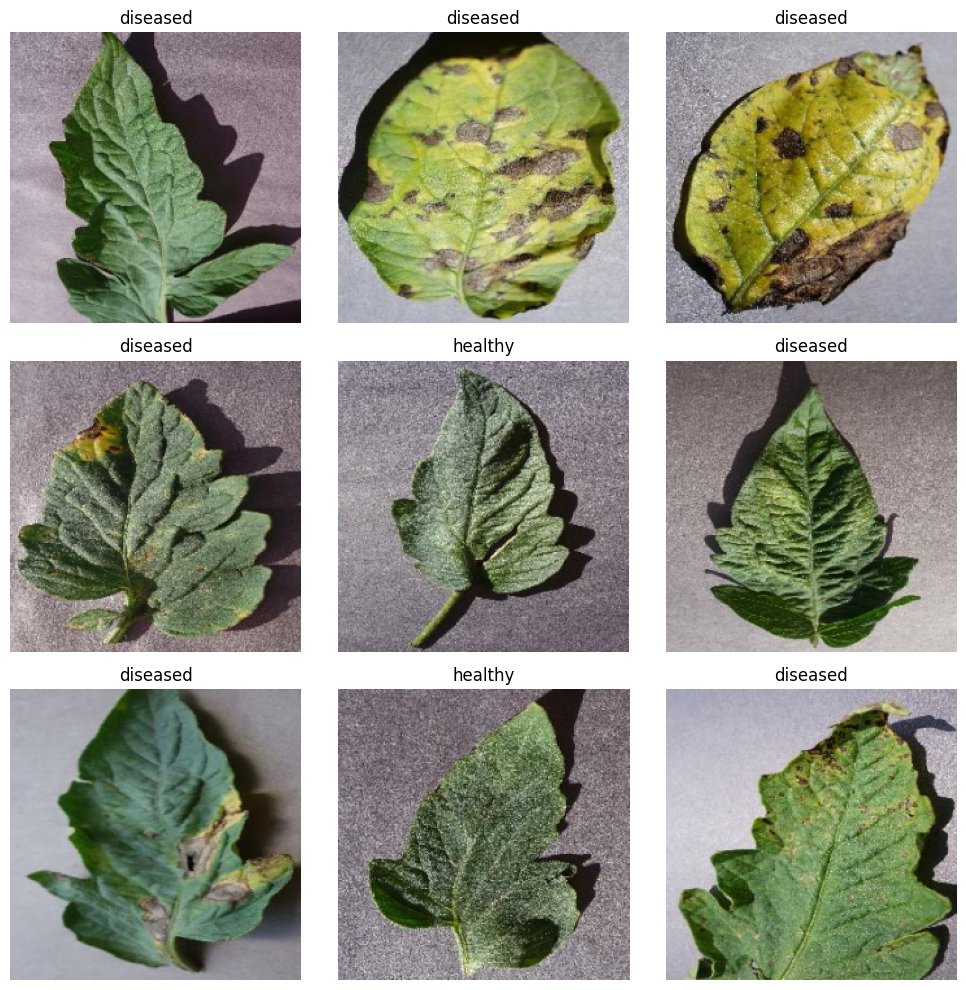

In [5]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        plt.title("healthy" if label == 0 else "diseased")
        plt.axis("off")
    plt.tight_layout()


In [6]:
import os
from collections import Counter

base_path = "dataset/train"
counts = Counter([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

for cls, count in counts.items():
    print(f"{cls:40s}  {count} Bilder")


Tomato_healthy                            1 Bilder
Potato___Early_blight                     1 Bilder
PlantVillage                              1 Bilder
Tomato__Tomato_YellowLeaf__Curl_Virus     1 Bilder
Tomato_Early_blight                       1 Bilder
Tomato__Target_Spot                       1 Bilder
Potato___Late_blight                      1 Bilder
Tomato_Leaf_Mold                          1 Bilder
Tomato_Spider_mites_Two_spotted_spider_mite  1 Bilder
Tomato_Septoria_leaf_spot                 1 Bilder
Tomato__Tomato_mosaic_virus               1 Bilder
Pepper__bell___Bacterial_spot             1 Bilder
Tomato_Bacterial_spot                     1 Bilder
Tomato_Late_blight                        1 Bilder
Pepper__bell___healthy                    1 Bilder
Potato___healthy                          1 Bilder


Found 3109 files belonging to 16 classes.


2025-10-31 21:45:41.364743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3109]
	 [[{{node Placeholder/_4}}]]
2025-10-31 21:45:41.364999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3109]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 175ms/step


2025-10-31 21:45:41.575402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step


2025-10-31 21:45:48.106007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 401ms/step


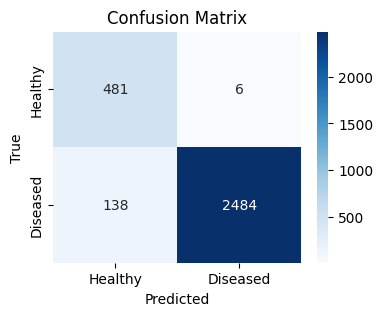

              precision    recall  f1-score   support

     Healthy       0.78      0.99      0.87       487
    Diseased       1.00      0.95      0.97      2622

    accuracy                           0.95      3109
   macro avg       0.89      0.97      0.92      3109
weighted avg       0.96      0.95      0.96      3109



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Testdaten laden
test_dir = pathlib.Path("dataset/test")
test_ds = preprocess_dataset(test_dir)  # gleiche Funktion wie beim Trainieren

# Vorhersagen
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.round(preds).flatten()  # 0 oder 1
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Diseased'],
            yticklabels=['Healthy', 'Diseased'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Klassifikationsbericht
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Diseased']))


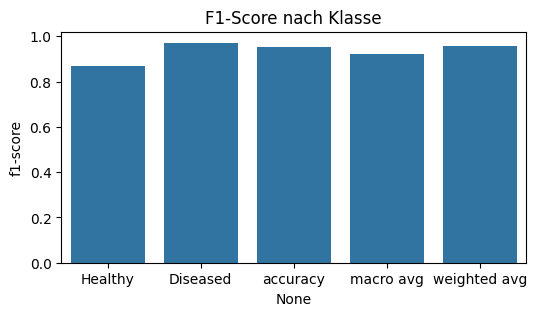

In [8]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

report = classification_report(y_true, y_pred, target_names=['Healthy', 'Diseased'], output_dict=True)
df = pd.DataFrame(report).transpose()

plt.figure(figsize=(6,3))
sns.barplot(x=df.index, y='f1-score', data=df)
plt.title('F1-Score nach Klasse')
plt.show()


In [9]:
from tensorflow import keras

model = keras.models.load_model("cnn_plant_disease_binary.keras")  # oder dein Dateiname
IMG_SIZE = (224, 224)


1/1 [==============================] - 0s 25ms/step


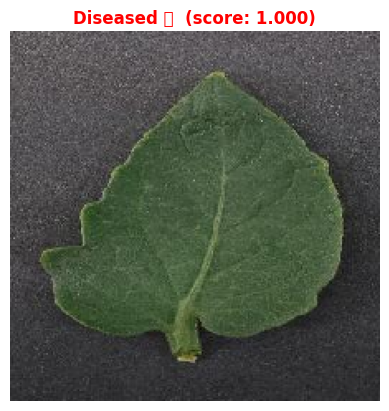

Rohwert (Sigmoid): 1.0000
Schwellenwert: 0.1
Vorhersage: Diseased 🌿


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

IMG_SIZE = (224, 224)

def predict_image(img_path):
    # Bild laden und vorbereiten
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # wie beim Training
    img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)

    # Vorhersage
    pred = model.predict(img_array)[0][0]  # Ausgabewert des Sigmoid-Neurons (zwischen 0 und 1)

    # Threshold anpassen (Standard war 0.5)
    THRESH = 0.4   # bei < 0.5 ist das Modell oft zu "vorsichtig"
    label = "Diseased 🌿" if pred > THRESH else "Healthy 🍃"

    # Farbe für Titel wählen
    color = "red" if label.startswith("Diseased") else "green"

    # Bild + Ergebnis anzeigen
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label}  (score: {pred:.3f})", color=color, fontsize=12, weight="bold")
    plt.show()

    # Rohwert und Entscheidung ausgeben
    print(f"Rohwert (Sigmoid): {pred:.4f}")
    print(f"Schwellenwert: {THRESH}")
    print("Vorhersage:", label)

# Beispielaufruf mit neuem Threshold
predict_image("/Users/umerhanif/Desktop/UNI/SEM5/KI & ML Projekt/KI-Machine-Learning/dataset/train/Tomato_healthy/0a334ae6-bea3-4453-b200-85e082794d56___GH_HL Leaf 310.1.JPG")


In [12]:
import os

test_dir = "dataset/test/Tomato_healthy"
print(os.listdir(test_dir)[:20])


['e2991a66-412d-4841-8dc0-524e38338a82___GH_HL Leaf 517.1.JPG', 'ab1658d8-ef48-4068-b2b5-ce49fb3d06c0___GH_HL Leaf 397.1.JPG', 'da7db6e5-d5d5-489a-b1b2-9b3a880cebaa___RS_HL 9769.JPG', '2a1dd125-ece3-499f-a24b-1d00dbcc3184___GH_HL Leaf 227.JPG', 'f1e20811-da4e-4f0f-b8ee-f325d90f6481___RS_HL 0084.JPG', '139d2f99-d25b-440d-805e-d070a399d8f1___RS_HL 0600.JPG', '824ae544-73d2-448a-b442-a8d2cdd83922___RS_HL 9900.JPG', '57cc95ac-1fae-4959-ba16-d65c3db753d1___RS_HL 0312.JPG', 'b5142952-d782-4b4a-bf1b-db96da849191___RS_HL 0081.JPG', 'd2ce7896-6fa4-45e6-96c5-d162da0e3e1c___GH_HL Leaf 220.JPG', '47d38fb3-c397-433f-a478-482a660b70f3___RS_HL 0113.JPG', 'ef21da16-050f-4be8-a91f-e1fa13ce3991___RS_HL 0242.JPG', 'b842ca3c-1910-4ff3-8691-c7759830651a___RS_HL 9784.JPG', '9582a64b-e8a3-476f-9127-af5b45b0d833___RS_HL 0121.JPG', '43f6d6f0-be8e-4120-8c86-fad3bcfd5c03___RS_HL 0180.JPG', 'cb4a744a-1f1d-4cb1-b2a4-f1e1a12426ca___RS_HL 9970.JPG', '67549f03-2c86-44b7-9730-32d4a23287f3___GH_HL Leaf 495.2.JPG', '0e1